In [ ]:
import os
import urllib.request
import gzip
import json
import ssl

# Skip SSL certificate validation (use only if necessary)
ssl._create_default_https_context = ssl._create_unverified_context

download_dir = "gharchive_2025_01"
os.makedirs(download_dir, exist_ok=True)

# relevant_event_types = {
#     "IssuesEvent",
#     "IssueCommentEvent",
#     "PullRequestEvent",
#     "PullRequestReviewEvent",
#     "PullRequestReviewCommentEvent"
# }

relevant_event_types = {
    "IssuesEvent"
}

collected_events = []

for day in range(1, 2):  # limit for test
    for hour in range(1):  # limit for test
        filename = f"2025-01-{day:02d}-{hour}.json.gz"
        url = f"https://data.gharchive.org/{filename}"
        filepath = os.path.join(download_dir, filename)

        print(f"Processing {filename}...")
        try:
            with gzip.open(filepath, 'rt', encoding='utf-8') as f:
                for line in f:
                    try:
                        event = json.loads(line)
                        if event.get("type") in relevant_event_types:
                            if 'bot' not in event.get("actor",{}).get("login",""):
                                title = (event.get("payload",{}).get("issue",{}).get("title",""))
                                body = (event.get("payload",{}).get("issue",{}).get("body",""))
                                print(f"Title: {title}")
                                print(f"Body: {body}")
                                break
                            # collected_events.append(event)
                    except json.JSONDecodeError:
                        continue
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

# # Save to JSON file
# with open("filtered_events.json", "w", encoding="utf-8") as f:
#     json.dump(collected_events, f, ensure_ascii=False)

# print(f"Saved {len(collected_events)} events to filtered_events.json")


In [ ]:
import os
import urllib.request
import gzip
import json
import ssl
import unicodedata

# Skip SSL certificate validation (use only if necessary)
ssl._create_default_https_context = ssl._create_unverified_context

download_dir = "gharchive_2025_05"
# os.makedirs(download_dir, exist_ok=True)

# relevant_event_types = {
#     "IssuesEvent"
# }

def is_latin(text):
    if not text:
        return True
    for char in text:
        if char.isalpha():
            name = unicodedata.name(char, "")
            if "LATIN" not in name:
                return False
    return True

for day in range(1, 32):  # limit for test
    for hour in range(24):  # limit for test
        filename = f"2025-05-{day:02d}-{hour}.json.gz"
        url = f"https://data.gharchive.org/{filename}"
        filepath = os.path.join(download_dir, filename)

        print(f"Processing {filename}...")
        try:
            with gzip.open(filepath, 'rt', encoding='utf-8') as f:
                for line in f:
                    try:
                        event = json.loads(line)
                        if event.get("type") in relevant_event_types:
                            if 'bot' not in event.get("actor", {}).get("login", ""):
                                title = event.get("payload", {}).get("issue", {}).get("title", "")
                                body = event.get("payload", {}).get("issue", {}).get("body", "")
                                # print(f"Title: {title}")
                                # print(f"Body: {body}")
                                # print(f"Title in Latin: {is_latin(title)}")
                                # print(f"Body in Latin: {is_latin(body)}")
                                if not is_latin(title) or not is_latin(body):
                                    print(f"Title: {title}")
                                    print(f"Body: {body}")
                                    # collected_events.append(event)
                                # break
                    except json.JSONDecodeError:
                        raise
        except Exception as e:
            # print(f"Failed to process {filename}: {e}")
            print(event)
            raise


In [21]:
!pip3 install pandas

  Using cached pandas-2.2.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp312-cp312-macosx_11_0_arm64.whl (11.4 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip


In [ ]:
import os
import urllib.request
import gzip
import json
import ssl
import unicodedata
from collections import defaultdict
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# Skip SSL certificate validation (use only if necessary)
ssl._create_default_https_context = ssl._create_unverified_context

download_dir = "gharchive_2025_05"
# os.makedirs(download_dir, exist_ok=True)

# relevant_event_types = {
#     "IssuesEvent"
# }

def is_latin(text):
    if not text:
        return True
    for char in text:
        if char.isalpha():
            name = unicodedata.name(char, "")
            if "LATIN" not in name:
                return False
    return True

import matplotlib.pyplot as plt

# Dictionary to hold counts: {day: {event_type: count}}
event_counts = defaultdict(lambda: defaultdict(int))

def process_file(day, hour):
    local_counts = defaultdict(int)
    filename = f"2025-05-{day:02d}-{hour}.json.gz"
    filepath = os.path.join(download_dir, filename)
    try:
        with gzip.open(filepath, 'rt', encoding='utf-8') as f:
            for line in f:
                try:
                    event = json.loads(line)
                    event_type = event.get("type")
                    if event_type:
                        local_counts[event_type] += 1
                except json.JSONDecodeError:
                    continue
    except Exception:
        pass
    return day, local_counts

tasks = []
with ThreadPoolExecutor() as executor:
    for day in range(1, 32):
        for hour in range(24):
            tasks.append(executor.submit(process_file, day, hour))
    for future in tqdm(as_completed(tasks), total=len(tasks), desc="Processing files"):
        day, local_counts = future.result()
        for event_type, count in local_counts.items():
            event_counts[day][event_type] += count

# Convert to DataFrame for plotting
df_counts = pd.DataFrame(event_counts).fillna(0).astype(int).T.sort_index()
df_counts.plot(kind='bar', stacked=True, figsize=(15, 6))
plt.xlabel('Day')
plt.ylabel('Event Count')
plt.title('Event Type Counts per Day (Stacked)')
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


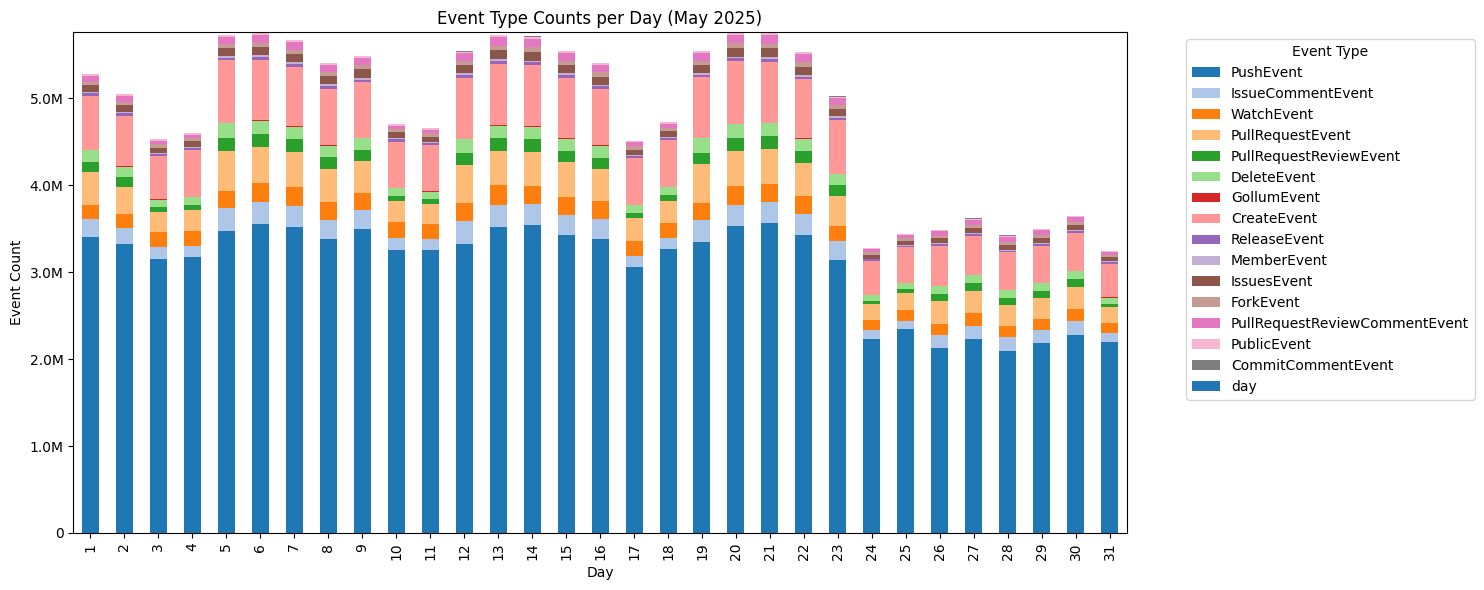

In [9]:
import os
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

# Directory containing your CSV files
csv_dir = "."

# List all relevant CSV files
csv_files = sorted([
    f for f in os.listdir(csv_dir)
    if f.startswith("gharchive_event_counts_2025_05_") and f.endswith(".csv")
])

# Read and concatenate all CSVs
dfs = []
for fname in csv_files:
    # Extract day from filename
    day = int(fname.split("_")[-1].split(".")[0])
    df = pd.read_csv(os.path.join(csv_dir, fname))
    df["Day"] = day
    dfs.append(df)

# Combine all days into one DataFrame
all_df = pd.concat(dfs, ignore_index=True)
all_df = all_df.set_index("Day").sort_index()

# Use 15 distinct colors from seaborn color palette
palette = sns.color_palette("tab20", n_colors=15)[:len(all_df.columns)]

all_df.plot(
    kind="bar",
    stacked=True,
    figsize=(15, 6),
    color=palette
)
def human_format(num, pos=None):
    if num >= 1e6:
        return f'{num/1e6:.1f}M'
    elif num >= 1e3:
        return f'{num/1e3:.0f}k'
    else:
        return str(int(num))

plt.xlabel("Day")
plt.ylabel("Event Count")
plt.title("Event Type Counts per Day (May 2025)")
plt.legend(title="Event Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.gca().yaxis.set_major_formatter(FuncFormatter(human_format))
plt.tight_layout()
plt.show()

In [37]:
df['IssuesEvent'], df['IssueCommentEvent']

(0    45716
 Name: IssuesEvent, dtype: int64,
 0    105022
 Name: IssueCommentEvent, dtype: int64)

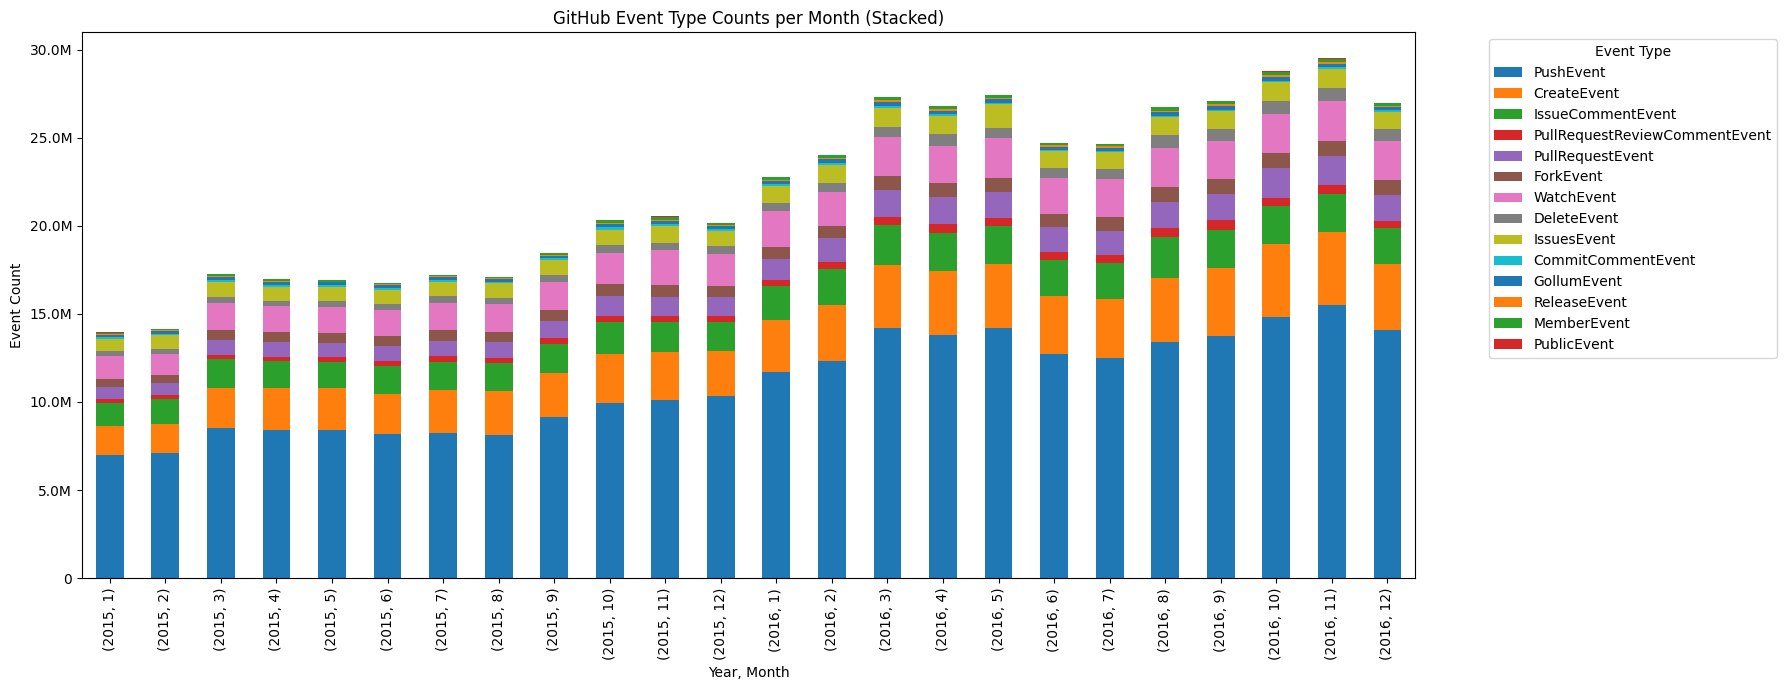

In [44]:
import pandas as pd

import matplotlib.pyplot as plt

# Collect all monthly DataFrames
all_months = []
for year in [2015, 2016]:
    for i in range(1, 13):
        df = pd.read_csv(f"gharchive_event_counts_{year}_{i:02d}.csv")
        df = df.drop(columns=['Unnamed: 0'], errors='ignore')
        df["Year"] = year
        df["Month"] = i
        df["Day"] = df.index + 1
        all_months.append(df)

# Combine all months
combined_df = pd.concat(all_months, ignore_index=True)
combined_df.set_index(["Year", "Month", "Day"], inplace=True)

# Plot
combined_df.groupby(["Year", "Month"]).sum().plot(
    kind="bar",
    stacked=True,
    figsize=(18, 7)
)

def human_format(num, pos=None):
    if num >= 1e6:
        return f'{num/1e6:.1f}M'
    elif num >= 1e3:
        return f'{num/1e3:.0f}k'
    else:
        return str(int(num))
    
plt.xlabel("Year, Month")
plt.ylabel("Event Count")
plt.title("GitHub Event Type Counts per Month (Stacked)")
plt.legend(title="Event Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.gca().yaxis.set_major_formatter(FuncFormatter(human_format))
plt.tight_layout()
plt.show()
        

In [ ]:
import os
import urllib.request
import gzip
import json
import ssl
import numpy as np
import unicodedata

# Skip SSL certificate validation (use only if necessary)
ssl._create_default_https_context = ssl._create_unverified_context

download_dir = "gharchive_2025_05"

# relevant_event_types = {
#     "IssuesEvent",
#     "IssueCommentEvent",
#     "PullRequestEvent",
#     "PullRequestReviewEvent",
#     "PullRequestReviewCommentEvent"
# }

relevant_event_types = {
    "IssuesEvent",
    "IssueCommentEvent"
}

collected_events = []

import matplotlib.pyplot as plt

bot_issue_counts = []
bot_comment_counts = []
# non_bot_issue_counts = []
# non_bot_comment_counts = []
non_english_issue_counts = []
english_comment_counts = []
days = []

def is_english(text):
    if not text:
        return True
    for char in text:
        if char.isspace() or not char.isalpha():
            continue
        if not ('a' <= char.lower() <= 'z'):
            return False
    return True

for day in range(1, 32):  # limit for test
    bot_issue = 0
    bot_comment = 0
    non_bot_issue = 0
    non_bot_comment = 0
    not_english = 0
    english = 0
    for hour in range(24):  # limit for test
        filename = f"2025-05-{day:02d}-{hour}.json.gz"
        filepath = os.path.join(download_dir, filename)

        print(f"Processing {filename}...")
        try:
            with gzip.open(filepath, 'rt', encoding='utf-8') as f:
                for line in f:
                    try:
                        event = json.loads(line)
                        if event.get("type") in relevant_event_types:
                            if 'bot' not in event.get("actor",{}).get("login",""):
                                title = (event.get("payload",{}).get("issue",{}).get("title",""))
                                body = (event.get("payload",{}).get("issue",{}).get("body",""))
                                # Check if title/body is Latin or non-Latin
                                
                                title_is_latin = is_english(title)
                                body_is_latin = is_english(body)
                                if not title_is_latin or not body_is_latin:
                                    # print(f"Title: {title} | Latin: {title_is_latin}")
                                    # print(f"Body: {body} | Latin: {body_is_latin}")
                                    # print("------------------------------------------")
                                    not_english +=1
                                else:
                                    english+=1
                    except json.JSONDecodeError:
                        continue
        except Exception as e:
            print(f"Failed to process {filename}: {e}")
    # bot_issue_counts.append(bot_issue)
    # bot_comment_counts.append(bot_comment)
    # non_bot_issue_counts.append(non_bot_issue)
    # non_bot_comment_counts.append(non_bot_comment)
    english_comment_counts.append(english)
    non_english_issue_counts.append(not_english)
    days.append(day)

# Plotting stacked bar for each day

# Prepare data for stacked bar
# Since non_bot_issue_counts and non_bot_comment_counts are not defined or used in the loop,
# we will only plot the available data: english_comment_counts and non_english_issue_counts

plt.figure(figsize=(8, 5))
plt.bar(days, english_comment_counts, label="English Issues/Comments", color="blue", width=0.5)
plt.bar(days, non_english_issue_counts, bottom=english_comment_counts, label="Non-English Issues/Comments", color="orange", width=0.5)
plt.xlabel("Day")
plt.ylabel("Count")
plt.title("English vs Non-English Issues/Comments (Stacked)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import os
import gzip
import json
import ssl
import unicodedata
from collections import defaultdict
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import argparse
from lingua import Language, LanguageDetectorBuilder

# Setup language detector
languages = [Language.ENGLISH, Language.SPANISH, Language.FRENCH, Language.GERMAN,
             Language.CHINESE, Language.JAPANESE, Language.HINDI, Language.BENGALI,
             Language.RUSSIAN, Language.PORTUGUESE, Language.ARABIC]
detector = LanguageDetectorBuilder.from_languages(*languages).build()

# Disable SSL validation if needed
ssl._create_default_https_context = ssl._create_unverified_context

# CLI arguments
parser = argparse.ArgumentParser(description="Process GH Archive event counts and language stats.")
parser.add_argument("--year", type=int, required=True)
parser.add_argument("--month", type=int, required=True)
parser.add_argument("--day", type=int, required=True)
args = parser.parse_args()

year = args.year
month = args.month
day = args.day
download_dir = f"gharchive_{year}_{month:02d}"
day_str = f"{year}-{month:02d}-{day:02d}"

relevant_event_types = {
    "IssuesEvent",
    "IssueCommentEvent"
}

def is_english(text):
    if not text:
        return True
    for char in text:
        if char.isspace() or not char.isalpha():
            continue
        if not ('a' <= char.lower() <= 'z'):
            return False
    return True

event_counts = defaultdict(int)
english = 0
not_english = 0
english_id_lang = []
non_english_id_list = []

def process_hour(hour):
    filename = f"{day_str}-{hour}.json.gz"
    filepath = os.path.join(download_dir, filename)
    local_counts = defaultdict(int)
    english_local = 0
    not_english_local = 0
    english_ids = []
    non_english_ids = []

    try:
        with gzip.open(filepath, 'rt', encoding='utf-8') as f:
            for line in f:
                try:
                    event = json.loads(line)
                    event_type = event.get("type")
                    if event_type:
                        local_counts[event_type] += 1

                    if event_type in relevant_event_types:
                        if 'bot' not in event.get("actor", {}).get("login", ""):
                            payload = event.get("payload", {})
                            issue = payload.get("issue", {})
                            title = issue.get("title", "")
                            body = issue.get("body", "")
                            item_id = issue.get("id", None)

                            combined = f"{title} {body}".strip()
                            if is_english(title) and is_english(body):
                                lang = "unknown"
                                if combined:
                                    detection = detector.detect_language_of(combined)
                                    lang = detection.name.lower() if detection else "unknown"
                                english_local += 1
                                if item_id:
                                    english_ids.append({"id": item_id, "lang": lang})
                            else:
                                not_english_local += 1
                                if item_id:
                                    non_english_ids.append(item_id)
                except json.JSONDecodeError:
                    continue
    except Exception:
        pass
    return local_counts, english_local, not_english_local, english_ids, non_english_ids

# Process 24 hours
tasks = []
with ThreadPoolExecutor() as executor:
    for hour in range(24):
        tasks.append(executor.submit(process_hour, hour))
    for future in tqdm(as_completed(tasks), total=len(tasks), desc=f"Day {day:02d}"):
        local_counts, eng, not_eng, eng_ids, not_eng_ids = future.result()
        for k, v in local_counts.items():
            event_counts[k] += v
        english += eng
        not_english += not_eng
        english_id_lang.extend(eng_ids)
        non_english_id_list.extend(not_eng_ids)

# Save daily event counts
event_counts['day'] = day
df_all = pd.DataFrame([event_counts]).fillna(0).astype(int)
df_all.to_csv(f"gharchive_event_counts_{year}_{month:02d}_{day:02d}.csv", index=False)

# Save language stats
df_english = pd.DataFrame([{
    "day": day,
    "english": english,
    "not_english": not_english
}])
df_english.to_csv(f"gharchive_english_stats_{year}_{month:02d}_{day:02d}.csv", index=False)

# Save ID info
with open(f"english_ids_lang_{year}_{month:02d}_{day:02d}.json", "w") as f:
    json.dump(english_id_lang, f)

with open(f"non_english_ids_{year}_{month:02d}_{day:02d}.json", "w") as f:
    json.dump(non_english_id_list, f)


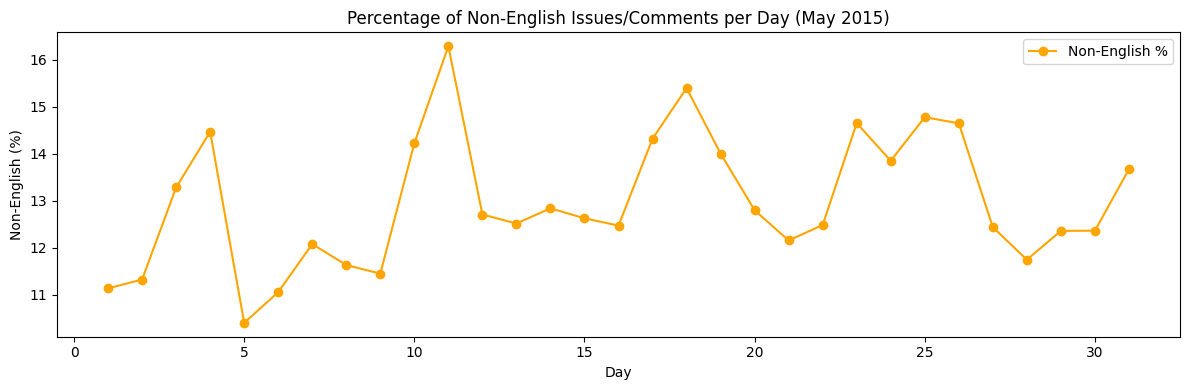

In [ ]:
import matplotlib.pyplot as plt

english_counts = []
non_english_counts = []
days = []

for day in range(1, 32):
    with open(f"english_ids_lang_2025_05_{day:02d}.json", "r") as f:
        data = json.load(f)
    with open(f"non_english_ids_2025_05_{day:02d}.json", "r") as f:
        non_eng_data = json.load(f)
    english_counts.append(len(data))
    non_english_counts.append(len(non_eng_data))
    days.append(day)

def human_format(num, pos=None):
    if num >= 1e6:
        return f'{num/1e6:.1f}M'
    elif num >= 1e3:
        return f'{num/1e3:.0f}k'
    else:
        return str(int(num))

# plt.figure(figsize=(12, 6))
# plt.bar(days, english_counts, label="English", color="royalblue")
# plt.bar(days, non_english_counts, bottom=english_counts, label="Non-English", color="orange")
# plt.xlabel("Day")
# plt.ylabel("Issues/Comments Count")
# plt.title("English vs Non-English Issues/Comments per Day (May 2025)")
# plt.gca().yaxis.set_major_formatter(FuncFormatter(human_format))
# plt.legend()
# plt.tight_layout()
# plt.show()

total_counts = [e + n for e, n in zip(english_counts, non_english_counts)]
non_english_pct = [n / t * 100 if t > 0 else 0 for n, t in zip(non_english_counts, total_counts)]

plt.figure(figsize=(12, 4))
plt.plot(days, non_english_pct, marker='o', color='orange', label="Non-English %")
plt.xlabel("Day")
plt.ylabel("Non-English (%)")
plt.title(f"Percentage of Non-English Issues/Comments per Day (May 2015)")
# plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.savefig(f"non_english_percentage_05_2025.png")
plt.show()
        


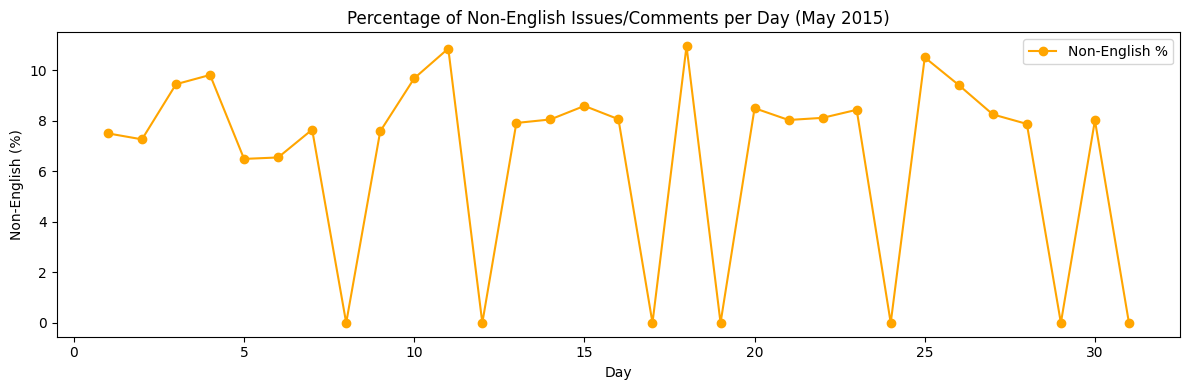

In [24]:
import matplotlib.pyplot as plt

english_counts = []
non_english_counts = []
days = []

for day in range(1, 32):
    with open(f"pullreq_english_ids_lang_2025_05_{day:02d}.json", "r") as f:
        data = json.load(f)
    with open(f"pullreq_non_english_ids_2025_05_{day:02d}.json", "r") as f:
        non_eng_data = json.load(f)
    english_counts.append(len(data))
    non_english_counts.append(len(non_eng_data))
    days.append(day)

def human_format(num, pos=None):
    if num >= 1e6:
        return f'{num/1e6:.1f}M'
    elif num >= 1e3:
        return f'{num/1e3:.0f}k'
    else:
        return str(int(num))

# plt.figure(figsize=(12, 6))
# plt.bar(days, english_counts, label="English", color="royalblue")
# plt.bar(days, non_english_counts, bottom=english_counts, label="Non-English", color="orange")
# plt.xlabel("Day")
# plt.ylabel("Issues/Comments Count")
# plt.title("English vs Non-English Issues/Comments per Day (May 2025)")
# plt.gca().yaxis.set_major_formatter(FuncFormatter(human_format))
# plt.legend()
# plt.tight_layout()
# plt.show()

total_counts = [e + n for e, n in zip(english_counts, non_english_counts)]
non_english_pct = [n / t * 100 if t > 0 else 0 for n, t in zip(non_english_counts, total_counts)]

plt.figure(figsize=(12, 4))
plt.plot(days, non_english_pct, marker='o', color='orange', label="Non-English %")
plt.xlabel("Day")
plt.ylabel("Non-English (%)")
plt.title(f"Percentage of Non-English Issues/Comments per Day (May 2015)")
# plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
# plt.savefig(f"non_english_percentage_05_2025.png")
plt.show()
        


In [32]:
import os
import gzip
import json
import ssl
import requests
import unicodedata
from collections import defaultdict
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import argparse
# from lingua import Language, LanguageDetectorBuilder

# # Setup language detector
# languages = [Language.ENGLISH, Language.SPANISH, Language.FRENCH, Language.GERMAN,
#              Language.CHINESE, Language.JAPANESE, Language.HINDI, Language.BENGALI,
#              Language.RUSSIAN, Language.PORTUGUESE, Language.ARABIC]
# detector = LanguageDetectorBuilder.from_languages(*languages).build()

# Disable SSL validation if needed
ssl._create_default_https_context = ssl._create_unverified_context


year = 2025
month = 5
day = 1
download_dir = f"data/gharchive_{year}_{month:02d}"
day_str = f"{year}-{month:02d}-{day:02d}"

# relevant_event_types = {
#     "IssuesEvent",
#     "IssueCommentEvent"
# }
relevant_event_types = {
    "PushEvent"
}
# relevant_event_types = {
#     "PullRequestEvent",
#     "PullRequestReviewEvent",
#     "PullRequestReviewCommentEvent"
# }
def is_english(text):
    if not text:
        return True
    for char in text:
        if char.isspace() or not char.isalpha():
            continue
        if not ('a' <= char.lower() <= 'z'):
            return False
    return True

event_counts = defaultdict(int)
english = 0
not_english = 0
english_id_lang = []
non_english_id_list = []

def process_hour(hour):
    filename = f"{day_str}-{hour}.json.gz"
    filepath = os.path.join(download_dir, filename)
    local_counts = defaultdict(int)
    english_local = 0
    not_english_local = 0
    english_ids = []
    non_english_ids = []
    patches = []
    count = 0
    repository_ids = set()
    try:
        with gzip.open(filepath, 'rt', encoding='utf-8') as f:
            for line in f:
                try:
                    event = json.loads(line)
                    # print(event)
                    event_type = event.get("type")
                    if event_type:
                        local_counts[event_type] += 1

                    if event_type in relevant_event_types:
                        if 'bot' not in event.get("actor", {}).get("login", ""):
                            # print(event)
                            # print(event.keys())
                            # for key in event['payload']:
                                # if isinstance(event['payload'][key], object):
                            print(event['repo'])
                            print(event['payload'])

                            # commits = event['payload'].get('commits', [])
                            # # print(f"Processing {len(commits)} commits in event {event_type} at hour {hour}")
                            # if len(commits)>=1:
                            #     # print(event.keys())
                            #     repo = event.get('repo', {})
                            #     # print(repo)
                            #     id = repo.get('id', '')
                            #     name = repo.get('name', '')
                            #     repository_ids.add(id)
                            count+=1
                            if count==10:
                                break
                except json.JSONDecodeError:
                    raise ValueError(f"Invalid JSON in file {filepath} at line: {line}")
    except Exception:
        raise ValueError(f"Error processing file {filepath}")
    return repository_ids

# Process 24 hours
tasks = []
total = 0
total_eng = 0
total_not_eng = 0
with ThreadPoolExecutor() as executor:
    all_repos = set()
    for hour in range(1):
        tasks.append(executor.submit(process_hour, hour))
    for future in as_completed(tasks):
        repos = future.result()
        all_repos.update(repos)
        task_number = tasks.index(future)
        print(f"Task {task_number} ===============> Repositories: {len(repos)}")
    print(f"Total unique repositories: {len(all_repos)}")
        # output_json_path = os.path.join("commit_files", f"{day_str}_{task_number}_commit_files.json")
        # with open(output_json_path, "w", encoding="utf-8") as f:
        #     json.dump(patches, f, indent=4, ensure_ascii=False)


    #     total_eng += eng
    #     total_not_eng += not_eng
    #     task_number = tasks.index(future)
    #     print(f"Task {task_number} ===============> English: {eng}, Not English: {not_eng}, {(not_eng/(eng + not_eng)) * 100}")
    #     total+=((not_eng/(eng + not_eng)) * 100)
    # print(f"avg percentage of non-English: {total/len(tasks)}")
    # print(f"avg percentage of non-English: {total_not_eng/(total_eng + total_not_eng) * 100}")



{'id': 968398256, 'name': 'rayandripo/nextjs_drizzle_better-auth', 'url': 'https://api.github.com/repos/rayandripo/nextjs_drizzle_better-auth'}
{'repository_id': 968398256, 'push_id': 24050609320, 'size': 1, 'distinct_size': 1, 'ref': 'refs/heads/master', 'head': '702b3009d7f5e5592cf4a3769d329da41ad0d428', 'before': '4be21a213693b140f0ec5295c10afd2cc645f167', 'commits': [{'sha': '702b3009d7f5e5592cf4a3769d329da41ad0d428', 'author': {'email': '95055261+rayandripo@users.noreply.github.com', 'name': 'Rayan'}, 'message': 'Commit', 'distinct': True, 'url': 'https://api.github.com/repos/rayandripo/nextjs_drizzle_better-auth/commits/702b3009d7f5e5592cf4a3769d329da41ad0d428'}]}
{'id': 972667068, 'name': 'davidkimai/glyphs', 'url': 'https://api.github.com/repos/davidkimai/glyphs'}
{'repository_id': 972667068, 'push_id': 24050609326, 'size': 1, 'distinct_size': 1, 'ref': 'refs/heads/main', 'head': 'd6cc8b58017c1beef80f2a5fb98ebbccee741e8b', 'before': '8544b1a83d561a5183838dda13f5372793b64513', '

In [ ]:
import os
import gzip
import json
import re
import ssl
import requests
import unicodedata
from collections import defaultdict
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import argparse
# from lingua import Language, LanguageDetectorBuilder

# # Setup language detector
# languages = [Language.ENGLISH, Language.SPANISH, Language.FRENCH, Language.GERMAN,
#              Language.CHINESE, Language.JAPANESE, Language.HINDI, Language.BENGALI,
#              Language.RUSSIAN, Language.PORTUGUESE, Language.ARABIC]
# detector = LanguageDetectorBuilder.from_languages(*languages).build()

# Disable SSL validation if needed
ssl._create_default_https_context = ssl._create_unverified_context


year = 2025
month = 5
day = 1
download_dir = f"data/gharchive_{year}_{month:02d}"
day_str = f"{year}-{month:02d}-{day:02d}"

# relevant_event_types = {
#     "IssuesEvent",
#     "IssueCommentEvent"
# }
relevant_event_types = {
    "PushEvent"
}
# relevant_event_types = {
#     "PullRequestEvent",
#     "PullRequestReviewEvent",
#     "PullRequestReviewCommentEvent"
# }
def is_english(text):
    if not text:
        return True
    for char in text:
        if char.isspace() or not char.isalpha():
            continue
        if not ('a' <= char.lower() <= 'z'):
            return False
    return True

event_counts = defaultdict(int)
english = 0
not_english = 0
english_id_lang = []
non_english_id_list = []

def process_hour(hour):
    filename = f"{day_str}-{hour}.json.gz"
    filepath = os.path.join(download_dir, filename)
    local_counts = defaultdict(int)
    english_local = 0
    not_english_local = 0
    english_ids = []
    non_english_ids = []
    patches = []
    count = 0
    event_types = []
    try:
        with gzip.open(filepath, 'rt', encoding='utf-8') as f:
            for line in f:
                if "\"language\":" in line:
                    print(line.strip())
                    match = re.search(r'"language"\s*:\s*"([^"]+)"', line)
                    if match:
                        print(match.group(1))  # Output: Perl6
                        event = json.loads(line)
                        # print(event)
                        print(event.keys())
                        id = event.get('repo', {}).get('id', '')
                        name = event.get('repo', {}).get('name', '')
                        ret_obj = {
                            "id": id,
                            "name": name,
                            "language": match.group(1)
                        }
                        event_types.append(ret_obj)
                    count+=1
                    if count==10:
                        break
    except Exception:
        raise ValueError(f"Error processing file {filepath}")
    return event_types

# Process 24 hours
tasks = []
total = 0
total_eng = 0
total_not_eng = 0
with ThreadPoolExecutor() as executor:
    all_events = []
    for hour in range(1):
        tasks.append(executor.submit(process_hour, hour))
    for future in as_completed(tasks):
        event_types = future.result()
        all_events.extend(event_types)
        print(all_events)
     

{"id":"49249023459","type":"PullRequestEvent","actor":{"id":23547481,"login":"stephencge","display_login":"stephencge","gravatar_id":"","url":"https://api.github.com/users/stephencge","avatar_url":"https://avatars.githubusercontent.com/u/23547481?"},"repo":{"id":975751517,"name":"stanford-cs336/assignment2-systems-leaderboard","url":"https://api.github.com/repos/stanford-cs336/assignment2-systems-leaderboard"},"payload":{"action":"opened","number":1,"pull_request":{"url":"https://api.github.com/repos/stanford-cs336/assignment2-systems-leaderboard/pulls/1","id":2492883136,"node_id":"PR_kwDOOijJXc6UlmDA","html_url":"https://github.com/stanford-cs336/assignment2-systems-leaderboard/pull/1","diff_url":"https://github.com/stanford-cs336/assignment2-systems-leaderboard/pull/1.diff","patch_url":"https://github.com/stanford-cs336/assignment2-systems-leaderboard/pull/1.patch","issue_url":"https://api.github.com/repos/stanford-cs336/assignment2-systems-leaderboard/issues/1","number":1,"state":"o

In [ ]:
from tqdm import tqdm

year = 2025
month = 5
id_list = []
language_counter = {}

for i in tqdm(range(1, 32), desc="Processing days"):
    try:
        with open(f"result_files/repo_langauges_{year}_{month:02d}_{i:02d}.json", "r") as f:
            data = json.load(f)
            for item in data:
                id = item.get('id', '')
                name = item.get('name', '')
                language = item.get('language', '')
                if id not in id_list:
                    id_list.append(id)
                    if language:
                        language_counter[language] = language_counter.get(language, 0) + 1

    except FileNotFoundError:
        pass
print(f"Total unique repository IDs: {len(id_list)}")
print("Language counts:")
for lang, count in language_counter.items():
    print(f"{lang}: {count}")
print(language_counter)

In [8]:
from tqdm import tqdm
import pandas as pd
year = 2025
month = 5
id_list = []
language_counter = {}

for i in tqdm(range(1, 32), desc="Processing days"):
    try:
        df = pd.read_csv(f"result_files/repo_languages_{year}_{month:02d}_{i:02d}.csv")
        df = df.drop_duplicates(subset=['id']).reset_index(drop=True)
        # print(f"Processing day {i}: {len(df)} unique repositories")
        # count unique languages in df['language']
        for index, row in df.iterrows():
            id = row.get('id', '')
            name = row.get('name', '')
            language = row.get('language', '')
            language_counter[language] = language_counter.get(language, 0) + 1
    except FileNotFoundError:
        pass
# Sort language_counter by count in descending order
sorted_lang_counts = sorted(language_counter.items(), key=lambda x: x[1], reverse=True)
print(f"Total unique repository IDs: {len(id_list)}")
print("Language counts (sorted):")
for lang, count in sorted_lang_counts:
    print(f"{lang}: {count}")
print(dict(sorted_lang_counts))

Processing days: 100%|██████████| 31/31 [00:37<00:00,  1.19s/it]

Total unique repository IDs: 0
Language counts (sorted):
TypeScript: 435160
Python: 332491
JavaScript: 273820
Java: 176141
Go: 137593
HTML: 116139
C#: 92037
C++: 79302
Rust: 70794
Ruby: 58453
PHP: 53063
Shell: 51208
Kotlin: 48454
C: 45991
Jupyter Notebook: 32467
CSS: 25697
Vue: 24358
Dart: 18810
HCL: 16631
Swift: 15197
Dockerfile: 13855
Scala: 11347
MDX: 10766
PowerShell: 10208
Lua: 9243
SCSS: 9130
Astro: 8164
Nix: 7778
Makefile: 7536
Svelte: 7106
R: 6915
Blade: 5579
Julia: 4881
Smarty: 4745
Jinja: 4301
Elixir: 4167
Solidity: 3973
TeX: 3048
Markdown: 2982
GDScript: 2777
YAML: 2546
Haskell: 2169
ShaderLab: 1971
Fortran: 1904
Zig: 1807
Perl: 1737
Groovy: 1671
DM: 1661
Mustache: 1601
CMake: 1535
EJS: 1481
OCaml: 1479
Batchfile: 1379
Starlark: 1365
Clojure: 1288
Objective-C: 1267
Assembly: 1154
PLpgSQL: 1134
Vim Script: 1091
Emacs Lisp: 1004
Nunjucks: 950
XSLT: 889
MATLAB: 871
Roff: 841
BitBake: 839
TSQL: 838
Nextflow: 837
LLVM: 759
Apex: 751
Liquid: 713
JSON: 698
Jsonnet: 674
Gherkin: 651

In [ ]:
import os
import gzip
import json
import re
import ssl
import unicodedata
from collections import defaultdict
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import argparse
# from lingua import Language, LanguageDetectorBuilder

# # Setup language detector
# languages = [Language.ENGLISH, Language.SPANISH, Language.FRENCH, Language.GERMAN,
#              Language.CHINESE, Language.JAPANESE, Language.HINDI, Language.BENGALI,
#              Language.RUSSIAN, Language.PORTUGUESE, Language.ARABIC]
# detector = LanguageDetectorBuilder.from_languages(*languages).build()

# Disable SSL validation if needed
ssl._create_default_https_context = ssl._create_unverified_context

# CLI arguments
parser = argparse.ArgumentParser(description="Process GH Archive event counts and language stats.")
parser.add_argument("--year", type=int, required=True)
parser.add_argument("--month", type=int, required=True)
parser.add_argument("--day", type=int, required=True)
args = parser.parse_args()

year = args.year
month = args.month
day = args.day
download_dir = f"data/gharchive_{year}_{month:02d}"
day_str = f"{year}-{month:02d}-{day:02d}"

# relevant_event_types = {
#     "IssuesEvent",
#     "IssueCommentEvent"
# }

relevant_event_types = {
    "PullRequestEvent",
    "PullRequestReviewEvent",
    "PullRequestReviewCommentEvent"
}
def is_english(text):
    if not text:
        return True
    for char in text:
        if char.isspace() or not char.isalpha():
            continue
        if not ('a' <= char.lower() <= 'z'):
            return False
    return True

event_counts = defaultdict(int)
english = 0
not_english = 0
all_languages = []
non_english_id_list = []

def process_hour(hour):
    filename = f"{day_str}-{hour}.json.gz"
    filepath = os.path.join(download_dir, filename)
    count = 0
    event_types = []
    try:
        with gzip.open(filepath, 'rt', encoding='utf-8') as f:
            for line in f:
                if "repos_url" in line:
                    # print(line.strip())
                    match = re.search(r'"repos_url"\s*:\s*"([^"]+)"', text)
                    if match:
                        print(match.group(1)) # Output: Perl6
                    
                        # # print(match.group(1))  # Output: Perl6
                        # event = json.loads(line)
                        # id = event.get('repo', {}).get('id', '')
                        # name = event.get('repo', {}).get('name', '')
                        # ret_obj = {
                        #     "id": id,
                        #     "name": name,
                        #     "language": match.group(1)
                        # }
                        # event_types.append(ret_obj)
                    count+=1
                    if count==10:
                        break
    except Exception:
        raise ValueError(f"Error processing file {filepath}")
    return event_types

# Process 24 hours
tasks = []
with ThreadPoolExecutor() as executor:
    for hour in range(24):
        tasks.append(executor.submit(process_hour, hour))
    for future in tqdm(as_completed(tasks), total=len(tasks), desc=f"Day {day:02d}"):
        languages = future.result()
        all_languages.extend(languages)
        
# Save ID info
with open(f"result_files/repo_langauges_{year}_{month:02d}_{day:02d}.json", "w") as f:
    json.dump(all_languages, f, indent=4, ensure_ascii=False)


In [10]:
! pip3 install tree-sitter-typescript


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip


In [ ]:
import os
import re
import ast
import logging
import pandas as pd
from pathlib import Path
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
from tree_sitter import Language, Parser

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('code_parser.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Constants
LANGUAGE_SO = "build/my-languages.so"
TARGET_EXTS = {".js", ".ts", ".py"}
# MAX_WORKERS = os.cpu_count() or 4
MAX_WORKERS = 1

class CodeParser:
    def __init__(self):
        self._load_parsers()
        
    def _load_parsers(self):
        """Initialize tree-sitter parsers for supported languages"""
        try:
            self.js_parser = Parser()
            self.js_parser.set_language(Language(LANGUAGE_SO, "javascript"))
            
            self.ts_parser = Parser()
            self.ts_parser.set_language(Language(LANGUAGE_SO, "typescript"))
        except Exception as e:
            logger.error(f"Failed to load tree-sitter languages: {e}")
            raise

    @staticmethod
    def _extract_tree_sitter_entities(code, parser):
        """Extract entities using tree-sitter parser"""
        result = {
            "functions": set(),
            "classes": set(),
            "variables": set(),
            "literals": set(),
            "comments": set()
        }

        try:
            tree = parser.parse(bytes(code, "utf8"))
            root_node = tree.root_node

            def get_text(node):
                return code[node.start_byte:node.end_byte]

            def walk(node):
                try:
                    if node.type == "function_declaration":
                        if name := node.child_by_field_name("name"):
                            result["functions"].add(get_text(name))
                    elif node.type == "class_declaration":
                        if name := node.child_by_field_name("name"):
                            result["classes"].add(get_text(name))
                    elif node.type == "variable_declarator":
                        if name := node.child_by_field_name("name"):
                            result["variables"].add(get_text(name))
                    elif node.type == "string":
                        result["literals"].add(get_text(node).strip('"\''))
                    
                    for child in node.children:
                        walk(child)
                except Exception as e:
                    logger.debug(f"Error processing node: {e}")

            walk(root_node)
            
            # Extract comments
            comments = re.findall(r'//.*?$|/\*.*?\*/', code, re.DOTALL | re.MULTILINE)
            result["comments"].update(comment.strip() for comment in comments)
            
        except Exception as e:
            logger.warning(f"Tree-sitter parsing failed: {e}")

        return result

    @staticmethod
    def _extract_python_entities(code):
        """Extract entities from Python code using AST"""
        entities = defaultdict(set)
        
        try:
            tree = ast.parse(code)
            for node in ast.walk(tree):
                try:
                    if isinstance(node, ast.FunctionDef):
                        entities["functions"].add(node.name)
                        if docstring := ast.get_docstring(node):
                            entities["docstrings"].add(docstring)
                    elif isinstance(node, ast.ClassDef):
                        entities["classes"].add(node.name)
                        if docstring := ast.get_docstring(node):
                            entities["docstrings"].add(docstring)
                    elif isinstance(node, ast.Name) and isinstance(node.ctx, ast.Store):
                        entities["variables"].add(node.id)
                    elif isinstance(node, (ast.Str, ast.Constant)):
                        val = getattr(node, "s", getattr(node, "value", ""))
                        if isinstance(val, str):
                            entities["literals"].add(val)
                except Exception as e:
                    logger.debug(f"Error processing AST node: {e}")
                    
        except Exception as e:
            logger.warning(f"Python AST parsing failed: {e}")
            
        return entities

    def extract_entities(self, code, ext):
        """Dispatch to appropriate parser based on file extension"""
        if not code.strip():
            return defaultdict(set)
            
        if ext == ".py":
            return self._extract_python_entities(code)
        elif ext == ".js":
            return self._extract_tree_sitter_entities(code, self.js_parser)
        elif ext == ".ts":
            return self._extract_tree_sitter_entities(code, self.ts_parser)
        else:
            return defaultdict(set)

def process_commit_file(commit_data, parser):
    """Process a single file in a commit"""
    header, *body = commit_data["diff"].splitlines()
    changed_file = header.split(" ")[0]
    ext = Path(changed_file).suffix.lower()
    
    if ext not in TARGET_EXTS:
        return None

    try:
        patch_lines = [
            line[1:] for line in body
            if line.startswith(('+', '-')) and not line.startswith(('+++', '---'))
        ]
        code = "\n".join(patch_lines)
        entities = parser.extract_entities(code, ext)

        return {
            "repo_id": commit_data["repo_id"],
            "commit": commit_data["commit_hash"],
            "file": changed_file,
            "extension": ext,
            "functions": list(entities.get("functions", set())),
            "classes": list(entities.get("classes", set())),
            "variables": list(entities.get("variables", set())),
            "literals": list(entities.get("literals", set())),
            "docstrings": list(entities.get("docstrings", set())),
            "comments": list(entities.get("comments", set()))
        }
    except Exception as e:
        logger.warning(f"Failed to process {changed_file} in commit {commit_data['commit_hash']}: {e}")
        return None

def parse_git_log(file_path):
    """Parse git log file and yield commit data"""
    repo_id = Path(file_path).stem
    
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            content = f.read()
    except Exception as e:
        logger.error(f"Failed to read {file_path}: {e}")
        return

    commits = re.split(r'\n(?=commit\s[0-9a-f]{40})', content.strip())
    
    for commit in commits:
        lines = commit.splitlines()
        if not lines or not lines[0].startswith("commit"):
            continue

        commit_hash = lines[0].split()[1]
        diffs = re.split(r'diff --git a/', commit)
        
        for diff in diffs[1:]:
            yield {
                "repo_id": repo_id,
                "commit_hash": commit_hash,
                "diff": diff
            }

def main():
    parser = CodeParser()
    all_data = []
    log_folder = "logs"
    
    if not os.path.exists(log_folder):
        logger.error(f"Log folder {log_folder} does not exist")
        return

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        for file in os.listdir(log_folder):
            if not file.endswith(".txt"):
                continue

            file_path = os.path.join(log_folder, file)
            logger.info(f"Processing {file_path}")
            
            futures = []
            for commit_data in parse_git_log(file_path):
                futures.append(executor.submit(process_commit_file, commit_data, parser))
            
            for future in futures:
                if result := future.result():
                    all_data.append(result)

    # Convert to DataFrame and save
    if all_data:
        df = pd.json_normalize(all_data)
        df.to_csv("parsed_commits_all.csv", index=False)
        logger.info(f"Saved data for {len(all_data)} files to parsed_commits_all.csv")
    else:
        logger.warning("No data was processed")

if __name__ == "__main__":
    main()

In [ ]:
import os
import re
import ast
import pandas as pd
from pathlib import Path
from collections import defaultdict
from tree_sitter import Language, Parser

import tree_sitter_python as tspython
import tree_sitter_javascript as tsjavascript
import tree_sitter_typescript as tstype
# Initialize parsers
from tree_sitter import Language, Parser

PY_LANGUAGE = Language(tspython.language())
JS_LANGUAGE = Language(tsjavascript.language())
TS_LANGUAGE = Language(tstype.language_typescript())
parser = Parser(PY_LANGUAGE)
parser_js = Parser(JS_LANGUAGE)
parser_ts = Parser(TS_LANGUAGE)

src = bytes(
    """
function validateEmail(email) {
    const re = /^[^@]+@[^@]+\.[^@]+$/g;
    return re.test(email);
}
""",
    "utf8",
)


tree = parser.parse(src, encoding="utf8")
root_node = tree.root_node

def get_text(node):
    return src[node.start_byte:node.end_byte]

def walk(node):
    print(f"Processing node: {node.type} at {node}")
    # if node.type == "string":
    #     name = get_text(node)
    #     if name:
    #         result["literals"].append(name.strip('"\''))
    # elif node.type == "comment":
    #     name = get_text(node)
    #     if name:
    #         result["comments"].append(name.strip())
    # elif node.type == "identifier":
    #     print("Node =====> ", node, node.type, get_text(node))
    #     name = get_text(node)
    #     if name:
    #         result["identifier"].append(name.strip())
    # if node.type == "function_definition":
    #     name = ge
    #     print(f"Function definition found: {name}")
    # elif node.type == "literal":
    #     name = node.child_by_field_name("name")
    #     if name:
    #         result["variables"].append(get_text(name))
    # elif node.type == "string":
    #     result["literals"].append(get_text(node).strip('"\''))
    for c in node.children:
        walk(c)

walk(root_node)

In [7]:
from tree_sitter import Language

Language.build_library(
    'build/my-languages.so',
    [
        'tree-sitter-javascript',
        'tree-sitter-typescript/tsx',
        'tree-sitter-typescript/typescript'
    ]
)


AttributeError: type object 'tree_sitter.Language' has no attribute 'build_library'

In [ ]:
import os
import re
import ast
import pandas as pd
from pathlib import Path
from collections import defaultdict
from tree_sitter import Language, Parser
from tqdm import tqdm
import tree_sitter_python as tspython
import tree_sitter_javascript as tsjavascript
import tree_sitter_typescript as tstype
# Initialize parsers
from tree_sitter import Language, Parser

PY_LANGUAGE = Language(tspython.language())
JS_LANGUAGE = Language(tsjavascript.language())
TS_LANGUAGE = Language(tstype.language_typescript())
parser = Parser(PY_LANGUAGE)
parser_js = Parser(JS_LANGUAGE)
parser_ts = Parser(TS_LANGUAGE)
# Example: Parse a simple JavaScript function using tree-sitter

target_exts = {".js", ".jsx", ".ts", ".py"}

def extract_entities_tree_sitter(code, parser):
    tree = parser.parse(bytes(code, "utf8"))
    root_node = tree.root_node

    result = defaultdict(list)

    def get_text(node):
        return code[node.start_byte:node.end_byte]

    def walk(node):
        # print(f"Processing node: {node.type} at {node}")
        if node.type == "string":
            name = get_text(node)
            if name:
                result["literals"].append(name.strip('"\''))
        elif node.type == "comment":
            name = get_text(node)
            if name:
                result["comments"].append(name.strip())
        elif node.type == "identifier":
            # print("Node =====> ", node, node.type, get_text(node))
            name = get_text(node)
            if name:
                result["identifier"].append(name.strip())
        elif node.type == "function_definition":
            name = get_text(node)
            if name:
                result["functions"].append(name.strip())
        elif node.type == "class_declaration":
            name = get_text(node)
            if name:
                result["classes"].append(name.strip())
        elif node.type == "regex":
            result["regex"].append(get_text(node))
        for c in node.children:
            walk(c)

    walk(root_node)

    # result["comments"] = re.findall(r'//.*?$|/\*[\s\S]*?\*/', code, re.MULTILINE)
    inline_regexes = re.findall(r'(?<!\w)/((?:\\.|[^/\n])+)/[gimsuy]*', code)
    result["regex"].extend(inline_regexes)
    return result

def extract_entities_python(code):
    entities = defaultdict(list)
    try:
        tree = ast.parse(code)
        for node in ast.walk(tree):
            if isinstance(node, ast.FunctionDef):
                entities["functions"].append(node.name)
                if ast.get_docstring(node):
                    entities["docstrings"].append(ast.get_docstring(node))
            elif isinstance(node, ast.ClassDef):
                entities["classes"].append(node.name)
                if ast.get_docstring(node):
                    entities["docstrings"].append(ast.get_docstring(node))
            elif isinstance(node, ast.Name):
                entities["variables"].append(node.id)
            elif isinstance(node, (ast.Str, ast.Constant)):
                val = getattr(node, "s", getattr(node, "value", ""))
                if isinstance(val, str):
                    entities["literals"].append(val)
    except Exception:
        pass
    return entities

def extract_entities(code, ext):
    if ext in [".js", ".jsx"]:
        return extract_entities_tree_sitter(code, parser_js)
    elif ext == ".ts":
        return extract_entities_tree_sitter(code, parser_ts)
    else:
        # return extract_entities_python(code)
        return extract_entities_tree_sitter(code, parser)

# process log files
log_dir = "logs"
entries = []

for fname in tqdm(os.listdir(log_dir), desc="Processing log files"):
    if not fname.endswith(".txt"):
        continue

    repo_id = Path(fname).stem
    # print(f"Processing {fname} for repo {repo_id}")
    content = open(os.path.join(log_dir, fname), encoding="utf-8", errors="replace").read()
    commits = re.split(r'\n(?=commit\s[0-9a-f]{40})', content.strip())
    count = 0
    for commit in commits:
        
        lines = commit.splitlines()
        author_line = lines[1] if len(lines) > 1 else ""
        if "[bot]" in author_line:
            continue
        # print(commit)
        # print("================================================")
        # count += 1
        # if count == 100:
        #     break
        if not lines or not lines[0].startswith("commit"):
            continue

        chash = lines[0].split()[1]
        date = lines[2] if len(lines) > 2 else ""
        # print(f"Processing commit {chash} in {repo_id}")
        diffs = re.split(r'diff --git a/', commit)
        # print(f"Found {len(diffs) - 1} diffs in commit {chash}")
        for diff in diffs[1:]:
            header, *body = diff.splitlines()
            fpath = header.split()[0]
            ext = Path(fpath).suffix.lower()
            if ext not in target_exts:
                continue

            patch = "\n".join(line[1:] for line in body
                               if line.startswith(("+"))
                               and not line.startswith(("+++","---")))
            # print(patch)
            # print("================================================")
            ents = extract_entities(patch, ext)
            # print(ents)

            entries.append({
                "repo_id": repo_id,
                "date": date,
                "commit": chash,
                "file": fpath,
                "ext": ext,
                "functions": ", ".join(ents.get("functions", [])),
                "classes": ", ".join(ents.get("classes", [])),
                "variables": ", ".join(ents.get("variables", [])),
                "literals": ", ".join(ents.get("literals", [])),
                "comments": ", ".join(ents.get("comments", [])),
                "docstrings": ", ".join(ents.get("docstrings", [])),
                "regex": ", ".join(ents.get("regex", [])),
            })
    # break

# df = pd.DataFrame(entries)
# df.to_csv("parsed_commits.csv", index=False)
# print("Done: parsed_commits.csv")


In [4]:
from tqdm import tqdm
import pandas as pd
import random
import os

year = 2025
months = [1, 2, 5]
target_languages = [
    "TypeScript",
    "Python",
    "JavaScript"
]
repos_per_language = 10000
selected_repos = {lang: {} for lang in target_languages}  # Use dict for deduplication

# Load existing sampled repo IDs (if file exists)
existing_ids = set()
existing_file = "sampled_50k_repos.csv"
if os.path.exists(existing_file):
    existing_df = pd.read_csv(existing_file)
    existing_ids = set(existing_df["id"].astype(str))

# Collect repos for each language across all months/days
for month in months:
    for day in tqdm(range(1, 32), desc=f"Processing {year}-{month:02d}"):
        try:
            df = pd.read_csv(f"result_files/repo_languages_{year}_{month:02d}_{day:02d}.csv")
            df = df.drop_duplicates(subset=['id']).reset_index(drop=True)
            for _, row in df.iterrows():
                lang = row.get('language', '')
                repo_id = str(row.get('id', ''))
                if (
                    lang in target_languages and
                    repo_id not in selected_repos[lang] and
                    repo_id not in existing_ids
                ):
                    if len(selected_repos[lang]) < repos_per_language:
                        selected_repos[lang][repo_id] = {
                            "id": repo_id,
                            "name": row.get('name', ''),
                            "language": lang
                        }
        except:
            continue

# Randomly sample up to 10k per language
final_repos = []
for lang in target_languages:
    lang_repos = list(selected_repos[lang].values())
    if len(lang_repos) > repos_per_language:
        lang_repos = random.sample(lang_repos, repos_per_language)
    final_repos.extend(lang_repos)

# Shuffle
random.shuffle(final_repos)

# Convert to DataFrame
final_df = pd.DataFrame(final_repos)

# Combine with existing if applicable
# if os.path.exists(existing_file):
#     final_df = pd.concat([existing_df, final_df], ignore_index=True)

# Save
final_df.to_csv("sampled_30k_repos.csv", index=False)
print(f"Saved {len(final_df)} total repositories to sampled_30k_repos.csv")


Processing 2025-05: 100%|██████████| 31/31 [00:33<00:00,  1.08s/it]

Saved 30000 total repositories to sampled_30k_repos.csv


In [ ]:
import os
import re
import ast
import pandas as pd
from pathlib import Path
from collections import defaultdict
from tree_sitter import Language, Parser
from tqdm import tqdm
import tree_sitter_python as tspython
import tree_sitter_javascript as tsjavascript
import tree_sitter_typescript as tstype
from multiprocessing import Pool, cpu_count
import functools

# Initialize parsers
PY_LANGUAGE = Language(tspython.language())
JS_LANGUAGE = Language(tsjavascript.language())
TS_LANGUAGE = Language(tstype.language_typescript())
parser = Parser(PY_LANGUAGE)
parser_js = Parser(JS_LANGUAGE)
parser_ts = Parser(TS_LANGUAGE)

target_exts = {".js", ".jsx", ".ts", ".py"}

def extract_entities_tree_sitter(code, parser):
    tree = parser.parse(bytes(code, "utf8"))
    root_node = tree.root_node

    result = defaultdict(list)

    def get_text(node):
        return code[node.start_byte:node.end_byte]

    def walk(node):
        if node.type == "string":
            name = get_text(node)
            if name:
                result["literals"].append(name.strip('"\''))
        elif node.type == "comment":
            name = get_text(node)
            if name:
                result["comments"].append(name.strip())
        elif node.type == "identifier":
            name = get_text(node)
            if name:
                result["identifier"].append(name.strip())
        elif node.type == "function_definition":
            name = get_text(node)
            if name:
                result["functions"].append(name.strip())
        elif node.type == "class_declaration":
            name = get_text(node)
            if name:
                result["classes"].append(name.strip())
        elif node.type == "regex":
            result["regex"].append(get_text(node))
        for c in node.children:
            walk(c)

    walk(root_node)

    inline_regexes = re.findall(r'(?<!\w)/((?:\\.|[^/\n])+)/[gimsuy]*', code)
    result["regex"].extend(inline_regexes)
    return result

def extract_entities_python(code):
    entities = defaultdict(list)
    try:
        tree = ast.parse(code)
        for node in ast.walk(tree):
            if isinstance(node, ast.FunctionDef):
                entities["functions"].append(node.name)
                if ast.get_docstring(node):
                    entities["docstrings"].append(ast.get_docstring(node))
            elif isinstance(node, ast.ClassDef):
                entities["classes"].append(node.name)
                if ast.get_docstring(node):
                    entities["docstrings"].append(ast.get_docstring(node))
            elif isinstance(node, ast.Name):
                entities["variables"].append(node.id)
            elif isinstance(node, (ast.Str, ast.Constant)):
                val = getattr(node, "s", getattr(node, "value", ""))
                if isinstance(val, str):
                    entities["literals"].append(val)
    except Exception:
        pass
    return entities

def extract_entities(code, ext):
    if ext in [".js", ".jsx"]:
        return extract_entities_tree_sitter(code, parser_js)
    elif ext == ".ts":
        return extract_entities_tree_sitter(code, parser_ts)
    else:
        return extract_entities_tree_sitter(code, parser)

def process_commit_file(repo_id, commit_info, diff):
    """Process a single file diff within a commit"""
    header, *body = diff.splitlines()
    fpath = header.split()[0]
    ext = Path(fpath).suffix.lower()
    if ext not in target_exts:
        return None

    patch = "\n".join(line[1:] for line in body if line.startswith(("+")))
    
    ents = extract_entities(patch, ext)
    
    return {
        "repo_id": repo_id,
        "date": commit_info["date"],
        "commit": commit_info["commit"],
        "file": fpath,
        "ext": ext,
        "functions": ", ".join(ents.get("functions", [])),
        "classes": ", ".join(ents.get("classes", [])),
        "variables": ", ".join(ents.get("variables", [])),
        "literals": ", ".join(ents.get("literals", [])),
        "comments": ", ".join(ents.get("comments", [])),
        "docstrings": ", ".join(ents.get("docstrings", [])),
        "regex": ", ".join(ents.get("regex", [])),
    }

def process_commit(repo_id, commit):
    """Process a single commit"""
    lines = commit.splitlines()
    author_line = lines[1] if len(lines) > 1 else ""
    if "[bot]" in author_line:
        return []
    
    if not lines or not lines[0].startswith("commit"):
        return []
    
    chash = lines[0].split()[1]
    date = lines[2] if len(lines) > 2 else ""
    
    commit_info = {
        "commit": chash,
        "date": date
    }
    
    diffs = re.split(r'diff --git a/', commit)
    entries = []
    
    for diff in diffs[1:]:
        result = process_commit_file(repo_id, commit_info, diff)
        if result:
            entries.append(result)
    
    return entries

def process_log_file(fname):
    """Process a single log file"""
    pid = os.getpid()
    file_path = os.path.join("logs", fname)
    file_size = os.path.getsize(file_path)
    print(f"[PID {pid}] Processing file: {fname} (size: {file_size} bytes)")
    
    if not fname.endswith(".txt"):
        return []
    
    repo_id = Path(fname).stem
    content = open(os.path.join("logs", fname), encoding="utf-8", errors="replace").read()
    commits = re.split(r'\n(?=commit\s[0-9a-f]{40})', content.strip())
    
    all_entries = []
    for commit in commits:
        all_entries.extend(process_commit(repo_id, commit))
    print(f"[PID {pid}] Processing file: {fname} done ================================")
    return all_entries

def main():
    log_dir = "logs"
    log_files = [fname for fname in os.listdir(log_dir) if fname.endswith(".txt")]
    
    # Use all available CPUs minus one (to keep system responsive)
    num_processes = max(1, cpu_count())
    
    print(f"Processing {len(log_files)} log files using {num_processes} processes...")
    
    with Pool(processes=num_processes) as pool:
        # Use imap_unordered for faster processing (order doesn't matter)
        results = list(pool.imap_unordered(process_log_file, log_files))
    
    # Flatten the list of lists
    entries = [entry for sublist in results for entry in sublist]
    
    df = pd.DataFrame(entries)
    df.to_csv("parsed_commits.csv", index=False)
    print("Done: parsed_commits.csv")

if __name__ == "__main__":
    main()

In [ ]:
import os
import re
import ast
import pandas as pd
from pathlib import Path
from collections import defaultdict
from tree_sitter import Language, Parser
import tree_sitter_python as tspython
import tree_sitter_javascript as tsjavascript
import tree_sitter_typescript as tstype
from multiprocessing import Pool, cpu_count

# Initialize parsers
PY_LANGUAGE = Language(tspython.language())
JS_LANGUAGE = Language(tsjavascript.language())
TS_LANGUAGE = Language(tstype.language_typescript())
parser = Parser(PY_LANGUAGE)
parser_js = Parser(JS_LANGUAGE)
parser_ts = Parser(TS_LANGUAGE)

target_exts = {".js", ".jsx", ".ts", ".py"}

def extract_entities_tree_sitter(code, parser):
    tree = parser.parse(bytes(code, "utf8"))
    root_node = tree.root_node
    result = defaultdict(list)

    def get_text(node):
        return code[node.start_byte:node.end_byte]

    def walk(node):
        if node.type == "string":
            result["literals"].append(get_text(node).strip('"\''))
        elif node.type == "comment":
            result["comments"].append(get_text(node).strip())
        elif node.type == "identifier":
            result["identifier"].append(get_text(node).strip())
        elif node.type == "function_definition":
            result["functions"].append(get_text(node).strip())
        elif node.type == "class_declaration":
            result["classes"].append(get_text(node).strip())
        elif node.type == "regex":
            result["regex"].append(get_text(node))
        for c in node.children:
            walk(c)

    walk(root_node)
    inline_regexes = re.findall(r'(?<!\w)/((?:\\.|[^/\n])+)/[gimsuy]*', code)
    result["regex"].extend(inline_regexes)
    return result

def extract_entities_python(code):
    entities = defaultdict(list)
    try:
        tree = ast.parse(code)
        for node in ast.walk(tree):
            if isinstance(node, ast.FunctionDef):
                entities["functions"].append(node.name)
                if ast.get_docstring(node):
                    entities["docstrings"].append(ast.get_docstring(node))
            elif isinstance(node, ast.ClassDef):
                entities["classes"].append(node.name)
                if ast.get_docstring(node):
                    entities["docstrings"].append(ast.get_docstring(node))
            elif isinstance(node, ast.Name):
                entities["variables"].append(node.id)
            elif isinstance(node, (ast.Str, ast.Constant)):
                val = getattr(node, "s", getattr(node, "value", ""))
                if isinstance(val, str):
                    entities["literals"].append(val)
    except Exception:
        pass
    return entities

def extract_entities(code, ext):
    if ext in [".js", ".jsx"]:
        return extract_entities_tree_sitter(code, parser_js)
    elif ext == ".ts":
        return extract_entities_tree_sitter(code, parser_ts)
    elif ext == ".py":
        return extract_entities_python(code)
    else:
        return defaultdict(list)

def process_commit_data(args):
    repo_id, commit = args
    lines = commit.splitlines()
    if not lines or not lines[0].startswith("commit") or "[bot]" in lines[1]:
        return []

    chash = lines[0].split()[1]
    date = lines[2] if len(lines) > 2 else ""
    commit_info = {"commit": chash, "date": date}
    diffs = re.split(r'diff --git a/', commit)
    entries = []

    for diff in diffs[1:]:
        lines = diff.splitlines()
        if not lines:
            continue
        fpath = lines[0].split()[0]
        ext = Path(fpath).suffix.lower()
        if ext not in target_exts:
            continue
        patch = "\n".join(line[1:] for line in lines[1:] if line.startswith("+"))
        ents = extract_entities(patch, ext)
        entries.append({
            "repo_id": repo_id,
            "date": date,
            "commit": chash,
            "file": fpath,
            "ext": ext,
            "functions": ", ".join(ents.get("functions", [])),
            "classes": ", ".join(ents.get("classes", [])),
            "variables": ", ".join(ents.get("variables", [])),
            "literals": ", ".join(ents.get("literals", [])),
            "comments": ", ".join(ents.get("comments", [])),
            "docstrings": ", ".join(ents.get("docstrings", [])),
            "regex": ", ".join(ents.get("regex", [])),
        })
    return entries

def process_large_log_file(fname):
    if not fname.endswith(".txt"):
        print("Only .txt files supported.")
        return

    file_path = os.path.join("logs", fname)
    print(f"Processing file: {file_path}")

    repo_id = Path(fname).stem
    with open(file_path, encoding="utf-8", errors="replace") as f:
        content = f.read()

    commits = re.split(r'\n(?=commit\s[0-9a-f]{40})', content.strip())
    inputs = [(repo_id, commit) for commit in commits]

    with Pool(cpu_count()) as pool:
        results = pool.map(process_commit_data, inputs)

    flat_results = [entry for sublist in results for entry in sublist]
    out_df = pd.DataFrame(flat_results)
    out_file = f"{repo_id}_parsed.csv"
    out_df.to_csv(out_file, index=False)
    print(f"Saved results to {out_file}")

if __name__ == "__main__":
    # Example: process a single file
    file_to_process = "biglog1.txt"  # change this to your actual file
    process_large_log_file(file_to_process)


In [4]:
import os
import re
import ast
import pandas as pd
from pathlib import Path
from collections import defaultdict
# from tree_sitter import Language, Parser
# import tree_sitter_python as tspython
# import tree_sitter_javascript as tsjavascript
# import tree_sitter_typescript as tstype
# from multiprocessing import Pool, cpu_count
from tqdm import tqdm
def read_commits_stream(file_path):
    # First, count the number of commits for tqdm
    with open(file_path, encoding="utf-8", errors="replace") as f:
        commit_count = sum(1 for line in f if line.startswith("commit "))
    print(commit_count)
    with open(file_path, encoding="utf-8", errors="replace") as f, tqdm(total=commit_count, desc="Reading commits") as pbar:
        commit = []
        for line in f:
            if line.startswith("commit ") and commit:
                yield ''.join(commit)
                commit = [line]
                pbar.update(1)
            else:
                commit.append(line)
        if commit:
            yield ''.join(commit)
            pbar.update(1)

def process_large_log_file(fname):
    if not fname.endswith(".txt"):
        print("Only .txt files supported.")
        return

    file_path = os.path.join("logs", fname)
    print(f"Processing file: {file_path}")

    repo_id = Path(fname).stem
    inputs = [(repo_id, commit) for commit in read_commits_stream(file_path)]
    print("commit length", len(inputs))

    return
    with Pool(cpu_count()) as pool:
        results = pool.map(process_commit_data, inputs)

    flat_results = [entry for sublist in results for entry in sublist]
    out_df = pd.DataFrame(flat_results)
    out_file = f"{repo_id}_parsed.csv"
    out_df.to_csv(out_file, index=False)
    print(f"Saved results to {out_file}")

# if __name__ == "__main__":
file_to_process = "18742214.txt"  # replace with your actual log filename
process_large_log_file(file_to_process)

Processing file: logs/18742214.txt
4322


Reading commits: 100%|██████████| 4322/4322 [00:16<00:00, 255.26it/s] 

commit length 4322


In [2]:
import os
import gzip
import json
import ssl
import unicodedata
from collections import defaultdict
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import argparse
from lingua import Language, LanguageDetectorBuilder
import glob

# Setup language detector
languages = [Language.ENGLISH, Language.SPANISH, Language.FRENCH, Language.GERMAN,
             Language.CHINESE, Language.JAPANESE, Language.HINDI, Language.BENGALI,
             Language.RUSSIAN, Language.PORTUGUESE, Language.ARABIC]
detector = LanguageDetectorBuilder.from_languages(*languages).build()

# Disable SSL validation if needed
ssl._create_default_https_context = ssl._create_unverified_context

# CLI arguments
parser = argparse.ArgumentParser(description="Process GH Archive event counts and language stats.")
parser.add_argument("--year", type=int, required=True)
parser.add_argument("--month", type=int, required=True)
parser.add_argument("--day", type=int, required=True)
args = parser.parse_args()

year = args.year
month = args.month
day = args.day
download_dir = f"gharchive_{year}_{month:02d}"
day_str = f"{year}-{month:02d}-{day:02d}"

relevant_event_types = {
    "IssuesEvent",
    "IssueCommentEvent"
}

def is_english(text):
    if not text:
        return True
    for char in text:
        if char.isspace() or not char.isalpha():
            continue
        if not ('a' <= char.lower() <= 'z'):
            return False
    return True

event_counts = defaultdict(int)
english = 0
not_english = 0
english_id_lang = []
non_english_id_list = []

def process_hour(hour):
    filename = f"{day_str}-{hour}.json.gz"
    filepath = os.path.join(download_dir, filename)
    local_counts = defaultdict(int)
    english_local = 0
    not_english_local = 0
    english_ids = []
    non_english_ids = []

    try:
        with gzip.open(filepath, 'rt', encoding='utf-8') as f:
            for line in f:
                try:
                    event = json.loads(line)
                    event_type = event.get("type")
                    if event_type:
                        local_counts[event_type] += 1

                    if event_type in relevant_event_types:
                        if 'bot' not in event.get("actor", {}).get("login", ""):
                            payload = event.get("payload", {})
                            issue = payload.get("issue", {})
                            title = issue.get("title", "")
                            body = issue.get("body", "")
                            item_id = issue.get("id", None)

                            combined = f"{title} {body}".strip()
                            if is_english(title) and is_english(body):
                                lang = "unknown"
                                if combined:
                                    detection = detector.detect_language_of(combined)
                                    lang = detection.name.lower() if detection else "unknown"
                                english_local += 1
                                if item_id:
                                    english_ids.append({"id": item_id, "lang": lang})
                            else:
                                not_english_local += 1
                                if item_id:
                                    non_english_ids.append(item_id)
                except json.JSONDecodeError:
                    continue
    except Exception:
        pass
    return local_counts, english_local, not_english_local, english_ids, non_english_ids

# Process 24 hours
tasks = []
with ThreadPoolExecutor() as executor:
    for hour in range(24):
        tasks.append(executor.submit(process_hour, hour))
    for future in tqdm(as_completed(tasks), total=len(tasks), desc=f"Day {day:02d}"):
        local_counts, eng, not_eng, eng_ids, not_eng_ids = future.result()
        for k, v in local_counts.items():
            event_counts[k] += v
        english += eng
        not_english += not_eng
        english_id_lang.extend(eng_ids)
        non_english_id_list.extend(not_eng_ids)

# Save daily event counts
event_types = ['message', 'functions', 'classes', 'identifiers', 'literals', 'comments', 'regex']
for event in event_types:
    parsed_data = []
    for json_file in glob.glob("parsed_json/*.json"):
        with open(json_file, "r", encoding="utf-8") as f:
            try:
                parsed_data.extend(json.load(f))
            except Exception as e:
                print(f"Error reading {json_file}: {e}")



ImportError: cannot import name 'Language' from 'lingua' (/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lingua/__init__.py)

In [ ]:
import os
import json
import re
from collections import defaultdict
from lingua import Language, LanguageDetectorBuilder
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# Setup language detector
languages = [Language.ENGLISH, Language.SPANISH, Language.FRENCH, Language.GERMAN,
             Language.CHINESE, Language.JAPANESE, Language.HINDI, Language.BENGALI,
             Language.RUSSIAN, Language.PORTUGUESE, Language.ARABIC]
detector = LanguageDetectorBuilder.from_languages(*languages).build()

def is_english(text):
    if not text:
        return True
    for char in text:
        if char.isspace() or not char.isalpha():
            continue
        if not ('a' <= char.lower() <= 'z'):
            return False
    return True

def extract_month(date_str):
    match = re.search(r'\b([A-Z][a-z]{2})\s+\d{1,2}\s+\d{2}:\d{2}:\d{2}\s+(\d{4})\b', date_str)
    if match:
        month = match.group(1)
        year = match.group(2)
        month_num = {
            'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04',
            'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08',
            'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'
        }.get(month)
        return f"{year}-{month_num}"
    return None

def process_file(path):
    counts = defaultdict(lambda: {'non_english': 0, 'english': 0})
    try:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
    except Exception:
        return counts

    for entry in data:
        date = entry.get('date', '')
        message = entry.get('message', '')
        month = extract_month(date)
        if not month:
            continue

        if is_english(message):
            lang = "unknown"
            if message.strip():
                detection = detector.detect_language_of(message)
                lang = detection.name.lower() if detection else "unknown"
            if lang == "english":
                counts[month]['english'] += 1
            else:
                counts[month]['non_english'] += 1
        else:
            counts[month]['non_english'] += 1
    return counts

def merge_counts(results):
    final = defaultdict(lambda: {'non_english': 0, 'english': 0})
    for result in results:
        for month, values in result.items():
            final[month]['english'] += values['english']
            final[month]['non_english'] += values['non_english']
    return final

log_dir = "parsed_json"
json_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir) if f.endswith(".json")]

all_results = []
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_file, path) for path in json_files]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing files"):
        result = future.result()
        all_results.append(result)

final_counts = merge_counts(all_results)

for month in sorted(final_counts):
    english = final_counts[month]['english']
    non_english = final_counts[month]['non_english']
    total = english + non_english
    percent = (english / total * 100) if total else 0
    print(f"{month}: {percent:.2f}% English ({english}/{total})")


Processing files:  19%|█▉        | 697/3687 [11:48<50:38,  1.02s/it]  


In [12]:
def is_english(text):
    if not text:
        return True
    for char in text:
        if char.isspace() or not char.isalpha():
            continue
        if not ('a' <= char.lower() <= 'z'):
            print(f"Non-English character found: {char} in text: {text}")
            return False
    return True

is_english("!/usr/bin/env python, coding=utf-8")

True

In [7]:
import re

text = "Date:   Tue Dec 19 09:07:43 2023 +0800"
match = re.search(r'\b([A-Z][a-z]{2})\s+\d{1,2}\s+\d{2}:\d{2}:\d{2}\s+(\d{4})\b', text)

if match:
    month = match.group(1)
    year = match.group(2)
    print(month, year)  # Output: Dec 2023


Dec 2023


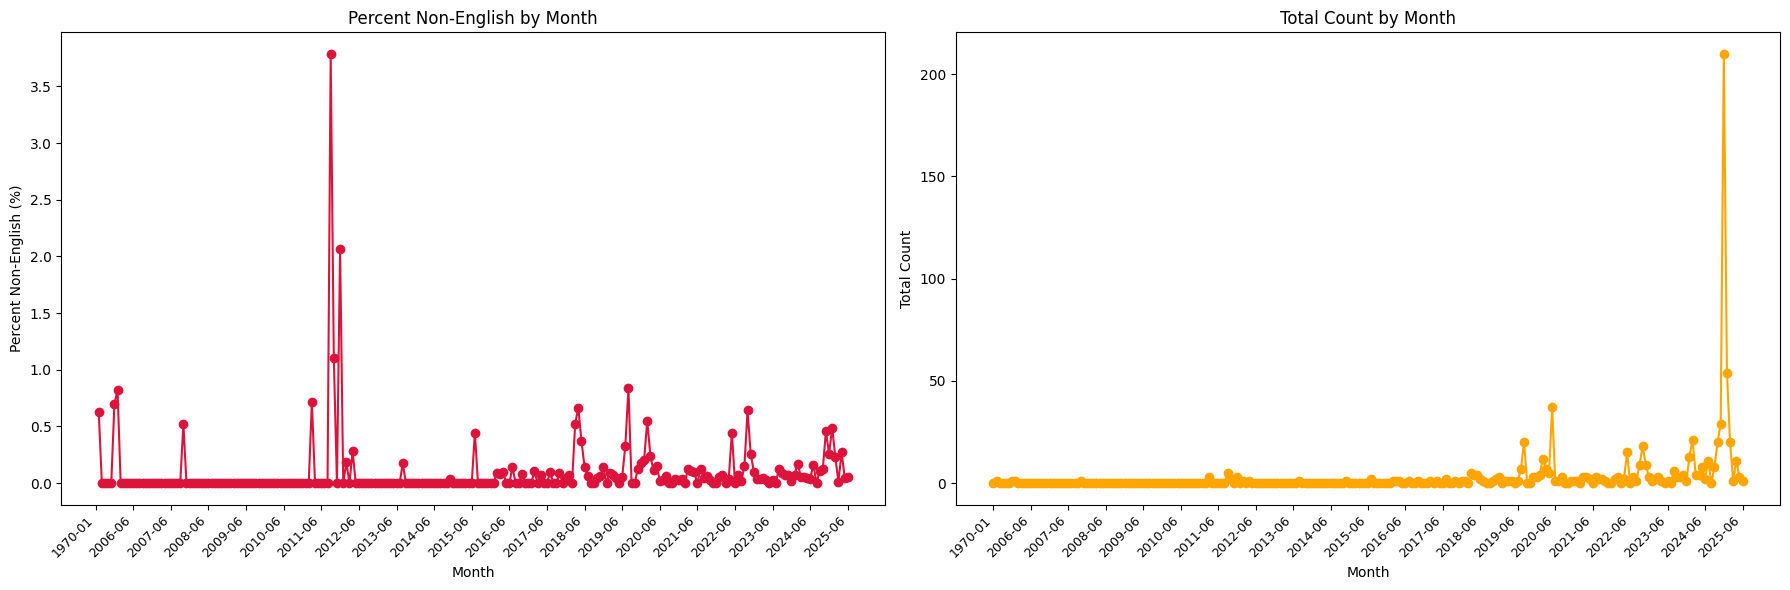

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv("function_stats_by_month.csv")

# Ensure month is sorted correctly
df = df.sort_values("month")

# Calculate percent_non_english
df["percent_non_english"] = df["non_english"] / (df["non_english"] + df["english"]) * 100

# Set up the figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot percent_non_english
axes[0].plot(df["month"], df["percent_non_english"], marker='o', color='crimson')
axes[0].set_title("Percent Non-English by Month")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Percent Non-English (%)")
axes[0].tick_params(axis='x', rotation=90)
step = max(1, len(df["month"]) // 20)
axes[0].set_xticks(range(0, len(df["month"]), step))
axes[0].set_xticklabels(df["month"].iloc[::step], rotation=45, ha='right', fontsize=9)
# axes[0].set_yscale('log')
# Plot total count
axes[1].plot(df["month"], df["non_english"], marker='o', color='orange')
axes[1].set_title("Total Count by Month")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Total Count")
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xticks(range(0, len(df["month"]), step))
axes[1].set_xticklabels(df["month"].iloc[::step], rotation=45, ha='right', fontsize=9)

plt.tight_layout()
plt.show()

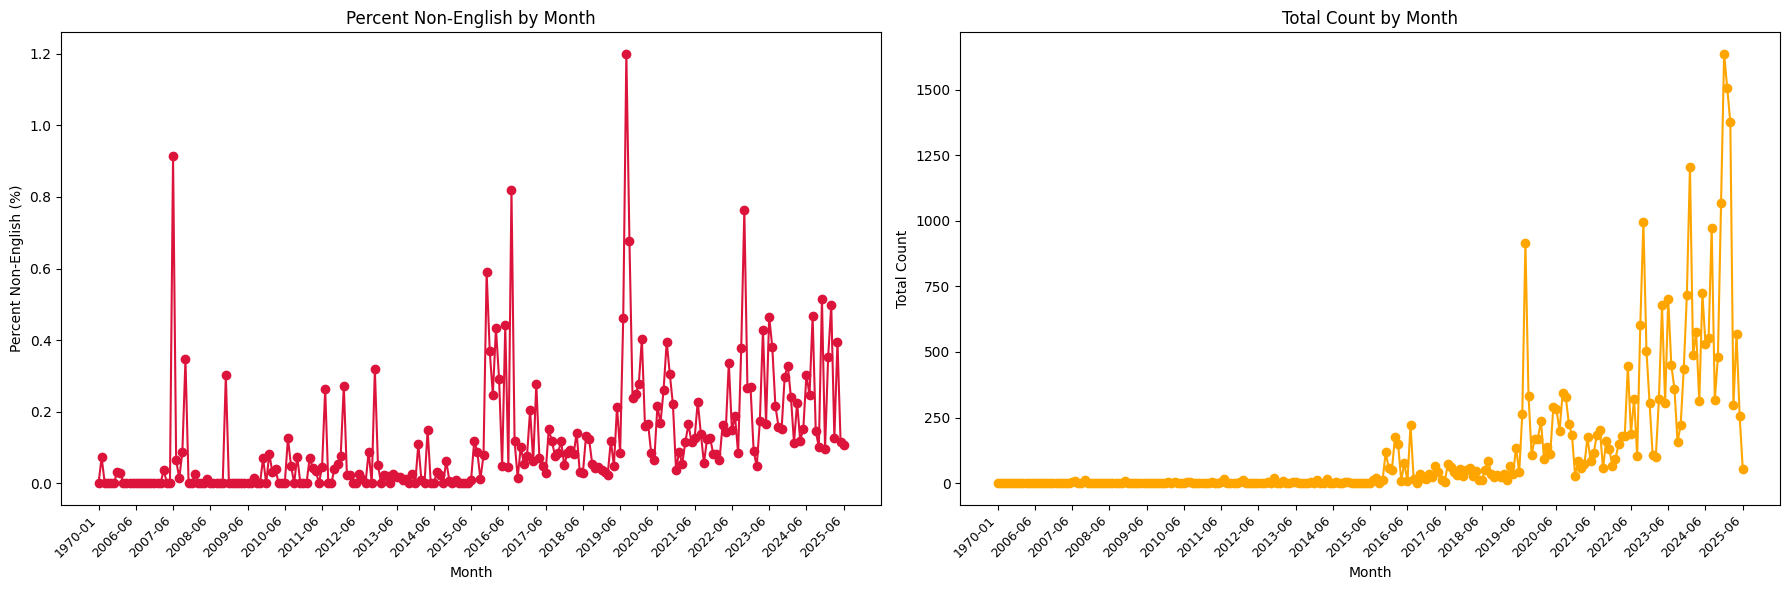

: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv("identifiers_stats_by_month.csv")

# Ensure month is sorted correctly
df = df.sort_values("month")

# Calculate percent_non_english
df["percent_non_english"] = df["non_english"] / (df["non_english"] + df["english"]) * 100

# Set up the figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot percent_non_english
axes[0].plot(df["month"], df["percent_non_english"], marker='o', color='crimson')
axes[0].set_title("Percent Non-English by Month")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Percent Non-English (%)")
axes[0].tick_params(axis='x', rotation=90)
step = max(1, len(df["month"]) // 20)
axes[0].set_xticks(range(0, len(df["month"]), step))
axes[0].set_xticklabels(df["month"].iloc[::step], rotation=45, ha='right', fontsize=9)

# Plot total count
axes[1].plot(df["month"], df["non_english"], marker='o', color='orange')
axes[1].set_title("Total Count by Month")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Total Count")
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xticks(range(0, len(df["month"]), step))
axes[1].set_xticklabels(df["month"].iloc[::step], rotation=45, ha='right', fontsize=9)

plt.tight_layout()
plt.show()

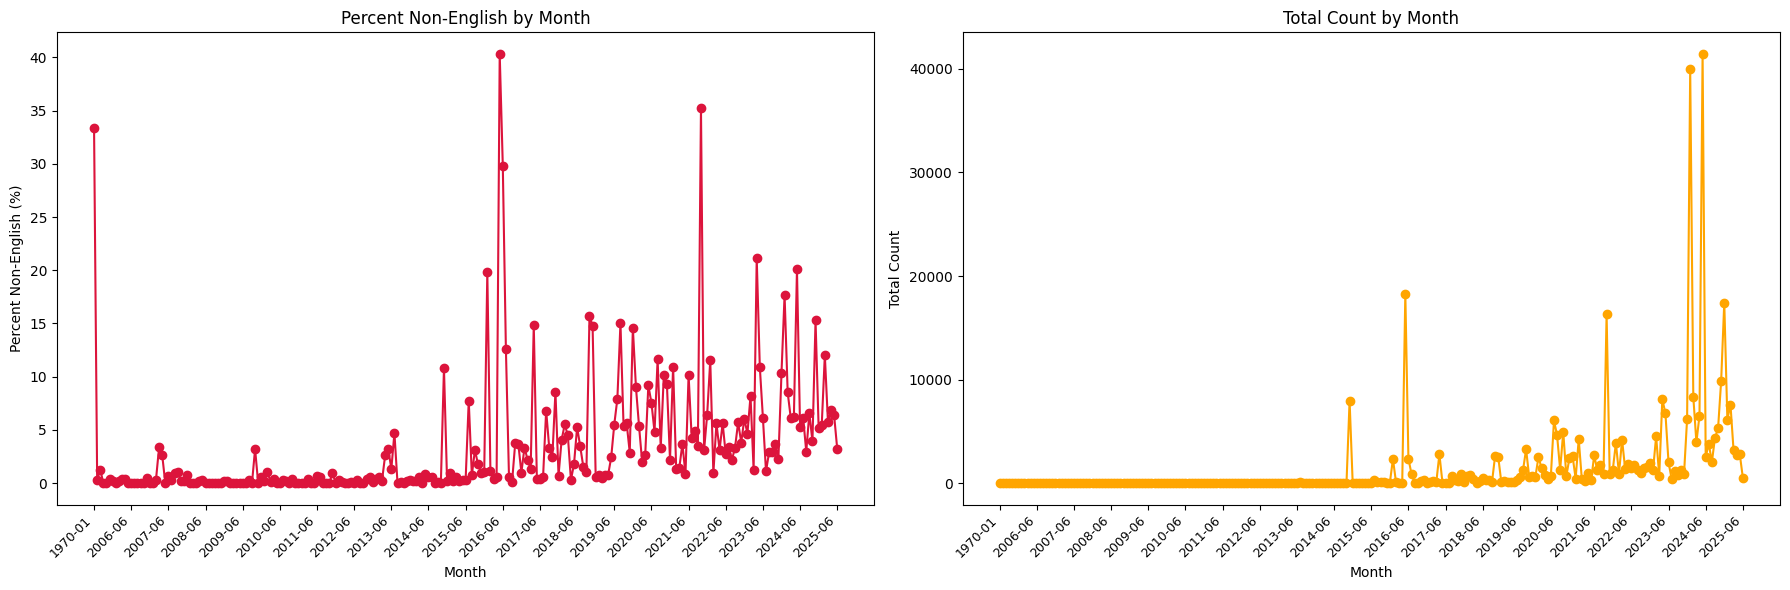

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv("literals_stats_by_month.csv")

# Ensure month is sorted correctly
df = df.sort_values("month")

# Calculate percent_non_english
df["percent_non_english"] = df["non_english"] / (df["non_english"] + df["english"]) * 100

# Set up the figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot percent_non_english
axes[0].plot(df["month"], df["percent_non_english"], marker='o', color='crimson')
axes[0].set_title("Percent Non-English by Month")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Percent Non-English (%)")
axes[0].tick_params(axis='x', rotation=90)
step = max(1, len(df["month"]) // 20)
axes[0].set_xticks(range(0, len(df["month"]), step))
axes[0].set_xticklabels(df["month"].iloc[::step], rotation=45, ha='right', fontsize=9)

# Plot total count
axes[1].plot(df["month"], df["non_english"], marker='o', color='orange')
axes[1].set_title("Total Count by Month")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Total Count")
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xticks(range(0, len(df["month"]), step))
axes[1].set_xticklabels(df["month"].iloc[::step], rotation=45, ha='right', fontsize=9)

plt.tight_layout()
plt.show()

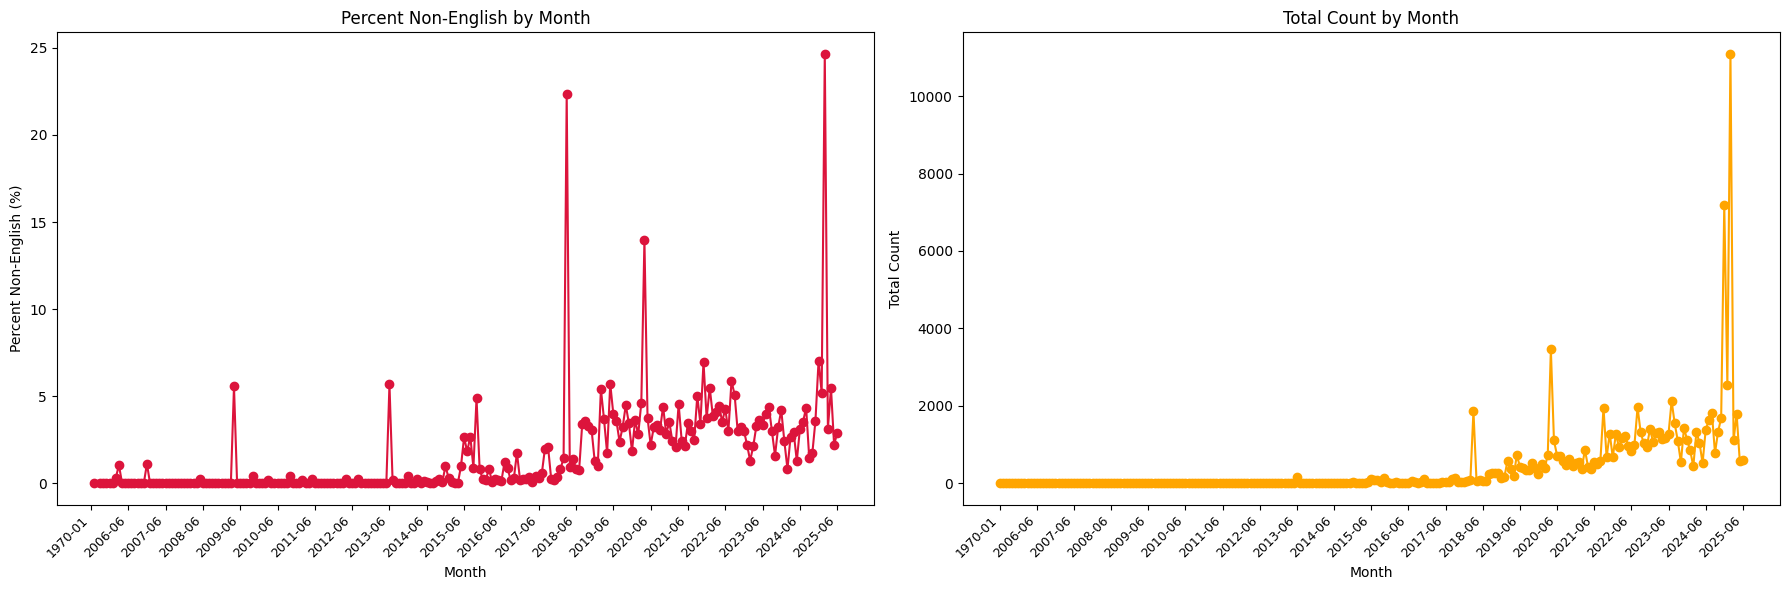

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv("language_stats_by_month.csv")

# Ensure month is sorted correctly
df = df.sort_values("month")

# Calculate percent_non_english
df["percent_non_english"] = df["non_english"] / (df["non_english"] + df["english"]) * 100

# Set up the figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot percent_non_english
axes[0].plot(df["month"], df["percent_non_english"], marker='o', color='crimson')
axes[0].set_title("Percent Non-English by Month")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Percent Non-English (%)")
axes[0].tick_params(axis='x', rotation=90)
step = max(1, len(df["month"]) // 20)
axes[0].set_xticks(range(0, len(df["month"]), step))
axes[0].set_xticklabels(df["month"].iloc[::step], rotation=45, ha='right', fontsize=9)

# Plot total count
axes[1].plot(df["month"], df["non_english"], marker='o', color='orange')
axes[1].set_title("Total Count by Month")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Total Count")
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xticks(range(0, len(df["month"]), step))
axes[1].set_xticklabels(df["month"].iloc[::step], rotation=45, ha='right', fontsize=9)

plt.tight_layout()
plt.show()

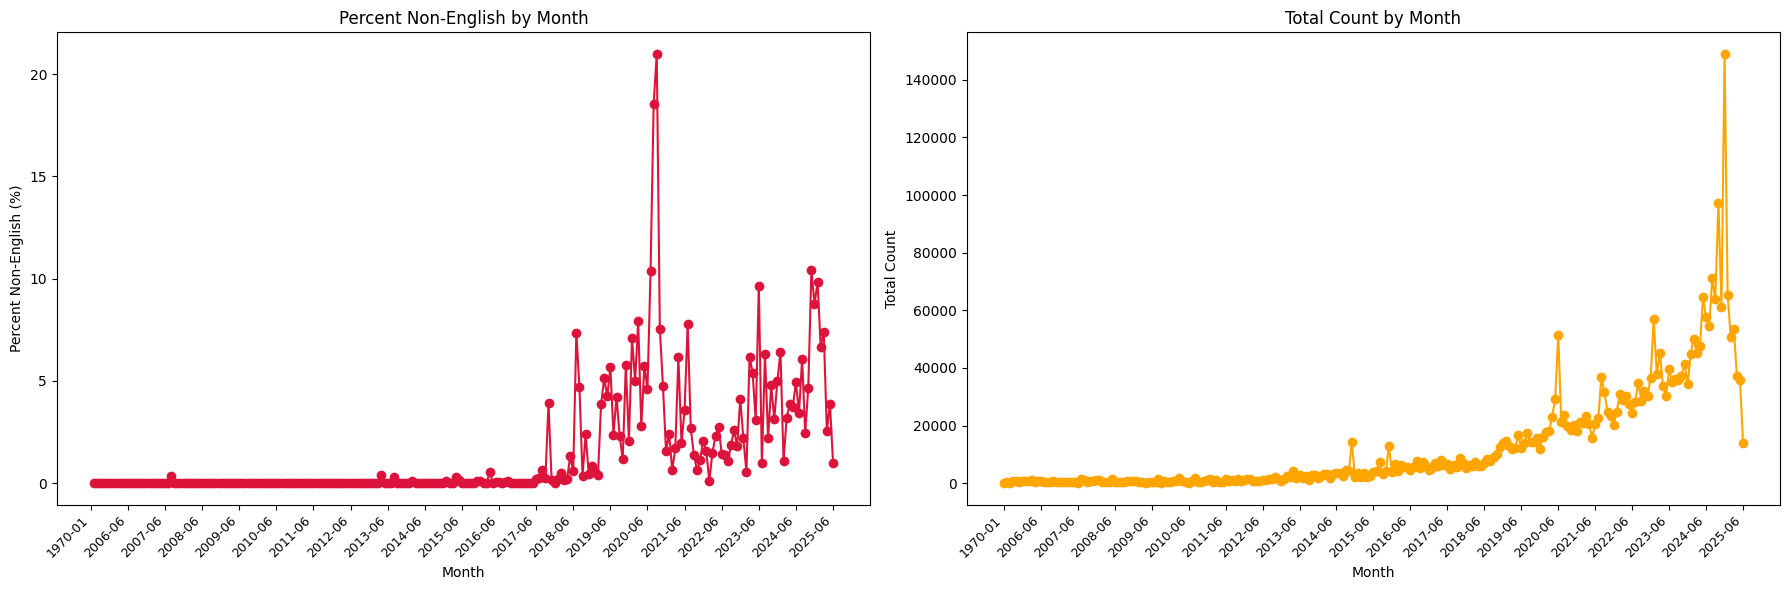

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv("comments_stats_by_month.csv")

# Ensure month is sorted correctly
df = df.sort_values("month")

# Calculate percent_non_english
df["percent_non_english"] = df["non_english"] / (df["non_english"] + df["english"]) * 100

# Set up the figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot percent_non_english
axes[0].plot(df["month"], df["percent_non_english"], marker='o', color='crimson')
axes[0].set_title("Percent Non-English by Month")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Percent Non-English (%)")
axes[0].tick_params(axis='x', rotation=90)
step = max(1, len(df["month"]) // 20)
axes[0].set_xticks(range(0, len(df["month"]), step))
axes[0].set_xticklabels(df["month"].iloc[::step], rotation=45, ha='right', fontsize=9)

# Plot total count
axes[1].plot(df["month"], df["total"], marker='o', color='orange')
axes[1].set_title("Total Count by Month")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Total Count")
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xticks(range(0, len(df["month"]), step))
axes[1].set_xticklabels(df["month"].iloc[::step], rotation=45, ha='right', fontsize=9)

plt.tight_layout()
plt.show()

In [5]:
import pandas as pd
from glob import glob

# years = [2015, 2016, 2017, 2018, 2022]
years = [2025]
for year in years:
    all_dfs = []
    
    for month in range(1, 13):
        for day in range(1, 32):
            try:
                file_path = f"result_files/gharchive_event_counts_{year}_{month:02d}_{day:02d}.csv"
                df = pd.read_csv(file_path)
                
                # Drop 'day' column if it exists
                if 'day' in df.columns:
                    df = df.drop(columns=['day'])
                # if year==2017:
                    # print(f"Processing {file_path} with {len(df)} rows and {len(df.columns)} columns.")
                if year in [2015, 2016, 2018, 2017] and len(df.columns) == 14:
                    all_dfs.append(df)
                elif year in [2022] and len(df.columns) == 15:
                    all_dfs.append(df)
                # else:
                #     print(f"Skipping {file_path} due to unexpected number of columns: {df.columns}")
            except FileNotFoundError:
                continue
            except pd.errors.EmptyDataError:
                continue

    if all_dfs:
        # Reorder all columns to match the first DataFrame
        base_columns = all_dfs[0].columns
        # print(base_columns)
        merged_df = pd.concat([df[base_columns] for df in all_dfs], ignore_index=True)

        # Save merged yearly data
        merged_df.to_csv(f"gharchive_event_counts_{year}.csv", index=False)
        print(f"Saved merged data for {year} with {len(merged_df)} rows.")
    else:
        print(f"No data found for {year}.")


No data found for 2025.


In [13]:
import pandas as pd
from glob import glob

# years = [2015, 2016, 2017, 2018, 2022]
years = [2025]
for year in years:
    all_dfs = []
    
    for month in range(1, 13):
        # for day in range(1, 32):
        try:
            file_path = f"gharchive_event_counts_{year}_{month:02d}.csv"
            df = pd.read_csv(file_path)
            # print(df.columns)
            # Drop 'day' column if it exists
            if 'day' in df.columns:
                df = df.drop(columns=['day'])
            if 'Unnamed: 0' in df.columns:
                df = df.drop(columns=['Unnamed: 0'])
            # if year==2017:
            # print(f"Processing {file_path} with {len(df)} rows and {len(df.columns)} columns.")
            if year in [2015, 2016, 2018, 2017] and len(df.columns) == 14:
                all_dfs.append(df)
            elif year in [2019, 2022, 2025] and len(df.columns) == 15:
                all_dfs.append(df)
            else:
                print(f"Skipping {file_path} due to unexpected number of columns: {df.columns}")
        except FileNotFoundError:
            continue
        except pd.errors.EmptyDataError:
            continue

    if all_dfs:
        # Reorder all columns to match the first DataFrame
        base_columns = all_dfs[0].columns
        # print(base_columns)
        merged_df = pd.concat([df[base_columns] for df in all_dfs], ignore_index=True)

        # Save merged yearly data
        merged_df.to_csv(f"gharchive_event_counts_{year}.csv", index=False)
        print(f"Saved merged data for {year} with {len(merged_df)} rows.")
    else:
        print(f"No data found for {year}.")


Skipping gharchive_event_counts_2025_03.csv due to unexpected number of columns: Index([], dtype='object')
Skipping gharchive_event_counts_2025_04.csv due to unexpected number of columns: Index([], dtype='object')
Skipping gharchive_event_counts_2025_05.csv due to unexpected number of columns: Index([], dtype='object')
Skipping gharchive_event_counts_2025_06.csv due to unexpected number of columns: Index([], dtype='object')
Skipping gharchive_event_counts_2025_07.csv due to unexpected number of columns: Index([], dtype='object')
Skipping gharchive_event_counts_2025_08.csv due to unexpected number of columns: Index([], dtype='object')
Skipping gharchive_event_counts_2025_09.csv due to unexpected number of columns: Index([], dtype='object')
Skipping gharchive_event_counts_2025_10.csv due to unexpected number of columns: Index([], dtype='object')
Skipping gharchive_event_counts_2025_11.csv due to unexpected number of columns: Index([], dtype='object')
Skipping gharchive_event_counts_2025_

In [ ]:
import os
import gzip
import json
from collections import defaultdict
import pandas as pd
from lingua import Language, LanguageDetectorBuilder
import regex as re


def clean_body_text(text):
    if not text:
        return ""

    lines = text.splitlines()
    cleaned_lines = []

    for line in lines:
        # Skip lines with URLs or image markdown
        if re.search(r'https?://\S+|www\.\S+', line):
            continue
        if re.search(r'!\[.*?\]\(.*?\)', line):
            continue

        # Remove markdown links but keep visible text
        line = re.sub(r'\[([^\]]+)\]\([^)]+\)', r'\1', line)

        # Remove inline and fenced code blocks
        line = re.sub(r'`{1,3}[^`]+`{1,3}', '', line)
        line = re.sub(r'```[\s\S]+?```', '', line)

        # Remove emojis and other symbols
        line = re.sub(r'[^\p{L}\p{N}\s.,!?\'\"-]', '', line)

        cleaned_lines.append(line.strip())

    return ' '.join(cleaned_lines).strip()


def get_unicode_and_script(text):
    # Comprehensive list of Unicode block ranges and their associated scripts
    # Covers major blocks from Unicode 15.1; includes most scripts and some symbol blocks
    unicode_blocks = [
        ((0x0000, 0x007F), "Latin (Basic Latin)"),
        ((0x0080, 0x00FF), "Latin (Latin-1 Supplement)"),
        ((0x0100, 0x017F), "Latin (Latin Extended-A)"),
        ((0x0180, 0x024F), "Latin (Latin Extended-B)"),
        ((0x0250, 0x02AF), "IPA Extensions"),
        ((0x02B0, 0x02FF), "Spacing Modifier Letters"),
        ((0x0300, 0x036F), "Combining Diacritical Marks"),
        ((0x0370, 0x03FF), "Greek and Coptic"),
        ((0x0400, 0x04FF), "Cyrillic"),
        ((0x0500, 0x052F), "Cyrillic Supplement"),
        ((0x0530, 0x058F), "Armenian"),
        ((0x0590, 0x05FF), "Hebrew"),
        ((0x0600, 0x06FF), "Arabic"),
        ((0x0700, 0x074F), "Syriac"),
        ((0x0750, 0x077F), "Arabic Supplement"),
        ((0x0780, 0x07BF), "Thaana"),
        ((0x07C0, 0x07FF), "NKo"),
        ((0x0800, 0x083F), "Samaritan"),
        ((0x0840, 0x085F), "Mandaic"),
        ((0x0860, 0x086F), "Syriac Supplement"),
        ((0x08A0, 0x08FF), "Arabic Extended-A"),
        ((0x0900, 0x097F), "Devanagari"),
        ((0x0980, 0x09FF), "Bengali"),
        ((0x0A00, 0x0A7F), "Gurmukhi"),
        ((0x0A80, 0x0AFF), "Gujarati"),
        ((0x0B00, 0x0B7F), "Oriya"),
        ((0x0B80, 0x0BFF), "Tamil"),
        ((0x0C00, 0x0C7F), "Telugu"),
        ((0x0C80, 0x0CFF), "Kannada"),
        ((0x0D00, 0x0D7F), "Malayalam"),
        ((0x0D80, 0x0DFF), "Sinhala"),
        ((0x0E00, 0x0E7F), "Thai"),
        ((0x0E80, 0x0EFF), "Lao"),
        ((0x0F00, 0x0FFF), "Tibetan"),
        ((0x1000, 0x109F), "Myanmar"),
        ((0x10A0, 0x10FF), "Georgian"),
        ((0x1100, 0x11FF), "Hangul Jamo"),
        ((0x1200, 0x137F), "Ethiopic"),
        ((0x1380, 0x139F), "Ethiopic Supplement"),
        ((0x13A0, 0x13FF), "Cherokee"),
        ((0x1400, 0x167F), "Unified Canadian Aboriginal Syllabics"),
        ((0x1680, 0x169F), "Ogham"),
        ((0x16A0, 0x16FF), "Runic"),
        ((0x1700, 0x171F), "Tagalog"),
        ((0x1720, 0x173F), "Hanunoo"),
        ((0x1740, 0x175F), "Buhid"),
        ((0x1760, 0x177F), "Tagbanwa"),
        ((0x1780, 0x17FF), "Khmer"),
        ((0x1800, 0x18AF), "Mongolian"),
        ((0x18B0, 0x18FF), "Unified Canadian Aboriginal Syllabics Extended"),
        ((0x1900, 0x194F), "Limbu"),
        ((0x1950, 0x197F), "Tai Le"),
        ((0x1980, 0x19DF), "New Tai Lue"),
        ((0x19E0, 0x19FF), "Khmer Symbols"),
        ((0x1A00, 0x1A1F), "Buginese"),
        ((0x1A20, 0x1AAF), "Tai Tham"),
        ((0x1AB0, 0x1AFF), "Combining Diacritical Marks Extended"),
        ((0x1B00, 0x1B7F), "Balinese"),
        ((0x1B80, 0x1BBF), "Sundanese"),
        ((0x1BC0, 0x1BFF), "Batak"),
        ((0x1C00, 0x1C4F), "Lepcha"),
        ((0x1C50, 0x1C7F), "Ol Chiki"),
        ((0x1C80, 0x1C8F), "Cyrillic Extended-C"),
        ((0x1CC0, 0x1CCF), "Sundanese Supplement"),
        ((0x1CD0, 0x1CFF), "Vedic Extensions"),
        ((0x1D00, 0x1D7F), "Phonetic Extensions"),
        ((0x1D80, 0x1DBF), "Phonetic Extensions Supplement"),
        ((0x1DC0, 0x1DFF), "Combining Diacritical Marks Supplement"),
        ((0x1E00, 0x1EFF), "Latin Extended Additional"),
        ((0x1F00, 0x1FFF), "Greek Extended"),
        ((0x2000, 0x206F), "General Punctuation"),
        ((0x2070, 0x209F), "Superscripts and Subscripts"),
        ((0x20A0, 0x20CF), "Currency Symbols"),
        ((0x20D0, 0x20FF), "Combining Diacritical Marks for Symbols"),
        ((0x2100, 0x214F), "Letterlike Symbols"),
        ((0x2150, 0x218F), "Number Forms"),
        ((0x2190, 0x21FF), "Arrows"),
        ((0x2200, 0x22FF), "Mathematical Operators"),
        ((0x2300, 0x23FF), "Miscellaneous Technical"),
        ((0x2400, 0x243F), "Control Pictures"),
        ((0x2440, 0x245F), "Optical Character Recognition"),
        ((0x2460, 0x24FF), "Enclosed Alphanumerics"),
        ((0x2500, 0x257F), "Box Drawing"),
        ((0x2580, 0x259F), "Block Elements"),
        ((0x25A0, 0x25FF), "Geometric Shapes"),
        ((0x2600, 0x26FF), "Miscellaneous Symbols"),
        ((0x2700, 0x27BF), "Dingbat"),
        ((0x27C0, 0x27EF), "Miscellaneous Mathematical Symbols-A"),
        ((0x27F0, 0x27FF), "Supplemental Arrows-A"),
        ((0x2800, 0x28FF), "Braille Patterns"),
        ((0x2900, 0x297F), "Supplemental Arrows-B"),
        ((0x2980, 0x29FF), "Miscellaneous Mathematical Symbols-B"),
        ((0x2A00, 0x2AFF), "Supplemental Mathematical Operators"),
        ((0x2B00, 0x2BFF), "Miscellaneous Symbols and Arrows"),
        ((0x2C00, 0x2C5F), "Glagolitic"),
        ((0x2C60, 0x2C7F), "Latin Extended-C"),
        ((0x2C80, 0x2CFF), "Coptic"),
        ((0x2D00, 0x2D2F), "Georgian Supplement"),
        ((0x2D30, 0x2D7F), "Tifinagh"),
        ((0x2D80, 0x2DDF), "Ethiopic Extended"),
        ((0x2DE0, 0x2DFF), "Cyrillic Extended-A"),
        ((0x2E00, 0x2E7F), "Supplemental Punctuation"),
        ((0x2E80, 0x2EFF), "CJK Radicals Supplement"),
        ((0x2F00, 0x2FDF), "Kangxi Radicals"),
        ((0x2FF0, 0x2FFF), "Ideographic Description Characters"),
        ((0x3000, 0x303F), "CJK Symbols and Punctuation"),
        ((0x3040, 0x309F), "Hiragana (Japanese)"),
        ((0x30A0, 0x30FF), "Katakana (Japanese)"),
        ((0x3100, 0x312F), "Bopomofo"),
        ((0x3130, 0x318F), "Hangul Compatibility Jamo"),
        ((0x3190, 0x319F), "Kanbun"),
        ((0x31A0, 0x31BF), "Bopomofo Extended"),
        ((0x31C0, 0x31EF), "CJK Strokes"),
        ((0x31F0, 0x31FF), "Katakana Phonetic Extensions"),
        ((0x3200, 0x32FF), "Enclosed CJK Letters and Months"),
        ((0x3300, 0x33FF), "CJK Compatibility"),
        ((0x3400, 0x4DBF), "CJK Unified Ideographs Extension A"),
        ((0x4DC0, 0x4DFF), "Yijing Hexagram Symbols"),
        ((0x4E00, 0x9FFF), "CJK Unified Ideographs (Chinese, Japanese, Korean)"),
        ((0xA000, 0xA48F), "Yi Syllables"),
        ((0xA490, 0xA4CF), "Yi Radicals"),
        ((0xA4D0, 0xA4FF), "Lisu"),
        ((0xA500, 0xA63F), "Vai"),
        ((0xA640, 0xA69F), "Cyrillic Extended-B"),
        ((0xA6A0, 0xA6FF), "Bamum"),
        ((0xA700, 0xA71F), "Modifier Tone Letters"),
        ((0xA720, 0xA7FF), "Latin Extended-D"),
        ((0xA800, 0xA82F), "Syloti Nagri"),
        ((0xA830, 0xA83F), "Common Indic Number Forms"),
        ((0xA840, 0xA87F), "Phags-pa"),
        ((0xA880, 0xA8DF), "Saurashtra"),
        ((0xA8E0, 0xA8FF), "Devanagari Extended"),
        ((0xA900, 0xA92F), "Kayah Li"),
        ((0xA930, 0xA95F), "Rejang"),
        ((0xA960, 0xA97F), "Hangul Jamo Extended-A"),
        ((0xA980, 0xA9DF), "Javanese"),
        ((0xA9E0, 0xA9FF), "Myanmar Extended-B"),
        ((0xAA00, 0xAA5F), "Cham"),
        ((0xAA60, 0xAA7F), "Myanmar Extended-A"),
        ((0xAA80, 0xAADF), "Tai Viet"),
        ((0xAAE0, 0xAAFF), "Meetei Mayek Extensions"),
        ((0xAB00, 0xAB2F), "Ethiopic Extended-A"),
        ((0xAB30, 0xAB6F), "Latin Extended-E"),
        ((0xAB70, 0xABBF), "Cherokee Supplement"),
        ((0xABC0, 0xABFF), "Meetei Mayek"),
        ((0xAC00, 0xD7A3), "Hangul Syllables (Korean)"),
        ((0xD7B0, 0xD7FF), "Hangul Jamo Extended-B"),
        ((0xD800,0xDBFF), "High Surrogates"),
        ((0xDC00, 0xDFFF), "Low Surrogates"),
        ((0xE000, 0xF8FF), "Private Use Area"),
        ((0xF900, 0xFAFF), "CJK Compatibility Ideographs"),
        ((0xFB00, 0xFB4F), "Alphabetic Presentation Forms"),
        ((0xFB50, 0xFDFF), "Arabic Presentation Forms-A"),
        ((0xFE00, 0xFE0F), "Variation Selectors"),
        ((0xFE10, 0xFE1F), "Vertical Forms"),
        ((0xFE20, 0xFE2F), "Combining Half Marks"),
        ((0xFE30, 0xFE4F), "CJK Compatibility Forms"),
        ((0xFE50, 0xFE6F), "Small Form Variants"),
        ((0xFE70, 0xFEFF), "Arabic Presentation Forms-B"),
        ((0xFF00, 0xFFEF), "Halfwidth and Fullwidth Forms"),
        ((0xFFF0, 0xFFFF), "Specials"),
        ((0x10000, 0x1007F), "Linear B Syllabary"),
        ((0x10080, 0x100FF), "Linear B Ideograms"),
        ((0x10100, 0x1013F), "Aegean Numbers"),
        ((0x10140, 0x1018F), "Ancient Greek Numbers"),
        ((0x10190, 0x101CF), "Ancient Symbols"),
        ((0x101D0, 0x101FF), "Phaistos Disc"),
        ((0x10280, 0x1029F), "Lycian"),
        ((0x102A0, 0x102DF), "Carian"),
        ((0x102E0, 0x102FF), "Coptic Epact Numbers"),
        ((0x10300, 0x1032F), "Old Italic"),
        ((0x10330, 0x1034F), "Gothic"),
        ((0x10350, 0x1037F), "Old Permic"),
        ((0x10380, 0x1039F), "Ugaritic"),
        ((0x103A0, 0x103DF), "Old Persian"),
        ((0x10400, 0x1044F), "Deseret"),
        ((0x10450, 0x1047F), "Shavian"),
        ((0x10480, 0x104AF), "Osmanya"),
        ((0x104B0, 0x104FF), "Osage"),
        ((0x10500, 0x1052F), "Elbasan"),
        ((0x10530, 0x1056F), "Caucasian Albanian"),
        ((0x10570, 0x105BF), "Vithkuqi"),
        ((0x10600, 0x1077F), "Linear A"),
        ((0x10800, 0x1083F), "Cypriot Syllabary"),
        ((0x10840, 0x1085F), "Imperial Aramaic"),
        ((0x10860, 0x1087F), "Palmyrene"),
        ((0x10880, 0x108AF), "Nabataean"),
        ((0x108E0, 0x108FF), "Hatran"),
        ((0x10900, 0x1091F), "Phoenician"),
        ((0x10920, 0x1093F), "Lydian"),
        ((0x10980, 0x1099F), "Meroitic Hieroglyphs"),
        ((0x109A0, 0x109FF), "Meroitic Cursive"),
        ((0x10A00, 0x10A5F), "Kharoshthi"),
        ((0x10A60, 0x10A7F), "Old South Arabian"),
        ((0x10A80, 0x10A9F), "Old North Arabian"),
        ((0x10AC0, 0x10AFF), "Manichaean"),
        ((0x10B00, 0x10B3F), "Avestan"),
        ((0x10B40, 0x10B5F), "Inscriptional Parthian"),
        ((0x10B60, 0x10B7F), "Inscriptional Pahlavi"),
        ((0x10B80, 0x10BAF), "Psalter Pahlavi"),
        ((0x10C00, 0x10C4F), "Old Turkic"),
        ((0x10C80, 0x10CFF), "Old Hungarian"),
        ((0x10D00, 0x10D3F), "Hanifi Rohingya"),
        ((0x10E60, 0x10E7F), "Rumi Numeral Symbols"),
        ((0x10E80, 0x10EBF), "Yezidi"),
        ((0x10F00, 0x10F2F), "Old Sogdian"),
        ((0x10F30, 0x10F6F), "Sogdian"),
        ((0x10F70, 0x10FAF), "Old Uyghur"),
        ((0x10FB0, 0x10FDF), "Chorasmian"),
        ((0x10FE0, 0x10FFF), "Elymaic"),
        ((0x11000, 0x1107F), "Brahmi"),
        ((0x11080, 0x110CF), "Kaithi"),
        ((0x110D0, 0x110FF), "Sora Sompeng"),
        ((0x11100, 0x1114F), "Chakma"),
        ((0x11150, 0x1117F), "Mahajani"),
        ((0x11180, 0x111DF), "Sharada"),
        ((0x111E0, 0x111FF), "Sinhala Archaic Numbers"),
        ((0x11200, 0x1124F), "Khojki"),
        ((0x11280, 0x112AF), "Multani"),
        ((0x112B0, 0x112FF), "Khudawadi"),
        ((0x11300, 0x1137F), "Grantha"),
        ((0x11400, 0x1147F), "Newa"),
        ((0x11480, 0x114DF), "Tirhuta"),
        ((0x11580, 0x115FF), "Siddham"),
        ((0x11600, 0x1165F), "Modi"),
        ((0x11660, 0x1167F), "Mongolian Supplement"),
        ((0x11680, 0x116CF), "Takri"),
        ((0x11700, 0x1174F), "Ahom"),
        ((0x11800, 0x1184F), "Dogra"),
        ((0x11850, 0x1187F), "Dives Akuru"),
        ((0x11900, 0x1195F), "Nandinagari"),
        ((0x119A0, 0x119FF), "Zanabazar Square"),
        ((0x11A00, 0x11A4F), "Soyombo"),
        ((0x11A50, 0x11AAF), "Pau Cin Hau"),
        ((0x11AB0, 0x11ABF), "Unified Canadian Aboriginal Syllabics Extended-A"),
        ((0x11AC0, 0x11AFF), "Bhaiksuki"),
        ((0x11C00, 0x11C6F), "Marchen"),
        ((0x11C70, 0x11CBF), "Masaram Gondi"),
        ((0x11D00, 0x11D5F), "Gunjala Gondi"),
        ((0x11D60, 0x11DAF), "Makasar"),
        ((0x11EE0, 0x11EFF), "Lisu Supplement"),
        ((0x11FB0, 0x11FBF), "Kaktovik Numerals"),
        ((0x12000, 0x123FF), "Cuneiform"),
        ((0x12400, 0x1247F), "Cuneiform Numbers and Punctuation"),
        ((0x12480, 0x1254F), "Early Dynastic Cuneiform"),
        ((0x12F90, 0x12FFF), "Cypro-Minoan"),
        ((0x13000, 0x1342F), "Egyptian Hieroglyphs"),
        ((0x13430, 0x1345F), "Egyptian Hieroglyph Format Controls"),
        ((0x14400, 0x1467F), "Anatolian Hieroglyphs"),
        ((0x16800, 0x16A3F), "Bamum Supplement"),
        ((0x16A40, 0x16A6F), "Mro"),
        ((0x16A70, 0x16ACF), "Tangsa"),
        ((0x16AD0, 0x16AFF), "Bassa Vah"),
        ((0x16B00, 0x16B8F), "Pahawh Hmong"),
        ((0x16E40, 0x16E9F), "Medefaidrin"),
        ((0x16F00, 0x16F9F), "Miao"),
        ((0x16FE0, 0x16FFF), "Ideographic Symbols and Punctuation"),
        ((0x17000, 0x187FF), "Tangut"),
        ((0x18800, 0x18AFF), "Tangut Components"),
        ((0x18B00, 0x18CFF), "Khitan Small Script"),
        ((0x18D00, 0x18D7F), "Tangut Supplement"),
        ((0x1AFF0, 0x1AFFF), "Kana Extended-B"),
        ((0x1B000, 0x1B0FF), "Kana Supplement"),
        ((0x1B100, 0x1B12F), "Kana Extended-A"),
        ((0x1B130, 0x1B16F), "Small Kana Extension"),
        ((0x1B170, 0x1B2FF), "Nushu"),
        ((0x1BC00, 0x1BC9F), "Duployan"),
        ((0x1BCA0, 0x1BCAF), "Shorthand Format Controls"),
        ((0x1CF00, 0x1CFCF), "Znamenny Musical Notation"),
        ((0x1D000, 0x1D0FF), "Byzantine Musical Symbols"),
        ((0x1D100, 0x1D1FF), "Musical Symbols"),
        ((0x1D200, 0x1D24F), "Ancient Greek Musical Notation"),
        ((0x1D2C0, 0x1D2DF), "Kaktovik Numerals"),
        ((0x1D2E0, 0x1D2FF), "Mayan Numerals"),
        ((0x1D300, 0x1D35F), "Tai Xuan Jing Symbols"),
        ((0x1D360, 0x1D37F), "Counting Rod Numerals"),
        ((0x1D400, 0x1D7FF), "Mathematical Alphanumeric Symbols"),
        ((0x1D800, 0x1DAAF), "Sutton SignWriting"),
        ((0x1DF00, 0x1DFFF), "Latin Extended-G"),
        ((0x1E000, 0x1E02F), "Glagolitic Supplement"),
        ((0x1E030, 0x1E06F), "Nyiakeng Puachue Hmong"),
        ((0x1E100, 0x1E14F), "Toto"),
        ((0x1E2C0, 0x1E2FF), "Wancho"),
        ((0x1E4D0, 0x1E4FF), "Nag Mundari"),
        ((0x1E7E0, 0x1E7FF), "Ethiopic Extended-B"),
        ((0x1E800, 0x1E8DF), "Mende Kikakui"),
        ((0x1E900, 0x1E95F), "Adlam"),
        ((0x1EC70, 0x1ECBF), "Indic Siyaq Numbers"),
        ((0x1ED00, 0x1ED4F), "Ottoman Siyaq Numbers"),
        ((0x1EE00, 0x1EEFF), "Arabic Mathematical Alphabetic Symbols"),
        ((0x1F000, 0x1F02F), "Mahjong Tiles"),
        ((0x1F030, 0x1F09F), "Domino Tiles"),
        ((0x1F0A0, 0x1F0FF), "Playing Cards"),
        ((0x1F100, 0x1F1FF), "Enclosed Alphanumeric Supplement"),
        ((0x1F200, 0x1F2FF), "Enclosed Ideographic Supplement"),
        ((0x1F300, 0x1F5FF), "Miscellaneous Symbols and Pictographs"),
        ((0x1F600, 0x1F64F), "Emoticons"),
        ((0x1F650, 0x1F67F), "Ornamental Dingbats"),
        ((0x1F680, 0x1F6FF), "Transport and Map Symbols"),
        ((0x1F700, 0x1F77F), "Alchemical Symbols"),
        ((0x1F780, 0x1F7FF), "Geometric Shapes Extended"),
        ((0x1F800, 0x1F8FF), "Supplemental Arrows-C"),
        ((0x1F900, 0x1F9FF), "Supplemental Symbols and Pictographs"),
        ((0x1FA00, 0x1FA6F), "Chess Symbols"),
        ((0x1FA70, 0x1FAFF), "Symbols and Pictographs Extended-A"),
        ((0x1FB00, 0x1FBFF), "Symbols for Legacy Computing")
    ]

    results = []
    for char in text:
        # Get Unicode code point
        unicode_point = ord(char)
        unicode_hex = f"U+{unicode_point:04X}"
        
        # Find the script by checking Unicode block ranges
        script = "Unknown"
        for (start, end), script_name in unicode_blocks:
            if start <= unicode_point <= end:
                script = script_name
                break
        try:
            char_name = unicodedata.name(char)
        except ValueError:
            char_name = "Unnamed character"
        
        results.append(script)
    
    return set(results)

detector = LanguageDetectorBuilder.from_all_languages().build()

df = pd.read_csv("combined_non_english_ids_2025_01_01.csv")
ids = df['id'].tolist()


from multiprocessing import Pool, cpu_count
from functools import partial
from tqdm import tqdm

def process_hour(hour, year, month, day, download_dir, ids):
    local_counts = defaultdict(int)
    day_str = f"{year}-{month:02d}-{day:02d}"
    filename = f"{day_str}-{hour}.json.gz"
    filepath = os.path.join(download_dir, filename)

    try:
        with gzip.open(filepath, 'rt', encoding='utf-8') as f:
            for line in f:
                try:
                    event = json.loads(line)
                    event_type = event.get("type")
                    if event_type in {
                        "IssuesEvent", "IssueCommentEvent",
                        "PullRequestEvent", "PullRequestReviewEvent", "PullRequestReviewCommentEvent"
                    }:
                        if 'bot' not in event.get("actor", {}).get("login", ""):
                            payload = event.get("payload", {})
                            title = ""
                            body = ""
                            item_id = None
                            if event_type == "IssuesEvent":
                                issue = payload.get("issue", {})
                                title = issue.get("title", "")
                                body = issue.get("body", "")
                                item_id = issue.get("id", None)
                            elif event_type == "IssueCommentEvent":
                                issue = payload.get("comment", {})
                                title = issue.get("title", "")
                                body = issue.get("body", "")
                                item_id = issue.get("id", None)
                            elif event_type == "PullRequestReviewCommentEvent":
                                pr = payload.get("comment", {})
                                title = pr.get("title", "")
                                body = pr.get("body", "")
                                item_id = pr.get("id", None)
                            elif event_type == "PullRequestReviewEvent":
                                pr = payload.get("review", {})
                                title = pr.get("title", "")
                                body = pr.get("body", "")
                                item_id = pr.get("id", None)
                            elif event_type == "PullRequestEvent":
                                pr = payload.get("pull_request", {})
                                title = pr.get("title", "")
                                body = pr.get("body", "")
                                item_id = pr.get("id", None)

                            cleaned_body = clean_body_text(body)
                            message = f"{title} \n {cleaned_body}".strip()
                            if item_id and item_id in ids:
                                scripts = get_unicode_and_script(message)
                                for script in scripts:
                                    if "Latin" not in script:
                                        local_counts[script] += 1
                except Exception:
                    continue
    except Exception:
        return None
    return local_counts

# Parallel execution for 24 hours
if __name__ == "__main__":
    year = 2025
    month = 1
    day = 1
    download_dir = f"data/gharchive_{year}_{month:02d}"
    day_str = f"{year}-{month:02d}-{day:02d}"

    df = pd.read_csv("combined_non_english_ids_2025_01_01.csv")
    ids = df['id'].tolist()

    local_counts = defaultdict(int)

    func = partial(process_hour, year=year, month=month, day=day, download_dir=download_dir, ids=ids)

    with Pool(processes=min(cpu_count(), 24)) as pool:
        for result in tqdm(pool.imap_unordered(func, range(24)), total=24, desc="Processing hours"):
            if result:
                for k, v in result.items():
                    local_counts[k] += v

    print(f"\nLocal counts for {day_str}:")
    for script, count in sorted(local_counts.items(), key=lambda x: -x[1]):
        print(f"{script}: {count}")

In [ ]:
import unicodedata

def get_unicode_and_script(text):
    # Comprehensive list of Unicode block ranges and their associated scripts
    # Covers major blocks from Unicode 15.1; includes most scripts and some symbol blocks
    unicode_blocks = [
        ((0x0000, 0x007F), "Latin (Basic Latin)"),
        ((0x0080, 0x00FF), "Latin (Latin-1 Supplement)"),
        ((0x0100, 0x017F), "Latin (Latin Extended-A)"),
        ((0x0180, 0x024F), "Latin (Latin Extended-B)"),
        ((0x0250, 0x02AF), "IPA Extensions"),
        ((0x02B0, 0x02FF), "Spacing Modifier Letters"),
        ((0x0300, 0x036F), "Combining Diacritical Marks"),
        ((0x0370, 0x03FF), "Greek and Coptic"),
        ((0x0400, 0x04FF), "Cyrillic"),
        ((0x0500, 0x052F), "Cyrillic Supplement"),
        ((0x0530, 0x058F), "Armenian"),
        ((0x0590, 0x05FF), "Hebrew"),
        ((0x0600, 0x06FF), "Arabic"),
        ((0x0700, 0x074F), "Syriac"),
        ((0x0750, 0x077F), "Arabic Supplement"),
        ((0x0780, 0x07BF), "Thaana"),
        ((0x07C0, 0x07FF), "NKo"),
        ((0x0800, 0x083F), "Samaritan"),
        ((0x0840, 0x085F), "Mandaic"),
        ((0x0860, 0x086F), "Syriac Supplement"),
        ((0x08A0, 0x08FF), "Arabic Extended-A"),
        ((0x0900, 0x097F), "Devanagari"),
        ((0x0980, 0x09FF), "Bengali"),
        ((0x0A00, 0x0A7F), "Gurmukhi"),
        ((0x0A80, 0x0AFF), "Gujarati"),
        ((0x0B00, 0x0B7F), "Oriya"),
        ((0x0B80, 0x0BFF), "Tamil"),
        ((0x0C00, 0x0C7F), "Telugu"),
        ((0x0C80, 0x0CFF), "Kannada"),
        ((0x0D00, 0x0D7F), "Malayalam"),
        ((0x0D80, 0x0DFF), "Sinhala"),
        ((0x0E00, 0x0E7F), "Thai"),
        ((0x0E80, 0x0EFF), "Lao"),
        ((0x0F00, 0x0FFF), "Tibetan"),
        ((0x1000, 0x109F), "Myanmar"),
        ((0x10A0, 0x10FF), "Georgian"),
        ((0x1100, 0x11FF), "Hangul Jamo"),
        ((0x1200, 0x137F), "Ethiopic"),
        ((0x1380, 0x139F), "Ethiopic Supplement"),
        ((0x13A0, 0x13FF), "Cherokee"),
        ((0x1400, 0x167F), "Unified Canadian Aboriginal Syllabics"),
        ((0x1680, 0x169F), "Ogham"),
        ((0x16A0, 0x16FF), "Runic"),
        ((0x1700, 0x171F), "Tagalog"),
        ((0x1720, 0x173F), "Hanunoo"),
        ((0x1740, 0x175F), "Buhid"),
        ((0x1760, 0x177F), "Tagbanwa"),
        ((0x1780, 0x17FF), "Khmer"),
        ((0x1800, 0x18AF), "Mongolian"),
        ((0x18B0, 0x18FF), "Unified Canadian Aboriginal Syllabics Extended"),
        ((0x1900, 0x194F), "Limbu"),
        ((0x1950, 0x197F), "Tai Le"),
        ((0x1980, 0x19DF), "New Tai Lue"),
        ((0x19E0, 0x19FF), "Khmer Symbols"),
        ((0x1A00, 0x1A1F), "Buginese"),
        ((0x1A20, 0x1AAF), "Tai Tham"),
        ((0x1AB0, 0x1AFF), "Combining Diacritical Marks Extended"),
        ((0x1B00, 0x1B7F), "Balinese"),
        ((0x1B80, 0x1BBF), "Sundanese"),
        ((0x1BC0, 0x1BFF), "Batak"),
        ((0x1C00, 0x1C4F), "Lepcha"),
        ((0x1C50, 0x1C7F), "Ol Chiki"),
        ((0x1C80, 0x1C8F), "Cyrillic Extended-C"),
        ((0x1CC0, 0x1CCF), "Sundanese Supplement"),
        ((0x1CD0, 0x1CFF), "Vedic Extensions"),
        ((0x1D00, 0x1D7F), "Phonetic Extensions"),
        ((0x1D80, 0x1DBF), "Phonetic Extensions Supplement"),
        ((0x1DC0, 0x1DFF), "Combining Diacritical Marks Supplement"),
        ((0x1E00, 0x1EFF), "Latin Extended Additional"),
        ((0x1F00, 0x1FFF), "Greek Extended"),
        ((0x2000, 0x206F), "General Punctuation"),
        ((0x2070, 0x209F), "Superscripts and Subscripts"),
        ((0x20A0, 0x20CF), "Currency Symbols"),
        ((0x20D0, 0x20FF), "Combining Diacritical Marks for Symbols"),
        ((0x2100, 0x214F), "Letterlike Symbols"),
        ((0x2150, 0x218F), "Number Forms"),
        ((0x2190, 0x21FF), "Arrows"),
        ((0x2200, 0x22FF), "Mathematical Operators"),
        ((0x2300, 0x23FF), "Miscellaneous Technical"),
        ((0x2400, 0x243F), "Control Pictures"),
        ((0x2440, 0x245F), "Optical Character Recognition"),
        ((0x2460, 0x24FF), "Enclosed Alphanumerics"),
        ((0x2500, 0x257F), "Box Drawing"),
        ((0x2580, 0x259F), "Block Elements"),
        ((0x25A0, 0x25FF), "Geometric Shapes"),
        ((0x2600, 0x26FF), "Miscellaneous Symbols"),
        ((0x2700, 0x27BF), "Dingbat"),
        ((0x27C0, 0x27EF), "Miscellaneous Mathematical Symbols-A"),
        ((0x27F0, 0x27FF), "Supplemental Arrows-A"),
        ((0x2800, 0x28FF), "Braille Patterns"),
        ((0x2900, 0x297F), "Supplemental Arrows-B"),
        ((0x2980, 0x29FF), "Miscellaneous Mathematical Symbols-B"),
        ((0x2A00, 0x2AFF), "Supplemental Mathematical Operators"),
        ((0x2B00, 0x2BFF), "Miscellaneous Symbols and Arrows"),
        ((0x2C00, 0x2C5F), "Glagolitic"),
        ((0x2C60, 0x2C7F), "Latin Extended-C"),
        ((0x2C80, 0x2CFF), "Coptic"),
        ((0x2D00, 0x2D2F), "Georgian Supplement"),
        ((0x2D30, 0x2D7F), "Tifinagh"),
        ((0x2D80, 0x2DDF), "Ethiopic Extended"),
        ((0x2DE0, 0x2DFF), "Cyrillic Extended-A"),
        ((0x2E00, 0x2E7F), "Supplemental Punctuation"),
        ((0x2E80, 0x2EFF), "CJK Radicals Supplement"),
        ((0x2F00, 0x2FDF), "Kangxi Radicals"),
        ((0x2FF0, 0x2FFF), "Ideographic Description Characters"),
        ((0x3000, 0x303F), "CJK Symbols and Punctuation"),
        ((0x3040, 0x309F), "Hiragana (Japanese)"),
        ((0x30A0, 0x30FF), "Katakana (Japanese)"),
        ((0x3100, 0x312F), "Bopomofo"),
        ((0x3130, 0x318F), "Hangul Compatibility Jamo"),
        ((0x3190, 0x319F), "Kanbun"),
        ((0x31A0, 0x31BF), "Bopomofo Extended"),
        ((0x31C0, 0x31EF), "CJK Strokes"),
        ((0x31F0, 0x31FF), "Katakana Phonetic Extensions"),
        ((0x3200, 0x32FF), "Enclosed CJK Letters and Months"),
        ((0x3300, 0x33FF), "CJK Compatibility"),
        ((0x3400, 0x4DBF), "CJK Unified Ideographs Extension A"),
        ((0x4DC0, 0x4DFF), "Yijing Hexagram Symbols"),
        ((0x4E00, 0x9FFF), "CJK Unified Ideographs (Chinese, Japanese, Korean)"),
        ((0xA000, 0xA48F), "Yi Syllables"),
        ((0xA490, 0xA4CF), "Yi Radicals"),
        ((0xA4D0, 0xA4FF), "Lisu"),
        ((0xA500, 0xA63F), "Vai"),
        ((0xA640, 0xA69F), "Cyrillic Extended-B"),
        ((0xA6A0, 0xA6FF), "Bamum"),
        ((0xA700, 0xA71F), "Modifier Tone Letters"),
        ((0xA720, 0xA7FF), "Latin Extended-D"),
        ((0xA800, 0xA82F), "Syloti Nagri"),
        ((0xA830, 0xA83F), "Common Indic Number Forms"),
        ((0xA840, 0xA87F), "Phags-pa"),
        ((0xA880, 0xA8DF), "Saurashtra"),
        ((0xA8E0, 0xA8FF), "Devanagari Extended"),
        ((0xA900, 0xA92F), "Kayah Li"),
        ((0xA930, 0xA95F), "Rejang"),
        ((0xA960, 0xA97F), "Hangul Jamo Extended-A"),
        ((0xA980, 0xA9DF), "Javanese"),
        ((0xA9E0, 0xA9FF), "Myanmar Extended-B"),
        ((0xAA00, 0xAA5F), "Cham"),
        ((0xAA60, 0xAA7F), "Myanmar Extended-A"),
        ((0xAA80, 0xAADF), "Tai Viet"),
        ((0xAAE0, 0xAAFF), "Meetei Mayek Extensions"),
        ((0xAB00, 0xAB2F), "Ethiopic Extended-A"),
        ((0xAB30, 0xAB6F), "Latin Extended-E"),
        ((0xAB70, 0xABBF), "Cherokee Supplement"),
        ((0xABC0, 0xABFF), "Meetei Mayek"),
        ((0xAC00, 0xD7A3), "Hangul Syllables (Korean)"),
        ((0xD7B0, 0xD7FF), "Hangul Jamo Extended-B"),
        ((0xD800,0xDBFF), "High Surrogates"),
        ((0xDC00, 0xDFFF), "Low Surrogates"),
        ((0xE000, 0xF8FF), "Private Use Area"),
        ((0xF900, 0xFAFF), "CJK Compatibility Ideographs"),
        ((0xFB00, 0xFB4F), "Alphabetic Presentation Forms"),
        ((0xFB50, 0xFDFF), "Arabic Presentation Forms-A"),
        ((0xFE00, 0xFE0F), "Variation Selectors"),
        ((0xFE10, 0xFE1F), "Vertical Forms"),
        ((0xFE20, 0xFE2F), "Combining Half Marks"),
        ((0xFE30, 0xFE4F), "CJK Compatibility Forms"),
        ((0xFE50, 0xFE6F), "Small Form Variants"),
        ((0xFE70, 0xFEFF), "Arabic Presentation Forms-B"),
        ((0xFF00, 0xFFEF), "Halfwidth and Fullwidth Forms"),
        ((0xFFF0, 0xFFFF), "Specials"),
        ((0x10000, 0x1007F), "Linear B Syllabary"),
        ((0x10080, 0x100FF), "Linear B Ideograms"),
        ((0x10100, 0x1013F), "Aegean Numbers"),
        ((0x10140, 0x1018F), "Ancient Greek Numbers"),
        ((0x10190, 0x101CF), "Ancient Symbols"),
        ((0x101D0, 0x101FF), "Phaistos Disc"),
        ((0x10280, 0x1029F), "Lycian"),
        ((0x102A0, 0x102DF), "Carian"),
        ((0x102E0, 0x102FF), "Coptic Epact Numbers"),
        ((0x10300, 0x1032F), "Old Italic"),
        ((0x10330, 0x1034F), "Gothic"),
        ((0x10350, 0x1037F), "Old Permic"),
        ((0x10380, 0x1039F), "Ugaritic"),
        ((0x103A0, 0x103DF), "Old Persian"),
        ((0x10400, 0x1044F), "Deseret"),
        ((0x10450, 0x1047F), "Shavian"),
        ((0x10480, 0x104AF), "Osmanya"),
        ((0x104B0, 0x104FF), "Osage"),
        ((0x10500, 0x1052F), "Elbasan"),
        ((0x10530, 0x1056F), "Caucasian Albanian"),
        ((0x10570, 0x105BF), "Vithkuqi"),
        ((0x10600, 0x1077F), "Linear A"),
        ((0x10800, 0x1083F), "Cypriot Syllabary"),
        ((0x10840, 0x1085F), "Imperial Aramaic"),
        ((0x10860, 0x1087F), "Palmyrene"),
        ((0x10880, 0x108AF), "Nabataean"),
        ((0x108E0, 0x108FF), "Hatran"),
        ((0x10900, 0x1091F), "Phoenician"),
        ((0x10920, 0x1093F), "Lydian"),
        ((0x10980, 0x1099F), "Meroitic Hieroglyphs"),
        ((0x109A0, 0x109FF), "Meroitic Cursive"),
        ((0x10A00, 0x10A5F), "Kharoshthi"),
        ((0x10A60, 0x10A7F), "Old South Arabian"),
        ((0x10A80, 0x10A9F), "Old North Arabian"),
        ((0x10AC0, 0x10AFF), "Manichaean"),
        ((0x10B00, 0x10B3F), "Avestan"),
        ((0x10B40, 0x10B5F), "Inscriptional Parthian"),
        ((0x10B60, 0x10B7F), "Inscriptional Pahlavi"),
        ((0x10B80, 0x10BAF), "Psalter Pahlavi"),
        ((0x10C00, 0x10C4F), "Old Turkic"),
        ((0x10C80, 0x10CFF), "Old Hungarian"),
        ((0x10D00, 0x10D3F), "Hanifi Rohingya"),
        ((0x10E60, 0x10E7F), "Rumi Numeral Symbols"),
        ((0x10E80, 0x10EBF), "Yezidi"),
        ((0x10F00, 0x10F2F), "Old Sogdian"),
        ((0x10F30, 0x10F6F), "Sogdian"),
        ((0x10F70, 0x10FAF), "Old Uyghur"),
        ((0x10FB0, 0x10FDF), "Chorasmian"),
        ((0x10FE0, 0x10FFF), "Elymaic"),
        ((0x11000, 0x1107F), "Brahmi"),
        ((0x11080, 0x110CF), "Kaithi"),
        ((0x110D0, 0x110FF), "Sora Sompeng"),
        ((0x11100, 0x1114F), "Chakma"),
        ((0x11150, 0x1117F), "Mahajani"),
        ((0x11180, 0x111DF), "Sharada"),
        ((0x111E0, 0x111FF), "Sinhala Archaic Numbers"),
        ((0x11200, 0x1124F), "Khojki"),
        ((0x11280, 0x112AF), "Multani"),
        ((0x112B0, 0x112FF), "Khudawadi"),
        ((0x11300, 0x1137F), "Grantha"),
        ((0x11400, 0x1147F), "Newa"),
        ((0x11480, 0x114DF), "Tirhuta"),
        ((0x11580, 0x115FF), "Siddham"),
        ((0x11600, 0x1165F), "Modi"),
        ((0x11660, 0x1167F), "Mongolian Supplement"),
        ((0x11680, 0x116CF), "Takri"),
        ((0x11700, 0x1174F), "Ahom"),
        ((0x11800, 0x1184F), "Dogra"),
        ((0x11850, 0x1187F), "Dives Akuru"),
        ((0x11900, 0x1195F), "Nandinagari"),
        ((0x119A0, 0x119FF), "Zanabazar Square"),
        ((0x11A00, 0x11A4F), "Soyombo"),
        ((0x11A50, 0x11AAF), "Pau Cin Hau"),
        ((0x11AB0, 0x11ABF), "Unified Canadian Aboriginal Syllabics Extended-A"),
        ((0x11AC0, 0x11AFF), "Bhaiksuki"),
        ((0x11C00, 0x11C6F), "Marchen"),
        ((0x11C70, 0x11CBF), "Masaram Gondi"),
        ((0x11D00, 0x11D5F), "Gunjala Gondi"),
        ((0x11D60, 0x11DAF), "Makasar"),
        ((0x11EE0, 0x11EFF), "Lisu Supplement"),
        ((0x11FB0, 0x11FBF), "Kaktovik Numerals"),
        ((0x12000, 0x123FF), "Cuneiform"),
        ((0x12400, 0x1247F), "Cuneiform Numbers and Punctuation"),
        ((0x12480, 0x1254F), "Early Dynastic Cuneiform"),
        ((0x12F90, 0x12FFF), "Cypro-Minoan"),
        ((0x13000, 0x1342F), "Egyptian Hieroglyphs"),
        ((0x13430, 0x1345F), "Egyptian Hieroglyph Format Controls"),
        ((0x14400, 0x1467F), "Anatolian Hieroglyphs"),
        ((0x16800, 0x16A3F), "Bamum Supplement"),
        ((0x16A40, 0x16A6F), "Mro"),
        ((0x16A70, 0x16ACF), "Tangsa"),
        ((0x16AD0, 0x16AFF), "Bassa Vah"),
        ((0x16B00, 0x16B8F), "Pahawh Hmong"),
        ((0x16E40, 0x16E9F), "Medefaidrin"),
        ((0x16F00, 0x16F9F), "Miao"),
        ((0x16FE0, 0x16FFF), "Ideographic Symbols and Punctuation"),
        ((0x17000, 0x187FF), "Tangut"),
        ((0x18800, 0x18AFF), "Tangut Components"),
        ((0x18B00, 0x18CFF), "Khitan Small Script"),
        ((0x18D00, 0x18D7F), "Tangut Supplement"),
        ((0x1AFF0, 0x1AFFF), "Kana Extended-B"),
        ((0x1B000, 0x1B0FF), "Kana Supplement"),
        ((0x1B100, 0x1B12F), "Kana Extended-A"),
        ((0x1B130, 0x1B16F), "Small Kana Extension"),
        ((0x1B170, 0x1B2FF), "Nushu"),
        ((0x1BC00, 0x1BC9F), "Duployan"),
        ((0x1BCA0, 0x1BCAF), "Shorthand Format Controls"),
        ((0x1CF00, 0x1CFCF), "Znamenny Musical Notation"),
        ((0x1D000, 0x1D0FF), "Byzantine Musical Symbols"),
        ((0x1D100, 0x1D1FF), "Musical Symbols"),
        ((0x1D200, 0x1D24F), "Ancient Greek Musical Notation"),
        ((0x1D2C0, 0x1D2DF), "Kaktovik Numerals"),
        ((0x1D2E0, 0x1D2FF), "Mayan Numerals"),
        ((0x1D300, 0x1D35F), "Tai Xuan Jing Symbols"),
        ((0x1D360, 0x1D37F), "Counting Rod Numerals"),
        ((0x1D400, 0x1D7FF), "Mathematical Alphanumeric Symbols"),
        ((0x1D800, 0x1DAAF), "Sutton SignWriting"),
        ((0x1DF00, 0x1DFFF), "Latin Extended-G"),
        ((0x1E000, 0x1E02F), "Glagolitic Supplement"),
        ((0x1E030, 0x1E06F), "Nyiakeng Puachue Hmong"),
        ((0x1E100, 0x1E14F), "Toto"),
        ((0x1E2C0, 0x1E2FF), "Wancho"),
        ((0x1E4D0, 0x1E4FF), "Nag Mundari"),
        ((0x1E7E0, 0x1E7FF), "Ethiopic Extended-B"),
        ((0x1E800, 0x1E8DF), "Mende Kikakui"),
        ((0x1E900, 0x1E95F), "Adlam"),
        ((0x1EC70, 0x1ECBF), "Indic Siyaq Numbers"),
        ((0x1ED00, 0x1ED4F), "Ottoman Siyaq Numbers"),
        ((0x1EE00, 0x1EEFF), "Arabic Mathematical Alphabetic Symbols"),
        ((0x1F000, 0x1F02F), "Mahjong Tiles"),
        ((0x1F030, 0x1F09F), "Domino Tiles"),
        ((0x1F0A0, 0x1F0FF), "Playing Cards"),
        ((0x1F100, 0x1F1FF), "Enclosed Alphanumeric Supplement"),
        ((0x1F200, 0x1F2FF), "Enclosed Ideographic Supplement"),
        ((0x1F300, 0x1F5FF), "Miscellaneous Symbols and Pictographs"),
        ((0x1F600, 0x1F64F), "Emoticons"),
        ((0x1F650, 0x1F67F), "Ornamental Dingbats"),
        ((0x1F680, 0x1F6FF), "Transport and Map Symbols"),
        ((0x1F700, 0x1F77F), "Alchemical Symbols"),
        ((0x1F780, 0x1F7FF), "Geometric Shapes Extended"),
        ((0x1F800, 0x1F8FF), "Supplemental Arrows-C"),
        ((0x1F900, 0x1F9FF), "Supplemental Symbols and Pictographs"),
        ((0x1FA00, 0x1FA6F), "Chess Symbols"),
        ((0x1FA70, 0x1FAFF), "Symbols and Pictographs Extended-A"),
        ((0x1FB00, 0x1FBFF), "Symbols for Legacy Computing")
    ]

    results = []
    for char in text:
        # Get Unicode code point
        unicode_point = ord(char)
        unicode_hex = f"U+{unicode_point:04X}"
        
        # Find the script by checking Unicode block ranges
        script = "Unknown"
        for (start, end), script_name in unicode_blocks:
            if start <= unicode_point <= end:
                script = script_name
                break
        
        # Get character name (if available)
        try:
            char_name = unicodedata.name(char)
        except ValueError:
            char_name = "Unnamed character"
        
        results.append({
            "character": char,
            "unicode": unicode_hex,
            "script": script,
            "char_name": char_name
        })
    
    return results

def analyze_text(text):
    print(f"Analyzing text: {text}")
    print("-" * 50)
    results = get_unicode_and_script(text)
    for result in results:
        print(f"Character: {result['character']}")
        print(f"Unicode: {result['unicode']}")
        print(f"Script/Language: {result['script']}")
        print(f"Character Name: {result['char_name']}")
        print("-" * 50)

# Example usage
if __name__ == "__main__":
    # Sample text with characters from various scripts
    sample_text = "Hello Привет नमस्ते こんにちは ሰላም ႠႬႠ 𑁍"
    analyze_text(sample_text)

In [ ]:
import argparse
parser = argparse.ArgumentParser(description="Process GH Archive event counts and language stats.")
parser.add_argument("--year", type=int, required=True)
parser.add_argument("--month", type=int, required=True)
# parser.add_argument("--day", type=int, required=True)
args = parser.parse_args()
year = args.year
month = args.month
with open("sample_text.txt", "w", encoding="utf-8") as f:
    f.write(f"THIS IS A TEST FILE {year}, {month}\n")
    f.flush()


TypeError: TextIOWrapper.write() takes exactly one argument (0 given)

In [ ]:
#!/bin/bash
#SBATCH --job-name=training
#SBATCH --output=./job-%j.out
#SBATCH --time 96:00:00
#SBATCH --time=02:00:00
#SBATCH --partition=r65257773x 
#SBATCH --nodes=1

current_date_time="`date +%Y%m%d%H%M%S`";
JOBDATADIR=`ws create work --space "$SLURM_JOB_ID" --duration "48:00:00"`

srun --container-image=projects.cispa.saarland:5005#c01mabh/ml4code:v1 --container-workdir=/home/c01mabh/CISPA-az6/langdetect-2025/ --ntasks=1 python3 test.py &
srun --container-image=projects.cispa.saarland:5005#c01mabh/ml4code:v1 --container-workdir=/home/c01mabh/CISPA-az6/langdetect-2025/ --ntasks=1 python3 test.py
srun --container-image=projects.cispa.saarland:5005#c01mabh/ml4code:v1 --container-workdir=/home/c01mabh/CISPA-az6/langdetect-2025/ --ntasks=1 python3 test.py
srun --container-image=projects.cispa.saarland:5005#c01mabh/ml4code:v1 --container-workdir=/home/c01mabh/CISPA-az6/langdetect-2025/ --ntasks=1 python3 test.py
srun --container-image=projects.cispa.saarland:5005#c01mabh/ml4code:v1 --container-workdir=/home/c01mabh/CISPA-az6/langdetect-2025/ --ntasks=1 python3 test.py
srun --container-image=projects.cispa.saarland:5005#c01mabh/ml4code:v1 --container-workdir=/home/c01mabh/CISPA-az6/langdetect-2025/ --ntasks=1 python3 test.py
srun --container-image=projects.cispa.saarland:5005#c01mabh/ml4code:v1 --container-workdir=/home/c01mabh/CISPA-az6/langdetect-2025/ --ntasks=1 python3 test.py
srun --container-image=projects.cispa.saarland:5005#c01mabh/ml4code:v1 --container-workdir=/home/c01mabh/CISPA-az6/langdetect-2025/ --ntasks=1 python3 test.py
srun --container-image=projects.cispa.saarland:5005#c01mabh/ml4code:v1 --container-workdir=/home/c01mabh/CISPA-az6/langdetect-2025/ --ntasks=1 python3 test.py
srun --container-image=projects.cispa.saarland:5005#c01mabh/ml4code:v1 --container-workdir=/home/c01mabh/CISPA-az6/langdetect-2025/ --ntasks=1 python3 test.py
srun --container-image=projects.cispa.saarland:5005#c01mabh/ml4code:v1 --container-workdir=/home/c01mabh/CISPA-az6/langdetect-2025/ --ntasks=1 python3 test.py
srun --container-image=projects.cispa.saarland:5005#c01mabh/ml4code:v1 --container-workdir=/home/c01mabh/CISPA-az6/langdetect-2025/ --ntasks=1 python3 test.py

wait

In [ ]:
#!/bin/bash
#SBATCH --job-name=training
#SBATCH --output=./job-%j.out
#SBATCH --time 96:00:00
#SBATCH --time=02:00:00
#SBATCH --partition=r65257773x 
#SBATCH --nodes=1

current_date_time="`date +%Y%m%d%H%M%S`";
JOBDATADIR=`ws create work --space "$SLURM_JOB_ID" --duration "48:00:00"`

srun --container-image=projects.cispa.saarland:5005#c01mabh/ml4code:v1 --container-workdir=/home/c01mabh/CISPA-az6/langdetect-2025/ --ntasks=1 python3 test.py
wait

In [ ]:
import matplotlib.pyplot as plt

english_counts = []
non_english_counts = []
days = []

for day in range(1, 32):
    with open(f"english_ids_lang_2025_05_{day:02d}.json", "r") as f:
        data = json.load(f)
    with open(f"non_english_ids_2025_05_{day:02d}.json", "r") as f:
        non_eng_data = json.load(f)
    english_counts.append(len(data))
    non_english_counts.append(len(non_eng_data))
    days.append(day)

def human_format(num, pos=None):
    if num >= 1e6:
        return f'{num/1e6:.1f}M'
    elif num >= 1e3:
        return f'{num/1e3:.0f}k'
    else:
        return str(int(num))

# plt.figure(figsize=(12, 6))
# plt.bar(days, english_counts, label="English", color="royalblue")
# plt.bar(days, non_english_counts, bottom=english_counts, label="Non-English", color="orange")
# plt.xlabel("Day")
# plt.ylabel("Issues/Comments Count")
# plt.title("English vs Non-English Issues/Comments per Day (May 2025)")
# plt.gca().yaxis.set_major_formatter(FuncFormatter(human_format))
# plt.legend()
# plt.tight_layout()
# plt.show()

total_counts = [e + n for e, n in zip(english_counts, non_english_counts)]
non_english_pct = [n / t * 100 if t > 0 else 0 for n, t in zip(non_english_counts, total_counts)]

plt.figure(figsize=(12, 4))
plt.plot(days, non_english_pct, marker='o', color='orange', label="Non-English %")
plt.xlabel("Day")
plt.ylabel("Non-English (%)")
plt.title(f"Percentage of Non-English Issues/Comments per Day (May 2015)")
# plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.savefig(f"non_english_percentage_05_2025.png")
plt.show()
        


/var/folders/_0/frzsx3s9691dqywldb6cqgb80000gn/T/ipykernel_3232/4177697664.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(years))


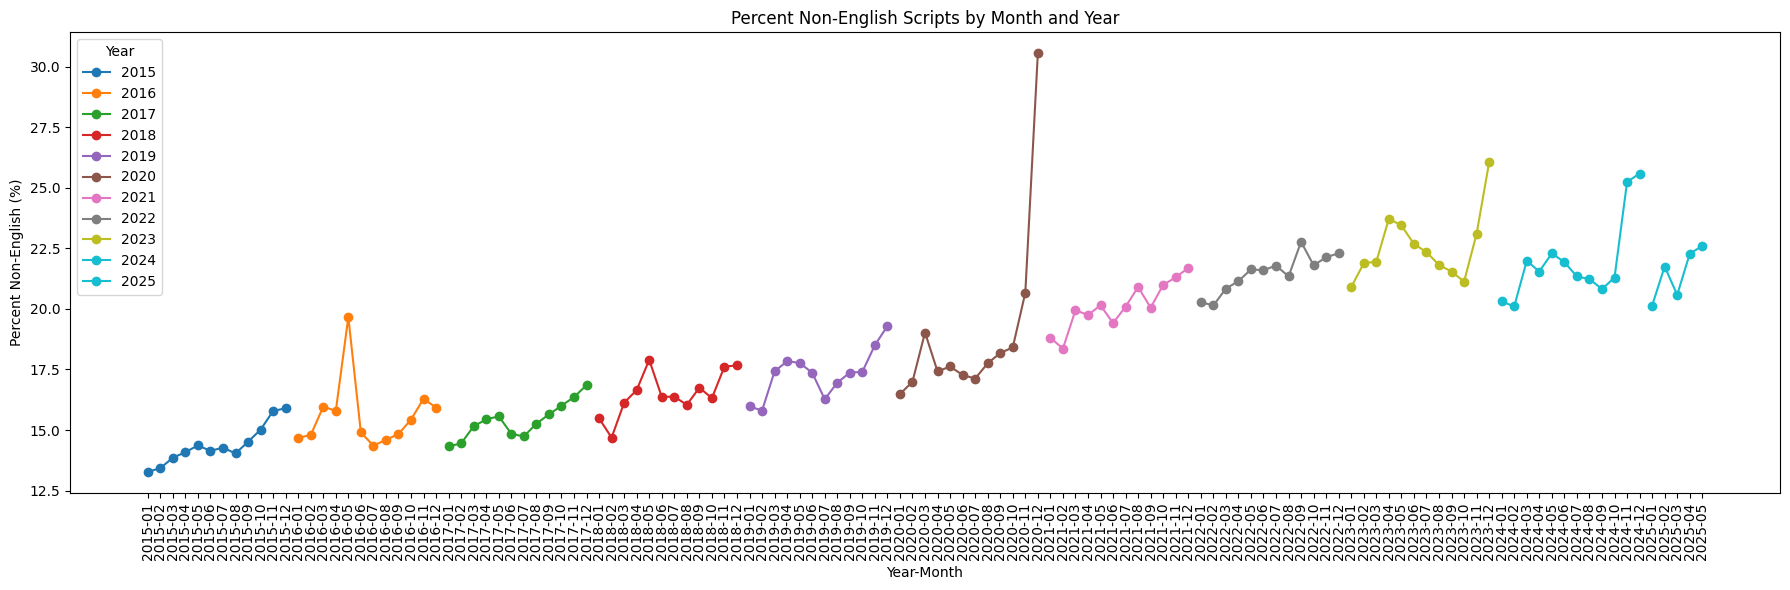

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
monthly_stats = []

for year in years:
    for month in range(1, 13):
        try:
            df = pd.read_csv(f"script_count_{year}_{month:02d}.csv")
            english = df.loc[df['script'].str.lower() == 'english', 'count'].sum()
            non_english = df.loc[df['script'].str.lower() != 'english', 'count'].sum()
            total = english + non_english
            pct_non_english = (non_english / total * 100) if total > 0 else 0
            monthly_stats.append({
                "year": year,
                "month": month,
                "percent_non_english": pct_non_english,
                "english": english,
                "non_english": non_english,
                "total": total
            })
        except Exception:
            continue

# Create DataFrame
df_monthly = pd.DataFrame(monthly_stats)
df_monthly["year_month"] = df_monthly["year"].astype(str) + "-" + df_monthly["month"].astype(str).str.zfill(2)

# Plot
plt.figure(figsize=(18, 6))
colors = plt.cm.get_cmap('tab10', len(years))
for idx, year in enumerate(years):
    mask = df_monthly["year"] == year
    plt.plot(
        df_monthly.loc[mask, "year_month"],
        df_monthly.loc[mask, "percent_non_english"],
        marker='o',
        label=str(year),
        color=colors(idx)
    )
plt.xticks(rotation=90)
plt.xlabel("Year-Month")
plt.ylabel("Percent Non-English (%)")
plt.title("Percent Non-English Scripts by Month and Year")
plt.legend(title="Year")
plt.tight_layout()
plt.show()

total ===>  3797


/var/folders/_0/frzsx3s9691dqywldb6cqgb80000gn/T/ipykernel_5559/4264105607.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(years))


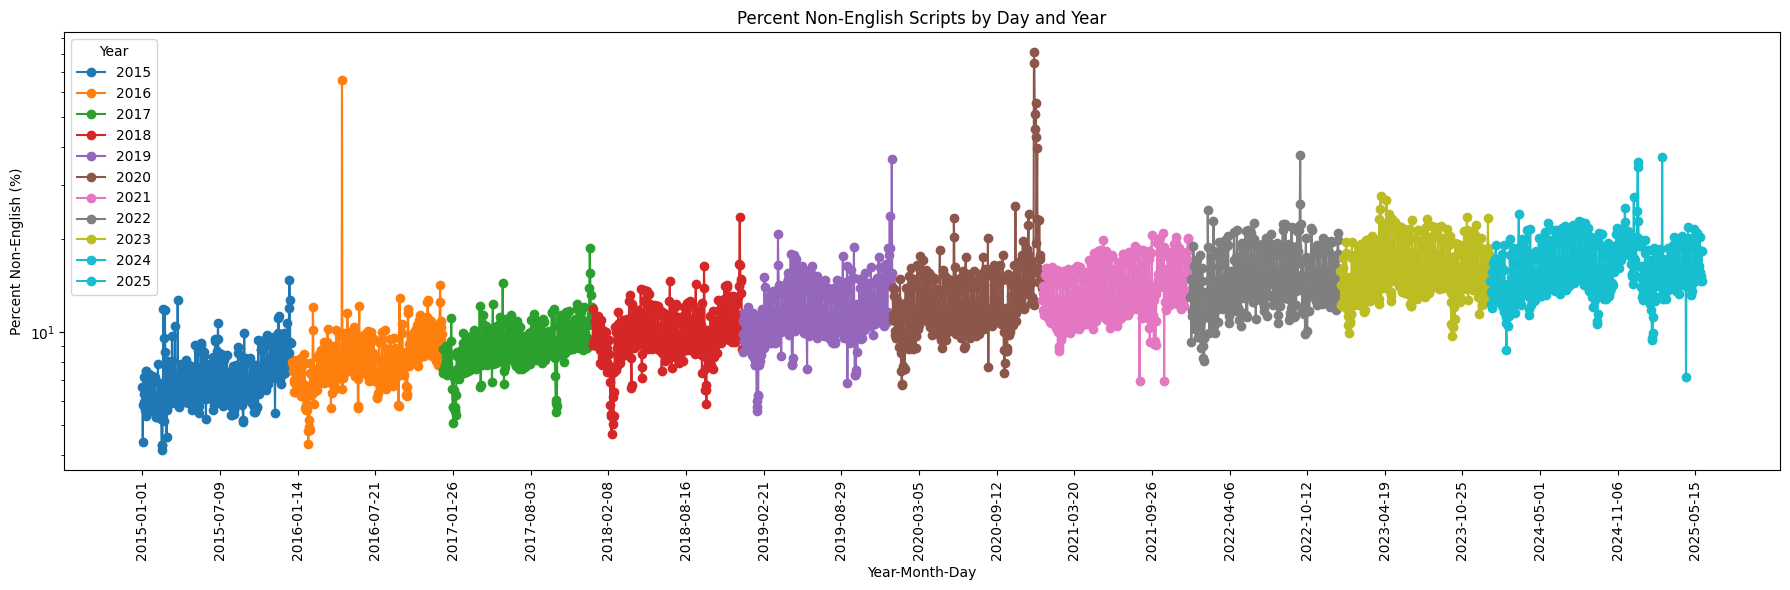

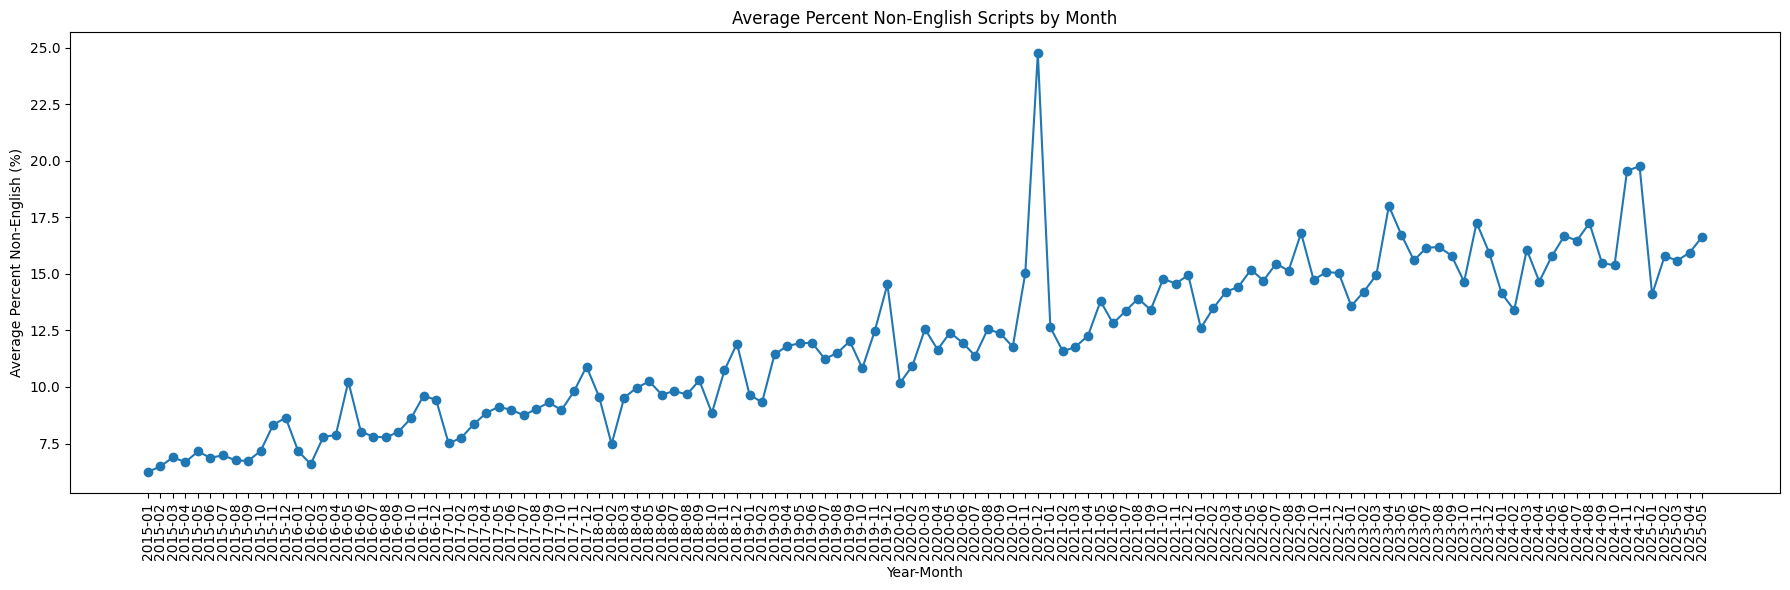

In [112]:
import pandas as pd
import matplotlib.pyplot as plt

years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
monthly_stats = []
count = 0
for year in years:
    for month in range(1, 13):
        for day in range(1, 32):
            try:
                df = pd.read_csv(f"resul_files/script_count_{year}_{month:02d}_{day:02d}.csv")
                english = df.loc[df['script'].str.lower() == 'english', 'count'].sum()
                non_english = df.loc[df['script'].str.lower() != 'english', 'count'].sum()
                total = english + non_english
                pct_non_english = (non_english / total * 100) if total > 0 else 0
                monthly_stats.append({
                    "year": year,
                    "month": month,
                    "day": day,
                    "percent_non_english": pct_non_english,
                    "english": english,
                    "non_english": non_english,
                    "total": total
                })
                count+=1
            except Exception as e:
                # print(e)
                continue

print("total ===> ", count)
# Create DataFrame
df_monthly = pd.DataFrame(monthly_stats)
df_monthly["year_month_day"] = (
    df_monthly["year"].astype(str) + "-" +
    df_monthly["month"].astype(str).str.zfill(2) + "-" +
    df_monthly["day"].astype(str).str.zfill(2)
)

# Plot
plt.figure(figsize=(18, 6))
colors = plt.cm.get_cmap('tab10', len(years))
for idx, year in enumerate(years):
    mask = df_monthly["year"] == year
    plt.plot(
        df_monthly.loc[mask, "year_month_day"],
        df_monthly.loc[mask, "percent_non_english"],
        marker='o',
        label=str(year),
        color=colors(idx)
    )
# Show only every Nth xtick for clarity
N = max(1, len(df_monthly["year_month_day"]) // 20)
plt.xticks(
    range(0, len(df_monthly["year_month_day"]), N),
    df_monthly["year_month_day"].iloc[::N],
    rotation=90
)
plt.xlabel("Year-Month-Day")
plt.ylabel("Percent Non-English (%)")
plt.title("Percent Non-English Scripts by Day and Year")
plt.legend(title="Year")
plt.yscale('log')
plt.tight_layout()
plt.show()
# Group by month and plot average percent_non_english per month
df_monthly["year_month"] = (
    df_monthly["year"].astype(str) + "-" +
    df_monthly["month"].astype(str).str.zfill(2)
)
monthly_avg = df_monthly.groupby("year_month")["percent_non_english"].mean().reset_index()

plt.figure(figsize=(18, 6))
plt.plot(monthly_avg["year_month"], monthly_avg["percent_non_english"], marker='o')
plt.xticks(rotation=90)
plt.xlabel("Year-Month")
plt.ylabel("Average Percent Non-English (%)")
plt.title("Average Percent Non-English Scripts by Month")
plt.tight_layout()
plt.show()

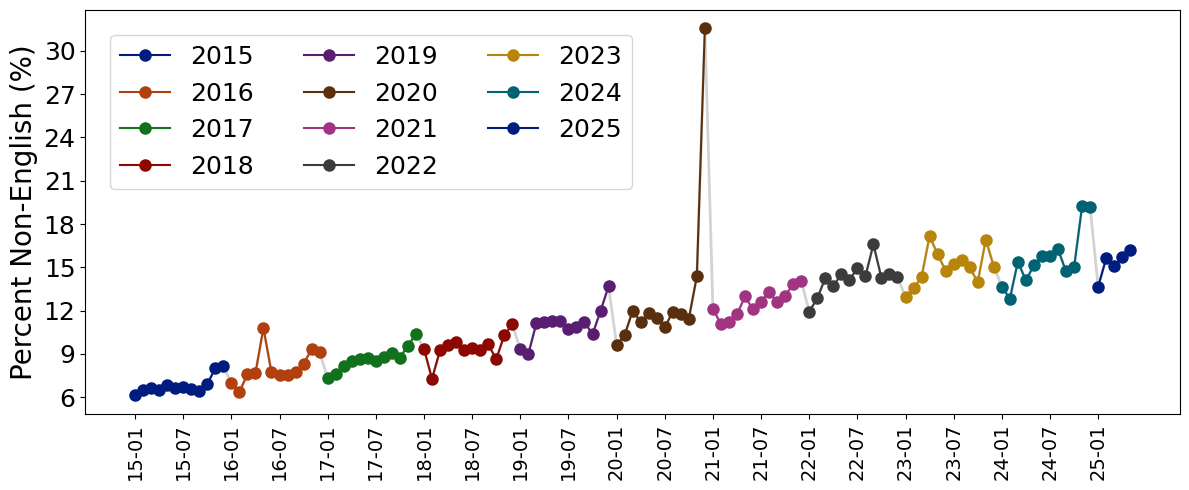

In [33]:
# Group by year and month, sum the counts
# monthly_totals = df_monthly.groupby(["year", "month"])[["english", "non_english"]].sum().reset_index()

# # Calculate total and English percentage
# monthly_totals["total"] = monthly_totals["english"] + monthly_totals["non_english"]
# monthly_totals["english_percent"] = (monthly_totals["english"] / monthly_totals["total"]) * 100

# # Optional: format for easy plotting or review
# monthly_totals["year_month"] = (
#     monthly_totals["year"].astype(str) + "-" +
#     monthly_totals["month"].astype(str).str.zfill(2)
# )


# Create 'year_month' column
df_monthly["year_month"] = (
    df_monthly["year"].astype(str) + "-" +
    df_monthly["month"].astype(str).str.zfill(2)
)

# Group by year and month
monthly_agg = df_monthly.groupby(["year", "month", "year_month"])[["english", "non_english"]].sum().reset_index()

# Calculate percent_non_english
monthly_agg["percent_non_english"] = (monthly_agg["non_english"] / (monthly_agg["english"] + monthly_agg["non_english"])) * 100


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
fontsize = 20

# Use 11 dark colors from seaborn's 'dark' palette
palette = sns.color_palette("dark", n_colors=11)
year_to_color = {year: palette[idx] for idx, year in enumerate(years)}

# Plot the full line in gray
plt.plot(
    monthly_agg["year_month"].str.replace(r"^20", "", regex=True),
    monthly_agg["percent_non_english"],
    color="lightgray",
    linewidth=2,
    label="_nolegend_"
)

# Overlay colored markers for each year
for year in years:
    mask = monthly_agg["year"] == year
    plt.plot(
        monthly_agg.loc[mask, "year_month"].str.replace(r"^20", "", regex=True),
        monthly_agg.loc[mask, "percent_non_english"],
        marker='o',
        markersize=8,
        linestyle='-',
        label=str(year),
        color=year_to_color[year]
    )

# Show fewer xticks for clarity
all_xticks = monthly_agg["year_month"].str.replace(r"^20", "", regex=True).tolist()
step = max(1, len(all_xticks) // 20)
plt.xticks(
    ticks=range(0, len(all_xticks), step),
    labels=[all_xticks[i] for i in range(0, len(all_xticks), step)],
    rotation=90,
    fontsize=14
)
plt.yticks(fontsize=18)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.ylabel("Percent Non-English (%)", fontsize=20)
# plt.legend(
#     fontsize=18,
#     title_fontsize=22,
#     ncol=6,
#     bbox_to_anchor=(0.5, 1.15),
#     loc="center",
#     borderaxespad=0
# )

plt.legend(
    fontsize=18,
    title_fontsize=22,
    ncol=3,
    loc="upper left",
    borderaxespad=1
)
plt.tight_layout()
plt.savefig("RQ1.pdf", bbox_inches="tight")
plt.show()


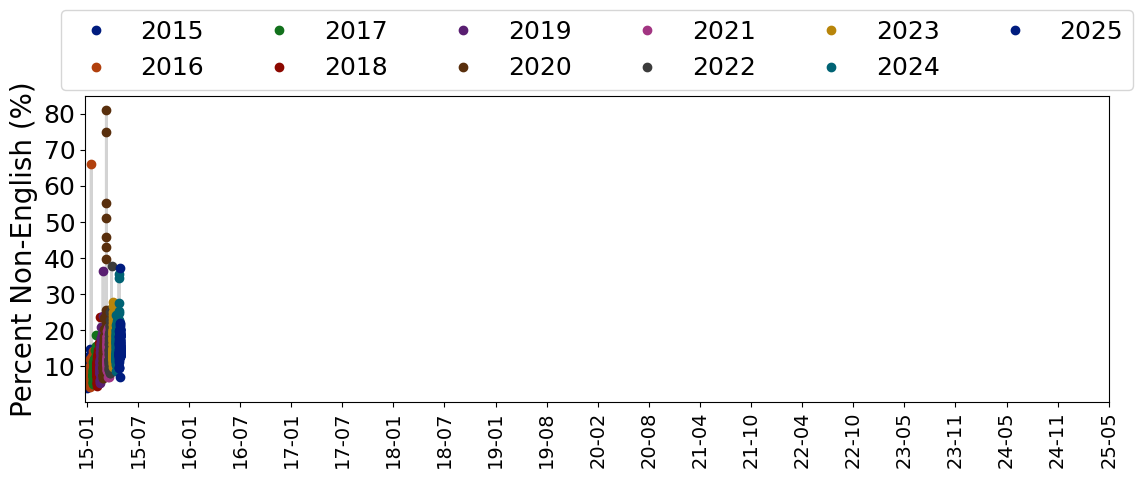

In [165]:
import seaborn as sns

plt.figure(figsize=(12, 5))
fontsize = 20

# Use 11 dark colors from seaborn's 'dark' palette
palette = sns.color_palette("dark", n_colors=11)
year_to_color = {year: palette[idx] for idx, year in enumerate(years)}

# Plot the full line in gray
plt.plot(
    df_monthly["year_month"].str.replace(r"^20", "", regex=True),  # shorten year
    df_monthly["percent_non_english"],
    color="lightgray",
    linewidth=2,
    label="_nolegend_"
)

# Overlay colored markers for each year
for idx, year in enumerate(years):
    mask = df_monthly["year"] == year
    plt.plot(
        df_monthly.loc[mask, "year_month"].str.replace(r"^20", "", regex=True),  # shorten year
        df_monthly.loc[mask, "percent_non_english"],
        marker='o',
        linestyle='None',  # Only markers, no lines
        label=str(year),
        color=year_to_color[year]
    )

# Show fewer xticks for clarity
all_xticks = df_monthly["year_month"].str.replace(r"^20", "", regex=True).tolist()
step = max(1, len(all_xticks) // 20)
plt.xticks(
    ticks=range(0, len(all_xticks), step),
    labels=[all_xticks[i] for i in range(0, len(all_xticks), step)],
    rotation=90,
    fontsize=14
)
plt.yticks(fontsize=18)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))  # <-- Make y-axis ticks integer
plt.ylabel("Percent Non-English (%)", fontsize=20)
plt.legend(
    fontsize=18,
    title_fontsize=22,
    ncol=6,
    bbox_to_anchor=(0.5, 1.15),
    loc="center",
    borderaxespad=0
)  # <-- Legend outside

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

base_palette = sns.color_palette("deep", n_colors=10)  # 'deep' has 10 colors
# Add one more distinct dark color (e.g., dark teal)
extra_color = sns.dark_palette("teal", n_colors=1)[0]

palette = [color for color in base_palette] + [extra_color]

# Map years to colors
year_to_color = {year: palette[idx] for idx, year in enumerate(years)}

years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
monthly_lang_stats = []

# Collect all language counts per month
for year in years:
    for month in range(1, 13):
        try:
            df = pd.read_csv(f"script_count_{year}_{month:02d}.csv")
            # Exclude English
            non_eng_df = df[df['script'].str.lower() != 'english']
            # Group by script and sum counts
            lang_counts = non_eng_df.groupby('script')['count'].sum().sort_values(ascending=False)
            # Save top 10 for this month
            top_langs = lang_counts.head(10)
            for lang, count in top_langs.items():
                monthly_lang_stats.append({
                    "year": year,
                    "month": month,
                    "year_month": f"{year}-{month:02d}",
                    "language": lang,
                    "count": count
                })
        except Exception:
            continue

# Create DataFrame
df_lang = pd.DataFrame(monthly_lang_stats)

# Find overall top 10 languages (by total count across all months)
top10_langs = (
    df_lang.groupby('language')['count']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
    .tolist()
)

# Filter to only top 10 languages
df_lang_top10 = df_lang[df_lang['language'].isin(top10_langs)]

# Pivot for stacked bar plot: rows=year_month, columns=language, values=count
pivot = df_lang_top10.pivot_table(
    index='year_month', columns='language', values='count', fill_value=0
)

# Sort year_month
pivot = pivot.sort_index()

# Plot
plt.figure(figsize=(20, 7))
pivot.plot(
    kind='bar',
    stacked=True,
    color=palette,
    width=0.9,
    ax=plt.gca()
)
plt.xlabel("Year-Month")
plt.ylabel("Count")
plt.title("Top 10 Non-English Scripts by Month (Stacked Bar)")
plt.xticks(rotation=90)
plt.legend(title="Script", bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()

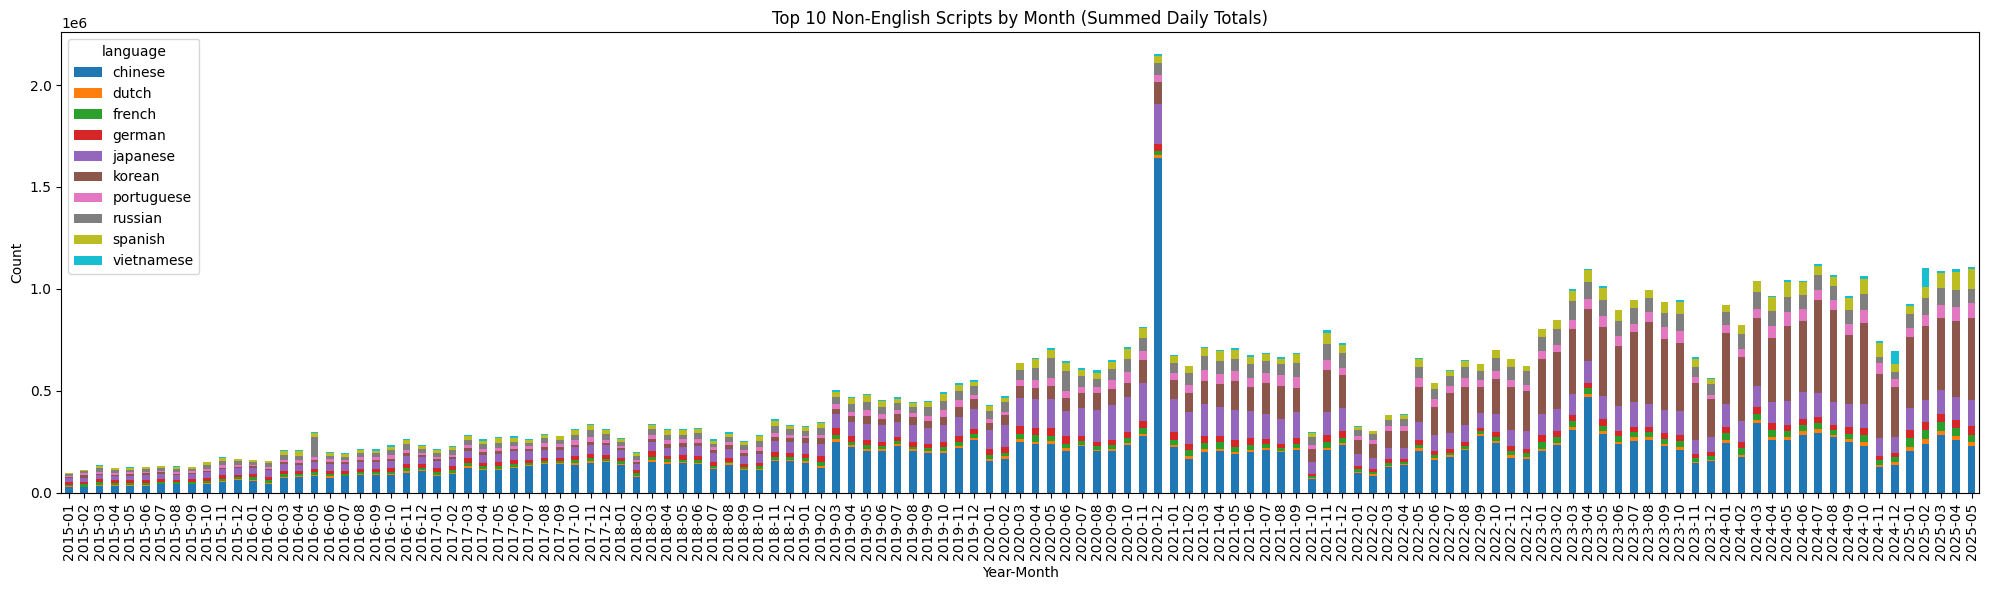

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
monthly_lang_stats = []

# Dict to collect total counts per language per month
from collections import defaultdict

monthly_lang_totals = defaultdict(lambda: defaultdict(int))  # {(year, month): {language: total}}

# Step 1: Sum language counts across all days
for year in years:
    for month in range(1, 13):
        for day in range(1, 32):
            try:
                df = pd.read_csv(f"resul_files/script_count_{year}_{month:02d}_{day:02d}.csv")
                non_eng_df = df[df['script'].str.lower() != 'english']
                grouped = non_eng_df.groupby('script')['count'].sum()
                for lang, count in grouped.items():
                    monthly_lang_totals[(year, month)][lang] += count
            except Exception:
                continue

# Step 2: For each month, get top 10 languages and store
for (year, month), lang_counts in monthly_lang_totals.items():
    sorted_langs = sorted(lang_counts.items(), key=lambda x: x[1], reverse=True)[:10]
    for lang, count in sorted_langs:
        monthly_lang_stats.append({
            "year": year,
            "month": month,
            "year_month": f"{year}-{month:02d}",
            "language": lang,
            "count": count
        })

# Step 3: Create DataFrame and pivot
df_monthly_lang = pd.DataFrame(monthly_lang_stats)

# Find overall top 10 languages across all months
top10_langs = (
    df_monthly_lang.groupby('language')['count']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
    .tolist()
)

# Filter for top 10 languages only
df_top10 = df_monthly_lang[df_monthly_lang['language'].isin(top10_langs)]

# Pivot for plot
pivot = df_top10.pivot_table(
    index='year_month', columns='language', values='count', fill_value=0
)
pivot = pivot.sort_index()

# Plot
pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(20, 6)
)
plt.ylabel("Count")
plt.xlabel("Year-Month")
plt.title("Top 10 Non-English Scripts by Month (Summed Daily Totals)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


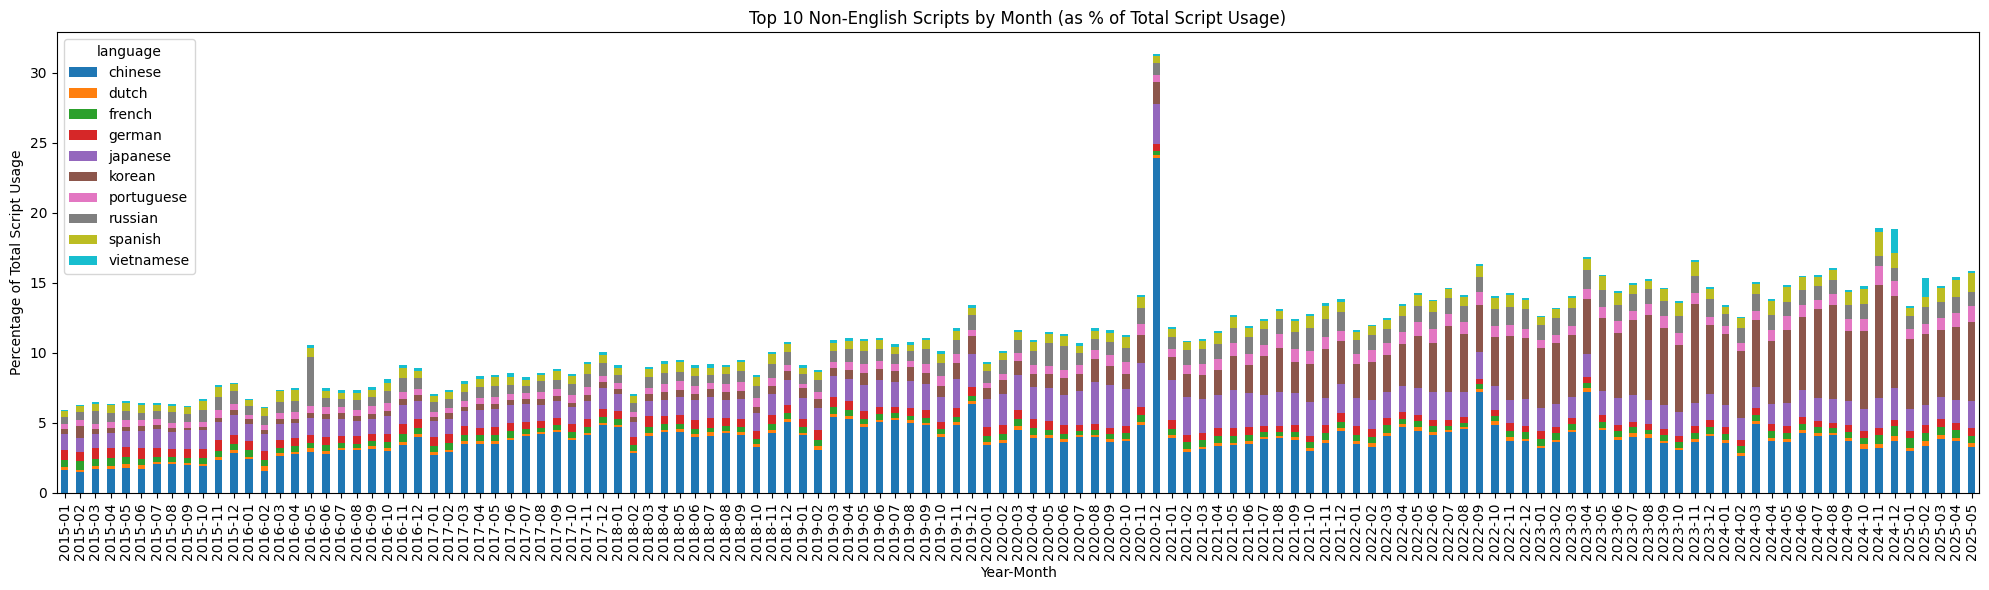

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
monthly_lang_stats = []
monthly_lang_totals = defaultdict(lambda: defaultdict(int))  # {(year, month): {language: total}}

# Step 1: Aggregate all scripts
for year in years:
    for month in range(1, 13):
        for day in range(1, 32):
            try:
                df = pd.read_csv(f"resul_files/script_count_{year}_{month:02d}_{day:02d}.csv")
                grouped = df.groupby('script')['count'].sum()
                for lang, count in grouped.items():
                    monthly_lang_totals[(year, month)][lang] += count
            except Exception:
                continue

# Step 2: Collect raw counts
all_lang_stats = []
for (year, month), lang_counts in monthly_lang_totals.items():
    total_count = sum(lang_counts.values())
    for lang, count in lang_counts.items():
        all_lang_stats.append({
            "year": year,
            "month": month,
            "year_month": f"{year}-{month:02d}",
            "language": lang,
            "count": count,
            "total": total_count
        })

df_all_lang = pd.DataFrame(all_lang_stats)

# Step 3: Remove 'english' and get top 10 non-English languages overall
df_non_english = df_all_lang[df_all_lang['language'].str.lower() != 'english']
top10_langs = (
    df_non_english.groupby('language')['count']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
    .tolist()
)

# Step 4: Filter for top 10 and compute percentages
df_top10 = df_all_lang[df_all_lang['language'].isin(top10_langs)].copy()
df_top10['percent'] = (df_top10['count'] / df_top10['total']) * 100

# Step 5: Pivot and plot
pivot = df_top10.pivot_table(
    index='year_month', columns='language', values='percent', fill_value=0
)
pivot = pivot.sort_index()

pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(20, 6)
)
plt.ylabel("Percentage of Total Script Usage")
plt.xlabel("Year-Month")
plt.title("Top 10 Non-English Scripts by Month (as % of Total Script Usage)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [196]:
pivot.columns
# t = pivot[pivot['year_month']=='2025-05']
# t

Index(['chinese', 'dutch', 'french', 'german', 'japanese', 'korean',
       'portuguese', 'russian', 'spanish', 'vietnamese'],
      dtype='object', name='language')

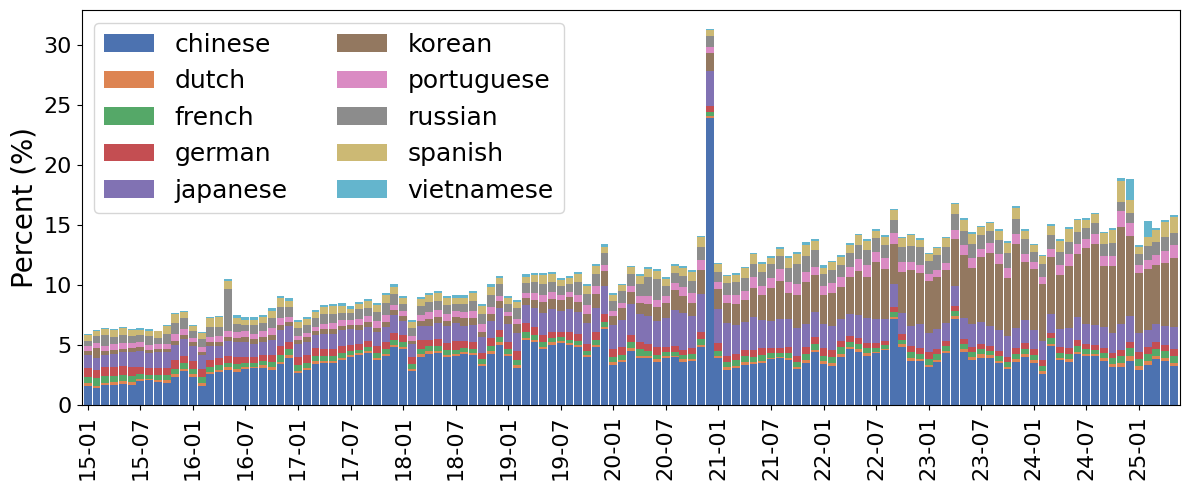

In [39]:
# ...existing code...
import matplotlib.patches as mpatches
import numpy as np
from matplotlib.ticker import FuncFormatter
palette = [color for color in base_palette] + [extra_color]
plt.figure(figsize=(12, 5))

# Define hatching patterns for up to 11 bars
hatch_patterns = ['', '//', '\\\\', 'xx', '++', '..', '**', 'oo', 'OO', '--', '||']

# Plot the stacked bar with patterns
bars = pivot.plot(
    kind='bar',
    stacked=True,
    color=palette,
    width=0.9,
    ax=plt.gca()
)

# # Apply hatching patterns to each bar group
# for i, bar_container in enumerate(bars.containers):
#     hatch = hatch_patterns[i % len(hatch_patterns)]
#     for rect in bar_container:
#         rect.set_hatch(hatch)

# plt.xlabel("Year-Month")
plt.xlabel(None)
plt.ylabel("Percent (%)", fontsize=20)
# plt.title("Top 10 Non-English Scripts by Month (Stacked Bar)")

# Show fewer xticks for clarity
all_xticks = list(pivot.index)
step = max(1, len(all_xticks) // 20)
# Shorten year: '2015-01' -> '15-01'
short_labels = [x[2:] if len(x) >= 5 else x for x in all_xticks]
plt.xticks(
    ticks=range(0, len(all_xticks), step),
    labels=[short_labels[i] for i in range(0, len(short_labels), step)],
    rotation=90,
    fontsize=16
)
def millions(x, pos):
    return f'{x/1e6:.1f}M' if x >= 1e6 else (f'{x/1e3:.0f}k' if x >= 1e3 else str(int(x)))
# plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
plt.yticks(fontsize=16)

# plt.legend(bbox_to_anchor=(0.5, 1.12), loc='center', ncol = 5, fontsize=16)
plt.legend(loc='upper left', ncol = 2, fontsize=18)
plt.tight_layout()
plt.savefig("RQ3.pdf", bbox_inches="tight")
plt.show()
#

In [190]:
# Make sure 'year' column is integer
df_top10['year'] = df_top10['year'].astype(int)

# Define start and end years
start_year = 2015
end_year = 2025

# Step 1: Group by language and year, take mean percent
lang_year_avg = (
    df_top10.groupby(['language', 'year'])['percent']
    .mean()
    .unstack()  # columns: years
)

# Step 2: Drop languages without both start and end year
lang_year_avg = lang_year_avg.dropna(subset=[start_year, end_year])

# Step 3: Compute change
lang_year_avg['change'] = lang_year_avg[end_year] - lang_year_avg[start_year]
lang_year_avg['abs_change'] = lang_year_avg['change'].abs()

# Step 4: Get top 5 by absolute change
top5_langs_change = lang_year_avg.sort_values('abs_change', ascending=False).head(5)

# Show result
print(top5_langs_change[[start_year, end_year, 'change']])


year            2015      2025    change
language                                
korean      0.350848  5.157633  4.806785
chinese     1.937593  3.421960  1.484367
spanish     0.532637  0.984778  0.452141
portuguese  0.434878  0.867077  0.432200
japanese    1.203107  1.616494  0.413387


In [198]:
# sum the counts for each language across all months
total_counts = df_monthly_lang.groupby('language')['percent'].mean().sort_values(ascending=False).reset_index()
# print(total_counts['language'].tolist())
total_counts

language    percent
0    english  88.392403
1    chinese   3.867860
2     korean   2.159945
3   japanese   1.688499
4    russian   0.969259
..       ...        ...
70  gujarati   0.000324
71     hindi   0.000264
72    kazakh   0.000121
73    telugu   0.000113
74   punjabi   0.000102

[75 rows x 2 columns]

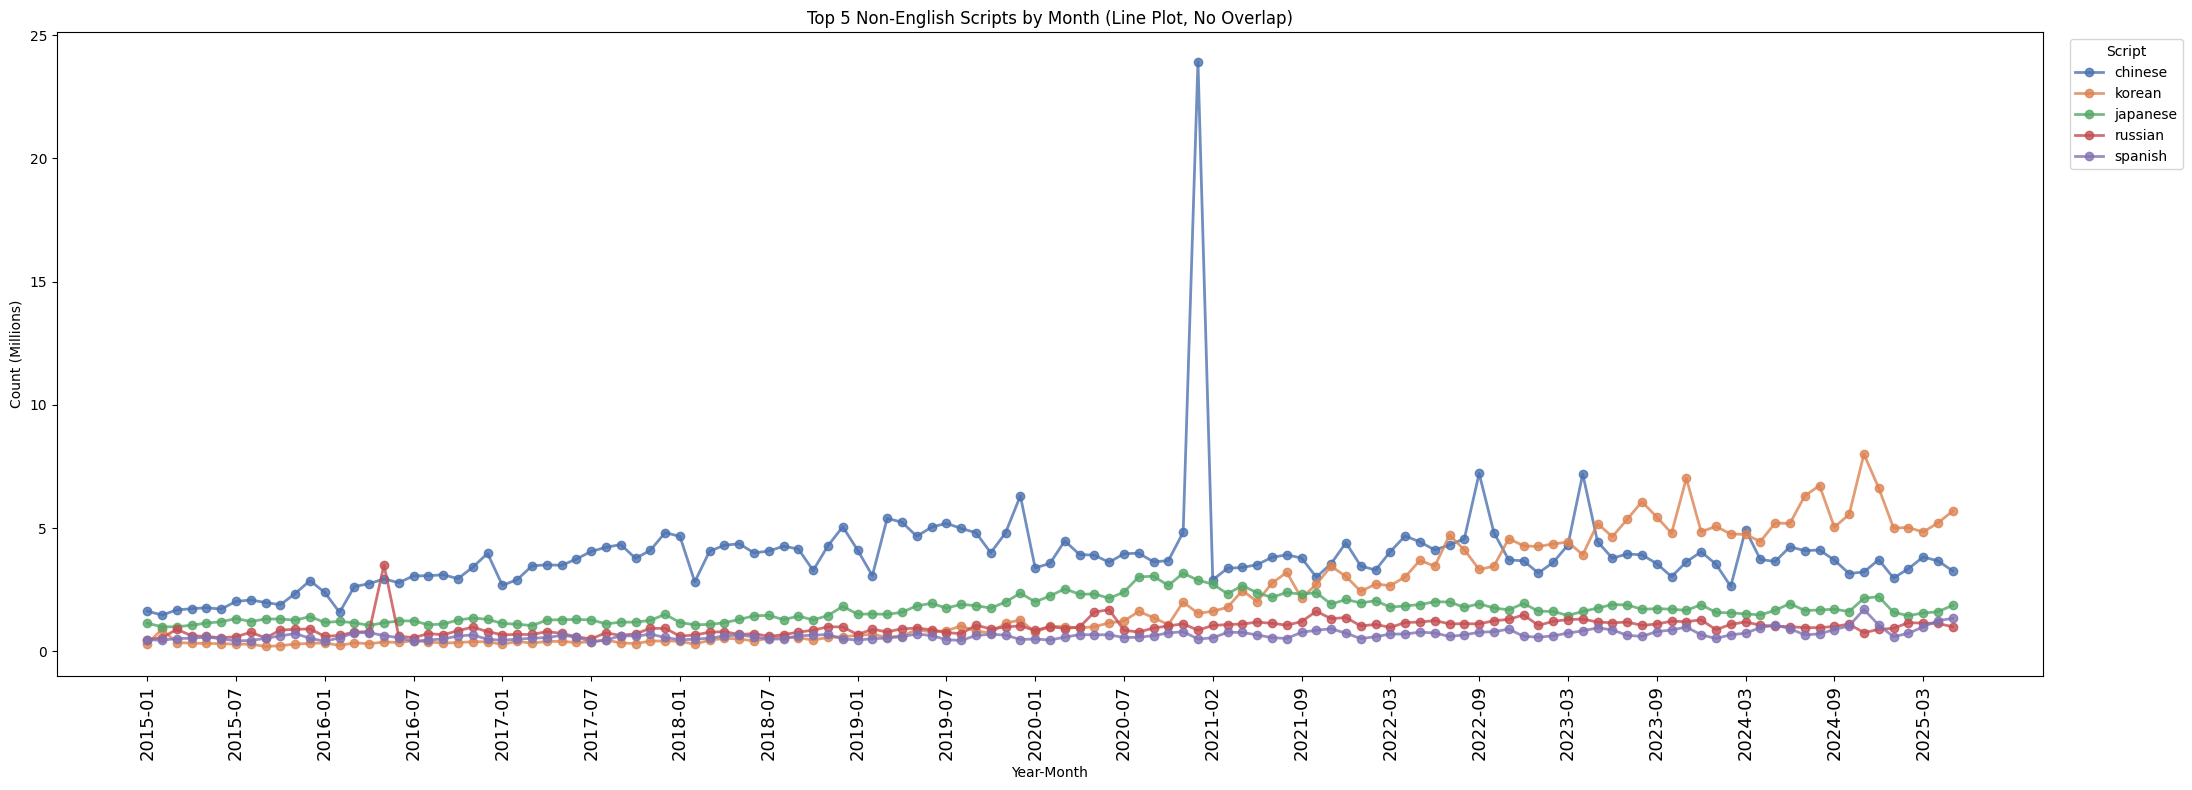

In [199]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(22, 8))
palette = sns.color_palette("deep", n_colors=5)

# Show only top 5 languages for clarity
top5_langs = pivot.sum().sort_values(ascending=False).head(5).index

for idx, lang in enumerate(top5_langs):
    plt.plot(
        pivot.index,
        pivot[lang],
        marker='o',
        linestyle='-',  # or 'None' for only markers
        label=lang,
        color=palette[idx],
        alpha=0.8,
        linewidth=2
    )

plt.xlabel("Year-Month")
plt.ylabel("Count (Millions)")
plt.title("Top 5 Non-English Scripts by Month (Line Plot, No Overlap)")

# Use fewer xticks for clarity
all_xticks = list(pivot.index)
step = max(1, len(all_xticks) // 20)
plt.xticks(
    ticks=range(0, len(all_xticks), step),
    labels=[all_xticks[i] for i in range(0, len(all_xticks), step)],
    rotation=90,
    fontsize=13
)

# Format y-axis ticks to millions
def millions(x, pos):
    return f'{x/1e6:.1f}M' if x >= 1e6 else (f'{x/1e3:.0f}k' if x >= 1e3 else str(int(x)))
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))

plt.legend(title="Script", bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [100]:
# 1. Pivot table (already done as 'pivot')
# 2. Calculate month-to-month difference
diff = pivot.diff().abs()

# 3. Find the largest change for each language
max_change = diff.max()

# 4. Find the language with the biggest change and when it happened
lang_with_max_change = max_change.idxmax()
max_change_value = max_change.max()
when = diff[lang_with_max_change].idxmax()

print(f"Largest change: {max_change_value} for '{lang_with_max_change}' in {when}")

# Optional: Show all languages sorted by their biggest change
print("Top changes by language:")
print(max_change.sort_values(ascending=False))

Largest change: 1422473.0 for 'chinese' in 2021-01
Top changes by language:
language
chinese       1422473.0
russian        244859.0
korean         159447.0
danish         144356.0
japanese       114993.0
spanish        113999.0
portuguese      93628.0
latin           78823.0
german          68921.0
french          63786.0
dtype: float64


In [80]:
import pandas as pd
import os
from collections import defaultdict

# Folder where the CSV files are
folder = 'resul_files'  # change if files are in a different folder

# Get all CSV file names in the folder
all_files = [f for f in os.listdir(folder) if f.startswith("script_count_") and f.endswith(".csv")]

# Group files by month
monthly_files = defaultdict(list)
for file in all_files:
    parts = file.split('_')
    year_month = '_'.join(parts[2:4])  # example: 2022_04
    monthly_files[year_month].append(file)

# Merge each month's files
for month, files in monthly_files.items():
    print(f"Combining files for month: {month}")
    combined = {}
    for file in files:
        path = os.path.join(folder, file)
        df = pd.read_csv(path)
        # Convert df to key-value dictionary: {script: count}
        df_dict = dict(zip(df['script'], df['count']))
        # print(df_dict)
        for script, count in df_dict.items():
            if script in combined:
                combined[script] += count
            else:
                combined[script] = count
    # print(f"Combined counts for {month}:")
    # print(combined)
    combined_df = pd.DataFrame(list(combined.items()), columns=['script', 'count'])
    combined_df.to_csv(f'script_count_{month}.csv', index=False)


Combining files for month: 2022_09
Combining files for month: 2022_07
Combining files for month: 2024_12
Combining files for month: 2022_10
Combining files for month: 2025_04
Combining files for month: 2024_05
Combining files for month: 2024_02
Combining files for month: 2022_12
Combining files for month: 2024_07
Combining files for month: 2024_09
Combining files for month: 2018_11
Combining files for month: 2022_02
Combining files for month: 2022_05
Combining files for month: 2024_10
Combining files for month: 2024_01
Combining files for month: 2018_10
Combining files for month: 2024_08
Combining files for month: 2024_06
Combining files for month: 2022_04
Combining files for month: 2022_03
Combining files for month: 2024_11
Combining files for month: 2022_06
Combining files for month: 2022_01
Combining files for month: 2022_08
Combining files for month: 2022_11
Combining files for month: 2025_05
Combining files for month: 2018_12
Combining files for month: 2024_03
Combining files for 

In [154]:
from lingua import Language, LanguageDetectorBuilder
# message = (
#     "This is a test message to detect the language. "
#     "Este es un mensaje de prueba para detectar el idioma. "
#     "Ceci est un message de test pour détecter la langue. "
#     "Dies ist eine Testnachricht, um die Sprache zu erkennen. "
#     "Это тестовое сообщение для определения языка. "
#     "这是一条用于检测语言的测试消息。 "
#     "これは言語を検出するためのテストメッセージです。 "
#     "이것은 언어를 감지하기 위한 테스트 메시지입니다. "
#     "यह भाषा का पता लगाने के लिए एक परीक्षण संदेश है। "
#     "هذا رسالة اختبار لاكتشاف اللغة. "
#     "Bu, dili algılamak için bir test mesajıdır. "
#     "Dit is een testbericht om de taal te detecteren. "
#     "Questa è un messaggio di prova per rilevare la lingua. "
#     "Este é uma mensagem de teste para detectar o idioma. "
#     "Aceasta este un mesaj de test pentru detectarea limbii."
# )

message = (
    
    "这是一条用于检测语言的测试消息。"
    "هذا رسالة اختبار لاكتشاف اللغة. "
)
# Make it one string (remove line breaks and extra spaces)
message = " ".join(message.split())
print(f"Message to detect: {message}")
detector = LanguageDetectorBuilder.from_all_languages().with_preloaded_language_models().with_minimum_relative_distance(0.99).build()

detection = detector.compute_language_confidence_values(message)
print(detection)
# for lang in detection:
#     print(lang)
#     print(f"Detected language: {lang.language.name}")
# if not detection:
#     print("No language detected with high confidence.")

Message to detect: 这是一条用于检测语言的测试消息。هذا رسالة اختبار لاكتشاف اللغة.
[ConfidenceValue(language=Language.CHINESE, value=1), ConfidenceValue(language=Language.AFRIKAANS, value=0), ConfidenceValue(language=Language.ALBANIAN, value=0), ConfidenceValue(language=Language.ARABIC, value=0), ConfidenceValue(language=Language.ARMENIAN, value=0), ConfidenceValue(language=Language.AZERBAIJANI, value=0), ConfidenceValue(language=Language.BASQUE, value=0), ConfidenceValue(language=Language.BELARUSIAN, value=0), ConfidenceValue(language=Language.BENGALI, value=0), ConfidenceValue(language=Language.BOKMAL, value=0), ConfidenceValue(language=Language.BOSNIAN, value=0), ConfidenceValue(language=Language.BULGARIAN, value=0), ConfidenceValue(language=Language.CATALAN, value=0), ConfidenceValue(language=Language.CROATIAN, value=0), ConfidenceValue(language=Language.CZECH, value=0), ConfidenceValue(language=Language.DANISH, value=0), ConfidenceValue(language=Language.DUTCH, value=0), ConfidenceValue(language=

In [157]:
from lingua import Language, LanguageDetectorBuilder
languages = [Language.ENGLISH, Language.FRENCH, Language.GERMAN, Language.SPANISH]
detector = LanguageDetectorBuilder.from_languages(*languages).build()
confidence_value = detector.compute_language_confidence("languages are awesome", Language.FRENCH)
confidence_value

0.0435955583028276

In [225]:
import requests
# headers = {"Authorization": "token <your-github-token>"}
params = {
    "q": "path:README.md",
    "since": "2015-01-01T00:00:00Z",
    "until": "2015-12-31T23:59:59Z"
}
response = requests.get("https://api.github.com/search/", params=params)

In [ ]:
import os
import gzip
import json
import re
import ssl
import unicodedata
import time
from collections import defaultdict
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import argparse
from functools import partial
from multiprocessing import Pool, cpu_count

ssl._create_default_https_context = ssl._create_unverified_context

# # CLI arguments
# parser = argparse.ArgumentParser(description="Process GH Archive event counts and language stats.")
# parser.add_argument("--year", type=int, required=True)
# parser.add_argument("--month", type=int, required=True)
# # parser.add_argument("--day", type=int, required=True)
# args = parser.parse_args()

year = 2025
month = 1
download_dir = f"data/gharchive_{year}_{month:02d}"
# day_str = f"{year}-{month:02d}-{day:02d}"

def is_english(text):
    if not text:
        return True
    for char in text:
        if char.isspace() or not char.isalpha():
            continue
        if not ('a' <= char.lower() <= 'z'):
            return False
    return True

event_counts = defaultdict(int)
english = 0
not_english = 0
all_languages = []
non_english_id_list = []

def process_hour(hour):
    day_str = f"{year}-{month:02d}-{day:02d}"
    filename = f"{day_str}-{hour}.json.gz"
    filepath = os.path.join(download_dir, filename)
    count = 0
    event_types = []
    repos_ids = []
    try:
        with gzip.open(filepath, 'rt', encoding='utf-8') as f:
            for line in f:
                try:
                    event = json.loads(line)
                    event_type = event.get("type")

                    if event_type =="PushEvent":
                        if 'bot' not in event.get("actor", {}).get("login", ""):
                            id = event.get('repo', {}).get('id', '')
                            name = event.get('repo', {}).get('name', '')
                            ret_obj = {
                                "id": id,
                                "name": name
                            }
                            event_types.append(ret_obj)

                except Exception as e:
                    continue
                    # raise e  # re-raise to handle in the main process
    except Exception as e:
        # raise e
        return None  # skip file if missing or error
    return event_types

if __name__ == "__main__":
    all_repos = []
    for day in range(1, 32):
        day_str = f"{year}-{month:02d}-{day:02d}"
        try:
            local_counts = defaultdict(int)
            all_detected_messages = []  # Store (language, message)
            start_time = time.time()
            func = partial(process_hour)
            with Pool(processes=min(cpu_count(), 24)) as pool:
                for result in tqdm(pool.imap_unordered(func, range(24)), total=24, desc="Processing hours"):
                    if result:
                        all_repos.extend(result)

        except Exception as e:
            print(f"Error processing day {day_str}: {e}")
            continue

    df = pd.DataFrame(all_repos)
    df = df.drop_duplicates().reset_index()
    df.to_csv(f"result_files/repo_languages_{year}_{month:02d}.csv", index=False, encoding="utf-8")
# for day in range(1,32):
#     # Process 24 hours
#     tasks = []
#     with ThreadPoolExecutor() as executor:
#         for hour in range(24):
#             tasks.append(executor.submit(process_hour, hour))
#         for future in tqdm(as_completed(tasks), total=len(tasks), desc=f"Day {day:02d}"):
#             languages = future.result()
#             all_languages.extend(languages)


#         df = pd.DataFrame(all_languages)
#         print(df)
        # os.makedirs("result_files", exist_ok=True)
        # df.to_csv(f"result_files/repo_languages_{year}_{month:02d}_{day:02d}.csv", index=False, encoding="utf-8")


In [ ]:
year = 2025
month = 1
df = pd.read_csv(f"repos_{year}_{month:02d}.csv")
if 'index' in df.columns:
    df = df.drop(columns=['index'])
df_sample = df.sample(n=385, random_state=42).reset_index(drop=True)
# func = partial(process_hour, day=day)
# with Pool(processes=min(cpu_count(), 24)) as pool:
#     for result in tqdm(pool.imap_unordered(func, range(24)), total=24, desc="Processing hours"):
#         if result:
#             all_repos.extend(result)
# print(df_sample)
count=0
for i in range(len(df_sample)):
    print(df_sample.iloc[i])
    repo_name = df_sample.iloc[i]['name']
    id = df_sample.iloc[i]['id']
    print(repo_name, id)
    # process_repo(id, repo_name, log_output_dir)
    count+=1
    if count>10:
        break

id                        921146234
name    icapps/flutter_icapps_icons
Name: 0, dtype: object
icapps/flutter_icapps_icons 921146234
id               918240656
name    SalmanOP12358294/1
Name: 1, dtype: object
SalmanOP12358294/1 918240656
id                781998288
name    ArshMov/Discord-Bot
Name: 2, dtype: object
ArshMov/Discord-Bot 781998288
id                                              924763844
name    Xbox-Redeem-Code-1/Xbox-One-Digital-Code-Insta...
Name: 3, dtype: object
Xbox-Redeem-Code-1/Xbox-One-Digital-Code-Instant-Update-and-Unused-Codes 924763844
id                                       918008315
name    Enggarrahayu/Assignment_Day14_EnggarRahayu
Name: 4, dtype: object
Enggarrahayu/Assignment_Day14_EnggarRahayu 918008315
id            875771174
name    jramke/carve-ui
Name: 5, dtype: object
jramke/carve-ui 875771174
id                   922308430
name    FelltopDigital/felltop
Name: 6, dtype: object
FelltopDigital/felltop 922308430
id                915082208
name    n

In [243]:
from datetime import datetime, timedelta
year = 2024
month = 2
# compute date range
start_date = datetime(year, month, 1)
after_date = (start_date - timedelta(days=1)).strftime("%Y-%m-%d")
# after_date

import calendar
from datetime import datetime, timedelta

# start date: one day before the first of the month
start_date = datetime(year, month, 1)
after_date = (start_date - timedelta(days=1)).strftime("%Y-%m-%d")

# get the last day of the month (handles leap years)
last_day = calendar.monthrange(year, month)[1]
end_date = datetime(year, month, last_day)
before_date = end_date.strftime("%Y-%m-%d")
before_date

'2024-02-29'

In [16]:
from pathlib import Path
import glob
from collections import defaultdict
from mrkdwn_analysis import MarkdownAnalyzer


folders = glob.glob("logs/*")
# count = defaultdict(int)
for folder in folders:
    files = glob.glob(folder+"/*")
    count = defaultdict(int)
    for file_ in files:
        fpath = file_.split()[0]
        ext = Path(fpath).suffix.lower()
        count[ext]+=1

    # print(folder, count)
    if count[".java"]<40:
        print("JAVA nEEEEEDED", folder, count['.java'])
    # print("Total files:", sum(count.values()))


JAVA nEEEEEDED logs/2025-01 36
JAVA nEEEEEDED logs/2025-05 39


In [ ]:
import os
import gzip
import json
import re
import ssl
import unicodedata
from collections import defaultdict
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import argparse
# from lingua import Language, LanguageDetectorBuilder

# # Setup language detector
# languages = [Language.ENGLISH, Language.SPANISH, Language.FRENCH, Language.GERMAN,
#              Language.CHINESE, Language.JAPANESE, Language.HINDI, Language.BENGALI,
#              Language.RUSSIAN, Language.PORTUGUESE, Language.ARABIC]
# detector = LanguageDetectorBuilder.from_languages(*languages).build()

# Disable SSL validation if needed
ssl._create_default_https_context = ssl._create_unverified_context

# # CLI arguments
# parser = argparse.ArgumentParser(description="Process GH Archive event counts and language stats.")
# parser.add_argument("--year", type=int, required=True)
# parser.add_argument("--month", type=int, required=True)
# parser.add_argument("--day", type=int, required=True)
# args = parser.parse_args()

# Merge all daily CSVs into a single DataFrame
dfs = []
for day in range(1, 32):
    try:
        df_day = pd.read_csv(f"result_files/repo_languages_2024_08_{day:02d}.csv")
        dfs.append(df_day)
    except FileNotFoundError:
        continue  # skip missing days

if dfs:
    df_merged = pd.concat(dfs, ignore_index=True)
    # print(df_merged)
else:
    print("No daily CSV files found to merge.")



def process_hour(hour, download_dir, day_str):
    filename = f"{day_str}-{hour}.json.gz"
    filepath = os.path.join(download_dir, filename)
    count = 0
    repo_ids = []
    try:
        with gzip.open(filepath, 'rt', encoding='utf-8') as f:
            for line in f:
                try:
                    event = json.loads(line)
                    repo = event.get("repo",{})
                    if repo:
                        repo_id = repo['id']
                        repo_ids.append(repo_id)
                except:
                    raise
    except Exception as e:
        # raise ValueError(f"Error processing file {filepath}")
        # print(e)
        # raise
        pass
    return repo_ids

year = 2024
for month in range(9,11):
    for day in range(1,32):
        if month==9 and day<24:
            continue
        download_dir = f"data/gharchive_{year}_{month:02d}"
        day_str = f"{year}-{month:02d}-{day:02d}"
        all_repos = []
        for hour in tqdm(range(24), desc=f"Processing hours for {day_str}"):
            repo_ids = process_hour(hour, download_dir, day_str)
            all_repos.extend(repo_ids)

        repo_ids_set = set(all_repos)
        common_ids = set(df_merged['id']).intersection(repo_ids_set)

        # Filter df_merged to keep only rows with id in common_ids
        df_common = df_merged[df_merged['id'].isin(common_ids)]

        # print(f"Number of common repos: {len(df_common)}")
        # print(df_common.head())
        df_common.to_csv(f"result_files/repo_languages_{year}_{month:02d}_{day:02d}.csv", index=False, encoding="utf-8")
    



# df = pd.DataFrame(all_languages)
# # os.makedirs("result_files", exist_ok=True)
# df.to_csv(f"result_files/repo_languages_{year}_{month:02d}_{day:02d}.csv", index=False, encoding="utf-8")


In [1]:
from pathlib import Path
import glob
from collections import defaultdict
from mrkdwn_analysis import MarkdownAnalyzer
import re

folders = glob.glob("readme_logs/*")
# count = defaultdict(int)
# count=0
for folder in folders:
    files = glob.glob(folder+"/*")
    # print(folder, len(files))
    count = 0
    for file_ in files:
        try:
            with open(file_, "r", encoding="utf-8") as f:
                content = f.read()
            char_count_no_whitespace = len(re.sub(r"\s", "", content))
            if char_count_no_whitespace>=500:
                count+=1
        except Exception as e:
            # print(e)
            pass
        # break

    # break
    if count<385:
        print("Valid files = ",count, folder)
# print("Total files:", sum(count.values()))


Valid files =  72 readme_logs/2020-01
Valid files =  62 readme_logs/2020-06
Valid files =  59 readme_logs/2020-08
Valid files =  64 readme_logs/2020-09
Valid files =  53 readme_logs/2020-07
Valid files =  76 readme_logs/2021-09
Valid files =  67 readme_logs/2021-07
Valid files =  63 readme_logs/2021-01
Valid files =  66 readme_logs/2021-06
Valid files =  76 readme_logs/2021-08
Valid files =  63 readme_logs/2019-11
Valid files =  77 readme_logs/2021-12
Valid files =  61 readme_logs/2019-10
Valid files =  74 readme_logs/2023-02
Valid files =  55 readme_logs/2020-12
Valid files =  164 readme_logs/2023-03
Valid files =  80 readme_logs/2020-05
Valid files =  56 readme_logs/2020-02
Valid files =  68 readme_logs/2020-03
Valid files =  63 readme_logs/2020-04
Valid files =  109 readme_logs/2019-07
Valid files =  73 readme_logs/2019-09
Valid files =  69 readme_logs/2021-03
Valid files =  68 readme_logs/2021-04
Valid files =  68 readme_logs/2019-08
Valid files =  70 readme_logs/2021-05
Valid file

In [ ]:
# 166639721_cac6db42ffa2611167eb0cdd961e12ee966185ea
analyzer = MarkdownAnalyzer("readme_logs/2019-01/166639721_cac6db42ffa2611167eb0cdd961e12ee966185ea.md")
            # print(analyzer)
            # headers = analyzer.identify_headers()
            # paragraphs = analyzer.identify_paragraphs()
            # links = analyzer.identify_links()
            # print(file_, analyzer.analyse())
            # if analyzer.count_characters()<1000:
print("ISSUEEEEEE=======> ", analyzer.count_characters())

file_path = "readme_logs/2019-01/166639721_cac6db42ffa2611167eb0cdd961e12ee966185ea.md"
with open(file_path, "r", encoding="utf-8") as f:
    content = f.read()
char_count = len(content)
print(f"Character count: {char_count}")
import re
char_count_no_whitespace = len(re.sub(r"\s", "", content))
print(f"Character count (excluding all whitespace): {char_count_no_whitespace}")



ISSUEEEEEE=======>  886
Character count: 1032
Character count (excluding all whitespace): 886


In [31]:
# 167192294_c2ebc0433bd14bbce1b8ca7161db2f57349d2520

analyzer =  MarkdownAnalyzer("readme_logs/2019-01/167192294_c2ebc0433bd14bbce1b8ca7161db2f57349d2520.md")
analyzer.count_characters()

1512

In [ ]:
import marko

print(marko.convert(text))

In [ ]:
import os
from typing import Dict, Any
import markdown
from bs4 import BeautifulSoup
import re
from lingua import Language, LanguageDetectorBuilder


def get_unicode_and_script(text):
    # Comprehensive list of Unicode block ranges and their associated scripts
    # Covers major blocks from Unicode 15.1; includes most scripts and some symbol blocks
    unicode_blocks = [
        ((0x0000, 0x007F), "Latin (Basic Latin)", "Basic Latin alphabet used in English and many Western languages"),
        ((0x0080, 0x00FF), "Latin (Latin-1 Supplement)", "Extended Latin characters for Western European languages"),
        ((0x0100, 0x017F), "Latin (Latin Extended-A)", "Additional Latin characters for European languages like Czech, Polish"),
        ((0x0180, 0x024F), "Latin (Latin Extended-B)", "Further Latin extensions for African and other languages"),
        ((0x0250, 0x02AF), "IPA Extensions", "Phonetic symbols for International Phonetic Alphabet"),
        ((0x02B0, 0x02FF), "Spacing Modifier Letters", "Modifiers for phonetic transcription and tone"),
        ((0x0300, 0x036F), "Combining Diacritical Marks", "Diacritics combining with base characters for accents"),
        ((0x0370, 0x03FF), "Greek and Coptic", "Greek alphabet and Coptic script for Greek and Coptic languages"),
        ((0x0400, 0x04FF), "Cyrillic", "Alphabet for Russian, Ukrainian, and other Slavic languages"),
        ((0x0500, 0x052F), "Cyrillic Supplement", "Additional Cyrillic characters for minority languages"),
        ((0x0530, 0x058F), "Armenian", "Armenian alphabet for the Armenian language"),
        ((0x0590, 0x05FF), "Hebrew", "Hebrew script for Hebrew and Yiddish"),
        ((0x0600, 0x06FF), "Arabic", "Arabic script for Arabic, Persian, and Urdu"),
        ((0x0700, 0x074F), "Syriac", "Syriac script for Aramaic and Syriac languages"),
        ((0x0750, 0x077F), "Arabic Supplement", "Additional Arabic characters for specific languages"),
        ((0x0780, 0x07BF), "Thaana", "Thaana script for Dhivehi (Maldivian language)"),
        ((0x07C0, 0x07FF), "NKo", "N'Ko script for Manding languages in West Africa"),
        ((0x0800, 0x083F), "Samaritan", "Samaritan script for the Samaritan language"),
        ((0x0840, 0x085F), "Mandaic", "Mandaic script for the Mandaic language"),
        ((0x0860, 0x086F), "Syriac Supplement", "Additional Syriac characters"),
        ((0x08A0, 0x08FF), "Arabic Extended-A", "Extended Arabic characters for specific dialects"),
        ((0x0900, 0x097F), "Devanagari", "Devanagari script for Hindi, Marathi, and Sanskrit"),
        ((0x0980, 0x09FF), "Bengali", "Bengali script for Bengali and Assamese"),
        ((0x0A00, 0x0A7F), "Gurmukhi", "Gurmukhi script for Punjabi"),
        ((0x0A80, 0x0AFF), "Gujarati", "Gujarati script for the Gujarati language"),
        ((0x0B00, 0x0B7F), "Oriya", "Odia script for the Odia language"),
        ((0x0B80, 0x0BFF), "Tamil", "Tamil script for the Tamil language"),
        ((0x0C00, 0x0C7F), "Telugu", "Telugu script for the Telugu language"),
        ((0x0C80, 0x0CFF), "Kannada", "Kannada script for the Kannada language"),
        ((0x0D00, 0x0D7F), "Malayalam", "Malayalam script for the Malayalam language"),
        ((0x0D80, 0x0DFF), "Sinhala", "Sinhala script for the Sinhala language"),
        ((0x0E00, 0x0E7F), "Thai", "Thai script for the Thai language"),
        ((0x0E80, 0x0EFF), "Lao", "Lao script for the Lao language"),
        ((0x0F00, 0x0FFF), "Tibetan", "Tibetan script for Tibetan and Dzongkha"),
        ((0x1000, 0x109F), "Myanmar", "Myanmar script for Burmese and other languages"),
        ((0x10A0, 0x10FF), "Georgian", "Georgian script for the Georgian language"),
        ((0x1100, 0xD7FF), "CJK Combined (Chinese, Japanese, Korean)", "Combined CJK scripts including: Hangul Jamo (U+1100–U+11FF), CJK Radicals Supplement (U+2E80–U+2EFF), Kangxi Radicals (U+2F00–U+2FDF), CJK Symbols and Punctuation (U+3000–U+303F), Hiragana (U+3040–U+309F), Katakana (U+30A0–U+30FF), Bopomofo (U+3100–U+312F), Hangul Compatibility Jamo (U+3130–U+318F), Bopomofo Extended (U+31A0–U+31BF), CJK Strokes (U+31C0–U+31EF), Katakana Phonetic Extensions (U+31F0–U+31FF), CJK Unified Ideographs Extension A (U+3400–U+4DBF), CJK Unified Ideographs (U+4E00–U+9FFF), Hangul Jamo Extended-A (U+A960–U+A97F), Hangul Syllables (U+AC00–U+D7A3), Hangul Jamo Extended-B (U+D7B0–U+D7FF)"),
        ((0x1200, 0x137F), "Ethiopic", "Ge'ez script for Amharic, Tigrinya, and others"),
        ((0x1380, 0x139F), "Ethiopic Supplement", "Additional Ge'ez characters"),
        ((0x13A0, 0x13FF), "Cherokee", "Cherokee syllabary for the Cherokee language"),
        ((0x1400, 0x167F), "Unified Canadian Aboriginal Syllabics", "Syllabics for Indigenous Canadian languages"),
        ((0x1680, 0x169F), "Ogham", "Ogham script for Old Irish"),
        ((0x16A0, 0x16FF), "Runic", "Runic script for Germanic languages"),
        ((0x1700, 0x171F), "Tagalog", "Tagalog script (Baybayin) for Filipino languages"),
        ((0x1720, 0x173F), "Hanunoo", "Hanunoo script for Mangyan languages"),
        ((0x1740, 0x175F), "Buhid", "Buhid script for Mangyan languages"),
        ((0x1760, 0x177F), "Tagbanwa", "Tagbanwa script for Tagbanwa languages"),
        ((0x1780, 0x17FF), "Khmer", "Khmer script for the Khmer language"),
        ((0x1800, 0x18AF), "Mongolian", "Mongolian script for Mongolian and Manchu"),
        ((0x18B0, 0x18FF), "Unified Canadian Aboriginal Syllabics Extended", "Extended syllabics for Indigenous languages"),
        ((0x1900, 0x194F), "Limbu", "Limbu script for the Limbu language"),
        ((0x1950, 0x197F), "Tai Le", "Tai Le script for Tai Nüa language"),
        ((0x1980, 0x19DF), "New Tai Lue", "New Tai Lue script for the Tai Lue language"),
        ((0x19E0, 0x19FF), "Khmer Symbols", "Symbols used in Khmer script"),
        ((0x1A00, 0x1A1F), "Buginese", "Lontara script for Buginese and other languages"),
        ((0x1A20, 0x1AAF), "Tai Tham", "Tai Tham script for Northern Thai and Lao"),
        ((0x1AB0, 0x1AFF), "Combining Diacritical Marks Extended", "Extended diacritics for various scripts"),
        ((0x1B00, 0x1B7F), "Balinese", "Balinese script for the Balinese language"),
        ((0x1B80, 0x1BBF), "Sundanese", "Sundanese script for the Sundanese language"),
        ((0x1BC0, 0x1BFF), "Batak", "Batak script for Batak languages"),
        ((0x1C00, 0x1C4F), "Lepcha", "Lepcha script for the Lepcha language"),
        ((0x1C50, 0x1C7F), "Ol Chiki", "Ol Chiki script for the Santali language"),
        ((0x1C80, 0x1C8F), "Cyrillic Extended-C", "Extended Cyrillic for historical scripts"),
        ((0x1CC0, 0x1CCF), "Sundanese Supplement", "Additional Sundanese characters"),
        ((0x1CD0, 0x1CFF), "Vedic Extensions", "Characters for Vedic Sanskrit"),
        ((0x1D00, 0x1D7F), "Phonetic Extensions", "Additional phonetic symbols"),
        ((0x1D80, 0x1DBF), "Phonetic Extensions Supplement", "Supplementary phonetic symbols"),
        ((0x1DC0, 0x1DFF), "Combining Diacritical Marks Supplement", "Supplementary combining diacritics"),
        ((0x1E00, 0x1EFF), "Latin Extended Additional", "Additional Latin for Vietnamese and others"),
        ((0x1F00, 0x1FFF), "Greek Extended", "Extended Greek characters for polytonic Greek"),
        ((0x2C00, 0x2C5F), "Glagolitic", "Glagolitic script for Old Church Slavonic"),
        ((0x2C60, 0x2C7F), "Latin Extended-C", "Further Latin extensions"),
        ((0x2C80, 0x2CFF), "Coptic", "Coptic script for Coptic language"),
        ((0x2D00, 0x2D2F), "Georgian Supplement", "Additional Georgian characters"),
        ((0x2D30, 0x2D7F), "Tifinagh", "Tifinagh script for Berber languages"),
        ((0x2D80, 0x2DDF), "Ethiopic Extended", "Extended Ge'ez characters"),
        ((0x2DE0, 0x2DFF), "Cyrillic Extended-A", "Additional Cyrillic for early scripts"),
        ((0xA000, 0xA48F), "Yi Syllables", "Yi script syllables for the Yi language"),
        ((0xA490, 0xA4CF), "Yi Radicals", "Radicals for Yi script"),
        ((0xA4D0, 0xA4FF), "Lisu", "Lisu script for the Lisu language"),
        ((0xA500, 0xA63F), "Vai", "Vai syllabary for the Vai language"),
        ((0xA640, 0xA69F), "Cyrillic Extended-B", "Additional Cyrillic for minority languages"),
        ((0xA6A0, 0xA6FF), "Bamum", "Bamum script for the Bamum language"),
        ((0xA700, 0xA71F), "Modifier Tone Letters", "Tone letters for phonetic transcription"),
        ((0xA720, 0xA7FF), "Latin Extended-D", "Extended Latin for historical and minority languages"),
        ((0xA800, 0xA82F), "Syloti Nagri", "Syloti Nagri script for Sylheti language"),
        ((0xA840, 0xA87F), "Phags-pa", "Phags-pa script for Mongolian and Chinese"),
        ((0xA880, 0xA8DF), "Saurashtra", "Saurashtra script for the Saurashtra language"),
        ((0xA8E0, 0xA8FF), "Devanagari Extended", "Extended Devanagari for Vedic and other uses"),
        ((0xA900, 0xA92F), "Kayah Li", "Kayah Li script for Kayah languages"),
        ((0xA930, 0xA95F), "Rejang", "Rejang script for the Rejang language"),
        ((0xA980, 0xA9DF), "Javanese", "Javanese script for the Javanese language"),
        ((0xA9E0, 0xA9FF), "Myanmar Extended-B", "Extended Myanmar characters"),
        ((0xAA00, 0xAA5F), "Cham", "Cham script for Cham languages"),
        ((0xAA60, 0xAA7F), "Myanmar Extended-A", "Additional Myanmar characters"),
        ((0xAA80, 0xAADF), "Tai Viet", "Tai Viet script for Tai languages"),
        ((0xAAE0, 0xAAFF), "Meetei Mayek Extensions", "Extended Meetei Mayek for Manipuri"),
        ((0xAB00, 0xAB2F), "Ethiopic Extended-A", "Extended Ge'ez characters"),
        ((0xAB30, 0xAB6F), "Latin Extended-E", "Additional Latin for African languages"),
        ((0xAB70, 0xABBF), "Cherokee Supplement", "Additional Cherokee characters"),
        ((0xABC0, 0xABFF), "Meetei Mayek", "Meetei Mayek script for Manipuri"),
        ((0x10D00, 0x10D3F), "Hanifi Rohingya", "Hanifi Rohingya script for Rohingya language"),
        ((0x10E80, 0x10EBF), "Yezidi", "Yezidi script for the Yezidi language"),
        ((0x11000, 0x1107F), "Brahmi", "Brahmi script for ancient Indian languages"),
        ((0x11080, 0x110CF), "Kaithi", "Kaithi script for Hindi and related languages"),
        ((0x110D0, 0x110FF), "Sora Sompeng", "Sora Sompeng script for the Sora language"),
        ((0x11100, 0x1114F), "Chakma", "Chakma script for the Chakma language"),
        ((0x11150, 0x1117F), "Mahajani", "Mahajani script for historical accounting"),
        ((0x11180, 0x111DF), "Sharada", "Sharada script for Kashmiri and Sanskrit"),
        ((0x11200, 0x1124F), "Khojki", "Khojki script for Sindhi and Punjabi"),
        ((0x11280, 0x112AF), "Multani", "Multani script for Saraiki language"),
        ((0x112B0, 0x112FF), "Khudawadi", "Khudawadi script for Sindhi"),
        ((0x11300, 0x1137F), "Grantha", "Grantha script for Tamil and Sanskrit"),
        ((0x11400, 0x1147F), "Newa", "Newa script for the Newar language"),
        ((0x11480, 0x114DF), "Tirhuta", "Tirhuta script for Maithili language"),
        ((0x11580, 0x115FF), "Siddham", "Siddham script for Buddhist texts"),
        ((0x11600, 0x1165F), "Modi", "Modi script for Marathi"),
        ((0x11680, 0x116CF), "Takri", "Takri script for Dogri and other languages"),
        ((0x11700, 0x1174F), "Ahom", "Ahom script for the Ahom language"),
        ((0x11800, 0x1184F), "Dogra", "Dogra script for Dogri language"),
        ((0x11850, 0x1187F), "Dives Akuru", "Dives Akuru script for Maldivian languages"),
        ((0x11900, 0x1195F), "Nandinagari", "Nandinagari script for Sanskrit"),
        ((0x119A0, 0x119FF), "Zanabazar Square", "Zanabazar Square script for Mongolian"),
        ((0x11A00, 0x11A4F), "Soyombo", "Soyombo script for Mongolian and Tibetan"),
        ((0x11A50, 0x11AAF), "Pau Cin Hau", "Pau Cin Hau script for Tedim Chin"),
        ((0x11AB0, 0x11ABF), "Unified Canadian Aboriginal Syllabics Extended-A", "Extended syllabics for Indigenous languages"),
        ((0x11AC0, 0x11AFF), "Bhaiksuki", "Bhaiksuki script for Buddhist texts"),
        ((0x11C00, 0x11C6F), "Marchen", "Marchen script for Zhang-Zhung language"),
        ((0x11C70, 0x11CBF), "Masaram Gondi", "Masaram Gondi script for Gondi language"),
        ((0x11D00, 0x11D5F), "Gunjala Gondi", "Gunjala Gondi script for Gondi language"),
        ((0x11D60, 0x11DAF), "Makasar", "Makasar script for Makassarese language"),
        ((0x11EE0, 0x11EFF), "Lisu Supplement", "Additional Lisu characters"),
        ((0x16A40, 0x16A6F), "Mro", "Mro script for the Mro language"),
        ((0x16A70, 0x16ACF), "Tangsa", "Tangsa script for the Tangsa language"),
        ((0x16AD0, 0x16AFF), "Bassa Vah", "Bassa Vah script for the Bassa language"),
        ((0x16B00, 0x16B8F), "Pahawh Hmong", "Pahawh Hmong script for Hmong languages"),
        ((0x16E40, 0x16E9F), "Medefaidrin", "Medefaidrin script for the Ibibio language"),
        ((0x16F00, 0x16F9F), "Miao", "Miao script for Miao languages"),
        ((0x17000, 0x187FF), "Tangut", "Tangut script for the extinct Tangut language"),
        ((0x18800, 0x18AFF), "Tangut Components", "Components for Tangut characters"),
        ((0x18B00, 0x18CFF), "Khitan Small Script", "Khitan Small Script for Khitan language"),
        ((0x18D00, 0x18D7F), "Tangut Supplement", "Additional Tangut characters"),
        ((0x1B170, 0x1B2FF), "Nushu", "Nushu script for women’s writing in Chinese"),
        ((0x1E030, 0x1E06F), "Nyiakeng Puachue Hmong", "Nyiakeng Puachue Hmong script for Hmong"),
        ((0x1E100, 0x1E14F), "Toto", "Toto script for the Toto language"),
        ((0x1E2C0, 0x1E2FF), "Wancho", "Wancho script for the Wancho language"),
        ((0x1E4D0, 0x1E4FF), "Nag Mundari", "Nag Mundari script for Mundari language"),
        ((0x1E7E0, 0x1E7FF), "Ethiopic Extended-B", "Further extended Ge'ez characters"),
        ((0x1E800, 0x1E8DF), "Mende Kikakui", "Mende Kikakui script for Mende language"),
        ((0x1E900, 0x1E95F), "Adlam", "Adlam script for Fulani language")
    ]
    
    results = set()
    for char in text:
        # Get Unicode code point
        unicode_point = ord(char)
        unicode_hex = f"U+{unicode_point:04X}"
        
        # Find the script by checking Unicode block ranges
        script = "Unknown"
        for (start, end), script_name, des in unicode_blocks:
            if start <= unicode_point <= end:
                script = script_name
                break        
        if script != "Unknown":
            results.add(script)
    
    return list(results)

# ta
non_latin_languages = [
    Language.ARABIC,
    Language.ARMENIAN,
    Language.BELARUSIAN,
    Language.BENGALI,
    Language.BULGARIAN,
    Language.CHINESE,
    Language.GEORGIAN,
    Language.GREEK,
    Language.GUJARATI,
    Language.HEBREW,
    Language.HINDI,
    Language.JAPANESE,
    Language.KOREAN,
    Language.MARATHI,
    Language.PERSIAN,
    Language.PUNJABI,
    Language.RUSSIAN,   
    Language.TAMIL,
    Language.TELUGU,
    Language.THAI,
    Language.UKRAINIAN,
    Language.URDU,
    Language.ENGLISH,
    Language.VIETNAMESE
]
lingua_languages = non_latin_languages
detector = LanguageDetectorBuilder.from_languages(*lingua_languages).with_preloaded_language_models().with_minimum_relative_distance(0.99).build()

def process_file(file_, folder):
    local_counts = defaultdict(int)
    could_not_process = 0
    try:
        with open(file_, "r") as f:
            content = f.read()

        content = re.sub(r"```.*?```", "", content, flags=re.DOTALL)
        content = re.sub(r"`[^`]*`", "", content)

        # Convert to HTML and strip HTML tags
        html = markdown.markdown(content)
        soup = BeautifulSoup(html, features="html.parser")
        text = soup.get_text()

        scripts = get_unicode_and_script(text)
        if scripts:
            if len(scripts) == 1:
                detection = detector.compute_language_confidence_values(text)
                # print("detector===> ", detection)
                has_detected = False
                if detection:
                    detected_lang = detection[0]
                    if detected_lang.value >= 0.9:
                        lang_name = detected_lang.language.name.lower()
                        local_counts[lang_name] += 1
                        has_detected = True
                    if not has_detected:
                        # print("UNSUCCESSFUL====> ")
                        # print(text)
                        return None
            elif len(scripts) >= 2:
                detection = detector.detect_multiple_languages_of(text)
                # print("detector===> ", detection)
                languages = set()
                has_detected = False
                if detection:
                    for result in detection:
                        confidence_value = detector.compute_language_confidence(
                            text[result.start_index:result.end_index],
                            result.language
                        )
                        if confidence_value > 0.9:
                            lang = result.language.name.lower()
                            if lang not in languages:
                                local_counts[lang] += 1
                                has_detected = True
                if not has_detected:
                    # print("UNSUCCESSFUL 2 ====> ")
                    # print(text)
                    return None
        return local_counts
    except Exception as e:
        print(e)
        return None

def main():
    log_dir = "readme_logs"
    folders = glob.glob(f"{log_dir}/*")
    file_folder_pairs = []
    can_not_process = 0
    for folder in folders:
        files = glob.glob(f"{folder}/*")
        for file_ in files:
            result = process_file(file_, folder)
            if result:
                # print("Result ====> ",result)
                pass
            else:
                can_not_process+=1
            break
    print("Can not process======> ", can_not_process)

if __name__ == "__main__":
    main()


UNSUCCESSFUL====> 
    
UNSUCCESSFUL====> 
Android
UNSUCCESSFUL====> 
docker-amazonlinux
UNSUCCESSFUL====> 
_ .... .. ... / .. ... / . / _ . ... _ / ... _ .. .. _. __.
UNSUCCESSFUL 2 ====> 
Para rodar o projeto

a aplicaçao roda na porta 8080, para desativar no linux 
kill $(lsof -t -i:8080)

Can not process======>  5


In [111]:
import markdown
from bs4 import BeautifulSoup

# with open("readme_logs/2015-01/248523_1eb493ef33738dc3382b5eef562a75ae3a28e1c4.markdown", "r") as f:
#     html = markdown.markdown(f.read())

import re
import markdown
from bs4 import BeautifulSoup

# Read the markdown file
with open("readme_logs/2015-01/248523_1eb493ef33738dc3382b5eef562a75ae3a28e1c4.markdown", "r") as f:
    content = f.read()

# Remove fenced code blocks (```...```)
content = re.sub(r"```.*?```", "", content, flags=re.DOTALL)

# Remove inline code (`...`)
content = re.sub(r"`[^`]*`", "", content)

# Convert to HTML and strip HTML tags
html = markdown.markdown(content)
soup = BeautifulSoup(html, features="html.parser")
text = soup.get_text()

print(text)



Recommended settings 
FAQ
4.1. I installed syntastic but it isn't reporting any errors...
4.2. The  checker complains about syntactically valid Python 3 constructs...
4.3. Are there any local checkers for HTML5 that I can use with syntastic?
4.4. The  checker has stopped working...
4.5. What happened to the  checker?
4.6. I run a checker and the location list is not updated...
4.6. I run or  and the error window is empty...
4.7. How can I pass additional arguments to a checker?
4.8. Syntastic supports several checkers for my filetype - how do I tell which one(s) to use?
4.9. What is the difference between syntax checkers and style checkers?
4.10. I have enabled multiple checkers for the current filetype.  How can I display all of the errors from all of the checkers together?
4.11. How can I jump between the different errors without using the location list at the bottom of the window?
4.12. The error window is closed automatically when I :quit the current buffer but not when I :bdelete

In [43]:
import pandas
import random
year = 2025
samples = []
for month in range(1, 6):
    for day in range(1, 32):
        try:
            df = pandas.read_csv(f"resul_files/messages_with_languages_{year}_{month:02d}_{day:02d}.csv")
            df_korean = df[df['language'] == 'korean']
            if not df_korean.empty:
                sample_df = df_korean.sample(n=min(100, len(df_korean)), random_state=42)
                sample_df['date'] = f"{year}-{month:02d}-{day:02d}"
                samples.append(sample_df)
        except Exception as e:
            print(e)

if samples:
    result_df = pandas.concat(samples, ignore_index=True)
    result_df.to_csv(f"korean_samples_{year}_01_01_to_05_31.csv", index=False)

[Errno 2] No such file or directory: 'resul_files/messages_with_languages_2025_02_29.csv'
[Errno 2] No such file or directory: 'resul_files/messages_with_languages_2025_02_30.csv'
[Errno 2] No such file or directory: 'resul_files/messages_with_languages_2025_02_31.csv'
[Errno 2] No such file or directory: 'resul_files/messages_with_languages_2025_03_04.csv'
[Errno 2] No such file or directory: 'resul_files/messages_with_languages_2025_04_31.csv'


In [ ]:
import os
from typing import Dict, Any

import tree_sitter_python as tspython
import tree_sitter_javascript as tsjavascript
import tree_sitter_typescript as tstype
import tree_sitter_c_sharp as tcsharp
import tree_sitter_java as tjava
from tree_sitter import Language, Parser
# from multiprocessing import Pool, cpu_count
# import functools

# # Initialize parsers
PY_LANGUAGE = Language(tspython.language())
JS_LANGUAGE = Language(tsjavascript.language())
TS_LANGUAGE = Language(tstype.language_typescript())
JAVA_LANGUAGE = Language(tjava.language())
C_SHARP_LANGUAGE = Language(tcsharp.language())

parser = Parser(PY_LANGUAGE)
parser_js = Parser(JS_LANGUAGE)
parser_ts = Parser(TS_LANGUAGE)
parser_java = Parser(JAVA_LANGUAGE)
parser_csharp = Parser(C_SHARP_LANGUAGE)

def get_parser(ext):
    parser_map = {
        ".py": parser,
        ".js": parser_js,
        ".ts": parser_ts,
        ".java": parser_java,
        ".cs": parser_csharp
    }
    return parser_map.get(ext)
class FileElementParser:
    def __init__(self):
        
        self.builtin_identifiers = {
        # Python built-ins and keywords
        'int', 'float', 'str', 'bool', 'list', 'dict', 'set', 'tuple', 'object',
        'Exception', 'BaseException', 'type', 'complex', 'bytes', 'bytearray',
        'memoryview', 'range', 'enumerate', 'zip', 'map', 'filter', 'slice',
        'frozenset', 'super', 'NotImplemented', 'Ellipsis', '__name__', '__file__',
        'self', '__init__', 'print',
        'and', 'as', 'assert', 'break', 'class', 'continue', 'def', 'del', 'elif',
        'else', 'except', 'False', 'finally', 'for', 'from', 'global', 'if',
        'import', 'in', 'is', 'lambda', 'None', 'nonlocal', 'not', 'or', 'pass',
        'raise', 'return', 'True', 'try', 'while', 'with', 'yield',

        # Java built-ins and keywords
        'String', 'Object', 'Integer', 'Double', 'Float', 'Boolean', 'Long', 'Short',
        'Byte', 'Character', 'List', 'Map', 'Set', 'ArrayList', 'HashMap', 'HashSet',
        'LinkedList', 'Queue', 'Deque', 'Vector', 'Exception', 'RuntimeException',
        'IOException', 'Thread', 'System', 'Throwable', 'Cloneable', 'Iterable',
        'Comparable', 'AutoCloseable', 'println', 'out',
        'abstract', 'assert', 'boolean', 'break', 'byte', 'case', 'catch', 'char',
        'class', 'const', 'continue', 'default', 'do', 'double', 'else', 'enum',
        'extends', 'final', 'finally', 'float', 'for', 'goto', 'if', 'implements',
        'import', 'instanceof', 'int', 'interface', 'long', 'native', 'new',
        'package', 'private', 'protected', 'public', 'return', 'short', 'static',
        'strictfp', 'super', 'switch', 'synchronized', 'this', 'throw', 'throws',
        'transient', 'try', 'void', 'volatile', 'while', 'true', 'false', 'null',

        # JavaScript/TypeScript built-ins and keywords
        'String', 'Number', 'Boolean', 'Object', 'Array', 'Map', 'Set', 'WeakMap',
        'WeakSet', 'Promise', 'Function', 'Symbol', 'BigInt', 'Error', 'TypeError',
        'Date', 'RegExp', 'console', 'window', 'document', 'Intl', 'Math', 'Reflect',
        'JSON', 'constructor', 'string',
        'break', 'case', 'catch', 'class', 'const', 'continue', 'debugger', 'default',
        'delete', 'do', 'else', 'enum', 'export', 'extends', 'false', 'finally',
        'for', 'function', 'if', 'import', 'in', 'instanceof', 'new', 'null', 'return',
        'super', 'switch', 'this', 'throw', 'true', 'try', 'typeof', 'var', 'void',
        'while', 'with', 'yield',

        # TypeScript-specific
        'any', 'void', 'never', 'unknown', 'undefined', 'null', 'ReadonlyArray',
        'Record', 'Partial', 'Pick', 'Omit', 'keyof', 'infer', 'readonly', 'declare',
        'namespace', 'module', 'type', 'interface', 'implements', 'abstract',

        # C# built-ins and keywords
        'string', 'int', 'float', 'double', 'decimal', 'bool', 'char', 'object',
        'List', 'Dictionary', 'HashSet', 'Array', 'Queue', 'Stack', 'Exception',
        'System', 'DateTime', 'Task', 'Console', 'Enumerable', 'IEnumerable',
        'IDisposable', 'Nullable', 'Span', 'ReadOnlySpan',
        'abstract', 'as', 'base', 'bool', 'break', 'byte', 'case', 'catch', 'char',
        'checked', 'class', 'const', 'continue', 'decimal', 'default', 'delegate',
        'do', 'double', 'else', 'enum', 'event', 'explicit', 'extern', 'false',
        'finally', 'fixed', 'float', 'for', 'foreach', 'goto', 'if', 'implicit',
        'in', 'int', 'interface', 'internal', 'is', 'lock', 'long', 'namespace',
        'new', 'null', 'object', 'operator', 'out', 'override', 'params', 'private',
        'protected', 'public', 'readonly', 'ref', 'return', 'sbyte', 'sealed', 'short',
        'sizeof', 'stackalloc', 'static', 'string', 'struct', 'switch', 'this',
        'throw', 'true', 'try', 'typeof', 'uint', 'ulong', 'unchecked', 'unsafe',
        'ushort', 'using', 'virtual', 'void', 'volatile', 'while'
    }



        self.elements = {
            'identifiers': [],
            'literals': [],
            'variables': [],
            'comments': [],
            'docstrings': [],
            'functions': [],
            'classes': []
        }

    def _is_docstring(self, node) -> bool:
        if node.type != 'expression_statement':
            return False
        parent = node.parent
        if not parent:
            return False
        if parent.type == 'module':
            for child in parent.children:
                if child.type not in ('comment', 'line_comment'):
                    return child == node
        elif parent.type == 'block':
            grand_parent = parent.parent
            if not grand_parent or grand_parent.type not in ('class_definition', 'function_definition'):
                return False
            for child in parent.children:
                if child.type not in ('comment', 'line_comment'):
                    return child == node
        return False

    def is_builtin_identifier(self, name: str) -> bool:
        return name in self.builtin_identifiers

    def collect_user_defined_classes(self, node, class_names):
        if node.type in ('class_definition', 'class_declaration'):
            for child in node.children:
                if child.type in ('identifier', 'type_identifier'):
                    class_name = child.text.decode('utf8')
                    node_id = child.id
                    if not self.is_builtin_identifier(class_name):
                        if (class_name, node_id) not in class_names:
                            class_names.append((class_name, node_id))
        for child in node.children:
            if child:
                self.collect_user_defined_classes(child, class_names)

    
    def collect_user_defined_functions(self, node, function_names):
        if node.type in (
            'function_definition',
            'function_declaration',
            'method_definition',
            'method_declaration',
            'constructor_declaration'
        ):
            for child in node.children:
                if child.type in ('identifier', 'type_identifier', 'property_identifier'):
                    func_name = child.text.decode('utf8')
                    node_id = child.id
                    if not self.is_builtin_identifier(func_name) and func_name != '__init__':
                        if (func_name, node_id) not in function_names:
                            function_names.append((func_name, node_id))

        for child in node.children:
            if child:
                self.collect_user_defined_functions(child, function_names)


    def is_variable(self, node, class_names=None, function_names=None, ext=None) -> bool:
        if ext=='.java':
            return False
        if node.type != 'identifier':
            return False

        name = node.text.decode('utf8')
        if self.is_builtin_identifier(name):
            return False
        
        if name =='__main__':
            return False

        parent = node.parent
        grandparent = parent.parent if parent else None

        # Skip identifiers in class/function definitions
        if parent and parent.type in (
            'class_definition', 'function_definition',
            'method_definition', 'function_declaration',
            'method_declaration', 'constructor_declaration'
        ):
            return False

        # Skip function calls
        if parent and parent.type == 'call':
            return False

        # Skip import statements
        if parent and parent.type in ('import_statement', 'import_from_statement'):
            return False

        # Left-hand side of assignment (e.g., a = ...)
        if parent and parent.type == 'assignment':
            return parent.children[0] == node

        # Variable declarators (e.g., int x = 1;) in Java, C#, JS, TS
        if parent and parent.type in ('variable_declarator', 'lexical_declarator'):
            return True

        # Destructuring patterns (e.g., const {x} = obj or [a, b] = list)
        if parent and parent.type in ('object_pattern', 'array_pattern', 'pair_pattern'):
            return True

        # Python-style annotated assignment: x: int = 5
        if grandparent and grandparent.type == 'assignment':
            return grandparent.children[0] == parent

        # Fallback: if identifier appears under a variable_declaration block
        if parent and parent.type in ('variable_declaration', 'field_declaration', 'property_declaration'):
            return True

        return False


    def extract_elements(self, node, source_code: bytes, class_names=None,  function_names=None, ext=None) -> None:
        node_type = node.type
        # print("Node Type: ", node_type)
        node_text = node.text.decode('utf8')
        node_id = node.id
        # print("Node Type: ", node_type, node_text, node.id)

        if node_type == 'identifier':
            name = node_text
            if not self.is_builtin_identifier(name) and (name, node_id) not in function_names and (name, node_id) not in class_names:
                if self.is_variable(node, class_names, function_names, ext):
                    if (name, node_id) not in self.elements['variables']:
                        self.elements['variables'].append((name, node_id))
                else:
                    if name != '__main__':
                        if (name, node_id) not in self.elements['identifiers']:
                            self.elements['identifiers'].append((name, node_id))

        elif node_type in ('string_literal', 'string'):
            text = node_text.strip("")
            if ext==".py" and node_text.startswith("\"\"\""):
                if (text, node_id) not in self.elements['docstrings']:
                    self.elements['docstrings'].append((text, node_id))
            else:
                if (text, node_id) not in self.elements['literals']:
                    self.elements['literals'].append((text, node_id))
        
        elif node_type in ('template_string', 'template_literal') and ext in ('.js', '.ts'):
            text = node_text.strip('`').strip()
            if (text, node_id) not in self.elements['literals']:
                self.elements['literals'].append((text, node_id))

        elif node_type =="variable_declarator" and ext=='.java':
            if (node_text, node_id) not in self.elements['variables']:
                self.elements['variables'].append((node_text, node_id))
        
        elif node_type =="block_comment":
            text = node_text[3:-2].strip()  # Java/JSDoc-style
            if (text, node_id) not in self.elements['docstrings']:
                self.elements['docstrings'].append((text, node_id))
        
        elif node_type in ('comment', 'line_comment'):
            text = node_text.strip()
            # print("comment ======> ",text)
            # Handle common comment styles
            if text.startswith('#'):
                text = text.lstrip('#').strip()
            elif text.startswith('///'):
                text = text.lstrip('/').strip()  # C# XML-style
            elif text.startswith('//'):
                text = text.lstrip('/').strip()  # JS/TS/Java/C#
            elif text.startswith('/**') and text.endswith('*/'):
                text = text[3:-2].strip()  # Java/JSDoc-style
            elif text.startswith('/*') and text.endswith('*/'):
                text = text[2:-2].strip()

            if text.startswith('*') or text.startswith('<summary'):
                if (text, node_id) not in self.elements['docstrings']:
                    self.elements['docstrings'].append((text, node_id))
            else:
                if (text, node_id) not in self.elements['comments']:
                    self.elements['comments'].append((text, node_id))
        
        elif node_type == "arrow_function" and ext in ('.js', '.ts'):
            # Get function name from parent declarator if available
            parent = node.parent
            if parent and parent.type in ('variable_declarator', 'lexical_declarator'):
                for child in parent.children:
                    if child.type == 'identifier':
                        func_name = child.text.decode('utf8')
                        if not self.is_builtin_identifier(func_name):
                            if (func_name, node_id) not in self.elements['identifiers']:
                                self.elements['identifiers'].append((func_name, node_id))
                            if (func_name, node_id) not in self.elements['functions']:
                                self.elements['functions'].append((func_name, node_id))

        

        for child in node.children:
            self.extract_elements(child, source_code, class_names, function_names, ext)
        
    def parse_file(self, file_path: str, ext: str) -> Dict[str, Any]:
        try:
            parser = get_parser(ext)
            # print(ext)
            with open(file_path, 'rb') as f:
                source_code = f.read()

            tree = parser.parse(source_code)
            self.elements = {k: [] for k, v in self.elements.items()}
            class_names = []
            self.collect_user_defined_classes(tree.root_node, class_names)
            function_names = []
            self.collect_user_defined_functions(tree.root_node, function_names)
            # print(file_path, class_names, function_names)
            self.extract_elements(tree.root_node, source_code, class_names, function_names, ext)
            # print(file_path, self.elements['docstrings'])
            # print(file_path, self.elements['comments'])
            # print(file_path, self.elements['variables'])
            result = {
                'identifiers': sorted(list(self.elements['identifiers'])),
                'literals': self.elements['literals'],
                'variables': sorted(list(self.elements['variables'])),
                'comments': self.elements['comments'],
                'docstrings': self.elements['docstrings'],
                'functions': function_names,
                'classes': class_names
            }

            return result

        except Exception as e:
            raise
            return None

import glob
from pathlib import Path
def main():
    supported_extensions = {'.py', '.java', '.js', '.ts', '.cs'}
    parser = FileElementParser()
    result = parser.parse_file("test_prog.js",".js")
    for key in result:
        print(key, result[key])

main()    

In [ ]:
log_dir = "code_parser_data"
tcount = 0 
folders = glob.glob(f"{log_dir}/*")
file_folder_pairs = []
for folder in folders:
    files = glob.glob(f"{folder}/*")
    count = 0
    for file_ in files:
        count+=1
    print(folder, count)

In [ ]:
import os
from typing import Dict, Any

import tree_sitter_python as tspython
import tree_sitter_javascript as tsjavascript
import tree_sitter_typescript as tstype
import tree_sitter_c_sharp as tcsharp
import tree_sitter_java as tjava
from tree_sitter import Language, Parser
# from multiprocessing import Pool, cpu_count
# import functools

# # Initialize parsers
PY_LANGUAGE = Language(tspython.language())
JS_LANGUAGE = Language(tsjavascript.language())
TS_LANGUAGE = Language(tstype.language_typescript())
JAVA_LANGUAGE = Language(tjava.language())
C_SHARP_LANGUAGE = Language(tcsharp.language())

parser = Parser(PY_LANGUAGE)
parser_js = Parser(JS_LANGUAGE)
parser_ts = Parser(TS_LANGUAGE)
parser_java = Parser(JAVA_LANGUAGE)
parser_csharp = Parser(C_SHARP_LANGUAGE)

def get_parser(ext):
    parser_map = {
        ".py": parser,
        ".js": parser_js,
        ".ts": parser_ts,
        ".java": parser_java,
        ".cs": parser_csharp
    }
    return parser_map.get(ext)
class FileElementParser:
    def __init__(self):
        
        self.builtin_identifiers = {
        # Python built-ins and keywords
        'int', 'float', 'str', 'bool', 'list', 'dict', 'set', 'tuple', 'object',
        'Exception', 'BaseException', 'type', 'complex', 'bytes', 'bytearray',
        'memoryview', 'range', 'enumerate', 'zip', 'map', 'filter', 'slice',
        'frozenset', 'super', 'NotImplemented', 'Ellipsis', '__name__', '__file__',
        'self', '__init__', 'print',
        'and', 'as', 'assert', 'break', 'class', 'continue', 'def', 'del', 'elif',
        'else', 'except', 'False', 'finally', 'for', 'from', 'global', 'if',
        'import', 'in', 'is', 'lambda', 'None', 'nonlocal', 'not', 'or', 'pass',
        'raise', 'return', 'True', 'try', 'while', 'with', 'yield',

        # Java built-ins and keywords
        'String', 'Object', 'Integer', 'Double', 'Float', 'Boolean', 'Long', 'Short',
        'Byte', 'Character', 'List', 'Map', 'Set', 'ArrayList', 'HashMap', 'HashSet',
        'LinkedList', 'Queue', 'Deque', 'Vector', 'Exception', 'RuntimeException',
        'IOException', 'Thread', 'System', 'Throwable', 'Cloneable', 'Iterable',
        'Comparable', 'AutoCloseable', 'println', 'out',
        'abstract', 'assert', 'boolean', 'break', 'byte', 'case', 'catch', 'char',
        'class', 'const', 'continue', 'default', 'do', 'double', 'else', 'enum',
        'extends', 'final', 'finally', 'float', 'for', 'goto', 'if', 'implements',
        'import', 'instanceof', 'int', 'interface', 'long', 'native', 'new',
        'package', 'private', 'protected', 'public', 'return', 'short', 'static',
        'strictfp', 'super', 'switch', 'synchronized', 'this', 'throw', 'throws',
        'transient', 'try', 'void', 'volatile', 'while', 'true', 'false', 'null',

        # JavaScript/TypeScript built-ins and keywords
        'String', 'Number', 'Boolean', 'Object', 'Array', 'Map', 'Set', 'WeakMap',
        'WeakSet', 'Promise', 'Function', 'Symbol', 'BigInt', 'Error', 'TypeError',
        'Date', 'RegExp', 'console', 'window', 'document', 'Intl', 'Math', 'Reflect',
        'JSON', 'constructor', 'string',
        'break', 'case', 'catch', 'class', 'const', 'continue', 'debugger', 'default',
        'delete', 'do', 'else', 'enum', 'export', 'extends', 'false', 'finally',
        'for', 'function', 'if', 'import', 'in', 'instanceof', 'new', 'null', 'return',
        'super', 'switch', 'this', 'throw', 'true', 'try', 'typeof', 'var', 'void',
        'while', 'with', 'yield',

        # TypeScript-specific
        'any', 'void', 'never', 'unknown', 'undefined', 'null', 'ReadonlyArray',
        'Record', 'Partial', 'Pick', 'Omit', 'keyof', 'infer', 'readonly', 'declare',
        'namespace', 'module', 'type', 'interface', 'implements', 'abstract',

        # C# built-ins and keywords
        'string', 'int', 'float', 'double', 'decimal', 'bool', 'char', 'object',
        'List', 'Dictionary', 'HashSet', 'Array', 'Queue', 'Stack', 'Exception',
        'System', 'DateTime', 'Task', 'Console', 'Enumerable', 'IEnumerable',
        'IDisposable', 'Nullable', 'Span', 'ReadOnlySpan',
        'abstract', 'as', 'base', 'bool', 'break', 'byte', 'case', 'catch', 'char',
        'checked', 'class', 'const', 'continue', 'decimal', 'default', 'delegate',
        'do', 'double', 'else', 'enum', 'event', 'explicit', 'extern', 'false',
        'finally', 'fixed', 'float', 'for', 'foreach', 'goto', 'if', 'implicit',
        'in', 'int', 'interface', 'internal', 'is', 'lock', 'long', 'namespace',
        'new', 'null', 'object', 'operator', 'out', 'override', 'params', 'private',
        'protected', 'public', 'readonly', 'ref', 'return', 'sbyte', 'sealed', 'short',
        'sizeof', 'stackalloc', 'static', 'string', 'struct', 'switch', 'this',
        'throw', 'true', 'try', 'typeof', 'uint', 'ulong', 'unchecked', 'unsafe',
        'ushort', 'using', 'virtual', 'void', 'volatile', 'while'
    }



        self.elements = {
            'identifiers': [],
            'literals': [],
            'variables': [],
            'comments': [],
            'docstrings': [],
            'functions': [],
            'classes': []
        }

    def _is_docstring(self, node) -> bool:
        if node.type != 'expression_statement':
            return False
        parent = node.parent
        if not parent:
            return False
        if parent.type == 'module':
            for child in parent.children:
                if child.type not in ('comment', 'line_comment'):
                    return child == node
        elif parent.type == 'block':
            grand_parent = parent.parent
            if not grand_parent or grand_parent.type not in ('class_definition', 'function_definition'):
                return False
            for child in parent.children:
                if child.type not in ('comment', 'line_comment'):
                    return child == node
        return False

    def is_builtin_identifier(self, name: str) -> bool:
        return name in self.builtin_identifiers

    def collect_user_defined_classes(self, node, class_names):
        if node.type in ('class_definition', 'class_declaration'):
            for child in node.children:
                if child.type in ('identifier', 'type_identifier'):
                    class_name = child.text.decode('utf8')
                    node_id = child.id
                    if not self.is_builtin_identifier(class_name):
                        if (class_name, node_id) not in class_names:
                            class_names.append((class_name, node_id))
        for child in node.children:
            if child:
                self.collect_user_defined_classes(child, class_names)

    
    def collect_user_defined_functions(self, node, function_names):
        if node.type in (
            'function_definition',
            'function_declaration',
            'method_definition',
            'method_declaration',
            'constructor_declaration'
        ):
            for child in node.children:
                if child.type in ('identifier', 'type_identifier', 'property_identifier'):
                    func_name = child.text.decode('utf8')
                    node_id = child.id
                    if not self.is_builtin_identifier(func_name) and func_name != '__init__':
                        if (func_name, node_id) not in function_names:
                            function_names.append((func_name, node_id))

        for child in node.children:
            if child:
                self.collect_user_defined_functions(child, function_names)


    def is_variable(self, node, class_names=None, function_names=None, ext=None) -> bool:
        if ext=='.java':
            return False
        if node.type != 'identifier':
            return False

        name = node.text.decode('utf8')
        if self.is_builtin_identifier(name):
            return False
        
        if name =='__main__':
            return False

        parent = node.parent
        grandparent = parent.parent if parent else None

        # Skip identifiers in class/function definitions
        if parent and parent.type in (
            'class_definition', 'function_definition',
            'method_definition', 'function_declaration',
            'method_declaration', 'constructor_declaration'
        ):
            return False

        # Skip function calls
        if parent and parent.type == 'call':
            return False

        # Skip import statements
        if parent and parent.type in ('import_statement', 'import_from_statement'):
            return False

        # Left-hand side of assignment (e.g., a = ...)
        if parent and parent.type == 'assignment':
            return parent.children[0] == node

        # Variable declarators (e.g., int x = 1;) in Java, C#, JS, TS
        if parent and parent.type in ('variable_declarator', 'lexical_declarator'):
            return True

        # Destructuring patterns (e.g., const {x} = obj or [a, b] = list)
        if parent and parent.type in ('object_pattern', 'array_pattern', 'pair_pattern'):
            return True

        # Python-style annotated assignment: x: int = 5
        if grandparent and grandparent.type == 'assignment':
            return grandparent.children[0] == parent

        # Fallback: if identifier appears under a variable_declaration block
        if parent and parent.type in ('variable_declaration', 'field_declaration', 'property_declaration'):
            return True

        return False


    def extract_elements(self, node, source_code: bytes, class_names=None,  function_names=None, ext=None) -> None:
        node_type = node.type
        # print("Node Type: ", node_type)
        node_text = node.text.decode('utf8')
        node_id = node.id
        # print("Node Type: ", node_type, node_text, node.id)

        if node_type == 'identifier':
            name = node_text
            if not self.is_builtin_identifier(name) and (name, node_id) not in function_names and (name, node_id) not in class_names:
                if self.is_variable(node, class_names, function_names, ext):
                    if (name, node_id) not in self.elements['variables']:
                        self.elements['variables'].append((name, node_id))
                else:
                    if name != '__main__':
                        if (name, node_id) not in self.elements['identifiers']:
                            self.elements['identifiers'].append((name, node_id))

        elif node_type in ('string_literal', 'string'):
            text = node_text.strip("")
            # print("HERE =====> ", node_text, ext)
            if ext==".py" and (node_text.startswith("\"\"\"") or node_text.startswith("'''")):
                if (text, node_id) not in self.elements['docstrings']:
                    self.elements['docstrings'].append((text, node_id))
            else:
                if (text, node_id) not in self.elements['literals']:
                    self.elements['literals'].append((text, node_id))
        
        elif node_type in ('template_string', 'template_literal') and ext in ('.js', '.ts'):
            text = node_text.strip('`').strip()
            if (text, node_id) not in self.elements['literals']:
                self.elements['literals'].append((text, node_id))

        elif node_type == "variable_declarator" and ext == '.java':
            name_child = node.child_by_field_name("name")
            value_child = node.child_by_field_name("value")

            # Ensure it's just an identifier and there's no value/assignment
            if name_child is not None and name_child.type == "identifier" and value_child is None:
                node_text = node.text.decode('utf8')  # assuming you have this method
                print("SIMPLE VAR ====>", node_text, "NODE:", node, node_type)
                if (node_text, node_id) not in self.elements['variables']:
                    self.elements['variables'].append((node_text, node_id))

        
        elif node_type =="block_comment":
            text = node_text[3:-2].strip()  # Java/JSDoc-style
            if (text, node_id) not in self.elements['docstrings']:
                self.elements['docstrings'].append((text, node_id))
        
        elif node_type in ('comment', 'line_comment'):
            text = node_text.strip()
            # print("comment ======> ",text)
            # Handle common comment styles
            if text.startswith('#'):
                text = text.lstrip('#').strip()
            elif text.startswith('///'):
                text = text.lstrip('/').strip()  # C# XML-style
            elif text.startswith('//'):
                text = text.lstrip('/').strip()  # JS/TS/Java/C#
            elif text.startswith('/**') and text.endswith('*/'):
                text = text[3:-2].strip()  # Java/JSDoc-style
            elif text.startswith('/*') and text.endswith('*/'):
                text = text[2:-2].strip()

            if text.startswith('*') or text.startswith('<summary'):
                if (text, node_id) not in self.elements['docstrings']:
                    self.elements['docstrings'].append((text, node_id))
            else:
                if (text, node_id) not in self.elements['comments']:
                    self.elements['comments'].append((text, node_id))
        
        elif node_type == "arrow_function" and ext in ('.js', '.ts'):
            # Get function name from parent declarator if available
            parent = node.parent
            if parent and parent.type in ('variable_declarator', 'lexical_declarator'):
                for child in parent.children:
                    if child.type == 'identifier':
                        func_name = child.text.decode('utf8')
                        if not self.is_builtin_identifier(func_name):
                            if (func_name, node_id) not in self.elements['identifiers']:
                                self.elements['identifiers'].append((func_name, node_id))
                            if (func_name, node_id) not in self.elements['functions']:
                                self.elements['functions'].append((func_name, node_id))
        for child in node.children:
            self.extract_elements(child, source_code, class_names, function_names, ext)
        
    def parse_file(self, file_path: str, ext: str) -> Dict[str, Any]:
        try:
            parser = get_parser(ext)
            # print(ext)
            with open(file_path, 'rb') as f:
                source_code = f.read()

            tree = parser.parse(source_code)
            self.elements = {k: [] for k, v in self.elements.items()}
            class_names = []
            self.collect_user_defined_classes(tree.root_node, class_names)
            function_names = []
            self.collect_user_defined_functions(tree.root_node, function_names)
            # print(file_path, class_names, function_names)
            self.extract_elements(tree.root_node, source_code, class_names, function_names, ext)
            result = {
                'identifiers': [name for name, _ in self.elements['identifiers']],
                'literals': [text for text, _ in self.elements['literals']],
                'variables': [name for name, _ in self.elements['variables']],
                'comments': [text for text, _ in self.elements['comments']],
                'docstrings': [text for text, _ in self.elements['docstrings']],
                'functions': [name for name, _ in function_names],
                'classes': [name for name, _ in class_names]
            }

            return result

        except Exception as e:
            raise
            return None

import glob
from pathlib import Path
import json
from tqdm import tqdm
supported_extensions = {'.py', '.java', '.js', '.ts', '.cs'}

import glob
from pathlib import Path
import json
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

supported_extensions = {'.py', '.java', '.js', '.ts', '.cs'}

def process_file(file_, folder):
    ext = Path(file_).suffix.lower()
    if ext not in supported_extensions:
        return None
    # Extract year and month from folder name (assuming format: logs/YYYY-MM or similar)
    folder_name = os.path.basename(folder)
    parts = folder_name.split('-')
    if len(parts) >= 2:
        year, month = parts[0], parts[1]
    else:
        year, month = "unknown", "unknown"
    
    # print(f"year {year}, month {month}, ext=> {ext}")
    parser = FileElementParser()
    result = parser.parse_file(file_, ext)
    print(json.dumps(result, indent=2, ensure_ascii=False))
    # if result:
    #     out_dir = f"code_paerser_data/{year}-{month}"
    #     os.makedirs(out_dir, exist_ok=True)
    #     base_name = os.path.basename(file_)
    #     json_name = f"{os.path.splitext(base_name)[0]}_{year}_{month}.json"
    #     out_path = os.path.join(out_dir, json_name)
    #     with open(out_path, "w", encoding="utf-8") as jf:
    #         json.dump(result, jf, ensure_ascii=False, indent=4)
    #     return 1
    # return 0

# /Users/masudhasan/Music/github_data/logs/2019-01/161876891_4bbd8c7de97c4f8e784b4f785833b44f1dba0c0a.py
# process_file("/Users/masudhasan/Music/github_data/logs/2019-01/161876891_4bbd8c7de97c4f8e784b4f785833b44f1dba0c0a.py","logs/2019-01")
# process_file("/Users/masudhasan/Music/github_data/logs/2019-01/4544982_60f3f10f0dd2829ccf007b895224fb4c03a96916.java", "logs/2019-01")
process_file("/Users/masudhasan/Music/github_data/logs/2019-01/4192002_e4a2a148fe096ebb4b1d409966281ea73167f690.java", "logs/2019-01")


HERE =====>  "image_item_title" .java
HERE =====>  "image_item_url" .java
HERE =====>  "image_item_preview_url" .java
HERE =====>  "UPDATE_PHOTO_DETAIL" .java
HERE =====>  "PHOTO_DETAIL_PREVIEW_LOADED" .java
SIMPLE VAR ====> itemTitle NODE: (variable_declarator name: (identifier)) variable_declarator
SIMPLE VAR ====> itemUrl NODE: (variable_declarator name: (identifier)) variable_declarator
SIMPLE VAR ====> itemPreviewUrl NODE: (variable_declarator name: (identifier)) variable_declarator
SIMPLE VAR ====> detailImageTitle NODE: (variable_declarator name: (identifier)) variable_declarator
SIMPLE VAR ====> detailImageView NODE: (variable_declarator name: (identifier)) variable_declarator
SIMPLE VAR ====> previewDownloadThread NODE: (variable_declarator name: (identifier)) variable_declarator
SIMPLE VAR ====> preview NODE: (variable_declarator name: (identifier)) variable_declarator
SIMPLE VAR ====> downloadButton NODE: (variable_declarator name: (identifier)) variable_declarator
SIMPLE VA

In [169]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the file
df = pd.read_csv('language_detection_documentation.csv')

# Convert 'date' to datetime and extract year-month
df['date'] = pd.to_datetime(df['date'])
df['year_month'] = df['date'].dt.to_period('M')
df['language_clean'] = df['language'].str.strip("{}").str.lower().str.replace("'", "").str.split(', ')
# print(df[:50])
# # Mark as English if 'english' is in the list, otherwise Non-English
# df['lang_group'] = df['language_clean'].apply(lambda langs: 'English' if 'english' in langs else 'Non-English')
df['lang_group'] = df['language_clean'].apply(
    lambda langs: 'English' if isinstance(langs, list) and len(langs) == 1 and langs[0] == 'english' else 'Non-English'
)
# print(df[:50])
# # Count per month
counts = df.groupby(['year_month', 'lang_group']).size().unstack(fill_value=0).reset_index()

# Fill missing columns if needed
if 'English' not in counts.columns:
    counts['English'] = 0
if 'Non-English' not in counts.columns:
    counts['Non-English'] = 0

# Calculate percentage of Non-English
counts['Non_English_Perc'] = counts['Non-English'] / (counts['English'] + counts['Non-English']) * 100

# Sort by date
counts = counts.sort_values('year_month')

# Plot
plt.figure(figsize=(10, 4))
plt.bar(counts['year_month'].astype(str), counts['Non_English_Perc'])
plt.ylabel('Non-English \nRepository Share (%)', fontsize=18)
# plt.title('Non-English Percentage per Month')
# Use fewer xticks for clarity
all_xticks = counts['year_month'].astype(str).tolist()
step = max(1, len(all_xticks) // 12)  # Show ~12 ticks
plt.xticks(
    ticks=range(0, len(all_xticks), step),
    labels=[all_xticks[i] for i in range(0, len(all_xticks), step)],
    rotation=90,
    fontsize=16
)
plt.yticks(fontsize=18)
plt.tight_layout()
# plt.savefig('documentation_non_english_percentage_per_month.pdf', dpi=1200)
plt.show()


In [171]:
counts

lang_group year_month  English  Non-English  Non_English_Perc
0             2015-01      571           22          3.709949
1             2015-02      562           20          3.436426
2             2015-03      370           21          5.370844
3             2015-04      362           16          4.232804
4             2015-05      366           16          4.188482
..                ...      ...          ...               ...
120           2025-01      348           29          7.692308
121           2025-02      345           32          8.488064
122           2025-03      331           40         10.781671
123           2025-04      342           34          9.042553
124           2025-05      327           49         13.031915

[125 rows x 4 columns]

In [29]:
# ...existing code...
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
target_languages = {"Python", "Java", "JavaScript", "TypeScript", "C#"}
for year in (2020, 2021, 2023, 2024, 2025):
# for year in (2015, 2016, 2017, 2018, 2022):
    for month in range(1, 13):
        dfs = []
        for day in range(1, 32):
            try:
                df = pd.read_csv(f"result_files/repo_languages_{year}_{month:02d}_{day:02d}.csv")
                filtered_df = df[df['language'].isin(target_languages)]
                filtered_df.drop_duplicates(subset=['id'], inplace=True)
                dfs.append(filtered_df)
            except:
                print(f"{year}_{month:02d}_{day:02d}")
                continue
        if dfs:
            month_df = pd.concat(dfs, ignore_index=True)
            # Sample up to 1000 per language
            samples = []
            for lang in target_languages:
                lang_df = month_df[month_df['language'] == lang]
                if len(lang_df) > 1000:
                    lang_sample = lang_df.sample(n=1000, random_state=40)
                else:
                    lang_sample = lang_df
                    print(f"Less than 1000 samples for {lang} in {year}-{month:02d}: {len(lang_sample)}")
                samples.append(lang_sample)
            sampled_month_df = pd.concat(samples, ignore_index=True)
            print(f"{year}-{month:02d}: sampled {len(sampled_month_df)} repos")
            # Optionally save:
            sampled_month_df.to_csv(f"sampled_repos_{year}_{month:02d}.csv", index=False)
# ...existing code...

2020-01: sampled 5000 repos
2020_02_30
2020_02_31
2020-02: sampled 5000 repos
2020-03: sampled 5000 repos
2020_04_31
2020-04: sampled 5000 repos
2020-05: sampled 5000 repos
2020_06_31
2020-06: sampled 5000 repos
2020-07: sampled 5000 repos
2020_08_22
2020-08: sampled 5000 repos
2020_09_31
2020-09: sampled 5000 repos
2020-10: sampled 5000 repos
2020_11_31
2020-11: sampled 5000 repos
2020-12: sampled 5000 repos
2021-01: sampled 5000 repos
2021_02_29
2021_02_30
2021_02_31
2021-02: sampled 5000 repos
2021-03: sampled 5000 repos
2021_04_31
2021-04: sampled 5000 repos
2021-05: sampled 5000 repos
2021_06_31
2021-06: sampled 5000 repos
2021-07: sampled 5000 repos
2021_08_26
2021-08: sampled 5000 repos
2021_09_31
2021-09: sampled 5000 repos
2021_10_26
2021_10_27
2021_10_28
2021-10: sampled 5000 repos
2021_11_31
2021-11: sampled 5000 repos
2021-12: sampled 5000 repos
2023-01: sampled 5000 repos
2023_02_29
2023_02_30
2023_02_31
2023-02: sampled 5000 repos
2023-03: sampled 5000 repos
2023_04_31
20

In [31]:
import os
import json
from glob import glob

def gather_call_texts_and_count_chars(json_folder):
    # total_chars = 0
    call_texts = []

    for year in (2019, 2020, 2021, 2023, 2025):
        total_chars = 0
        file_path = f"language_detection_results/non_english_{year}.json"
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                for key in data:
                    # if key in ['classes', 'identifiers', 'variables', 'functions']:
                    for file_key in data[key]:
                        text = data[key][file_key]
                        call_texts.append(text)
                        total_chars += len(text)
            print(f"{file_path}: total characters = {total_chars}")
        except Exception as e:
            print(f"Error reading {file_path}: {e}")


# Example usage:
json_folder = "language_detection_results"  # or your actual folder
gather_call_texts_and_count_chars(json_folder)

language_detection_results/non_english_2019.json: total characters = 23428
language_detection_results/non_english_2020.json: total characters = 17597
language_detection_results/non_english_2021.json: total characters = 15189
language_detection_results/non_english_2023.json: total characters = 14199
language_detection_results/non_english_2025.json: total characters = 8874


In [ ]:
import os
import json
from googletrans import Translator

def gather_call_texts_and_count_chars(json_folder):
    total_chars = 0
    call_texts = []
    translator = Translator()

    for year in (2019, 2020, 2021, 2023, 2025):
        file_path = os.path.join(json_folder, f"non_english_{year}.json")
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                for key in ['classes', 'identifiers', 'variables', 'functions']:
                    if key in data:
                        for file_key, text in data[key].items():
                            call_texts.append(text)
                            total_chars += len(text)

                            try:
                                detected = translator.detect(text)
                                # lang_code = detected.lang
                                # confidence = detected.confidence
                                print(f"{year} - {file_key} - Language: {detected}")
                            except Exception as detect_err:
                                print(f"Language detection error in {file_key}: {detect_err}")

            print(f"{file_path}: total characters = {total_chars}")
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

# Example usage:
json_folder = "language_detection_results"
gather_call_texts_and_count_chars(json_folder)


In [ ]:
import os
import json

# your async Translator class must already be defined or imported here
# e.g., from async_translate_module import Translator

async def gather_call_texts_and_count_chars(json_folder):
    total_chars = 0
    call_texts = []

    async with Translator() as translator:
        for year in (2019, 2020, 2021, 2023, 2025):
            file_path = os.path.join(json_folder, f"non_english_{year}.json")
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    for key in ['classes', 'identifiers', 'variables', 'functions']:
                        if key in data:
                            for file_key, text in data[key].items():
                                call_texts.append(text)
                                total_chars += len(text)

                                try:
                                    result = await translator.detect(text)
                                    # lang_code = result.lang
                                    # confidence = result.confidence
                                    print(f"{year} - {file_key} - Language: {result}")
                                except Exception as detect_err:
                                    print(f"Detection error in {file_key}: {detect_err}")
                print(f"{file_path}: total characters = {total_chars}")
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
await gather_call_texts_and_count_chars("language_detection_results")


In [43]:
import asyncio

translator = Translator()
result = await translator.detect('d3_geo_forwardRotationλ.')  # use 'await' directly in async context
print(result)

Detected(lang=en, confidence=0.51490843)


In [ ]:
results = []
import os
from googletrans import Translator
import json
json_folder = "language_detection_results"
translator = Translator()
for year in (2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025):
    file_path = os.path.join(json_folder, f"non_english_{year}.json")
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            print(file_path)
            data = json.load(f)
            # for key in ['classes', 'identifiers', 'variables', 'functions']:
            for key in ['literals', 'comments', 'docstrings']:
                if key in data:
                    for file_key, text in data[key].items():
                        # for text_snippet in text:
                        translations = await translator.detect(text)
                        for i in range(len(translations)):
                            print(f"{text[i]} -> {translations[i]}")
                            results.append({
                                "year": year,
                                "key": key,
                                "file_key": file_key,
                                "original": text[i],
                                "detected": translations[i]
                            })
        # # Save results to a file
        with open(f"translation_detection_results_{year}.json", "w", encoding="utf-8") as out_f:
            json.dump(results, out_f, ensure_ascii=False, indent=4)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")



language_detection_results/non_english_2015.json
"Sender greiene ut på verdsveven" -> Detected(lang=no, confidence=1)
应用程序的主入口点。 -> Detected(lang=zh-CN, confidence=1)
* Загрузка карты -> Detected(lang=ru, confidence=0.8894226)
language_detection_results/non_english_2016.json
'Exibe configurações da aplicação' -> Detected(lang=pt, confidence=1)
'Exibe diferenças entre versões do arquivo' -> Detected(lang=pt, confidence=0.9773802)
'Exibe histórico do repositorio' -> Detected(lang=pt, confidence=1)
'Inicializa diretório atual' -> Detected(lang=pt, confidence=1)
'Baixa atualizações do repositorio' -> Detected(lang=pt, confidence=1)
'Envia modificações para repositório' -> Detected(lang=pt, confidence=1)
'Lista diferenças com o repositorio' -> Detected(lang=pt, confidence=0.84245515)
'Altera tag dos arquivos já adicionados para commit(comando cvsgit add)' -> Detected(lang=pt, confidence=0.84416974)
ln{ r * e^(iP)} = ln(r) + i * P + 2kπi. with k = 0 --> ln{ r * e^(iP)} = ln(r) + i * P -> Det

CancelledError: 

In [1]:
import pycountry
import glob
symbols_with_lang ={}
with open("lang_detection_result.txt", "r+") as in_file:
    for line in in_file:
        try:
            parts = line.split("  ->  ")
            # print(parts)
            lang, confidence_value = [x.strip() for x in parts[1].split(',')]
            language_name = pycountry.languages.get(alpha_2=lang).name
            if "Modern Greek (1453-)" in language_name:
                language_name = "Greek"
            # print(parts[0].strip(), language_name)
            confidence_value_float = float(confidence_value)
            if confidence_value_float ==1:
                # print(parts[0].strip(), language_name, confidence_value_float)
                symbols_with_lang[parts[0].strip()] = language_name
        except:
             pass

# print(symbols_with_lang)

# for key in ['classes', 'identifiers', 'variables', 'functions']:
#     for year in (2015, 2016, 2016, 2017, 2018, 2019, 2020, 2021, 2023, 2024, 2025):
#         for month in range(1,13):
#             log_dir = f"code_paerser_data/{year}-{month:02d}"
#             files = glob.glob(f"{log_dir}/*")
#             for file_ in files:
#                 with open(file_) as in_file:
#                     data=json.load(in_file)
#                     values = data[key]
#                     if values:
#                         for item in values:
#                             if item in symbols_with_lang:
        

In [1]:
import re
import pandas as pd

# Read content from file
with open("lang_detection_result.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

segments = []
current_lines = []

# Regex to detect end of a full segment
end_pattern = re.compile(r'->\s*([\w\-]+),\s*([\d.]+)\s*$')
count=0
for line in lines:
    current_lines.append(line.rstrip())

    # Check if this line ends a segment
    match = end_pattern.search(line)
    if match:
        lang = match.group(1)
        confidence = float(match.group(2))
        
        # Get the last line and remove the arrow part
        last_line = current_lines[-1]
        text_before_arrow = last_line.split('->')[0].rstrip()
        
        # Join all lines, replacing the last one with the trimmed version
        full_text = '\n'.join(current_lines[:-1] + [text_before_arrow]).strip()
        
        segments.append({
            "text": full_text,
            "lang": lang,
            "confidence": confidence
        })

        # Reset buffer
        current_lines = []
    else:
        # print(line)
        count+=1

# If anything left unprocessed (no closing line), ignore or handle as needed

df = pd.DataFrame(segments)
print(len(df))
df = df[df['confidence'] > 0.8]
# Function to convert code to language name
import pandas as pd

# Assume this is your DataFrame
df = pd.DataFrame(segments)
df = df[df['confidence'] > 0.9]  # Keep only confidence > 0.9

# Your provided language map
LANGUAGES = {
    'af': 'afrikaans',
    'sq': 'albanian',
    'am': 'amharic',
    'ar': 'arabic',
    'hy': 'armenian',
    'az': 'azerbaijani',
    'eu': 'basque',
    'be': 'belarusian',
    'bn': 'bengali',
    'bs': 'bosnian',
    'bg': 'bulgarian',
    'ca': 'catalan',
    'ceb': 'cebuano',
    'ny': 'chichewa',
    'zh-cn': 'chinese (simplified)',
    'zh-tw': 'chinese (traditional)',
    'co': 'corsican',
    'hr': 'croatian',
    'cs': 'czech',
    'da': 'danish',
    'nl': 'dutch',
    'en': 'english',
    'eo': 'esperanto',
    'et': 'estonian',
    'tl': 'filipino',
    'fi': 'finnish',
    'fr': 'french',
    'fy': 'frisian',
    'gl': 'galician',
    'ka': 'georgian',
    'de': 'german',
    'el': 'greek',
    'gu': 'gujarati',
    'ht': 'haitian creole',
    'ha': 'hausa',
    'haw': 'hawaiian',
    'iw': 'hebrew',
    'he': 'hebrew',
    'hi': 'hindi',
    'hmn': 'hmong',
    'hu': 'hungarian',
    'is': 'icelandic',
    'ig': 'igbo',
    'id': 'indonesian',
    'ga': 'irish',
    'it': 'italian',
    'ja': 'japanese',
    'jw': 'javanese',
    'kn': 'kannada',
    'kk': 'kazakh',
    'km': 'khmer',
    'ko': 'korean',
    'ku': 'kurdish (kurmanji)',
    'ky': 'kyrgyz',
    'lo': 'lao',
    'la': 'latin',
    'lv': 'latvian',
    'lt': 'lithuanian',
    'lb': 'luxembourgish',
    'mk': 'macedonian',
    'mg': 'malagasy',
    'ms': 'malay',
    'ml': 'malayalam',
    'mt': 'maltese',
    'mi': 'maori',
    'mr': 'marathi',
    'mn': 'mongolian',
    'my': 'myanmar (burmese)',
    'ne': 'nepali',
    'no': 'norwegian',
    'or': 'odia',
    'ps': 'pashto',
    'fa': 'persian',
    'pl': 'polish',
    'pt': 'portuguese',
    'pa': 'punjabi',
    'ro': 'romanian',
    'ru': 'russian',
    'sm': 'samoan',
    'gd': 'scots gaelic',
    'sr': 'serbian',
    'st': 'sesotho',
    'sn': 'shona',
    'sd': 'sindhi',
    'si': 'sinhala',
    'sk': 'slovak',
    'sl': 'slovenian',
    'so': 'somali',
    'es': 'spanish',
    'su': 'sundanese',
    'sw': 'swahili',
    'sv': 'swedish',
    'tg': 'tajik',
    'ta': 'tamil',
    'te': 'telugu',
    'th': 'thai',
    'tr': 'turkish',
    'uk': 'ukrainian',
    'ur': 'urdu',
    'ug': 'uyghur',
    'uz': 'uzbek',
    'vi': 'vietnamese',
    'cy': 'welsh',
    'xh': 'xhosa',
    'yi': 'yiddish',
    'yo': 'yoruba',
    'zu': 'zulu',
}

# Normalize lang code (like 'zh-CN' -> 'zh-cn') and look up name
def lookup_language_name(code):
    return LANGUAGES.get(code.lower(), code)

# Add a column with language name
df['lang'] = df['lang'].apply(lookup_language_name)
symbols_with_lang = dict(zip(df['text'], df['lang']))

# df, count, symbols_with_lang



108322


In [ ]:
import glob
import json
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

# keys to analyze
keys = ['classes', 'identifiers', 'variables', 'functions']
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2023, 2024, 2025]
months = range(1, 13)

# Build a DataFrame to store counts
records = []

for key in keys:
    for year in years:
        for month in months:
            log_dir = f"code_paerser_data/{year}-{month:02d}"
            files = glob.glob(f"{log_dir}/*")
            total = 0
            non_english = 0
            for file_ in files:
                try:
                    with open(file_) as in_file:
                        data = json.load(in_file)
                        values = data.get(key, [])
                        for item in values:
                            total += 1
                            lang = symbols_with_lang.get(item, "English")
                            if lang.lower() != "english":
                                non_english += 1
                except Exception:
                    continue
            records.append({
                "key": key,
                "year": year,
                "month": month,
                "total": total,
                "non_english": non_english
            })

# Convert to DataFrame
df = pd.DataFrame(records)
df["year_month"] = df["year"].astype(str) + "-" + df["month"].astype(str).str.zfill(2)
df["perc_non_english"] = df["non_english"] / df["total"].replace(0, pd.NA) * 100

# Plot
plt.figure(figsize=(16, 8))
for key in keys:
    subset = df[df["key"] == key]
    plt.plot(subset["year_month"], subset["perc_non_english"], marker='o', label=key)
plt.xticks(rotation=90)
plt.ylabel("Percent Non-English (%)")
plt.xlabel("Year-Month")
plt.title("Percent Non-English per Key Over Time")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# keys to plot
keys = ['classes', 'identifiers', 'variables', 'functions']

fig, axes = plt.subplots(2, 2, figsize=(22, 14))
axes = axes.flatten()

for idx, key in enumerate(keys):
    subset = df[df["key"] == key]
    axes[idx].plot(subset["year_month"], subset["perc_non_english"], marker='o', label=f"{key} % Non-English")
    axes[idx].set_title(f"{key.capitalize()} - Percent Non-English Over Time")
    axes[idx].set_xlabel("Year-Month")
    axes[idx].set_ylabel("Percent Non-English (%)")
    axes[idx].tick_params(axis='x', rotation=90)
    axes[idx].legend()

plt.tight_layout()
plt.show()

In [6]:
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt

# keys to analyze
# keys = ['classes', 'identifiers', 'variables', 'functions']
keys = ['literals']
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
months = range(1, 13)

# This should be defined with real language detection results
# symbols_with_lang = {}  # replace with your language map

def is_english(text):
    if not text:
        return True
    for char in text:
        if char.isspace() or not char.isalpha():
            continue
        if not ('a' <= char.lower() <= 'z'):
            return False
    return True

records = []
# not_found = 0
for key in keys:
    for year in years:
        not_found = 0
        total = 0
        full_english = 0
        for month in months:
            log_dir = f"code_paerser_data/{year}-{month:02d}"
            files = glob.glob(f"{log_dir}/*")
            total_files = 0
            non_english_files = 0

            for file_ in files:
                try:
                    with open(file_) as in_file:
                        data = json.load(in_file)
                        values = data.get(key, [])
                        if not values:
                            continue

                        total_files += 1
                        has_non_english = False
                        # print(values)
                        for item in values:
                            total += 1
                            if not is_english(item):
                                try:
                                    lang = symbols_with_lang.get(item)
                                    # print(lang)
                                    # if lang:
                                    if lang.lower() != "english":
                                        has_non_english = True
                                        # break
                                except:
                                    not_found+=1
                                    # raise
                            else:
                                full_english += 1
                        # print(has_non_english)
                        if has_non_english:
                            non_english_files += 1
                except Exception:
                    raise

            records.append({
                "key": key,
                "year": year,
                "month": month,
                "total_files": total_files,
                "non_english_files": non_english_files
            })
        print(year, not_found, full_english, total, total-full_english, (not_found/(total-full_english))*100)

# # Convert to DataFrame
# df = pd.DataFrame(records)
# df["year_month"] = df["year"].astype(str) + "-" + df["month"].astype(str).str.zfill(2)
# df["perc_non_english_files"] = df["non_english_files"] / df["total_files"].replace(0, pd.NA) * 100
# # df = df[df["perc_non_english"].notna()]
# # Plot one figure per key
# for key in keys:
#     subset = df[df["key"] == key]
#     plt.figure(figsize=(14, 6))
#     plt.plot(subset["year_month"], subset["perc_non_english_files"], marker='o')
#     plt.xticks(rotation=90)
#     plt.ylabel("Percent of Files with Non-English Content (%)")
#     plt.xlabel("Year-Month")
#     plt.title(f"Non-English File Percentage Over Time - {key}")
#     plt.tight_layout()
#     plt.show()


2015 1406 1222412 1227110 4698 29.92762877820349
2016 2384 682817 694402 11585 20.578334052654295
2017 5286 1034282 1051640 17358 30.452817144832355
2018 7079 652757 669021 16264 43.52557796360059
2019 5446 602419 621227 18808 28.955763504891536
2020 3015 656279 671696 15417 19.556333917104496
2021 7596 1028704 1040751 12047 63.053042251182866
2022 6812 767280 774822 7542 90.32086979581013
2023 4718 723532 734149 10617 44.4381652067439
2024 2375 504236 510380 6144 38.65559895833333
2025 405 224648 231235 6587 6.148474267496584


In [ ]:
# Group by year and key, sum the files
df = pd.DataFrame(records)
df["year_month"] = df["year"].astype(str) + "-" + df["month"].astype(str).str.zfill(2)
df["perc_non_english_files"] = df["non_english_files"] / df["total_files"].replace(0, pd.NA) * 100
df_yearly = df.groupby(['key', 'year']).agg({
    'total_files': 'sum',
    'non_english_files': 'sum'
}).reset_index()
df_yearly['perc_non_english_files'] = df_yearly['non_english_files'] / df_yearly['total_files'].replace(0, pd.NA) * 100

# Plot one figure per key
for key in keys:
    subset = df_yearly[df_yearly["key"] == key]
    plt.figure(figsize=(10, 5))
    plt.plot(subset["year"], subset["perc_non_english_files"], marker='o')
    plt.xticks(subset["year"])
    plt.ylabel("Percent of Files with Non-English Content (%)")
    plt.xlabel("Year")
    plt.title(f"Non-English File Percentage Over Years - {key}")
    plt.tight_layout()
    plt.show()

In [ ]:
# Convert to DataFrame
df = pd.DataFrame(records)
df["year_month"] = df["year"].astype(str) + "-" + df["month"].astype(str).str.zfill(2)
df["perc_non_english_files"] = df["non_english_files"] / df["total_files"].replace(0, pd.NA) * 100
df = df[df["perc_non_english_files"].notna()]
# Plot one figure per key
for key in keys:
    subset = df[df["key"] == key]
    plt.figure(figsize=(14, 6))
    plt.plot(subset["year_month"], subset["perc_non_english_files"], marker='o')
    plt.xticks(rotation=90)
    plt.ylabel("Percent of Files with Non-English Content (%)")
    plt.xlabel("Year-Month")
    plt.title(f"Non-English File Percentage Over Time - {key}")
    # plt.yscale('log')
    plt.tight_layout()
    plt.show()

In [10]:
df

key  year  month  total_files  non_english_files year_month  \
0      classes  2015      1          134                  0    2015-01   
1      classes  2015      2          133                  0    2015-02   
2      classes  2015      3          159                  0    2015-03   
3      classes  2015      4          142                  0    2015-04   
4      classes  2015      5          143                  0    2015-05   
..         ...   ...    ...          ...                ...        ...   
468  functions  2025      1          218                  0    2025-01   
469  functions  2025      2          207                  0    2025-02   
470  functions  2025      3          221                  0    2025-03   
471  functions  2025      4          228                  0    2025-04   
472  functions  2025      5          221                  0    2025-05   

    perc_non_english_files  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0  
..                     ...  
468                    0.0  
469                    0.0  
470                    0.0  
471                    0.0  
472                    0.0  

[452 rows x 7 columns]

In [14]:
import re
import pandas as pd
files = glob.glob("./lang_detection_result*")
segments = []

for file_ in files:
    # if "lang_detection_result_merged.txt" in file_:
        # continue
    # Read content from file
    with open(file_, "r", encoding="utf-8") as f:
        lines = f.readlines()
    current_lines = []
    # Regex to detect end of a full segment
    end_pattern = re.compile(r'->\s*([\w\-]+),\s*([\d.]+)\s*$')
    count=0
    for line in lines:
        current_lines.append(line)

        # Check if this line ends a segment
        match = end_pattern.search(line)
        if match:
            lang = match.group(1)
            confidence = float(match.group(2))
            
            # Get the last line and remove the arrow part
            last_line = current_lines[-1]
            text_before_arrow = last_line.split('->')[0].rstrip()
            
            # Join all lines, replacing the last one with the trimmed version
            full_text = ''.join(current_lines[:-1] + [text_before_arrow]).strip()

            # if "上午11:48:17" in full_text:
            #     print(full_text)

            # Exclude if text starts with any year in [2015]...[2025]
            if not any(full_text.startswith(f"[{y}]") for y in range(2015, 2026)):
                if "Created by wvv8oo on 1/26/15." in full_text:
                    print(full_text)
                segments.append({
                    "text": full_text,
                    "lang": lang,
                    "confidence": confidence
                })

            # Reset buffer
            current_lines = []
        else:
            # print(line)
            count+=1

df = pd.DataFrame(segments)
df = df.drop_duplicates(keep='first').reset_index(drop=True)
df = df[df["confidence"]>=0.9]
symbols_with_lang = dict(zip(df['text'], df['lang']))
df

* Created by wvv8oo on 1/26/15.
 * 支持javascript和coffeescript
* Created by wvv8oo on 1/26/15.
 * 支持javascript和coffeescript
* Created by wvv8oo on 1/26/15.
 * 支持javascript和coffeescript
* Created by wvv8oo on 1/26/15.
 * 支持javascript和coffeescript
* Created by wvv8oo on 1/26/15.
 * 支持javascript和coffeescript
* Created by wvv8oo on 1/26/15.
 * 支持javascript和coffeescript
* Created by wvv8oo on 1/26/15.
 * 支持javascript和coffeescript
* Created by wvv8oo on 1/26/15.
 * 支持javascript和coffeescript
* Created by wvv8oo on 1/26/15.
 * 支持javascript和coffeescript
* Created by wvv8oo on 1/26/15.
 * 支持javascript和coffeescript
* Created by wvv8oo on 1/26/15.
 * 支持javascript和coffeescript
* Created by wvv8oo on 1/26/15.
 * 支持javascript和coffeescript


text lang  confidence
0                                                       π   el    1.000000
1                                                       ε   el    1.000000
2                                                   halfπ   en    0.912428
3                                                      ρ4   el    1.000000
4                                                      ρ2   el    1.000000
...                                                   ...  ...         ...
146796                                     ТестовыйПример   ru    1.000000
146799         надо запустить сервер если он ещё отключен   en    1.000000
146800  todos arquivos png do diretório (ou seja, toda...   en    1.000000
146801                                             过滤ajax   en    1.000000
146802                                        "Famalicão"   pt    1.000000

[128330 rows x 3 columns]

In [19]:
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt

# keys to analyze
keys = ['comments', 'docstrings', 'classes', 'identifiers', 'functions', 'literals']
# keys = ['docstrings']
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
months = range(1, 13)

# This should be defined with real language detection results
# symbols_with_lang = {}  # replace with your language map

def is_english(text):
    if not text:
        return True
    for char in text:
        if char.isspace() or not char.isalpha():
            continue
        if not ('a' <= char.lower() <= 'z'):
            return False
    return True

records = []
# not_found = 0
for key in keys:
    print(f"FOR {key} =====================>")
    for year in years:
        not_found = 0
        total = 0
        full_english = 0
        for month in months:
            log_dir = f"code_parser_data_rq2/{year}-{month:02d}"
            files = glob.glob(f"{log_dir}/*")
            total_files = 0
            non_english_files = 0

            for file_ in files:
                try:
                    with open(file_) as in_file:
                        data = json.load(in_file)
                        if key == 'identifiers':
                            values = data.get('identifiers', []) + data.get('variables', [])
                        else:
                            values = data.get(key, [])
                        # values = data.get(key, [])
                        if not values:
                            continue

                        total_files += 1
                        has_non_english = False
                        # print(values)
                        for item in values:
                            total += 1
                            if not is_english(item):
                                try:
                                    lang = symbols_with_lang.get(item.strip())
                                    # print(lang)
                                    # if lang:
                                    if lang.lower() != "en":
                                        has_non_english = True
                                        # break
                                except:
                                    # print(item)
                                    # print("======================", year)
                                    not_found+=1
                                    # raise
                            else:
                                full_english += 1
                        # print(has_non_english)
                        if has_non_english:
                            non_english_files += 1
                except Exception:
                    raise

            records.append({
                "key": key,
                "year": year,
                "month": month,
                "total_files": total_files,
                "non_english_files": non_english_files
            })
        denominator = total - full_english
        percent_not_found = (not_found / denominator) * 100 if denominator != 0 else 0
        print(year, not_found, full_english, total, denominator, percent_not_found)

# # Convert to DataFrame
# df = pd.DataFrame(records)
# df["year_month"] = df["year"].astype(str) + "-" + df["month"].astype(str).str.zfill(2)
# df["perc_non_english_files"] = df["non_english_files"] / df["total_files"].replace(0, pd.NA) * 100
# # df = df[df["perc_non_english"].notna()]
# # Plot one figure per key
# for key in keys:
#     subset = df[df["key"] == key]
#     plt.figure(figsize=(14, 6))
#     plt.plot(subset["year_month"], subset["perc_non_english_files"], marker='o')
#     plt.xticks(rotation=90)
#     plt.ylabel("Percent of Files with Non-English Content (%)")
#     plt.xlabel("Year-Month")
#     plt.title(f"Non-English File Percentage Over Time - {key}")
#     plt.tight_layout()
#     plt.show()


FOR comments =====================>
2015 227 153269 154242 973 23.329907502569373
2016 230 148178 149386 1208 19.039735099337747
2017 350 133808 136485 2677 13.074336944340681
2018 315 122381 124158 1777 17.726505346088913
2019 389 109041 111576 2535 15.345167652859962
2020 438 116437 118058 1621 27.0203578038248
2021 426 177209 179755 2546 16.732128829536528
2022 559 68588 70537 1949 28.681375064135455
2023 571 63699 65993 2294 24.891020052310374
2024 839 42597 45998 3401 24.6692149367833
2025 402 16566 18380 1814 22.160970231532527
FOR docstrings =====================>
2015 82 33871 34265 394 20.812182741116754
2016 67 35279 35552 273 24.54212454212454
2017 62 28180 28555 375 16.53333333333333
2018 64 16965 17254 289 22.145328719723185
2019 53 29121 29495 374 14.171122994652407
2020 77 27872 28096 224 34.375
2021 108 42397 42679 282 38.297872340425535
2022 112 15363 15593 230 48.69565217391305
2023 60 13529 13741 212 28.30188679245283
2024 109 7061 7467 406 26.84729064039409
2025 40 

In [21]:
import seaborn as sns
sns.set_palette("Set2")
# Group by year and key, sum the files
df = pd.DataFrame(records)
df["year_month"] = df["year"].astype(str) + "-" + df["month"].astype(str).str.zfill(2)
df["perc_non_english_files"] = (df["non_english_files"] / 385) * 100
df_yearly = df.groupby(['key', 'year']).agg({
    'total_files': 'sum',
    'non_english_files': 'sum'
}).reset_index()
df_yearly['perc_non_english_files'] = df_yearly['non_english_files'] / df_yearly['total_files'].replace(0, pd.NA) * 100

import matplotlib.pyplot as plt

# # Plot one figure per key using seaborn
# for key in keys:
#     subset = df_yearly[df_yearly["key"] == key]
#     plt.figure(figsize=(10, 5))
#     sns.lineplot(data=subset, x="year", y="perc_non_english_files", marker='o')
#     plt.xticks(subset["year"])
#     plt.ylabel("Percent of Files with Non-English Content (%)")
#     plt.xlabel("Year")
#     # plt.title(f"Non-English File Percentage Over Years - {key}")
#     plt.tight_layout()
#     plt.savefig(f"{key}_non_english_trend.png")
#     plt.show()

# plot only for 'docstrings', 'comments', and 'literals'
# plot one figure combined for 'docstrings', 'comments', and 'literals'
import matplotlib.pyplot as plt 
keys_to_plot = ['comments', 'docstrings', 'classes', 'identifiers', 'functions', 'literals']

# Create a combined plot
plt.figure(figsize=(10, 4))
for key in keys_to_plot:
    subset = df_yearly[df_yearly["key"] == key]
    sns.lineplot(data=subset, x="year", y="perc_non_english_files", lw=3, marker='o', label=key)
plt.xticks(subset["year"])
plt.ylabel("% Non-English Files", fontsize=18)
plt.xlabel(None)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
# plt.xlabel("Year", fontsize=20)
# plt.title(f"Non-English File Percentage Over Years - {key}")
# plt.legend(ncol=2, fontsize=16)
plt.legend(ncol=3, bbox_to_anchor=(.5, 1.22), loc="center", fontsize=20)
plt.tight_layout()
plt.savefig(f"combined_non_english_trend.pdf",bbox_inches='tight')
plt.show()


In [72]:
df

key  year  month  total_files  non_english_files year_month  \
0    comments  2015      1          277                  6    2015-01   
1    comments  2015      2          283                  5    2015-02   
2    comments  2015      3          279                 12    2015-03   
3    comments  2015      4          286                  9    2015-04   
4    comments  2015      5          272                  6    2015-05   
..        ...   ...    ...          ...                ...        ...   
787  literals  2025      8            0                  0    2025-08   
788  literals  2025      9            0                  0    2025-09   
789  literals  2025     10            0                  0    2025-10   
790  literals  2025     11            0                  0    2025-11   
791  literals  2025     12            0                  0    2025-12   

    perc_non_english_files  
0                 2.166065  
1                 1.766784  
2                 4.301075  
3                 3.146853  
4                 2.205882  
..                     ...  
787                   <NA>  
788                   <NA>  
789                   <NA>  
790                   <NA>  
791                   <NA>  

[792 rows x 7 columns]

In [55]:
df_yearly

key  year  total_files  non_english_files  perc_non_english_files
0     classes  2015         2058                  0                0.000000
1     classes  2016         2184                  3                0.137363
2     classes  2017         2266                  0                0.000000
3     classes  2018         2306                  1                0.043365
4     classes  2019         2115                  0                0.000000
..        ...   ...          ...                ...                     ...
72  variables  2021         3825                  2                0.052288
73  variables  2022         3791                  3                0.079135
74  variables  2023         3808                  2                0.052521
75  variables  2024         3812                 10                0.262329
76  variables  2025         1560                  3                0.192308

[77 rows x 5 columns]

In [39]:
import glob

files = glob.glob("./lang_detection_result*")
with open("lang_detection_result_merged.txt", "w", encoding="utf-8") as out_f:
    for file_ in files:
        if "lang_detection_result_merged" not in file_:
            with open(file_, "r", encoding="utf-8") as f:
                out_f.writelines(f.readlines())


In [ ]:
import os
import glob
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from pathlib import Path


keys = ['comments', 'docstrings', 'classes', 'identifiers', 'variables', 'functions', 'literals']
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]

target_folder = 'rq4_logs_new'
sub_folders = glob.glob(f"{target_folder}/*")
year_months = set()
file_ext_dict={}
# for ext in ['.py', '.java', '.js', '.ts', '.cs']:
for folder in sub_folders:
    files = glob.glob(f"{folder}/*")
    # print(folder, len(files))
    for file_ in files:
        ext = Path(file_).suffix.lower()
        
        folder_name = os.path.basename(folder)
        parts = folder_name.split('-')
        if len(parts) >= 2:
            year, month = parts[0], parts[1]
        else:
            year, month = "unknown", "unknown"

        base_name = os.path.basename(file_)
        json_name = f"{os.path.splitext(base_name)[0]}_{year}_{month}.json"
        out_dir = f"code_paerser_data_rq4/{year}-{month}"
        out_path = os.path.join(out_dir, json_name)
        file_ext_dict[out_path] = ext
        # print(file_, base_name, json_name, out_path, ext)


months = range(1, 13)

def is_english(text):
    if not text:
        return True
    for char in text:
        if char.isspace() or not char.isalpha():
            continue
        if not ('a' <= char.lower() <= 'z'):
            return False
    return True

def get_language_from_filename(filename):
    ext = file_ext_dict[filename]
    mapping = {
        ".py": "Python",
        ".js": "JavaScript",
        ".java": "Java",
        ".cpp": "C++",
        ".c": "C",
        ".cs": "C#",
        ".ts": "TypeScript",
        ".rb": "Ruby",
        ".go": "Go",
        ".php": "PHP",
        ".rs": "Rust",
        ".kt": "Kotlin",
        ".swift": "Swift"
    }
    return mapping.get(ext, "Other")

all_records = []
all_dfs= []
non_english_repos=set()
records = []
for year in years:
    for month in months:
        log_dir = f"code_paerser_data_rq4/{year}-{month:02d}"
        files = glob.glob(f"{log_dir}/*")

        # lang_file_map = defaultdict(list)
        # for file_ in files:
        #     lang = get_language_from_filename(file_)
        #     lang_file_map[lang].append(file_)

        # # now sample per language
        # sampled_files = []
        # for lang, lang_files in lang_file_map.items():
        #     if len(lang_files) > 100:
        #         lang_files = random.sample(lang_files, 100)
        #     sampled_files.extend(lang_files)

        for file_ in files:
            try:
                with open(file_) as in_file:
                    data = json.load(in_file)
                    repo_id = os.path.basename(file_).split("_")[0]
                    has_non_english = False
                    for key in keys:
                        values = data.get(key, [])
                        if not values:
                            continue
                        language = get_language_from_filename(file_)
                        for item in values:
                            if not is_english(item):
                                lang = symbols_with_lang.get(item.strip())
                                if not lang or lang.lower() != "english":
                                    has_non_english = True
                                    break
                        filename = os.path.basename(file_)
                        repo_id = filename.split("_")[0]
                        if has_non_english:
                            records.append({'repo_id':repo_id, 'is_multi':True})
                            break
                    if not has_non_english:
                        records.append({'repo_id':repo_id, 'is_multi':False})
            except:
                raise

print(len(records))

# df = pd.DataFrame(records)
# df.to_csv("code_repo_classification.csv", index=False)

94064


In [34]:
import os
import glob
import json
import re
from collections import defaultdict
from pathlib import Path

lang_code_map = {
    "af": "afrikaans",
    "am": "amharic",
    "ar": "arabic",
    "az": "azerbaijani",
    "be": "belarusian",
    "bg": "bulgarian",
    "bn": "bengali",
    "bs": "bosnian",
    "ca": "catalan",
    "ceb": "cebuano",
    "co": "corsican",
    "cs": "czech",
    "cy": "welsh",
    "da": "danish",
    "de": "german",
    "el": "greek",
    "en": "english",
    "eo": "esperanto",
    "es": "spanish",
    "et": "estonian",
    "eu": "basque",
    "fa": "persian",
    "fi": "finnish",
    "fr": "french",
    "fy": "frisian",
    "ga": "irish",
    "gd": "scots gaelic",
    "gl": "galician",
    "gu": "gujarati",
    "ha": "hausa",
    "haw": "hawaiian",
    "he": "hebrew",
    "hi": "hindi",
    "hmn": "hmong",
    "hr": "croatian",
    "ht": "haitian creole",
    "hu": "hungarian",
    "hy": "armenian",
    "id": "indonesian",
    "ig": "igbo",
    "is": "icelandic",
    "it": "italian",
    "iw": "hebrew",  # deprecated code for Hebrew
    "ja": "japanese",
    "jw": "javanese",
    "ka": "georgian",
    "kk": "kazakh",
    "km": "khmer",
    "kn": "kannada",
    "ko": "korean",
    "ku": "kurdish",
    "ky": "kyrgyz",
    "la": "latin",
    "lb": "luxembourgish",
    "lo": "lao",
    "lt": "lithuanian",
    "lv": "latvian",
    "mg": "malagasy",
    "mi": "maori",
    "mk": "macedonian",
    "ml": "malayalam",
    "mn": "mongolian",
    "mr": "marathi",
    "ms": "malay",
    "mt": "maltese",
    "my": "myanmar",
    "ne": "nepali",
    "nl": "dutch",
    "no": "norwegian",
    "ny": "chichewa",
    "pa": "punjabi",
    "pl": "polish",
    "ps": "pashto",
    "pt": "portuguese",
    "ro": "romanian",
    "ru": "russian",
    "rw": "kinyarwanda",
    "sd": "sindhi",
    "si": "sinhala",
    "sk": "slovak",
    "sl": "slovenian",
    "sm": "samoan",
    "sn": "shona",
    "so": "somali",
    "sq": "albanian",
    "sr": "serbian",
    "st": "sesotho",
    "su": "sundanese",
    "sv": "swedish",
    "sw": "swahili",
    "ta": "tamil",
    "te": "telugu",
    "tg": "tajik",
    "th": "thai",
    "tk": "turkmen",
    "tl": "filipino",
    "tr": "turkish",
    "tt": "tatar",
    "ug": "uyghur",
    "uk": "ukrainian",
    "ur": "urdu",
    "uz": "uzbek",
    "vi": "vietnamese",
    "xh": "xhosa",
    "yi": "yiddish",
    "yo": "yoruba",
    "zh": "chinese",
    "zh-cn": "chinese",
    "zh-tw": "chinese",
    "zu": "zulu",
    "unknown": "unknown"
}


keys = ['comments', 'docstrings', 'classes', 'identifiers', 'functions', 'literals']
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]

target_folder = 'rq4_logs_new'
sub_folders = glob.glob(f"{target_folder}/*")
file_ext_dict = {}

# Get file extensions and build map
for folder in sub_folders:
    files = glob.glob(f"{folder}/*")
    for file_ in files:
        ext = Path(file_).suffix.lower()
        folder_name = os.path.basename(folder)
        parts = folder_name.split('-')
        year, month = (parts + ["unknown", "unknown"])[:2]
        base_name = os.path.basename(file_)
        json_name = f"{os.path.splitext(base_name)[0]}_{year}_{month}.json"
        out_dir = f"code_parser_data_rq4/{year}-{month}"
        out_path = os.path.join(out_dir, json_name)
        file_ext_dict[out_path] = ext

# Language detection
def is_english(text):
    if not text:
        return True
    for char in text:
        if char.isspace() or not char.isalpha():
            continue
        if not ('a' <= char.lower() <= 'z'):
            return False
    return True

def get_language_from_filename(filename):
    ext = file_ext_dict.get(filename, '')
    mapping = {
        ".py": "Python", ".js": "JavaScript", ".java": "Java", ".cpp": "C++",
        ".c": "C", ".cs": "C#", ".ts": "TypeScript", ".rb": "Ruby",
        ".go": "Go", ".php": "PHP", ".rs": "Rust", ".kt": "Kotlin", ".swift": "Swift"
    }
    return mapping.get(ext, "Other")

# Fill this with your actual symbol-language mapping

file_language_data = {}

months = range(1, 13)

for year in years:
    for month in months:
        log_dir = f"code_parser_data_rq4/{year}-{month:02d}"
        files = glob.glob(f"{log_dir}/*")
        for file_ in files:
            # if not os.path.isfile(file_):
            #     continue

            per_key_languages = defaultdict(set)

            try:
                with open(file_) as in_file:
                    data = json.load(in_file)
                    # print(data)
                    for key in keys:
                        if key == 'identifiers':
                            values = data.get('identifiers', []) + data.get('variables', [])
                        else:
                            values = data.get(key, [])
                        
                        for item in values:
                            if not is_english(item):
                                lang = symbols_with_lang.get(item)
                                # print(key,file_, lang, item)
                                if lang:
                                    lang = lang_code_map.get(lang.lower(), lang.lower())
                                    per_key_languages[key].add(lang.lower())
                                else:
                                    per_key_languages[key].add("unknown")

                repo_id = os.path.basename(file_).split("_")[0]
                # print(file_, repo_id)
                file_language_data[repo_id] = {
                    key: sorted(list(langs)) for key, langs in per_key_languages.items()
                }

            except Exception as e:
                raise

# Save result to a JSON file
with open("file_language_summary.json", "w") as out_json:
    json.dump(file_language_data, out_json, indent=4)


In [ ]:
with open("file_language_summary.json", "r+") as in_file:
    data = json.load(in_file)

df = pd.read_csv("repo_language_classification1.csv")
# non_df = df[df['classification']!='english'].reset_index(drop=True)
chinese_df = df[df['classification']=='chinese'].reset_index(drop=True)
chinese_df

for idx, data in chinese_df.

repo_id  total_comments classification language_percentages
0           18452               7        chinese                  NaN
1           25252              19        chinese                  NaN
2           66402               2        chinese                  NaN
3          101836              22        chinese                  NaN
4          168039               1        chinese                  NaN
...           ...             ...            ...                  ...
266545  993624562               1        chinese                  NaN
266546  993628852               1        chinese                  NaN
266547  993711020               1        chinese                  NaN
266548  993713066               3        chinese                  NaN
266549  993838859               1        chinese                  NaN

[266550 rows x 4 columns]

In [22]:
import os
import glob
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from pathlib import Path

# Replace this with your actual mapping
# symbols_with_lang = {}  # Example: {"esto es español": "spanish", "hello": "english"}

keys = ['comments', 'docstrings', 'classes', 'identifiers', 'functions', 'literals']
# keys = ['comments']
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
# years = [2019, 2020, 2021, 2023, 2024, 2025]

target_folder = 'rq4_logs_new'
sub_folders = glob.glob(f"{target_folder}/*")
year_months = set()
file_ext_dict={}
# for ext in ['.py', '.java', '.js', '.ts', '.cs']:
for folder in sub_folders:
    files = glob.glob(f"{folder}/*")
    # print(folder, len(files))
    for file_ in files:
        ext = Path(file_).suffix.lower()
        
        folder_name = os.path.basename(folder)
        parts = folder_name.split('-')
        if len(parts) >= 2:
            year, month = parts[0], parts[1]
        else:
            year, month = "unknown", "unknown"

        base_name = os.path.basename(file_)
        json_name = f"{os.path.splitext(base_name)[0]}_{year}_{month}.json"
        out_dir = f"code_parser_data_rq4/{year}-{month}"
        out_path = os.path.join(out_dir, json_name)
        file_ext_dict[out_path] = ext
        # print(file_, base_name, json_name, out_path, ext)


months = range(1, 13)

def is_english(text):
    if not text:
        return True
    for char in text:
        if char.isspace() or not char.isalpha():
            continue
        if not ('a' <= char.lower() <= 'z'):
            return False
    return True

def get_language_from_filename(filename):
    ext = file_ext_dict[filename]
    mapping = {
        ".py": "Python",
        ".js": "JavaScript",
        ".java": "Java",
        ".cpp": "C++",
        ".c": "C",
        ".cs": "C#",
        ".ts": "TypeScript",
        ".rb": "Ruby",
        ".go": "Go",
        ".php": "PHP",
        ".rs": "Rust",
        ".kt": "Kotlin",
        ".swift": "Swift"
    }
    return mapping.get(ext, "Other")

all_records = []
all_dfs= []
for key in keys:
    print(f"FOR {key} =====================>")
    records = []

    for year in years:
        for month in months:
            log_dir = f"code_parser_data_rq4/{year}-{month:02d}"
            files = glob.glob(f"{log_dir}/*")

            # group files by language
            lang_file_map = defaultdict(list)
            for file_ in files:
                lang = get_language_from_filename(file_)
                lang_file_map[lang].append(file_)

            # now sample per language
            sampled_files = []
            for lang, lang_files in lang_file_map.items():
                if len(lang_files) > 100:
                    lang_files = random.sample(lang_files, 100)
                sampled_files.extend(lang_files)

            stats = defaultdict(lambda: {"total": 0, "non_english": 0})
            # print(len(sampled_files))
            for file_ in sampled_files:
                try:
                    with open(file_) as in_file:
                        data = json.load(in_file)
                        if key == 'identifiers':
                            values = data.get('identifiers', []) + data.get('variables', [])
                        else:
                            values = data.get(key, [])
                        if not values:
                            continue

                        language = get_language_from_filename(file_)
                        has_non_english = False

                        for item in values:
                            if not is_english(item):
                                lang = symbols_with_lang.get(item)
                                if not lang or lang.lower() != "en":
                                    has_non_english = True
                                    break

                        stats[language]["total"] += 1
                        if has_non_english:
                            # if language == "Java":
                            #     print(file_)
                            stats[language]["non_english"] += 1
                except:
                    continue

            for lang, counts in stats.items():
                records.append({
                    "key": key,
                    "year": year,
                    "month": month,
                    "language": lang,
                    "total_files": counts["total"],
                    "non_english_files": counts["non_english"]
                })

    # df = pd.DataFrame(records)
    # if df.empty:
    #     continue

    # df["year_month"] = df["year"].astype(str) + "-" + df["month"].astype(str).str.zfill(2)
    # df["perc_non_english"] = df["non_english_files"] / df["total_files"].replace(0, pd.NA) * 100

    # pivot_df = df.pivot_table(
    #     index="year_month",
    #     columns="language",
    #     values="perc_non_english",
    #     aggfunc="mean"
    # ).fillna(0)

    # pivot_df.plot(kind="bar", stacked=True, figsize=(14, 7))
    # plt.ylabel("Percent of Non-English Files")
    # plt.xlabel("Year-Month")
    # plt.title(f"Non-English Code Content by Language: {key}")
    # plt.xticks(rotation=90)
    # plt.tight_layout()
    # plt.show()

    df = pd.DataFrame(records)
    if df.empty:
        continue

    # df["perc_non_english"] = df["non_english_files"] / df["total_files"].replace(0, pd.NA) * 100
    df["perc_non_english"] = (df["non_english_files"] / 100) * 100

    # Group by year and language, then average
    yearly_df = df.groupby(["year", "language"])["perc_non_english"].mean().reset_index()

    # Pivot for plotting
    pivot_df = yearly_df.pivot(index="year", columns="language", values="perc_non_english").fillna(0)
    all_dfs.append(pivot_df)
    # plt.figure(figsize=(10, 4))
    # # Pick top 5 languages by average percent
    # top_languages = pivot_df.mean().sort_values(ascending=False).head(5).index
    # pivot_df[top_languages].plot(kind="line", figsize=(10, 6), marker='o')

    # plt.ylabel("Percent of Non-English Files", fontsize=16)
    # plt.xlabel(None)
    # # plt.title(f"Non-English Code Content by Language: {key}")
    # plt.xticks(rotation=0)
    # plt.legend(ncol=2, fontsize=16)
    # plt.tight_layout()
    # plt.savefig(f"non_english_by_language_{key}.pdf")
    # plt.show()

FOR comments =====================>
FOR docstrings =====================>
FOR classes =====================>
FOR identifiers =====================>
FOR functions =====================>
FOR literals =====================>


In [23]:
all_dfs


[language        C#       Java  JavaScript     Python  TypeScript
 year                                                            
 2015      5.000000   4.083333    3.583333   1.916667    3.333333
 2016      5.416667   4.833333    3.916667   3.000000    1.333333
 2017      6.750000   5.916667    6.750000   5.250000    1.500000
 2018      6.333333   5.666667    5.000000   6.750000    1.000000
 2019      5.500000   6.250000    7.250000   6.166667    0.750000
 2020      4.666667   6.750000    5.000000   5.583333    1.916667
 2021      4.916667   5.416667    6.166667   6.750000    1.333333
 2022      5.916667   8.250000    5.333333   7.416667    2.250000
 2023      5.250000   8.250000    7.416667   9.666667    3.833333
 2024      4.333333   9.583333    9.333333  11.000000    3.250000
 2025      6.000000  11.200000   11.800000  14.000000    5.400000,
 language        C#      Java  JavaScript    Python  TypeScript
 year                                                          
 2015      0.

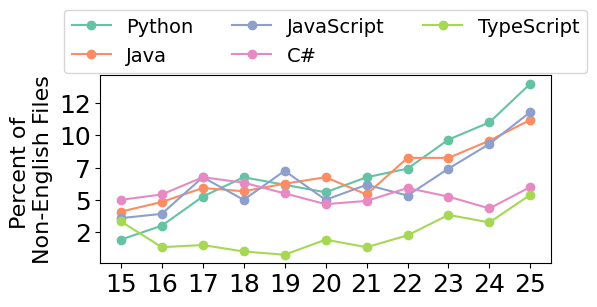

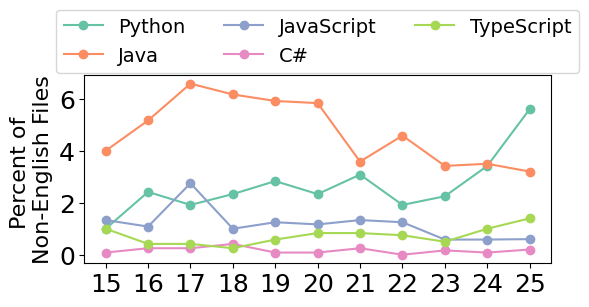

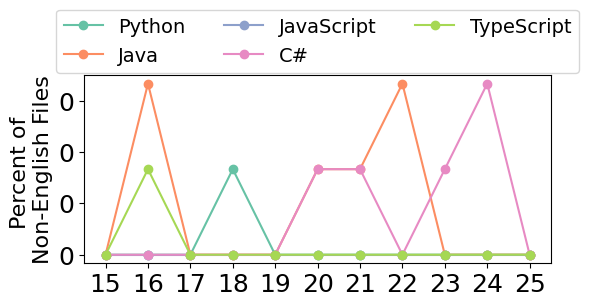

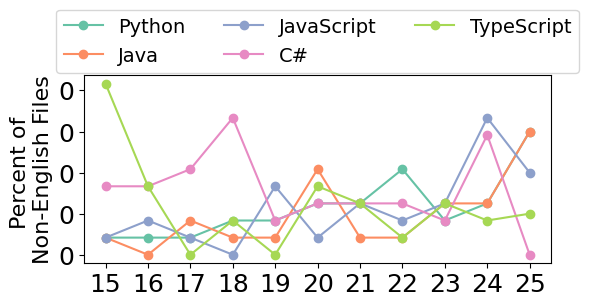

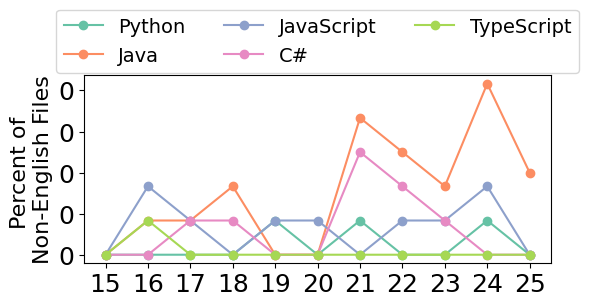

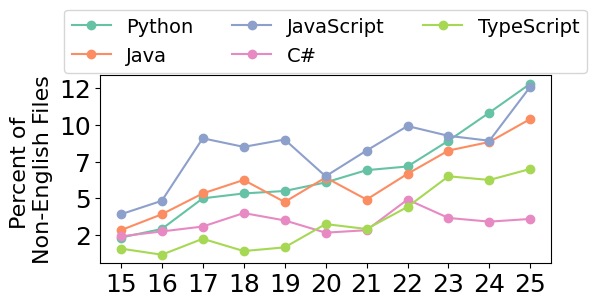

In [24]:
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
# years = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
keys = ['comments', 'docstrings', 'classes', 'identifiers', 'functions', 'literals']
language_order = ['Python', 'Java', 'JavaScript', 'C#', 'TypeScript']

for i in range(len(all_dfs)):
    key = keys[i]
    pivot_df = all_dfs[i]
    # Only plot the specified language order, if present in the DataFrame
    langs_to_plot = [lang for lang in language_order if lang in pivot_df.columns]
    pivot_df[langs_to_plot].plot(kind="line", figsize=(6, 3.5), marker='o')

    plt.ylabel("Percent of \nNon-English Files", fontsize=16)
    plt.xlabel("")  # Use empty string instead of None for type safety
    # plt.title(f"Non-English Code Content by Language: {key}")
    plt.xticks(years, [str(y)[-2:] for y in years], fontsize=18, rotation=0)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}"))
    plt.yticks(fontsize=18)
    plt.legend(ncol=3, bbox_to_anchor=(.5, 1.4), loc='upper center', fontsize=14)
    plt.tight_layout()
    plt.savefig(f"non_english_by_language_{key}.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
# import glob

# target_folder = 'rq4_logs_new'
# sub_folders = glob.glob(f"{target_folder}/*")
# char_counts = []
# valid_files = 0

# for folder in sub_folders:
#     # print(folder)
#     valid_files = 0
#     files = glob.glob(f"{folder}/*")
#     for file_ in files:
#         with open(file_, "r") as in_file:
#             data = in_file.read()
#             # char_counts.append(len(data))
#             if len(data)>=500:
#                 valid_files+=1
#                 char_counts.append(len(data))
#     if valid_files <385:
#         print("Need to download for ", folder)

# # if char_counts:
# #     min_chars = min(char_counts)
# #     print(f"Minimum number of characters: {min_chars}")
# # else:
# #     print("No files found.")

# # print(valid_files)

import glob
target_folder = 'rq4_logs_new'
sub_folders = glob.glob(f"{target_folder}/*")
year_months = set()

file_ext_dict={}
necessary_files = []
for folder in sub_folders:
    # for ext in ['.py', '.java', '.js', '.ts', '.cs']:
    # if "2015" in folder or "2016" in folder or "2017" in folder or "2018" in folder or "2022" in folder:
        # continue
    for ext in ['.py']:
        files = glob.glob(f"{folder}/*{ext}")
        valid_files = 0
        repo_ids_of_files = set()
        for file_ in files:
            with open(file_, "r") as in_file:
                data = in_file.read()
                # char_counts.append(len(data))
                if len(data)>=500:
                    # print(file_)
                    repo_id = file_.split("/")[-1].split("_")[0]
                    # print(repo_id)
                    repo_ids_of_files.add(repo_id)
                    valid_files+=1
        
        if valid_files!=0:
            if valid_files <100:
                print(f"Need to download for {ext}", folder, valid_files, 100-valid_files)
                necessary_files.append(100-valid_files)
                year_months.add(folder.split("/")[1])
            else:
                if len(repo_ids_of_files)<100:
                    print(f"Neeeeeeeed to download for {ext}", folder, len(repo_ids_of_files), 100- len(repo_ids_of_files))
                    necessary_files.append(100-len(repo_ids_of_files))
        # if len(files)<100:
        #     print(f"NOT ENOUGH FILEs for {ext} =======> {folder}, {len(files)}")
        #     if len(files)!=0:
        #         necessary_files.append(100-len(files))
        #     year_months.add(folder)

print(max(necessary_files))
# print(year_months)
# print(len(year_months))




In [ ]:
import os
import shutil

source_folder = 'logs'
target_folder = 'rq4_logs_new'

for root, dirs, files in os.walk(source_folder):
    relative_path = os.path.relpath(root, source_folder)
    target_path = os.path.join(target_folder, relative_path)

    os.makedirs(target_path, exist_ok=True)
    count = 0
    for file in files:
        src_file = os.path.join(root, file)
        dst_file = os.path.join(target_path, file)

        # If file exists, you can choose to overwrite or skip
        if not os.path.exists(dst_file):
            shutil.copy2(src_file, dst_file)
            count+=1
        else:
            # If you want to overwrite, uncomment the next line
            # shutil.copy2(src_file, dst_file)
            pass
    if count!=0:
        print("Moved ===> ", count, target_path)


In [ ]:
import glob
target_folder = 'rq4_logs_new'
sub_folders = glob.glob(f"{target_folder}/*")
year_months = set()
file_ext_dict={}
necessary_files = []
for folder in sub_folders:
    for ext in ['.py', '.java', '.js', '.ts', '.cs']:
    # if "2015" in folder or "2016" in folder or "2017" in folder or "2018" in folder or "2022" in folder:
    #     continue
    # for ext in ['.cs']:
        # print(folder)
        files = glob.glob(f"{folder}/*{ext}")
        print(folder, len(files), ext)
        # if len(files)<100:
        #     print(f"NOT ENOUGH FILEs for {ext} =======> {folder}, {len(files)}")
        #     if len(files)!=0:
        #         necessary_files.append(100-len(files))
        #     year_months.add(folder)

# max(necessary_files)

In [ ]:
import glob
target_folder = 'rq4_logs_new'
sub_folders = glob.glob(f"{target_folder}/*")
year_months = set()
file_ext_dict={}
necessary_files = []
for folder in sub_folders:
    # for ext in ['.py', '.java', '.js', '.ts', '.cs']:
    # if "2015" in folder or "2016" in folder or "2017" in folder or "2018" in folder or "2022" in folder:
    #     continue
    for ext in ['.ts']:
        # print(folder)
        files = glob.glob(f"{folder}/*{ext}")
        if len(files)<15:
            print(f"NOT ENOUGH FILEs for {ext} =======> {folder}, {len(files)}")
            if len(files)!=0:
                necessary_files.append(15-len(files))
            year_months.add(folder)

# max(necessary_files)

NOT ENOUGH FILEs for .ts =======> rq4_logs_new/2025-06, 0
NOT ENOUGH FILEs for .ts =======> rq4_logs_new/2025-08, 0
NOT ENOUGH FILEs for .ts =======> rq4_logs_new/2025-09, 0
NOT ENOUGH FILEs for .ts =======> rq4_logs_new/2025-07, 0
NOT ENOUGH FILEs for .ts =======> rq4_logs_new/2025-12, 0
NOT ENOUGH FILEs for .ts =======> rq4_logs_new/2025-10, 0
NOT ENOUGH FILEs for .ts =======> rq4_logs_new/2025-11, 0


ValueError: max() iterable argument is empty

In [82]:
import argparse
from collections import defaultdict
from multiprocessing import Pool, cpu_count
import os
from pathlib import Path
import re
import subprocess
import shutil
import pandas as pd
from datetime import datetime, timedelta
import calendar
from itertools import islice
import glob
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

def read_commits_stream(data):
    if isinstance(data, bytes):
        data = data.decode("utf-8", errors="replace")

    commit = []
    for line in data.splitlines(keepends=True):
        if line.startswith("commit ") and commit:
            yield ''.join(commit)
            commit = [line]
        else:
            commit.append(line)
    if commit:
        yield ''.join(commit)

valid_exts = (".py", ".ts", ".js", ".java", ".cs")
def is_new_file(lines):
    for line in lines:
        if line.startswith("new file mode"):
            return True
    return False

def process_commit_data(args):
    commit = args
    lines = commit.splitlines()
    if not lines or not lines[0].startswith("commit") or "[bot]" in lines[1]:
        return None
    entries = []
    commit_hash = lines[0].split()[1]
    diffs = re.split(r'diff --git a/', commit)
    date = lines[2] if len(lines) > 2 else ""

    for diff in diffs[1:]:
        lines = diff.splitlines()
        if not lines:
            continue
        fpath = lines[0].split()[0]
        if "node_modules" in fpath:
            continue
        ext = Path(fpath).suffix.lower()
        if ext not in valid_exts:
            continue
        is_new = is_new_file(lines)
        if not is_new:
            continue
        # print("DIFF ==> ", diff)
        patch_lines = [line[1:] for line in lines[1:] if line.startswith("+") and not line.startswith("+++")]
        patch_code = "\n".join(patch_lines)
        if not patch_lines:
            continue
        if len(patch_code)<500:
            continue
        return{
            "date": date,
            "commit": commit_hash,
            "file": fpath,
            "ext": ext,
            "code":patch_code
        }
        
    return None
# year_months = [
#     "2020-06", "2020-08", "2020-09", "2020-07", "2022-11", "2021-09",
#     "2025-01", "2021-07", "2021-01", "2021-06", "2021-08", "2021-12",
#     "2020-12", "2020-02", "2019-09", "2025-02", "2022-12", "2025-05",
#     "2021-03", "2021-04", "2019-01", "2021-05", "2021-02", "2022-09",
#     "2021-11", "2022-07", "2022-01", "2022-08", "2021-10", "2020-10",
#     "2020-11", "2024-10"
# ]
year_months = [
    "2022-02"
]

for year in [2019, 2020, 2021, 2022, 2023, 2024, 2025]:
# for year in [2019, 2023]:
    for month in range(1, 13):
    # for month in [1, 3, 5, 6, 7, 8]:
        ym_str = f"{year:04d}-{month:02d}"
        if ym_str not in year_months:
            continue
        try:
    # for month in [4]:
            #make a directory for the year-month
            no_new_file_count = 0
            
            out_dir = f"rq4_logs_new/{year}-{month:02d}"
            os.makedirs(out_dir, exist_ok=True)
            files = glob.glob(f"rq4_git_logs_new/{year}-{month:02d}/*")
            print(f"{year}-{month:02d} ====> number of files ===> ", len(files))
            for file_ in files:
                with open(file_,"r+") as in_file:
                    content = in_file.read()
                    if "new file mode" in content:
                        inputs = [commit for commit in read_commits_stream(content)]
                        # print(len(inputs))
                        found = False
                        for commit in inputs:
                            if "new file mode" in commit:
                                try:
                                    code_obj = process_commit_data(commit)
                                    if code_obj:
                                        # print(code_obj)
                                        # Save code to file with extension in log_file_path
                                        out_path = f"{os.path.splitext(file_)[0].replace("rq4_git_logs_new","rq4_logs_new")}_{code_obj['commit']}{code_obj['ext']}"
                                        # out_path = f"{os.path.splitext(file_)[0]}_{code_obj['commit']}{code_obj['ext']}"
                                        # print(file_, out_path)
                                        with open(out_path, "w", encoding="utf-8") as f:
                                            f.write(code_obj['code'])
                                        found = True
                                        # break
                                except Exception as e:
                                    print(f"Error processing commit in {file_}: {e}")
                                    continue
                        if not found:
                            no_new_file_count += 1
            print(f"{year}-{month:02d} ====> no new file count ===> ", no_new_file_count)
        except Exception as e:
            print(f"Error processing {year}-{month:02d}: {e}")
            continue

2022-02 ====> number of files ===>  30
2022-02 ====> no new file count ===>  5


In [38]:
import glob
from pathlib import Path
import os
import json
from collections import defaultdict
file_ext_dict ={}
target_folder = 'rq4_logs_new'
sub_folders = glob.glob(f"{target_folder}/*")
year_months = set()
file_ext_dict={}
# for ext in ['.py', '.java', '.js', '.ts', '.cs']:
for folder in sub_folders:
    files = glob.glob(f"{folder}/*")
    # print(folder, len(files))
    for file_ in files:
        ext = Path(file_).suffix.lower()
        
        folder_name = os.path.basename(folder)
        parts = folder_name.split('-')
        if len(parts) >= 2:
            year, month = parts[0], parts[1]
        else:
            year, month = "unknown", "unknown"

        base_name = os.path.basename(file_)
        json_name = f"{os.path.splitext(base_name)[0]}_{year}_{month}.json"
        out_dir = f"code_paerser_data_rq4/{year}-{month}"
        out_path = os.path.join(out_dir, json_name)
        file_ext_dict[out_path] = ext
        # break  

# file_ext_dict

target_folder = 'code_paerser_data_rq4'
sub_folders = glob.glob(f"{target_folder}/*")
year_months = set()
file_ext_dict_count={}
# for ext in ['.py', '.java', '.js', '.ts', '.cs']:
for folder in sub_folders:
    file_ext_dict_count=defaultdict(int)
    files = glob.glob(f"{folder}/*")
    for file_ in files:
        ext = file_ext_dict[file_]
        file_ext_dict_count[ext]+=1
    

    # print(folder, file_ext_dict_count)
    for ext, count in file_ext_dict_count.items():
        if count < 100:
            print(f"{folder} has less than 100 files with extension {ext}")


In [ ]:
import glob
from pathlib import Path
import os
import json
from collections import defaultdict
file_ext_dict ={}
target_folder = 'code_paerser_data'
sub_folders = glob.glob(f"{target_folder}/*")
year_months = set()
hash_dict=defaultdict(list)
# for ext in ['.py', '.java', '.js', '.ts', '.cs']:
found_id = 0
# total = 0
for folder in sub_folders:
    files = glob.glob(f"{folder}/*")
    # print(folder, len(files))
    repo_ids = set()
    total = 0
    for file_ in files:
        ext = Path(file_).suffix.lower()
        
        folder_name = os.path.basename(folder)
        parts = folder_name.split('-')
        if len(parts) >= 2:
            year, month = parts[0], parts[1]
        else:
            year, month = "unknown", "unknown"

        base_name = os.path.basename(file_)
        parts = base_name.split("_")
        # print(file_, base_name, parts)
        total+=1
        if len(parts)==4:
            repo_id = parts[0]
            found_id+=1
            repo_ids.add(repo_id)
        elif len(parts)==3:
            hash_dict[f"{year}-{month}"].append(parts[0])
        else:
            print("ERROR==============> ", parts)
    print(total, found_id, len(repo_ids), total-len(repo_ids))
import json

# If hash_dict is a defaultdict
hash_dict_regular = {k: list(v) for k, v in hash_dict.items()}
for key, values in hash_dict_regular.items():
    print(f"{key}: {len(values)}")
# with open('hash_dict.json', 'w') as f:
#     json.dump(hash_dict_regular, f, indent=2)


In [ ]:
import glob
from pathlib import Path
import os
import json
from collections import defaultdict
file_ext_dict ={}
target_folder = 'logs'
sub_folders = glob.glob(f"{target_folder}/*")
year_months = set()
hash_dict=defaultdict(list)
# for ext in ['.py', '.java', '.js', '.ts', '.cs']:
found_id = 0
# total = 0
for folder in sub_folders:
    files = glob.glob(f"{folder}/*")
    # print(folder, len(files))
    repo_ids = set()
    total = 0
    for file_ in files:
        ext = Path(file_).suffix.lower()
        
        folder_name = os.path.basename(folder)
        parts = folder_name.split('-')
        if len(parts) >= 2:
            year, month = parts[0], parts[1]
        else:
            year, month = "unknown", "unknown"

        base_name = os.path.basename(file_)
        parts = base_name.split("_")
        # print(file_, base_name, parts)
        total+=1
        if len(parts)==2:
            repo_id = parts[0]
            found_id+=1
            repo_ids.add(repo_id)
        elif len(parts)==1:
            # print(file_, base_name, parts)
            hash_dict[f"{year}-{month}"].append(parts[0])
        else:
            print("ERROR==============> ", parts)
    # print(total, found_id, len(repo_ids), total-len(repo_ids))
import json

# If hash_dict is a defaultdict
hash_dict_regular = {k: list(v) for k, v in hash_dict.items()}
# for key, values in hash_dict_regular.items():
#     print(f"{key}: {len(values)}")
with open('hash_dict.json', 'w') as f:
    json.dump(hash_dict_regular, f, indent=4)

In [ ]:
with open("hash_dict.json", "r") as f:
    data = json.load(f)

for key, values in data.items():
    print(f"{key}: {len(values)}")


In [ ]:
from tqdm import tqdm
import pandas as pd
from collections import defaultdict 
all_dicts = defaultdict(int)
for year in tqdm([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]):
    for month in range(1, 13):
        month_str = f"{month:02d}"
        file_name = f"interactions_files/push_count_{year}_{month_str}_all_days.csv"
        try:
            df = pd.read_csv(file_name)
            for index, row in df.iterrows():
                repo_id = row['repo_id']
                all_dicts[repo_id] += row['push_count']
        except:
            print(f"File not found: {file_name}")
            continue
            
all_dicts

In [ ]:
from tqdm import tqdm
import pandas as pd
from collections import defaultdict 
comment_count_dicts = defaultdict(set)
for year in tqdm([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]):
    for month in range(1, 13):
        month_str = f"{month:02d}"
        file_name = f"interactions_files/comment_count_{year}_{month_str}_all_days.csv"
        try:
            df = pd.read_csv(file_name)
            for index, row in df.iterrows():
                repo_id = row['repo_id']
                all_dicts[repo_id].add((year, month))
                all_dicts[repo_id] += row['push_count']
        except:
            print(f"File not found: {file_name}")
            continue
            
all_dicts

In [16]:
import pandas as pd
import glob

# Step 1: Combine all CSV files
csv_files = glob.glob('interactions_files/comment_count_*.csv')  # Adjust pattern as needed
# print(len(csv_files))
df_list = [pd.read_csv(f) for f in csv_files]
df = pd.concat(df_list, ignore_index=True)

print("Done fetching data from CSV files.")
comment_dict = {}

for _, row in df.iterrows():
    repo = row['repo_id']
    issue = row['issue_id']
    count = row['comment_count']
    if repo not in comment_dict:
        comment_dict[repo] = {}
    comment_dict[repo][issue] = count

print("Done processing comment counts.")
# Step 3: Find multilingual issues
# Group by repo_id and issue_id, count unique languages
multi_lang = df.groupby(['repo_id', 'issue_id'])['language'].nunique().reset_index()
multi_lang_issues = multi_lang[multi_lang['language'] > 1]

# List of (repo_id, issue_id) tuples for multilingual issues
multi_lang_issue_ids = list(zip(multi_lang_issues['repo_id'], multi_lang_issues['issue_id']))

Done fetching data from CSV files.
Done processing comment counts.


In [ ]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np

# Load CSV files
csv_files = glob.glob('interactions_files/comment_count_*.csv')
df_list = [pd.read_csv(f) for f in csv_files if f.endswith('.csv')]
if not df_list:
    raise ValueError("No CSV files found. Check the folder and file pattern.")

df = pd.concat(df_list, ignore_index=True)

# Identify multilingual issues
multi_lang = df.groupby(['repo_id', 'issue_id'])['language'].nunique().reset_index()
multi_lang_issues = multi_lang[multi_lang['language'] > 1]
multi_lang_issue_ids = set(zip(multi_lang_issues['repo_id'], multi_lang_issues['issue_id']))

# Mark multilingual
df['is_multilingual'] = df.apply(
    lambda row: (row['repo_id'], row['issue_id']) in multi_lang_issue_ids, axis=1
)

# Combine comment counts per issue
combined = df.groupby(['repo_id', 'issue_id', 'is_multilingual'])['comment_count'].sum().reset_index()

# Separate multilingual and non-multilingual
multi = combined[combined['is_multilingual']]
non_multi = combined[~combined['is_multilingual']]

# Define custom bins
max_comment_count = max(combined['comment_count'].max(), 11)
linear_bins = list(range(1, 11))  # 1 to 10
remaining_bins = np.linspace(11, max_comment_count, 20).tolist()
custom_bins = linear_bins + remaining_bins

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(multi['comment_count'], bins=custom_bins)
plt.title('Multilingual Issues')
plt.xlabel('Comment Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(non_multi['comment_count'], bins=custom_bins)
plt.title('Non-Multilingual Issues')
plt.xlabel('Comment Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


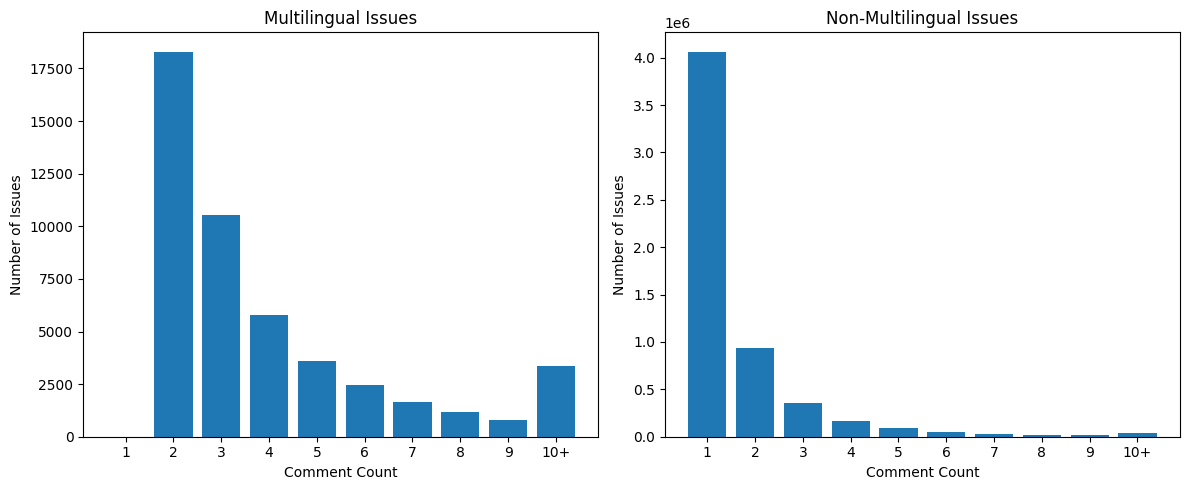

In [24]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

# Load CSV files
csv_files = glob.glob('interactions_files/comment_count_*.csv')
df_list = [pd.read_csv(f) for f in csv_files if f.endswith('.csv')]
if not df_list:
    raise ValueError("No CSV files found. Check the folder and file pattern.")

df = pd.concat(df_list, ignore_index=True)

# Identify multilingual issues
multi_lang = df.groupby(['repo_id', 'issue_id'])['language'].nunique().reset_index()
multi_lang_issues = multi_lang[multi_lang['language'] > 1]
multi_lang_issue_ids = set(zip(multi_lang_issues['repo_id'], multi_lang_issues['issue_id']))

# Mark multilingual
df['is_multilingual'] = df.apply(
    lambda row: (row['repo_id'], row['issue_id']) in multi_lang_issue_ids, axis=1
)

# Combine comment counts per issue
combined = df.groupby(['repo_id', 'issue_id', 'is_multilingual'])['comment_count'].sum().reset_index()

# Separate multilingual and non-multilingual
multi = combined[combined['is_multilingual']]
non_multi = combined[~combined['is_multilingual']]

# Function to count comment distribution
def count_distribution(data):
    dist = {i: 0 for i in range(1, 10)}
    dist['10+'] = 0
    for count in data['comment_count']:
        if count >= 10:
            dist['10+'] += 1
        elif count >= 1:
            dist[count] += 1
    return dist

# Get distributions
multi_dist = count_distribution(multi)
non_multi_dist = count_distribution(non_multi)

plt.figure(figsize=(12, 5))

# Multilingual
plt.subplot(1, 2, 1)
plt.bar([str(k) for k in multi_dist.keys()], multi_dist.values())
plt.title('Multilingual Issues')
plt.xlabel('Comment Count')
plt.ylabel('Number of Issues')

# Non-Multilingual
plt.subplot(1, 2, 2)
plt.bar([str(k) for k in non_multi_dist.keys()], non_multi_dist.values())
plt.title('Non-Multilingual Issues')
plt.xlabel('Comment Count')
plt.ylabel('Number of Issues')

plt.tight_layout()
plt.show()


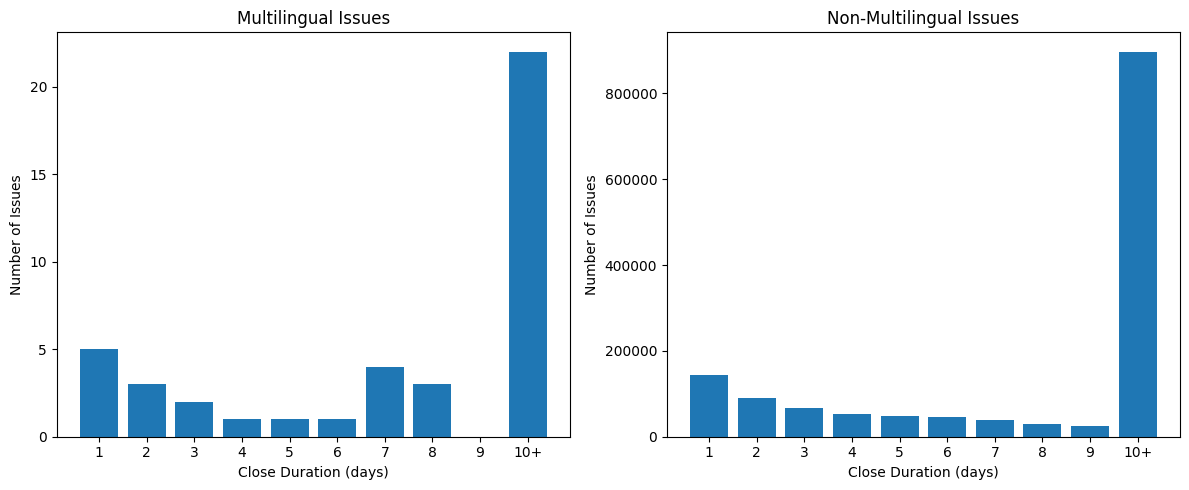

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

# Load data
# Load CSV files
csv_files = glob.glob('interactions_files/issue_close_durations*.csv')
df_list = [pd.read_csv(f) for f in csv_files if f.endswith('.csv')]
if not df_list:
    raise ValueError("No CSV files found. Check the folder and file pattern.")

df = pd.concat(df_list, ignore_index=True) # update path as needed

# Identify multilingual issues
multi_lang = df.groupby(['repo_id', 'issue_id'])['language'].nunique().reset_index()
multi_lang_issues = multi_lang[multi_lang['language'] > 1]
multi_lang_issue_ids = set(zip(multi_lang_issues['repo_id'], multi_lang_issues['issue_id']))

# Mark multilingual
df['is_multilingual'] = df.apply(
    lambda row: (row['repo_id'], row['issue_id']) in multi_lang_issue_ids, axis=1
)

# Convert duration from seconds to days
df['close_days'] = df['issue_close_duration'] / (60 * 60 * 24)

# Group by unique issues
combined = df.groupby(['repo_id', 'issue_id', 'is_multilingual'])['close_days'].mean().reset_index()

# Separate
multi = combined[combined['is_multilingual']]
non_multi = combined[~combined['is_multilingual']]

# Create duration buckets
def count_duration_distribution(data):
    dist = {i: 0 for i in range(1, 10)}
    dist['10+'] = 0
    for duration in data['close_days']:
        if duration >= 10:
            dist['10+'] += 1
        elif duration >= 1:
            dist[int(duration)] += 1
    return dist

multi_dist = count_duration_distribution(multi)
non_multi_dist = count_duration_distribution(non_multi)

# Plot
plt.figure(figsize=(12, 5))

# Multilingual
plt.subplot(1, 2, 1)
plt.bar([str(k) for k in multi_dist.keys()], multi_dist.values())
plt.title('Multilingual Issues')
plt.xlabel('Close Duration (days)')
plt.ylabel('Number of Issues')

# Non-Multilingual
plt.subplot(1, 2, 2)
plt.bar([str(k) for k in non_multi_dist.keys()], non_multi_dist.values())
plt.title('Non-Multilingual Issues')
plt.xlabel('Close Duration (days)')
plt.ylabel('Number of Issues')

plt.tight_layout()
plt.show()


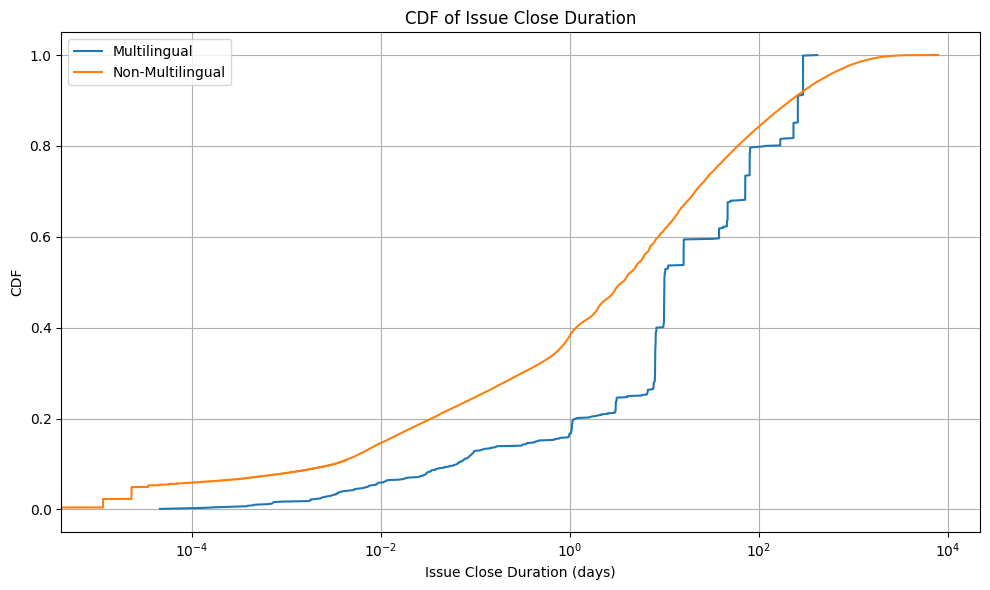

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
# Load CSV files
csv_files = glob.glob('interactions_files/issue_close_durations*.csv')
df_list = [pd.read_csv(f) for f in csv_files if f.endswith('.csv')]
if not df_list:
    raise ValueError("No CSV files found. Check the folder and file pattern.")

df = pd.concat(df_list, ignore_index=True) # update path as needed

# Identify multilingual issues
multi_lang = df.groupby(['repo_id', 'issue_id'])['language'].nunique().reset_index()
multi_lang_issues = multi_lang[multi_lang['language'] > 1]
multi_lang_issue_ids = set(zip(multi_lang_issues['repo_id'], multi_lang_issues['issue_id']))

# Mark multilingual
df['is_multilingual'] = df.apply(
    lambda row: (row['repo_id'], row['issue_id']) in multi_lang_issue_ids, axis=1
)

# Convert to days
df['close_days'] = df['issue_close_duration'] / (60 * 60 * 24)

# Drop NaNs or invalid values
df = df[df['close_days'].notna() & (df['close_days'] >= 0)]

# Separate datasets
multi = df[df['is_multilingual']]['close_days']
non_multi = df[~df['is_multilingual']]['close_days']

# Sort for CDF
multi_sorted = np.sort(multi)
non_multi_sorted = np.sort(non_multi)

# CDF values
multi_cdf = np.arange(1, len(multi_sorted)+1) / len(multi_sorted)
non_multi_cdf = np.arange(1, len(non_multi_sorted)+1) / len(non_multi_sorted)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(multi_sorted, multi_cdf, label='Multilingual')
plt.plot(non_multi_sorted, non_multi_cdf, label='Non-Multilingual')
plt.xlabel('Issue Close Duration (days)')
plt.ylabel('CDF')
plt.title('CDF of Issue Close Duration')
plt.grid(True)
plt.xscale('log')  # Log scale for better visibility
plt.legend()
plt.tight_layout()
plt.show()


4807232 PRs loaded.
4805746 Unique PRs after dropping duplicates. 1486 duplicates removed.


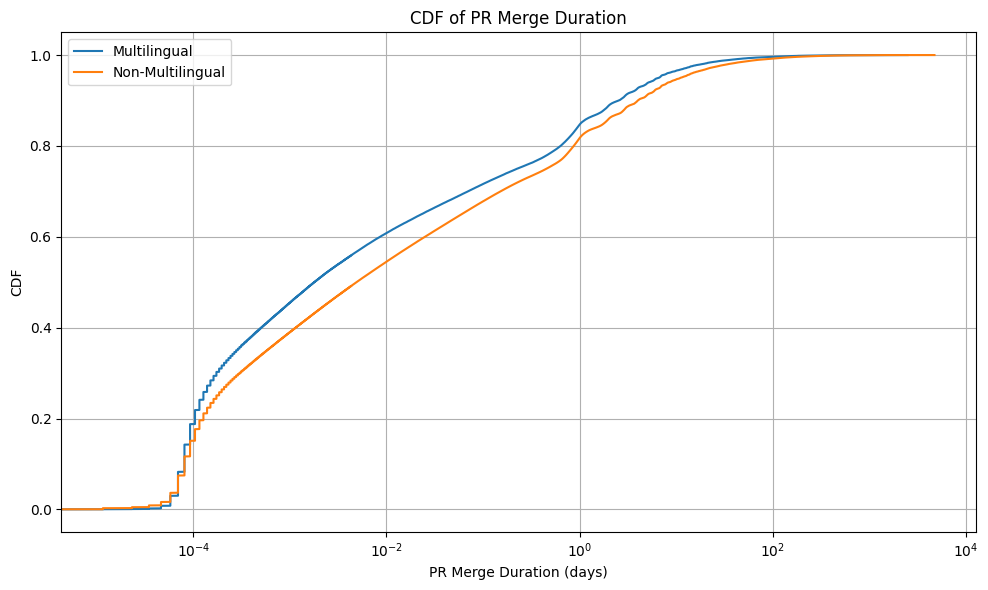

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

# Load CSV files
csv_files = glob.glob('interactions_files/pr_merge_durations*.csv')
df_list = [pd.read_csv(f) for f in csv_files if f.endswith('.csv')]
if not df_list:
    raise ValueError("No CSV files found. Check the folder and file pattern.")

df = pd.concat(df_list, ignore_index=True)
print(len(df), "PRs loaded.")
original_length = len(df)
# # find the duplicates based on 'pr_id'
# duplicates = df[df.duplicated(subset=['pr_id'], keep=False)]
# duplicates = duplicates[duplicates['language']!='english']
# print(len(duplicates), "Duplicates found based on 'pr_id'.")
# print("Example duplicates:")
# # save the duplicates to a CSV file for inspection
# duplicates.to_csv('duplicates_prs.csv', index=False)
df = df.drop_duplicates(subset=['pr_id'], keep='first').reset_index(drop=True)
print(len(df), "Unique PRs after dropping duplicates.", original_length - len(df), "duplicates removed.")


df['close_days'] = df['pr_merge_duration'] / (60 * 60 * 24)
df = df[df['close_days'].notna() & (df['close_days'] >= 0)]

multi = df[df['language']!= 'english']['close_days']
non_multi = df[df['language'] == 'english']['close_days']

# Sort for CDF
multi_sorted = np.sort(multi)
non_multi_sorted = np.sort(non_multi)

# CDF values
multi_cdf = np.arange(1, len(multi_sorted)+1) / len(multi_sorted)
non_cdf = np.arange(1, len(non_multi_sorted)+1) / len(non_multi_sorted)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(multi_sorted, multi_cdf, label='Multilingual')
plt.plot(non_multi_sorted, non_cdf, label='Non-Multilingual')
plt.xlabel('PR Merge Duration (days)')
plt.ylabel('CDF')
plt.title('CDF of PR Merge Duration')
plt.grid(True)
plt.xscale('log')  # optional
plt.legend()
plt.tight_layout()
plt.show()


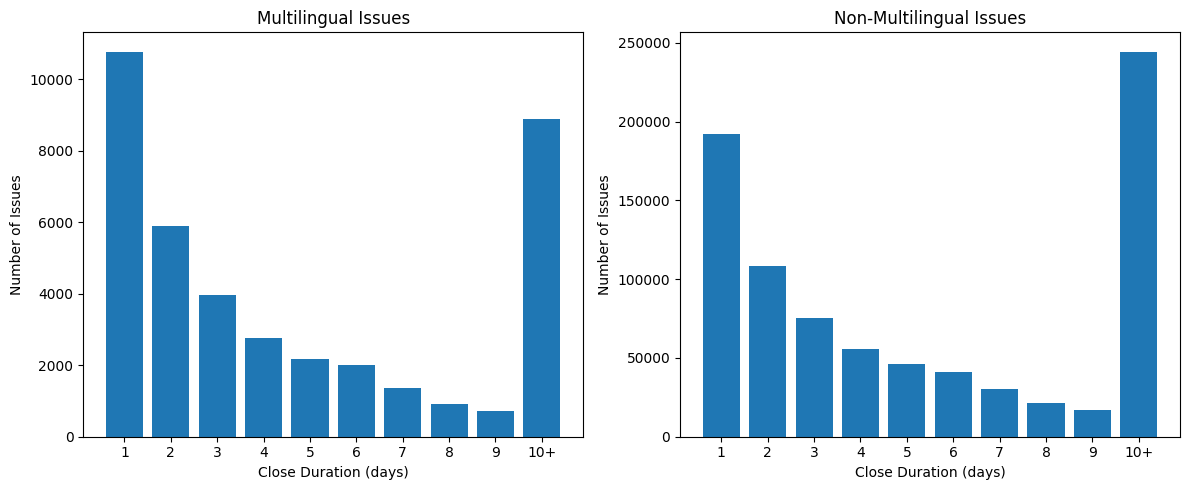

In [36]:
def count_duration_distribution(data):
    dist = {i: 0 for i in range(1, 10)}
    dist['10+'] = 0
    for duration in data['close_days']:
        if duration >= 10:
            dist['10+'] += 1
        elif duration >= 1:
            dist[int(duration)] += 1
    return dist

multi = df[df['language']!= 'english']
non_multi = df[df['language'] == 'english']
multi_dist = count_duration_distribution(multi)
non_multi_dist = count_duration_distribution(non_multi)

# Plot
plt.figure(figsize=(12, 5))

# Multilingual
plt.subplot(1, 2, 1)
plt.bar([str(k) for k in multi_dist.keys()], multi_dist.values())
plt.title('Multilingual Issues')
plt.xlabel('Close Duration (days)')
plt.ylabel('Number of Issues')

# Non-Multilingual
plt.subplot(1, 2, 2)
plt.bar([str(k) for k in non_multi_dist.keys()], non_multi_dist.values())
plt.title('Non-Multilingual Issues')
plt.xlabel('Close Duration (days)')
plt.ylabel('Number of Issues')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

# Load data
# Load CSV files
csv_files = glob.glob('interactions_files/time_to_first_interactions_*.csv')
df_list = [pd.read_csv(f) for f in csv_files if f.endswith('.csv')]
if not df_list:
    raise ValueError("No CSV files found. Check the folder and file pattern.")

df = pd.concat(df_list, ignore_index=True) # update path as needed

# Identify multilingual issues
multi_lang = df.groupby(['repo_id', 'issue_id'])['language'].nunique().reset_index()
multi_lang_issues = multi_lang[multi_lang['language'] > 1]
# multi_lang_issue_ids = set(zip(multi_lang_issues['repo_id'], multi_lang_issues['issue_id']))

# # Mark multilingual
# df['is_multilingual'] = df.apply(
#     lambda row: (row['repo_id'], row['issue_id']) in multi_lang_issue_ids, axis=1
# )

# # Convert duration from seconds to days
# df['close_days'] = df['issue_close_duration'] / (60 * 60 * 24)

# # Group by unique issues
# combined = df.groupby(['repo_id', 'issue_id', 'is_multilingual'])['close_days'].mean().reset_index()

# # Separate
# multi = combined[combined['is_multilingual']]
# non_multi = combined[~combined['is_multilingual']]

# # Create duration buckets
# def count_duration_distribution(data):
#     dist = {i: 0 for i in range(1, 10)}
#     dist['10+'] = 0
#     for duration in data['close_days']:
#         if duration >= 10:
#             dist['10+'] += 1
#         elif duration >= 1:
#             dist[int(duration)] += 1
#     return dist

# multi_dist = count_duration_distribution(multi)
# non_multi_dist = count_duration_distribution(non_multi)

# # Plot
# plt.figure(figsize=(12, 5))

# # Multilingual
# plt.subplot(1, 2, 1)
# plt.bar([str(k) for k in multi_dist.keys()], multi_dist.values())
# plt.title('Multilingual Issues')
# plt.xlabel('Close Duration (days)')
# plt.ylabel('Number of Issues')

# # Non-Multilingual
# plt.subplot(1, 2, 2)
# plt.bar([str(k) for k in non_multi_dist.keys()], non_multi_dist.values())
# plt.title('Non-Multilingual Issues')
# plt.xlabel('Close Duration (days)')
# plt.ylabel('Number of Issues')

# plt.tight_layout()
# plt.show()


In [ ]:
from tqdm import tqdm
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed

push_counts = defaultdict(int)
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
months = range(1, 13)

def process_push_file(args):
    year, month = args
    month_str = f"{month:02d}"
    file_name = f"interactions_files_new/push_count_{year}_{month_str}_all_days.csv"
    local_counts = defaultdict(int)
    try:
        df = pd.read_csv(file_name)
        for _, row in df.iterrows():
            repo_id = row['repo_id']
            local_counts[repo_id] += row['push_count']
    except:
        print(f"Push file not found: {file_name}")
    return local_counts

tasks = [(year, month) for year in years for month in months]
with ThreadPoolExecutor() as executor:
    for local_counts in tqdm(executor.map(process_push_file, tasks), total=len(tasks)):
        for repo_id, count in local_counts.items():
            push_counts[repo_id] += count


  0%|          | 0/132 [01:30<?, ?it/s]


In [145]:
# Step 2: Load comment counts and track language per issue
comment_counts = defaultdict(int)
issue_languages = defaultdict(set)  # key: (repo_id, issue_id)
repo_files = defaultdict(list)  # key: repo_id, value: list of file names

for year in tqdm([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]):
    for month in range(1, 13):
        month_str = f"{month:02d}"
        file_name = f"interactions_files/comment_count_{year}_{month_str}_all_days.csv"
        try:
            df = pd.read_csv(file_name)
            for _, row in df.iterrows():
                repo_id = row['repo_id']
                issue_id = row['issue_id']
                comment_counts[repo_id] += row['comment_count']
                issue_languages[(repo_id, issue_id)].add(row['language'])
                # if 'html_url' in row:
                repo_files[repo_id].append(row['html_url'])
        except:
            print(f"Comment file not found: {file_name}")
            continue

# Step 3: Decide if each repo is multilingual
repo_is_multilingual = defaultdict(bool)

for (repo_id, issue_id), langs in issue_languages.items():
    if len(langs) > 1:
        repo_is_multilingual[repo_id] = True

# Step 4: Combine and prepare plot data
all_repos = set(push_counts.keys()).union(comment_counts.keys())
plot_data = []

for repo_id in all_repos:
    plot_data.append({
        'repo_id': repo_id,
        'push_count': push_counts.get(repo_id, 0),
        'comment_count': comment_counts.get(repo_id, 0),
        'is_multilingual': repo_is_multilingual.get(repo_id, False),
        'html_url': repo_files.get(repo_id, [])
    })

df_plot = pd.DataFrame(plot_data)

# # Step 5: Plot
# plt.figure(figsize=(10, 6))
# multi = df_plot[df_plot['is_multilingual']]
# non_multi = df_plot[~df_plot['is_multilingual']]

# plt.scatter(multi['push_count'], multi['comment_count'], alpha=0.5, label='Multilingual', s=20)
# plt.scatter(non_multi['push_count'], non_multi['comment_count'], alpha=0.5, label='Non-Multilingual', s=20)

# plt.xlabel('Push Count (per Repo)')
# plt.ylabel('Comment Count (per Repo)')
# plt.title('Repo Push Count vs Issue Comment Count')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

100%|██████████| 11/11 [04:27<00:00, 24.34s/it]

Comment file not found: interactions_files/comment_count_2025_06_all_days.csv
Comment file not found: interactions_files/comment_count_2025_07_all_days.csv
Comment file not found: interactions_files/comment_count_2025_08_all_days.csv
Comment file not found: interactions_files/comment_count_2025_09_all_days.csv
Comment file not found: interactions_files/comment_count_2025_10_all_days.csv
Comment file not found: interactions_files/comment_count_2025_11_all_days.csv
Comment file not found: interactions_files/comment_count_2025_12_all_days.csv



Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x107ead160>>
Traceback (most recent call last):
  File "/Users/masudhasan/Music/github_data/evenv/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
from tqdm import tqdm
import pandas as pd
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
import os

comment_counts = defaultdict(int)
issue_languages = defaultdict(set)
repo_files = defaultdict(list)

years = list(range(2015, 2026))
months = [f"{month:02d}" for month in range(1, 13)]
file_list = [f"interactions_files/comment_count_{year}_{month}_all_days.csv" for year in years for month in months]

# Lock is used to safely update shared data structures
from threading import Lock
lock = Lock()

def process_file(file_name):
    local_comment_counts = defaultdict(int)
    local_issue_languages = defaultdict(set)
    local_repo_files = defaultdict(list)

    if not os.path.exists(file_name):
        return None

    try:
        df = pd.read_csv(file_name)
        for _, row in df.iterrows():
            repo_id = row['repo_id']
            issue_id = row['issue_id']
            local_comment_counts[repo_id] += row['comment_count']
            local_issue_languages[(repo_id, issue_id)].add(row['language'])
            if repo_id == 724712 and "chinese" in row['language']:
                print(file_name)
                print(f"Found specific issue: {repo_id}, {issue_id} with language {row['html_url']}")
    except:
        print(f"Failed to read: {file_name}")
        return None

    return (local_comment_counts, local_issue_languages, local_repo_files)

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_file, file) for file in file_list]
    for future in tqdm(as_completed(futures), total=len(futures)):
        result = future.result()
        if result:
            local_comment_counts, local_issue_languages, local_repo_files = result
            with lock:
                for k, v in local_comment_counts.items():
                    comment_counts[k] += v
                for k, v in local_issue_languages.items():
                    issue_languages[k].update(v)
                for k, v in local_repo_files.items():
                    repo_files[k].extend(v)

# Step 3: Decide if each repo is multilingual
repo_is_multilingual = defaultdict(bool)
for (repo_id, issue_id), langs in issue_languages.items():
    if len(langs) > 1:
        print(f"Multilingual issue found: {repo_id}, {issue_id} with languages {langs}")
        repo_is_multilingual[repo_id] = True

# Step 4: Combine and prepare plot data
all_repos = set(push_counts.keys()).union(comment_counts.keys())
plot_data = []

for repo_id in all_repos:
    plot_data.append({
        'repo_id': repo_id,
        'push_count': push_counts.get(repo_id, 0),
        'comment_count': comment_counts.get(repo_id, 0),
        'is_multilingual': repo_is_multilingual.get(repo_id, False),
        'html_url': repo_files.get(repo_id, [])
    })

df_plot = pd.DataFrame(plot_data)


In [ ]:
# https://github.com/rust-lang/rust/pull/20388#issuecomment-68480522

# Step 2: Load comment counts and track language per issue
from tqdm import tqdm
import pandas as pd
from collections import defaultdict
comment_counts = defaultdict(int)
issue_languages = defaultdict(set)  # key: (repo_id, issue_id)
repo_files = defaultdict(list)  # key: repo_id, value: list of file names

for year in tqdm([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]):
    for month in range(1, 13):
        month_str = f"{month:02d}"
        file_name = f"interactions_files_new/comment_count_{year}_{month_str}_all_days.csv"
        try:
            df = pd.read_csv(file_name)
            for _, row in df.iterrows():
                repo_id = row['repo_id']
                issue_id = row['issue_id']
                comment_counts[repo_id] += row['comment_count']
                issue_languages[(repo_id, issue_id)].add(row['language'])
                # if 'html_url' in row:
                if repo_id==724712 and "chinese" in row['language']:
                    print(file_name)
                    print(f"Found specific issue: {repo_id}, {issue_id} with language {row['html_url']}")
                # repo_files[repo_id].append(row['html_url'])
        except:
            print(f"Comment file not found: {file_name}")
            continue

# Step 3: Decide if each repo is multilingual
repo_is_multilingual = defaultdict(bool)

for (repo_id, issue_id), langs in issue_languages.items():
    if len(langs) > 1:
        # print(f"Multilingual issue found: {repo_id}, {issue_id} with languages {langs}")
        repo_is_multilingual[repo_id] = True

# Step 4: Combine and prepare plot data
all_repos = set(push_counts.keys()).union(comment_counts.keys())
plot_data = []

for repo_id in all_repos:
    plot_data.append({
        'repo_id': repo_id,
        'push_count': push_counts.get(repo_id, 0),
        'comment_count': comment_counts.get(repo_id, 0),
        'is_multilingual': repo_is_multilingual.get(repo_id, False),
        'html_url': repo_files.get(repo_id, [])
    })

df_plot = pd.DataFrame(plot_data)

# # Step 5: Plot
# plt.figure(figsize=(10, 6))
# multi = df_plot[df_plot['is_multilingual']]
# non_multi = df_plot[~df_plot['is_multilingual']]

# plt.scatter(multi['push_count'], multi['comment_count'], alpha=0.5, label='Multilingual', s=20)
# plt.scatter(non_multi['push_count'], non_multi['comment_count'], alpha=0.5, label='Non-Multilingual', s=20)

# plt.xlabel('Push Count (per Repo)')
# plt.ylabel('Comment Count (per Repo)')
# plt.title('Repo Push Count vs Issue Comment Count')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [2]:
import pandas as pd

# Load the data
df = pd.read_csv("all_repo_comment_counts.csv")

# Group by repo and calculate classification
repo_classification = []

for repo_id, group in df.groupby("repo_id"):
    lang_counts = group.set_index("language")["comment_count"].to_dict()
    total_comments = sum(lang_counts.values())

    # print(repo_id, total_comments)

    english_comments = lang_counts.get("english", 0)
    english_ratio = english_comments / total_comments

    # Check if English dominates
    if english_ratio >= 0.9:
        repo_class = "english"
    else:
        # Check if any non-English language dominates
        non_english_dominant = None
        for lang, count in lang_counts.items():
            if lang != "english" and (count / total_comments) >= 0.9:
                non_english_dominant = lang
                break
        if non_english_dominant:
            repo_class = non_english_dominant
        else:
            repo_class = "mixed"

    repo_classification.append({
        "repo_id": repo_id,
        "total_comments": total_comments,
        "classification": repo_class
    })

# Convert to DataFrame and save
df_classified = pd.DataFrame(repo_classification)
df_classified.to_csv("repo_language_classification.csv", index=False)

print("Saved repo classifications to repo_language_classification.csv")


Saved repo classifications to repo_language_classification.csv


In [53]:
import requests

def get_repo_name(repo_id):
    url = f"https://api.github.com/repositories/{repo_id}"
    headers = {"Accept": "application/vnd.github.v3+json"}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        return None

df = pd.read_csv('repo_language_classification1.csv')
code_repos_df = pd.read_csv('code_repo_classification.csv')
code_repos_df = code_repos_df[code_repos_df['is_multi']==True].reset_index(drop=True)
mixed = df[df['classification']=='mixed'].reset_index(drop=True)
ids = mixed['repo_id'].tolist()
for i in range(len(code_repos_df)):
    id = code_repos_df.iloc[i]['repo_id']
    if id not in ids:
        print("Repo ID: ", id)
        print(get_repo_name(id))
        break
# code_repos_df
# common = pd.merge(mixed, code_repos_df, on='repo_id', how='inner')
# common

Repo ID:  11921791
{'id': 11921791, 'node_id': 'MDEwOlJlcG9zaXRvcnkxMTkyMTc5MQ==', 'name': 'lxqt-panel', 'full_name': 'lxqt/lxqt-panel', 'private': False, 'owner': {'login': 'lxqt', 'id': 32845505, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjMyODQ1NTA1', 'avatar_url': 'https://avatars.githubusercontent.com/u/32845505?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/lxqt', 'html_url': 'https://github.com/lxqt', 'followers_url': 'https://api.github.com/users/lxqt/followers', 'following_url': 'https://api.github.com/users/lxqt/following{/other_user}', 'gists_url': 'https://api.github.com/users/lxqt/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/lxqt/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/lxqt/subscriptions', 'organizations_url': 'https://api.github.com/users/lxqt/orgs', 'repos_url': 'https://api.github.com/users/lxqt/repos', 'events_url': 'https://api.github.com/users/lxqt/events{/privacy}', 'received_events_url': 'https://api.github

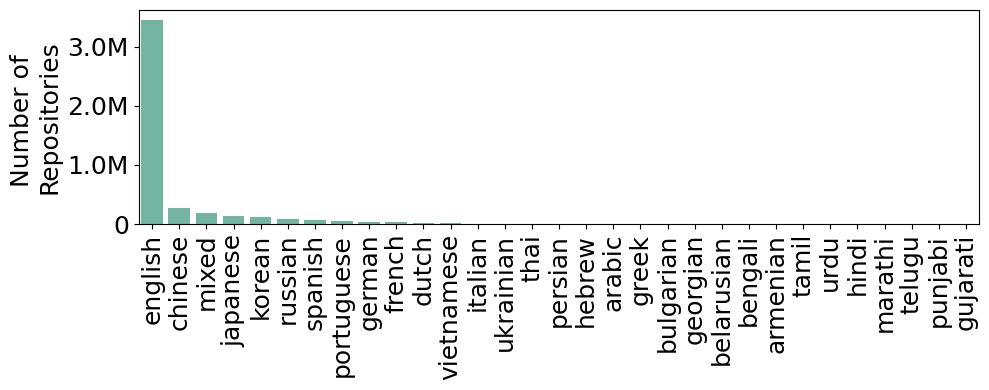

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
sns.set_palette("Set2")
# Load the data
df = pd.read_csv('repo_language_classification1.csv')

# Count number of repos per classification
class_counts = df['classification'].value_counts().reset_index()
class_counts.columns = ['classification', 'count']

# Plot with seaborn
plt.figure(figsize=(10, 4))
sns.barplot(data=class_counts, x='classification', y='count')
# plt.yscale("log")
plt.ylabel("Number of \nRepositories", fontsize=18)
plt.xlabel(None)
# plt.title("Number of Repos by Language Classification")
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
def millions(x, pos):
    return f'{x/1e6:.1f}M' if x >= 1e6 else (f'{x/1e3:.0f}k' if x >= 1e3 else str(int(x)))
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
plt.tight_layout()
plt.savefig("RQ5.pdf", bbox_inches="tight")
plt.show()



In [146]:
# find multilingual repos with high push counts
high_push_multilingual = df_plot[(df_plot['is_multilingual']) & (df_plot['comment_count'] > 20000)]
high_push_multilingual

repo_id  push_count  comment_count  is_multilingual  \
245972     724712        1925          27808             True   
1700031   4542716       10589          25633             True   
6055999  17165658        1327          25263             True   
7337689  20580498         261          28740             True   

                                                  html_url  
245972   [https://github.com/rust-lang/rust/pull/20388#...  
1700031  [https://github.com/NixOS/nixpkgs/issues/5512#...  
6055999  [https://github.com/apache/spark/pull/3867#iss...  
7337689  [https://github.com/GoogleCloudPlatform/kubern...

In [1]:
import pandas as pd
push_df = pd.read_csv("push_counts.csv")
push_df

repo_id  push_count
0           28635890           2
1           26392647           6
2            5152285        5323
3           28520835           4
4           25334511        3228
...              ...         ...
232313545  993984931           1
232313546  993984729           1
232313547  993983884           1
232313548  993984944           1
232313549  831914925           1

[232313550 rows x 2 columns]

In [ ]:
import pandas as pd
df = pd.read_csv('repo_language_classification1.csv')
repo_ids = df['repo_id'].tolist()
len(repo_ids)

for idx


4469684

In [5]:
import pandas as pd
df = pd.read_csv("Multi_repo.csv")
high_push_multilingual = df[(df['is_multilingual']) & (df['comment_count'] > 2000)]
high_push_multilingual

repo_id  push_count  comment_count  is_multilingual
252       17165658        1329           3264             True
492        4542716       10639           8974             True
1829       3234987        2544           3029             True
3852       5973855        1161           2250             True
4362        724712        1925           7774             True
5456       1644196        1877           2358             True
6219       1920851        3234           3100             True
19534      7691631         443           2532             True
42460      3638964        1108           2532             True
42655     20580498         261           6540             True
43949     16563587        1089           4393             True
48178     20929025         907           2931             True
48459     29078997        1053           2256             True
48590     17620347        1361           2395             True
52802     27193779        1033           2921             True
54790       507775        3540           2473             True
58126     10969551        2487           3400             True
75368       858127         833           2210             True
94616     29028775         168           2507             True
112539    12888993        2977           5269             True
193341    15634981         894           4490             True
215929    24195339        1357           2441             True
545468     2884111         162           2649             True
606179    41881900        3531           7357             True
789993    31792824         675           7236             True
870911    45717250        1474           4691             True
1569298   70107786        1253           2138             True
1917862   72685026         841           6916             True
2022983   74175805         855           2471             True
2140243   65600975       17503           3799             True
2286081   80862584        3580           3186             True
3926001   17914657           1           2716             True
4352406  133843125        4027           2501             True
4411385  105808767         513           2085             True
6365378  210716005         967           3137             True
9095938  285902689        1392           4560             True

/var/folders/_0/frzsx3s9691dqywldb6cqgb80000gn/T/ipykernel_47977/2529934903.py:17: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/masudhasan/Music/github_data/evenv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


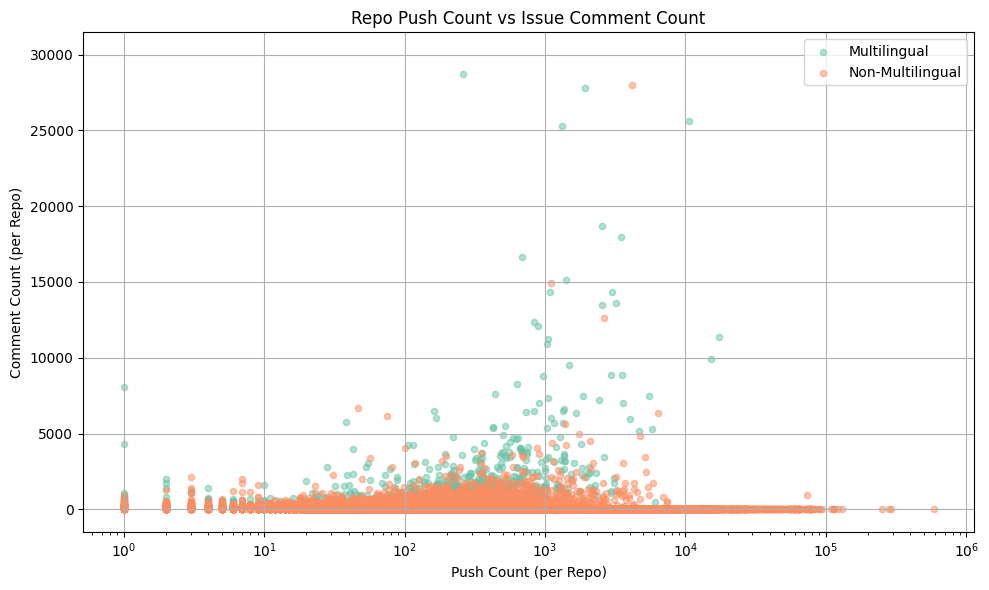

In [141]:
df_plot = pd.DataFrame(plot_data)

# Step 5: Plot
plt.figure(figsize=(10, 6))
multi = df_plot[df_plot['is_multilingual']]
non_multi = df_plot[~df_plot['is_multilingual']]

plt.scatter(multi['push_count'], multi['comment_count'], alpha=0.5, label='Multilingual', s=20)
plt.scatter(non_multi['push_count'], non_multi['comment_count'], alpha=0.5, label='Non-Multilingual', s=20)

plt.xlabel('Push Count (per Repo)')
plt.ylabel('Comment Count (per Repo)')
plt.title('Repo Push Count vs Issue Comment Count')
plt.legend()
plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# --- Load and process issue close durations for multilingual analysis (per issue, not per repo) ---

import pandas as pd
from collections import defaultdict
from tqdm import tqdm

# Step 1: Load issue close durations and track language per issue
close_durations = []  # List of dicts, each row is an issue
issue_languages = defaultdict(set)  # key: (repo_id, issue_id)

for year in tqdm([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]):
    for month in range(1, 13):
        month_str = f"{month:02d}"
        file_name = f"interactions_files/issue_close_durations_{year}_{month_str}_all_days.csv"
        try:
            df = pd.read_csv(file_name)
            for _, row in df.iterrows():
                repo_id = row['repo_id']
                issue_id = row['issue_id']
                duration = row['issue_close_duration']
                lang = row['language']
                close_durations.append({
                    'repo_id': repo_id,
                    'issue_id': issue_id,
                    'close_duration': duration,
                    'language': lang
                })
                issue_languages[(repo_id, issue_id)].add(lang)
        except Exception:
            print(f"Issue close duration file not found: {file_name}")
            continue

# Step 2: Mark each issue as multilingual or not
for entry in close_durations:
    key = (entry['repo_id'], entry['issue_id'])
    entry['is_multilingual'] = len(issue_languages[key]) > 1


all_repos = set(push_counts.keys()).union(comment_counts.keys())
plot_data = []

for repo_id in all_repos:
    plot_data.append({
        'repo_id': repo_id,
        'push_count': push_counts.get(repo_id, 0),
        'comment_count': comment_counts.get(repo_id, 0),
        'is_multilingual': repo_is_multilingual.get(repo_id, False),
        'html_url': repo_files.get(repo_id, [])
    })

df_plot = pd.DataFrame(plot_data)

# Step 3: Convert to DataFrame for plotting
df_close_plot = pd.DataFrame(close_durations)
# Each row is a single issue, with

100%|██████████| 11/11 [01:50<00:00, 10.02s/it]

Issue close duration file not found: interactions_files/issue_close_durations_2025_06_all_days.csv
Issue close duration file not found: interactions_files/issue_close_durations_2025_07_all_days.csv
Issue close duration file not found: interactions_files/issue_close_durations_2025_08_all_days.csv
Issue close duration file not found: interactions_files/issue_close_durations_2025_09_all_days.csv
Issue close duration file not found: interactions_files/issue_close_durations_2025_10_all_days.csv
Issue close duration file not found: interactions_files/issue_close_durations_2025_11_all_days.csv
Issue close duration file not found: interactions_files/issue_close_durations_2025_12_all_days.csv


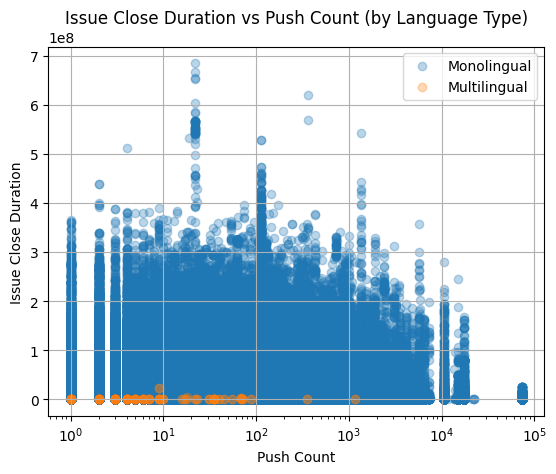

In [8]:
import matplotlib.pyplot as plt

df_issues = pd.DataFrame(close_durations)

# Add push count from dictionary
df_issues['push_count'] = df_issues['repo_id'].map(push_counts)

# Drop missing values
df_issues = df_issues.dropna(subset=['push_count', 'close_duration'])

# Ensure numeric type
df_issues['close_duration'] = pd.to_numeric(df_issues['close_duration'], errors='coerce')
df_issues = df_issues.dropna(subset=['close_duration'])
import matplotlib.pyplot as plt

# Split data
df_multi = df_issues[df_issues['is_multilingual'] == True]
df_mono = df_issues[df_issues['is_multilingual'] == False]

# Plot both
plt.scatter(df_mono['push_count'], df_mono['close_duration'], label='Monolingual', alpha=0.3)
plt.scatter(df_multi['push_count'], df_multi['close_duration'], label='Multilingual', alpha=0.3)

plt.xlabel('Push Count')
plt.ylabel('Issue Close Duration')
plt.title('Issue Close Duration vs Push Count (by Language Type)')
plt.legend()
plt.xscale('log')  # Log scale for better visibility
plt.grid(True)
plt.show()



In [ ]:
df_plot = df_close_plot
# Step 5: Plot
plt.figure(figsize=(10, 6))
multi = df_plot[df_plot['is_multilingual']]
non_multi = df_plot[~df_plot['is_multilingual']]

plt.scatter(multi['push_count'], multi['comment_count'], alpha=0.5, label='Multilingual', s=20)
plt.scatter(non_multi['push_count'], non_multi['comment_count'], alpha=0.5, label='Non-Multilingual', s=20)

plt.xlabel('Push Count (per Repo)')
plt.ylabel('Comment Count (per Repo)')
plt.title('Repo Push Count vs Issue Comment Count')
plt.legend()
plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

In [172]:
import pandas as pd
import matplotlib.pyplot as plt

english_repos = defaultdict(set)
non_english_repos = defaultdict(set)

df = pd.read_csv('language_detection_documentation.csv')
df['language_clean'] = df['language'].str.strip("{}").str.lower().str.replace("'", "").str.split(', ')
df['lang_group'] = df['language_clean'].apply(
    lambda langs: 'English' if isinstance(langs, list) and len(langs) == 1 and langs[0] == 'english' else 'Non-English'
)
english_df = df[df['lang_group'] == 'English']
non_english_df = df[df['lang_group'] == 'Non-English']

# english_documentation_files = english_df['file'].tolist()
# non_english_documentation_files = non_english_df['file'].tolist()
for file_, date in english_df[['file', 'date']].values:
    repo_id = file_.split('/')[-1].split('_')[0]
    english_repos[date].add(repo_id)
for file_, date in non_english_df[['file', 'date']].values:
    repo_id = file_.split('/')[-1].split('_')[0]
    non_english_repos[date].add(repo_id)

print(len(english_repos), "English Repos")
print(len(non_english_repos), "Non-English Repos")
for date in english_repos:
    print(f"{date}: {len(english_repos[date])} English Repos")
for date in non_english_repos:
    print(f"{date}: {len(non_english_repos[date])} Non-English Repos")

125 English Repos
125 Non-English Repos
2020-01: 355 English Repos
2020-06: 346 English Repos
2024-09: 338 English Repos
2017-10: 348 English Repos
2024-07: 336 English Repos
2023-10: 331 English Repos
2020-08: 329 English Repos
2018-05: 350 English Repos
2018-02: 357 English Repos
2023-11: 333 English Repos
2024-06: 339 English Repos
2020-09: 351 English Repos
2024-01: 346 English Repos
2017-11: 342 English Repos
2020-07: 346 English Repos
2024-08: 358 English Repos
2018-03: 342 English Repos
2018-04: 350 English Repos
2022-11: 344 English Repos
2021-09: 343 English Repos
2016-11: 346 English Repos
2025-01: 348 English Repos
2015-09: 351 English Repos
2021-07: 349 English Repos
2015-07: 357 English Repos
2019-03: 350 English Repos
2019-04: 346 English Repos
2021-01: 353 English Repos
2015-06: 371 English Repos
2015-01: 534 English Repos
2021-06: 340 English Repos
2016-10: 352 English Repos
2015-08: 365 English Repos
2022-10: 338 English Repos
2021-08: 337 English Repos
2019-05: 336 En

In [93]:
df = pd.read_csv("test_only/messages_with_languages_2025_05_01.csv")
issuecomments = df[df['event_type'] == 'IssueCommentEvent']
print(len(df), "Messages loaded.", len(issuecomments), "Issue comments loaded.", (len(issuecomments)/len(df))*100, "Issue comments ratio.")
df = df.drop_duplicates(keep='first').reset_index(drop=True)
issuecomments = df[df['event_type'] == 'IssueCommentEvent']
print(len(df), "Messages after dropping duplicates.", len(issuecomments), "Issue comments after dropping duplicates.", (len(issuecomments)/len(df))*100, "Issue comments ratio after dropping duplicates.")
df_korean = df[df['language'] == 'korean']
print(len(df_korean), "Korean messages loaded.")

234515 Messages loaded. 57297 Issue comments loaded. 24.432125876809586 Issue comments ratio.
206288 Messages after dropping duplicates. 57297 Issue comments after dropping duplicates. 27.775246257659198 Issue comments ratio after dropping duplicates.
11079 Korean messages loaded.


In [ ]:
df = pd.read_csv("resul_files/messages_with_languages_2025_01_01.csv")
print(len(df), "Messages loaded.", len(issuecomments))
df = df.drop_duplicates(keep='first').reset_index(drop=True)
print(len(df), "Messages after dropping duplicates.")
df = pd.read_csv("resul_files/script_count_2025_01_01.csv")
print(df['count'].sum(), "Total scripts loaded.")

df = pd.read_csv("language_counts_2025_01_01.csv")
print(df['count'].sum(), "New Total scripts loaded.")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('language_counts_by_month_2025.csv')

# Get total messages per date (including English)
total_per_date = df.groupby('date')['count'].sum()

# Remove English
df_no_en = df[df['language'].str.lower() != 'english']

# Get top 10 non-English languages
top_langs = (
    df_no_en.groupby('language')['count']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index.tolist()
)

# Keep only those top 10
df_top = df_no_en[df_no_en['language'].isin(top_langs)]

# Pivot to get date x language matrix
pivot_df = df_top.pivot(index='date', columns='language', values='count').fillna(0)

# Divide each language's count by total messages on that date (including English)
percent_df = pivot_df.div(total_per_date, axis=0) * 100

# Plot
percent_df.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title('Top 10 Non-English Languages as % of All Messages per Month (2024)')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


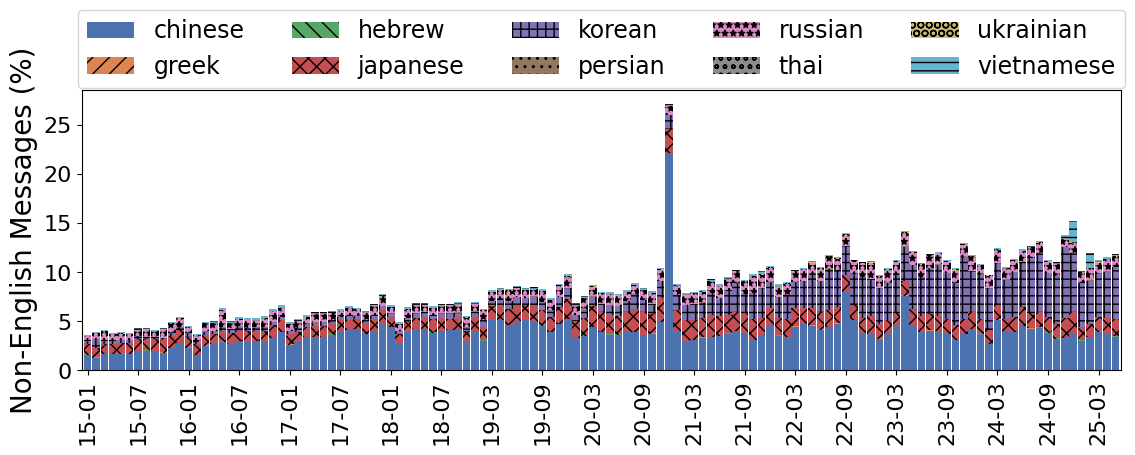

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# List of languages to exclude (lowercased for consistency)
excluded_languages = [
    'french',
    'spanish',
    'portuguese',
    'italian',
    'german',
    'dutch'
]

all_years = []
for year in range(2015, 2026):
    try:
        df = pd.read_csv(f'language_counts_by_month_{year}.csv')
        all_years.append(df)
    except Exception as e:
        print(f"Error processing file for year {year}: {e}")
        continue

# Combine all years
df_all = pd.concat(all_years, ignore_index=True)

# Get total messages per date (including English)
total_per_date = df_all.groupby('date')['count'].sum()

# Filter out English and the excluded languages
df_filtered = df_all[~df_all['language'].str.lower().isin(['english'] + excluded_languages)]

# Get top 10 languages after filtering
top_langs = (
    df_filtered.groupby('language')['count']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index.tolist()
)

# Keep only those top 10
df_top = df_filtered[df_filtered['language'].isin(top_langs)]

# Pivot: date x language
pivot_df = df_top.pivot(index='date', columns='language', values='count').fillna(0)

# Normalize per total messages (including English + excluded languages)
percent_df = pivot_df.div(total_per_date, axis=0) * 100

# Sort by date
percent_df = percent_df.sort_index()

# Plot
# percent_df.plot(kind='bar', stacked=True, figsize=(16, 7))

# plt.title('Top 10 Non-English, Non-Western European Languages (% of All Messages, 2015–2025)')
# plt.xlabel('Month')
# plt.ylabel('Percentage')
# plt.xticks(rotation=90)
# plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

base_palette = sns.color_palette("deep", n_colors=10)  # 'deep' has 10 colors
# Add one more distinct dark color (e.g., dark teal)
extra_color = sns.dark_palette("teal", n_colors=1)[0]

palette = [color for color in base_palette] + [extra_color]
plt.figure(figsize=(12, 5))

# Define hatching patterns for up to 11 bars
hatch_patterns = ['', '//', '\\\\', 'xx', '++', '..', '**', 'oo', 'OO', '--', '||']

# Plot the stacked bar with patterns
bars = percent_df.plot(
    kind='bar',
    stacked=True,
    color=palette,
    width=0.9,
    ax=plt.gca()
)

# Apply hatching patterns to each bar group
for i, bar_container in enumerate(bars.containers):
    hatch = hatch_patterns[i % len(hatch_patterns)]
    for rect in bar_container:
        rect.set_hatch(hatch)


plt.xlabel(None)
plt.ylabel("Non-English Messages (%)", fontsize=20)
all_xticks = list(percent_df.index)
step = max(1, len(all_xticks) // 20)
# Shorten year: '2015-01' -> '15-01'
short_labels = [x[2:] if len(x) >= 5 else x for x in all_xticks]
plt.xticks(
    ticks=range(0, len(all_xticks), step),
    labels=[short_labels[i] for i in range(0, len(short_labels), step)],
    rotation=90,
    fontsize=16
)
def millions(x, pos):
    return f'{x/1e6:.1f}M' if x >= 1e6 else (f'{x/1e3:.0f}k' if x >= 1e3 else str(int(x)))
# plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
plt.yticks(fontsize=16)

# plt.legend(bbox_to_anchor=(0.5, 1.12), loc='center', ncol = 5, fontsize=16)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.33), ncol=5, fontsize=17)
plt.tight_layout()
plt.savefig("RQ3.pdf", bbox_inches="tight")
plt.show()
#


In [140]:
percent_df

language   chinese     greek    hebrew  japanese    korean   persian  \
date                                                                   
2015-01   1.588519  0.011780  0.024467  1.079574  0.297354  0.004854   
2015-02   1.303038  0.021152  0.015618  0.987178  0.874287  0.004058   
2015-03   1.663223  0.011774  0.020092  0.971847  0.362674  0.001404   
2015-04   1.682683  0.012252  0.009631  1.005153  0.322609  0.003647   
2015-05   1.705859  0.010551  0.016687  1.066305  0.310229  0.004358   
...            ...       ...       ...       ...       ...       ...   
2025-01   3.033077  0.007282  0.025716  1.400708  4.404403  0.039692   
2025-02   3.414471  0.011357  0.018838  1.300404  4.403866  0.029520   
2025-03   3.943198  0.009858  0.017916  1.432858  4.357148  0.026643   
2025-04   3.828775  0.008777  0.015588  1.477993  4.722615  0.028695   
2025-05   3.417730  0.018316  0.024046  1.764205  5.247918  0.021062   

language   russian      thai  ukrainian  vietnamese  
date                                                 
2015-01   0.492699  0.005761   0.014046    0.087187  
2015-02   0.584498  0.006395   0.026378    0.066406  
2015-03   0.921996  0.003619   0.032514    0.093598  
2015-04   0.661801  0.004046   0.036700    0.109132  
2015-05   0.632902  0.004760   0.040485    0.124378  
...            ...       ...        ...         ...  
2025-01   0.974574  0.029483   0.058243    0.141394  
2025-02   1.090534  0.038190   0.094366    1.501974  
2025-03   1.155135  0.027838   0.071011    0.143584  
2025-04   1.189789  0.014073   0.081756    0.154802  
2025-05   1.063080  0.012194   0.079387    0.160598  

[123 rows x 10 columns]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

all_years = []
for year in range(2015, 2026):
    try:
        df = pd.read_csv(f'language_counts_by_month_{year}.csv')
        all_years.append(df)
    except FileNotFoundError:
        print(f"File missing for year {year}, skipping.")
        continue

# Combine all years
df_all = pd.concat(all_years, ignore_index=True)

# Total messages per month (including English)
total_per_date = df_all.groupby('date')['count'].sum()

# Non-English messages per month
df_no_english = df_all[df_all['language'].str.lower() != 'english']
non_english_per_date = df_no_english.groupby('date')['count'].sum()

# Calculate percent
percent_non_english = (non_english_per_date / total_per_date) * 100

# Sort by date
percent_non_english = percent_non_english.sort_index()

# Plot
plt.figure(figsize=(14, 6))
percent_non_english.plot(marker='o')

plt.title('Percent of Non-English Messages per Month (2015–2025)')
plt.xlabel('Month')
plt.ylabel('Non-English Messages (%)')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/_0/frzsx3s9691dqywldb6cqgb80000gn/T/ipykernel_5559/1117213510.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', 11)


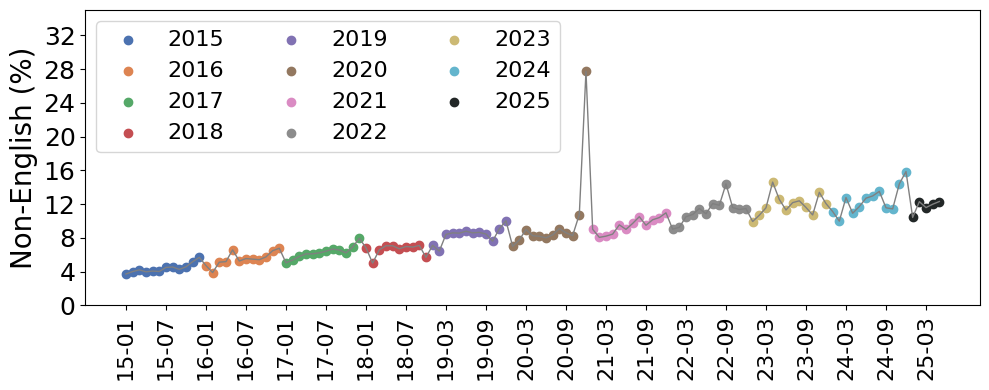

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
base_palette = sns.color_palette("deep", n_colors=10)  # 'deep' has 10 colors
# Add one more distinct dark color (e.g., dark teal)
extra_color = sns.dark_palette("teal", n_colors=1)[0]
excluded_languages = [
    'french',
    'spanish',
    'portuguese',
    'italian',
    'german',
    'dutch'
]
palette = [color for color in base_palette] + [extra_color]
# Load data
all_years = []
for year in range(2015, 2026):
    try:
        df = pd.read_csv(f'language_counts_by_month_{year}.csv')
        all_years.append(df)
    except FileNotFoundError:
        print(f"File missing for year {year}, skipping.")
        continue

# Combine all data
df_all = pd.concat(all_years, ignore_index=True)
df_all =  df_all[~df_all['language'].str.lower().isin(excluded_languages)]
# Total and non-English messages per date
total_per_date = df_all.groupby('date')['count'].sum()
non_english_df = df_all[df_all['language'].str.lower() != 'english']
# non_english_df = df_all[~df_all['language'].str.lower().isin(['english'] + excluded_languages)]
non_english_per_date = non_english_df.groupby('date')['count'].sum()

# Calculate percent
percent_non_english = (non_english_per_date / total_per_date) * 100
percent_non_english = percent_non_english.sort_index()

# Plot line connecting all points
plt.figure(figsize=(10, 4))
plt.plot(percent_non_english.index, percent_non_english.values, color='gray', linewidth=1)

# Add colored markers by year
colors = plt.cm.get_cmap('tab10', 11)
years = list(range(2015, 2026))

for idx, year in enumerate(years):
    year_str = str(year)
    year_data = percent_non_english[percent_non_english.index.str.startswith(year_str)]
    plt.scatter(
        year_data.index,
        year_data.values,
        color=palette[idx],
        label=year_str
    )

# plt.title('Percent of Non-English Messages per Month (2015–2025)')
plt.xlabel(None)
plt.yticks(fontsize=18)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.ylabel("Non-English (%)", fontsize=20)
# Reduce xticks
xticks = percent_non_english.index.tolist()
step = 6
formatted_labels = [f"{d[2:4]}-{d[5:7]}" for d in xticks]  # convert "2020-03" -> "20-03"

plt.xticks(
    ticks=range(0, len(xticks), step),
    labels=[formatted_labels[i] for i in range(0, len(xticks), step)],
    rotation=90,
    fontsize=16
)
# plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(
    fontsize=16,
    title_fontsize=22,
    ncol=3,
    loc="upper left",
    borderaxespad=0.5
)
plt.ylim(0,35)
plt.tight_layout()
plt.savefig("RQ1.pdf", bbox_inches="tight")
plt.show()

In [ ]:
# print(percent_non_english)

# Make sure index is datetime
percent_non_english.index = pd.to_datetime(percent_non_english.index)

# Group by year and calculate mean
yearly_avg = percent_non_english.resample('Y').mean()

# Optional: change index to year only
yearly_avg.index = yearly_avg.index.year
# Calculate percent change
yearly_avg['percent_change'] = yearly_avg.iloc[:, 0].pct_change() * 100


yearly_avg

In [123]:
# If percent_non_english is a Series
yearly_avg = percent_non_english.resample('Y').mean()

# Convert to DataFrame
yearly_avg = yearly_avg.to_frame(name='average')

# Add percent change
yearly_avg['percent_change'] = yearly_avg['average'].pct_change() * 100
yearly_avg

/var/folders/_0/frzsx3s9691dqywldb6cqgb80000gn/T/ipykernel_5559/1595225368.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_avg = percent_non_english.resample('Y').mean()


average  percent_change
date                                 
2015-12-31   4.395662             NaN
2016-12-31   5.516924       25.508359
2017-12-31   6.284210       13.907862
2018-12-31   6.596087        4.962869
2019-12-31   8.362498       26.779672
2020-12-31  10.086063       20.610656
2021-12-31   9.460487       -6.202382
2022-12-31  11.220003       18.598578
2023-12-31  11.917026        6.212323
2024-12-31  12.413886        4.169327
2025-12-31  11.719033       -5.597386

In [149]:
df = pd.read_csv("comment_count_2025_05.csv")
# df = df.drop_duplicates(keep='first').reset_index(drop=True)
# sum the comment counts
total_comments = df['comment_count'].sum()
print(f"Total comments in May 2025: {total_comments}")

Total comments in May 2025: 57297


In [ ]:
# for month in range(1,6):
#     df = pd.read_csv(f'interactions_files_new/comment_count_2025_{month:02d}_all_days.csv')
#     total_comments = df['comment_count'].sum()
#     print(f"Total comments in May 2025: {total_comments}")
#     for day in range(1,32):
#         try:


Total comments in May 2025: 31884
Total comments in May 2025: 31165
Total comments in May 2025: 41703
Total comments in May 2025: 70504
Total comments in May 2025: 57297


In [118]:
df = pd.read_csv("test_only/messages_with_languages_2025_05_01.csv")
df = df[df['event_type'] == 'IssueCommentEvent'].reset_index(drop=True)
print(f"Total messages in May 2025: {len(df)}")

message_dict = dict(zip(df['message'], df['language']))
print(f"Loaded {len(message_dict)} messages for 2025_05_01")
# find duplicates based on 'language' and 'message'
duplicates = df[df.duplicated(subset=['language', 'message', 'id'], keep=False)].reset_index(drop=True)
print(f"Total duplicates in May 2025: {len(duplicates)}")
for index, row in duplicates.iterrows():
    print(f"Duplicate found: {row['language']} - {row['message']}: {row['event_type']} - {row['id']}")
    if index>100:
        break

Total messages in May 2025: 57297
Loaded 53406 messages for 2025_05_01
Total duplicates in May 2025: 0


In [144]:
df = pd.read_csv("test_only/messages_with_languages_2025_05_01.csv")
df = df[df['event_type'] == 'IssueCommentEvent'].reset_index(drop=True)
ids = df['id'].tolist()
print(f"Total messages in May 2025: {len(df)}")

new_ids = pd.read_csv("comment_ids_2025_05.csv")['comment_id'].tolist()
print(f"Total new comment IDs in May 2025: {len(new_ids)}")

# Find new IDs that are not in the original IDs
new_ids_set = set(new_ids)
original_ids_set = set(ids)
missing_ids = original_ids_set - new_ids_set
print(f"Missing IDs in the original data: {len(missing_ids)}")

Total messages in May 2025: 57297
Total new comment IDs in May 2025: 0
Missing IDs in the original data: 57125


In [ ]:
from tqdm import tqdm
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed

comment_counts = defaultdict(int)
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
months = range(1, 13)

def process_push_file(args):
    year, month = args
    month_str = f"{month:02d}"
    file_name = f"interactions_files_new/comment_count_{year}_{month_str}_all_days.csv"
    local_counts = defaultdict(int)
    try:
        df = pd.read_csv(file_name)
        for _, row in df.iterrows():
            repo_id = row['repo_id']
            language = row['language']
            local_counts[repo_id][language] += row['comment_count']
    except:
        print(f"Push file not found: {file_name}")
    return local_counts

tasks = [(year, month) for year in years for month in months]
with ThreadPoolExecutor() as executor:
    for local_counts in tqdm(executor.map(process_push_file, tasks), total=len(tasks)):
        for repo_id, language, count in local_counts.items():
            comment_counts[repo_id][language] += count

print(comment_counts)


In [10]:
df = pd.read_csv("interactions_files_new/comment_count_2025_05_all_days.csv")
chinese_df = df[df['language']=='chinese']
korean_df = df[df['language']=='korean']

chinese_total_comments = chinese_df['comment_count'].sum()
korean_total_comments = korean_df['comment_count'].sum()
chinese_total_comments, korean_total_comments

(np.int64(87676), np.int64(22684))

In [23]:
df = pd.read_csv("test_only/messages_with_languages_2025_05_01.csv")
chinese_df = df[df['language']=='chinese']
korean_df = df[df['language']=='korean']

# print(len(korean_df)/len(chinese_df))

# # count the different event_type in chiness df
# print("Chinese ====> ")
# print(chinese_df['event_type'].value_counts())

# print("Korean =======> ")
# print(korean_df['event_type'].value_counts())

korean_pull_df = korean_df[korean_df['event_type']=='PullRequestEvent'].reset_index(drop=True)
korean_pull_df = korean_pull_df.drop_duplicates().reset_index(drop=True)
korean_pull_df.to_csv("korean_pull_req_sample.csv", index=False)

In [105]:
for day in range(12, 13):
    df = pd.read_csv(f"test_only/messages_with_languages_2020_12_{day:02d}.csv")
    # malware_df = df[df['message'].str.contains('关于上海哪里能开具真实饭店餐饮费发票-上海本地宝', na=False)]
    # print(malware_df)

    chinese_df = df[df['language'] == 'chinese']
    
    actor_counts = chinese_df['actor_name'].value_counts()
    
    # print(day, "===============>", (len(chinese_df) / len(df)) * 100)
    # print("Actor counts:\n", actor_counts)

    event_types = chinese_df['event_type'].value_counts()
    print(event_types)


event_type
IssuesEvent                      377840
IssueCommentEvent                  1734
PullRequestEvent                   1051
PullRequestReviewCommentEvent       141
PullRequestReviewEvent               42
Name: count, dtype: int64


In [ ]:
import glob
target_folder = 'rq4_logs_new'
sub_folders = glob.glob(f"{target_folder}/*")
year_months = set()

file_ext_dict={}
all_good_files = []
for folder in sub_folders:
    good_files = []
    # for ext in ['.py', '.java', '.js', '.ts', '.cs']:
    # if "2015" in folder or "2016" in folder or "2017" in folder or "2018" in folder or "2022" in folder:
        # continue
    # for ext in ['.ts']:
    year_month = folder.split("/")[1]
    files = glob.glob(f"{folder}/*")
    valid_files = 0
    repo_ids_of_files = set()
    for file_ in files:
        with open(file_, "r") as in_file:
            data = in_file.read()
            # char_counts.append(len(data))
            if len(data)>=500:
                # file_name_part = file_.base
                base_name = os.path.basename(file_).split(".")[0]
                ext = os.path.basename(file_).split(".")[1]
                repo_id = base_name.split("_")[0]
                # print(base_name, file_, ext, repo_id)
                good_files.append((base_name,year_month, repo_id, ext))
    # print(folder)
    
    # print(year_month, len(good_files), len(files))
    all_good_files.extend(good_files)

# save the all_good_files in csv file

import csv

# Specify the output CSV file name
output_file = 'good_files.csv'

# Write to CSV
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['FilePath', 'YearMonth', 'RepoID', 'Ext'])  # header
    writer.writerows(all_good_files)

print(f"Saved {len(all_good_files)} entries to {output_file}")


# df = pd.read_csv("good_files.csv")
# file_paths = df['FilePath'].tolist()

# target_folder = 'code_paerser_data'
# sub_folders = glob.glob(f"{target_folder}/*")

# for folder in sub_folders:
#     year_month = folder.split("/")[1]
#     files = glob.glob(f"{folder}/*")
#     not_found = 0
#     for file_ in files:
#         base_name = os.path.basename(file_)
#         parts = base_name.split("_")
#         actual_file_name = parts[0]+"_"+parts[1]
#         # print(file_, base_name, actual_file_name)
#         if actual_file_name not in file_paths:
#             not_found+=1
#     print(year_month, " ====> ", not_found)
        


Saved 204981 entries to good_files.csv


In [25]:
import glob
from pathlib import Path
import os
import json
from collections import defaultdict
import pandas as pd
target_folder = 'rq4_logs_new'
sub_folders = glob.glob(f"{target_folder}/*")
year_months = set()
file_ext_dict={}
# for ext in ['.py', '.java', '.js', '.ts', '.cs']:
for folder in sub_folders:
    files = glob.glob(f"{folder}/*")
    # print(folder, len(files))
    for file_ in files:
        ext = Path(file_).suffix.lower()
        
        folder_name = os.path.basename(folder)
        parts = folder_name.split('-')
        if len(parts) >= 2:
            year, month = parts[0], parts[1]
        else:
            year, month = "unknown", "unknown"

        base_name = os.path.basename(file_)
        json_name = f"{os.path.splitext(base_name)[0]}_{year}_{month}.json"
        out_dir = f"code_paerser_data_rq4/{year}-{month}"
        out_path = os.path.join(out_dir, json_name)
        file_ext_dict[out_path] = ext
        # print(file_, base_name, json_name, out_path, ext)
# file_ext_dict, len(file_ext_dict)

df = pd.read_csv("good_files.csv")
file_paths = df['FilePath'].tolist()
# df
# target_folder = 'code_paerser_data_rq4'
sub_folders = glob.glob(f"{target_folder}/*")
year_months = set()
# file_ext_dict_count={}
# for ext in ['.py', '.java', '.js', '.ts', '.cs']:
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
monthly_stats = []
sample_df_list = []

for year in years:
    for month in range(1, 13):
        try:
            # file_path = f"gharchive_event_counts_{year}_{month:02d}.csv"
            year_month = f"{year}-{month:02d}"
            # print(year_month)
            good_file_month = df[df['YearMonth']==year_month].reset_index(drop=True)
            # check if the file exists
            # print(len(good_file_month))
            for index, row in good_file_month.iterrows():
                file_path = row['FilePath']
                year_month = row['YearMonth']
                year, month = year_month.split("-")
                file_name = os.path.join("code_paerser_data_rq4", year_month, f"{file_path}_{year}_{month}.json")
                check_file = os.path.exists(file_name)
                if not check_file:
                    # drop the row
                    # print(file_name)
                    good_file_month = good_file_month.drop(index).reset_index(drop=True)
            # print(len(good_file_month))
            good_file_month = good_file_month.drop_duplicates(subset=['RepoID'], keep='first').reset_index(drop=True)
            # print("Before removing duplicates", year_month, len(good_file_month))
            good_file_month = good_file_month.drop_duplicates(subset=['FilePath'], keep='first').reset_index(drop=True)
            # find the duplicates in good_file_month
            # duplicates = good_file_month[good_file_month.duplicated(subset=['FilePath'])]
            # print(duplicates)
            # print("After removing duplicates", year_month, len(good_file_month))
            # Assign higher weights to js files
            #include the js files in sample df, then for other files, sample 385-number of js files
            js_files = good_file_month[good_file_month['Ext']=='js'].reset_index(drop=True)
            # duplicates = js_files[js_files.duplicated(subset=['FilePath'])]
            # print("js duplicates", duplicates)
            other_files = good_file_month[good_file_month['Ext']!='js'].reset_index(drop=True)
            # duplicates = other_files[other_files.duplicated(subset=['FilePath'])]
            # print("other duplicates", duplicates)
            n_sample = 385-len(js_files)
            # print(year_month, len(js_files), n_sample)
            sample_df = pd.concat([js_files, other_files.sample(n=n_sample, replace=False).reset_index(drop=True)])
            sample_df = sample_df.drop_duplicates(subset=['FilePath','YearMonth']).reset_index(drop=True)
            sample_df_list.append(sample_df)
            # print(year_month, len(sample_df))

            # Start with a reasonable weight for js files
            # sample_df = good_file_month.sample(n=n_sample, weights=weights, replace=True).reset_index(drop=True)
            # # sample_df = good_file_month.sample(n=385).reset_index(drop=True)
            # ext_counts = good_file_month['Ext'].value_counts()
            # sample_df_list.append(sample_df)
            # print(year_month, ext_counts)
            # print(sample_df['Ext'].value_counts())
            # good_file_month = good_file_month['RepoID'].unique()
            # print(sample_df)
            # if len(good_file_month)<500:
            #     print("Need more File ======> ", year_month)
        except:
            # raise
            print(year_month)

sample_df = pd.concat(sample_df_list)
sample_df.to_csv("sample_df.csv", index=False)

# for folder in tqdm(sub_folders):
#     file_ext_dict_count=defaultdict(int)
#     files = glob.glob(f"{folder}/*")
#     print(folder)
    # for file_ in files:
    #     ext = file_ext_dict[file_]
    #     base_name = os.path.basename(file_)
    #     parts = base_name.split("_")
    #     actual_file_name = parts[0]+"_"+parts[1]
    #     # print(actual_file_name, file_)
    #     if actual_file_name in file_paths:
    #         file_ext_dict_count[ext]+=1
    
    # # print(folder, file_ext_dict_count)
    # for ext, count in file_ext_dict_count.items():
    #     if count < 100:
            # print(f"{folder} has less than 100 files with extension {ext}")




2025-06
2025-07
2025-08
2025-09
2025-10
2025-11
2025-12


In [ ]:
import glob
from pathlib import Path
import os
import json
from collections import defaultdict
import pandas as pd
target_folder = 'rq4_logs_new'
sub_folders = glob.glob(f"{target_folder}/*")
year_months = set()
file_ext_dict={}
# for ext in ['.py', '.java', '.js', '.ts', '.cs']:
for folder in sub_folders:
    files = glob.glob(f"{folder}/*")
    # print(folder, len(files))
    for file_ in files:
        ext = Path(file_).suffix.lower()
        
        folder_name = os.path.basename(folder)
        parts = folder_name.split('-')
        if len(parts) >= 2:
            year, month = parts[0], parts[1]
        else:
            year, month = "unknown", "unknown"

        base_name = os.path.basename(file_)
        json_name = f"{os.path.splitext(base_name)[0]}_{year}_{month}.json"
        out_dir = f"code_paerser_data_rq4/{year}-{month}"
        out_path = os.path.join(out_dir, json_name)
        file_ext_dict[out_path] = ext
        # print(file_, base_name, json_name, out_path, ext)
# file_ext_dict, len(file_ext_dict)

df = pd.read_csv("good_files.csv")
file_paths = df['FilePath'].tolist()
# df
# target_folder = 'code_paerser_data_rq4'
sub_folders = glob.glob(f"{target_folder}/*")
year_months = set()
# file_ext_dict_count={}
# for ext in ['.py', '.java', '.js', '.ts', '.cs']:
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
monthly_stats = []
sample_df_list = []
# for ext in ['.py', '.java', '.js', '.ts', '.cs']:
for year in years:
    for month in range(1, 13):
        for ext in ['py', 'java', 'js', 'ts', 'cs']:
            try:
                year_month = f"{year}-{int(month):02d}"
                good_file_month = df[df['YearMonth']==year_month].reset_index(drop=True)
                good_file_month = good_file_month[good_file_month['Ext']==ext].reset_index(drop=True)
                for index, row in good_file_month.iterrows():
                    file_path = row['FilePath']
                    year_month = row['YearMonth']
                    year, month = year_month.split("-")
                    file_name = os.path.join("code_paerser_data_rq4", year_month, f"{file_path}_{year}_{month}.json")
                    check_file = os.path.exists(file_name)
                    if not check_file:
                        # drop the row
                        # print(file_name)
                        good_file_month = good_file_month.drop(index).reset_index(drop=True)
                # print(len(good_file_month))
                good_file_month = good_file_month.drop_duplicates(subset=['RepoID'], keep='first').reset_index(drop=True)
                # print("Before removing duplicates", year_month, len(good_file_month))
                good_file_month = good_file_month.drop_duplicates(subset=['FilePath'], keep='first').reset_index(drop=True)
                # find the duplicates in good_file_month
                # duplicates = good_file_month[good_file_month.duplicated(subset=['FilePath'])]
                # print(duplicates)
                # print("After removing duplicates", year_month, len(good_file_month))
                if len(good_file_month)<100:
                    print("Not enough files", year_month, len(good_file_month), ext)
                    continue
                
                sample_df = good_file_month.sample(n=100, replace=False).reset_index(drop=True)
                sample_df = sample_df.drop_duplicates(subset=['FilePath','YearMonth']).reset_index(drop=True)
                sample_df_list.append(sample_df)
                # print(year_month, len(sample_df))
            except:
                # raise
                print(year_month)

sample_df = pd.concat(sample_df_list)
sample_df.to_csv("sample_df_rq4.csv", index=False)

In [37]:
import glob
from pathlib import Path
import os
import json
from collections import defaultdict
import pandas as pd
target_folder = 'code_paerser_data_rq4'
sub_folders = glob.glob(f"{target_folder}/*")
year_months = set()
file_ext_dict={}


df = pd.read_csv("sample_df_rq4.csv")
file_paths = df['FilePath'].tolist()
# df
# target_folder = 'code_paerser_data_rq4'
sub_folders = glob.glob(f"{target_folder}/*")
year_months = set()
# file_ext_dict_count={}
# for ext in ['.py', '.java', '.js', '.ts', '.cs']:
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
monthly_stats = []
sample_df_list = []

# for year in years:
#     for month in range(1, 13):
#         files = glob.glob(f"{target_folder}/{year}-{month:02d}/*")
#         print(year, month, len(files))
#         valid_files = 0
#         for file_ in files:
#             base_name = os.path.basename(file_)
#             parts = base_name.split("_")
#             file_name = parts[0]+"_"+parts[1]
#             if file_name in file_paths:
#                 valid_files+=1
#             else:
#                 print(file_name)
#         print(year, month, valid_files)
#         break
#     break

for index, row in df.iterrows():
    file_path = row['FilePath']
    year_month = row['YearMonth']
    year, month = year_month.split("-")
    file_name = os.path.join(target_folder, year_month, f"{file_path}_{year}_{month}.json")
    dest_folder = 'code_parser_data_rq4'
    dest_path = os.path.join(dest_folder, year_month)
    os.makedirs(dest_path, exist_ok=True)
    dest_file = os.path.join(dest_path, f"{file_path}_{year}_{month}.json")
    if os.path.exists(file_name):
        # Copy the file to the destination folder
        import shutil
        shutil.copy2(file_name, dest_file)
    else:
        print(f"Source file does not exist: {file_name}")
    # break


In [ ]:
import glob
from pathlib import Path
import os
import json
from collections import defaultdict
import pandas as pd
target_folder = 'code_parser_data_rq4'
sub_folders = glob.glob(f"{target_folder}/*")


sub_folders = glob.glob(f"{target_folder}/*")
year_months = set()
# file_ext_dict_count={}
# for ext in ['.py', '.java', '.js', '.ts', '.cs']:
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
monthly_stats = []
sample_df_list = []

for year in years:
    for month in range(1, 13):
        files = glob.glob(f"{target_folder}/{year}-{month:02d}/*")
        print(year, month, len(files))